In [68]:
from typing import Dict
import json
import logging

from overrides import overrides

import tqdm

from allennlp.common import Params
from allennlp.common.file_utils import cached_path
from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.instance import Instance
from allennlp.data.tokenizers import Tokenizer, WordTokenizer
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data import Vocabulary
from allennlp.data.dataset import Batch
import cytoolz
from torch.autograd import Variable
from datetime import datetime
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

In [2]:
class FastText(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        print("FastText Model")
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        all_embs = self.embeds(data)
        sum_emb = torch.sum(all_embs, 1)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        avg_emb = sum_emb / length.float().view(-1,1)
        out = self.linear(avg_emb)
        out = self.sigmoid(out.view(-1))
        return out
    
class FastText_LR(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim,hidden_size):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText_LR, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        print("FastText Model with two linear layer")
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.hidden_layer = nn.Linear(emb_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        all_embs = self.embeds(data)
        sum_emb = torch.sum(all_embs, 1)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        avg_emb = sum_emb / length.float().view(-1,1)
        hid_out = self.hidden_layer(avg_emb)
        out = self.linear(hid_out)
        out = self.sigmoid(out.view(-1))
        return out
class LSTM(nn.Module):
    """
    FastText model that implements https://arxiv.org/abs/1607.01759
    """
    def __init__(self, vocab_size, emb_dim, hidden_size,batch_size,dropout = 0.5,num_layers = 1):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(LSTM, self).__init__()
        # Note that the # of inputs dimension for embedding shall be vocab_size+1, why?
        # In the embedding, you need to set the padding_dx argument.
        # Please see http://pytorch.org/docs/master/nn.html
        print("LSTM")
        self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_size,num_layers = num_layers,dropout = dropout)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.hidden = self.init_hidden()
    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        use_gpu = 1
        if use_gpu:
            return (Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()),
                    Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()))
        else:
            return (Variable(torch.zeros(1, self.batch_size, self.hidden_size)),
                    Variable(torch.zeros(1, self.batch_size, self.hidden_size)))
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        all_embs = self.dropout(self.embeds(data))
#         all_embs = self.embeds(data)
        #sum_emb = torch.sum(all_embs, 1)
        # Note that instead of doing tensorwise mean, you need to calculate the sum and divide by the sentence length
        # in the length tensor.
        #avg_emb = sum_emb / length.float().view(-1,1)
        #hid_out = self.hidden_layer(avg_emb)
        #print(data.shape[1])
        x = all_embs.view(data.shape[1], data.shape[0], -1)
#         print(len(self.hidden))
#         print(self.hidden)
        lstm_out, self.hidden = self.lstm(x)
        out = self.linear(self.dropout(lstm_out[-1]))
#         out = self.linear(lstm_out[-1])
        out = self.sigmoid(out.view(-1))
        return out

In [62]:

#@DatasetReader.register("IMDBReader")
class IMDBDatasetReader(DatasetReader):
    """
    Reads a JSON-lines file containing papers from the Semantic Scholar database, and creates a
    dataset suitable for document classification using these papers.
    Expected format for each input line: {"paperAbstract": "text", "title": "text", "venue": "text"}
    The JSON could have other fields, too, but they are ignored.
    The output of ``read`` is a list of ``Instance`` s with the fields:
        title: ``TextField``
        abstract: ``TextField``
        label: ``LabelField``
    where the ``label`` is derived from the venue of the paper.
    Parameters
    ----------
    lazy : ``bool`` (optional, default=False)
        Passed to ``DatasetReader``.  If this is ``True``, training will start sooner, but will
        take longer per batch.  This also allows training with datasets that are too large to fit
        in memory.
    tokenizer : ``Tokenizer``, optional
        Tokenizer to use to split the title and abstrct into words or other kinds of tokens.
        Defaults to ``WordTokenizer()``.
    token_indexers : ``Dict[str, TokenIndexer]``, optional
        Indexers used to define input token representations. Defaults to ``{"tokens":
        SingleIdTokenIndexer()}``.
    """
    def __init__(self,
                 label_answer: bool = False,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None) -> None:
        super().__init__(lazy)
        self._tokenizer = tokenizer or WordTokenizer()
        self._token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer()}
        self.label_answer = label_answer

    @overrides
    def _read(self, file_path):
#         content = JSONL(file_path)
#         for line in content:
        with open(cached_path(file_path), "r") as data_file:
#             logger.info("Reading instances from lines in file at: %s", file_path)
            for line in data_file:
                line = line.strip("\n")
                if not line:
                    continue
                review = json.loads(line)
                text = review['text']
                if self.label_answer:
                    label = 1 if review['meta']['label_answer'] == "POSITIVE" else 0
                else:
                    label = 1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0
                yield self.text_to_instance(text,label)

    @overrides
    def text_to_instance(self, text: str, label: int) -> Instance:  # type: ignore
        # pylint: disable=arguments-differ
        tokenized_text = self._tokenizer.tokenize(text)
        text_field = TextField(tokenized_text, self._token_indexers)
        
        fields = {'text': text_field, 'length':LabelField(text_field.sequence_length(),skip_indexing=True),'label': LabelField(label,skip_indexing=True)}
        
        return Instance(fields)

    @classmethod
    def from_params(cls, params: Params) -> 'SemanticScholarDatasetReader':
        lazy = params.pop('lazy', False)
        tokenizer = Tokenizer.from_params(params.pop('tokenizer', {}))
        token_indexers = TokenIndexer.dict_from_params(params.pop('token_indexers', {}))
        params.assert_empty(cls.__name__)
        return cls(lazy=lazy, tokenizer=tokenizer, token_indexers=token_indexers)

def build_instance(file_path,label_answer = 0):
    # tokenize, stem, 
    datareader = IMDBDatasetReader(label_answer)
    instance = datareader.read(file_path)
    return instance

def build_vocabulary(instance):
    # buil vocabulary
    vocab = Vocabulary.from_instances(instance)
    print("vocab_size:",vocab.get_vocab_size())
    return vocab

def batchify(instance,vocab,batch_size = 32,lstm_flag = False,cuda_device = 0):
    # tensorize, padding, batchify
    batch_loader = []
    for batch in cytoolz.partition_all(batch_size,tqdm.tqdm(instance, leave=False)):
        batch = Batch(batch)
        batch.index_instances(vocab)
        if lstm_flag:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
            tensors = batch.as_tensor_dict({'text': {'num_tokens': int(torch.sum(tensors['length'])/batch_size)}},cuda_device)
        else:
            tensors = batch.as_tensor_dict(batch.get_padding_lengths(),cuda_device)
        batch_loader.append(tensors)
    return batch_loader

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for batch_idx,batch in enumerate(loader):
        data_batch = Variable(batch['text']['tokens'])
        labels = batch['label']
        length_batch = Variable(batch['length'])
        outputs = model(data_batch, length_batch)
        predicted = (outputs.data > 0.5).long().view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    return (100 * correct / total)
    
def increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,data_size,batch_size,weights_matrix=None,freeze_emb=False):
    if weights_matrix is not None:
        model.embeds.weight.data.copy_(torch.from_numpy(weights_matrix))
        # check using cuda and do initialization.
        # print(model.embeds.weight.data[0])
        # print(weights_matrix[0])
        print("Use pretrained embeddding")
    else:
        print("No pretrained embedding")
    if freeze_emb:
        model.embeds.weight.requires_grad = False
        print("Freeze embedding layer")
    else:
        print("embedding weight is trainable")
    print("n_iter: ",1)
    print("vocab_size",vocab_size)
    print("emb_dim: ",emb_dim)
    print("learning_rate: ",learning_rate)
    print("batch_size: ",batch_size)
    print(model.parameters())
    criterion = nn.BCELoss()  
    #criterion = nn.NLLLoss()
    #criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=learning_rate) 
    start_time = datetime.now()
    step_idx = 0
    acc_list = []
    for batch_idx,batch in enumerate(train_loader):
        for i in range(n_iter):
            # Variable defined here or outside iteration?
            data_batch = Variable(batch['text']['tokens'])
            label_batch = Variable(batch['label'])
            length_batch = Variable(batch['length'])
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            #model.train()
            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            acc = test_model(test_loader,model)
            end_time = datetime.now() -start_time
            print('Time:[{0} seconds], batch: [{1}/{2}], Epoch: [{3}/{4}], step: [{5}/{6}], Loss: {7},Acc:{8}'.format(
                   end_time.seconds,batch_idx, data_size//batch_size, i+1, n_iter, step_idx+1, data_size*n_iter//batch_size, loss, acc))
            acc_list.append([batch_idx,i+1,step_idx+1,loss,acc])
            step_idx += 1
    return acc_list
def earily_stop(val_acc_history, k=4, required_progress=0.01):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param k: number of training sub-epochs 
    @return: a boolean indicates if the model should earily stop
    """
    # trivial case
    if len(val_acc_history) < k+1:
        return False
    
    # non-trivial case
    current_k = 0
    for i in range(-1, -len(val_acc_history)+1, -1):
        if val_acc_history[i][-1] < val_acc_history[i-1][-1]+required_progress:
            current_k += 1
        else:
            current_k = 0
        if current_k >= k:
            return True
    return False
def cumulative_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,data_size,batch_size,weights_matrix=None,freeze_emb=False):
    if weights_matrix is not None:
        model.embeds.weight.data.copy_(torch.from_numpy(weights_matrix))
        # check using cuda and do initialization.
        # print(model.embeds.weight.data[0])
        # print(weights_matrix[0])
        print("Use pretrained embeddding")
    else:
        print("No pretrained embedding")
    if freeze_emb:
        model.embeds.weight.requires_grad = False
        print("Freeze embedding layer")
    else:
        print("embedding weight is trainable")
    print("n_iter: ",n_iter)
    print("vocab_size",vocab_size)
    print("emb_dim: ",emb_dim)
    print("learning_rate: ",learning_rate)
    print("batch_size: ",batch_size)
    print("train data size",data_size)
    print(model.parameters())
    criterion = nn.BCELoss()  
    #criterion = nn.NLLLoss()
    #criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=learning_rate) 
    start_time = datetime.now()
    step_idx = 0
    acc_list = []
    for i in range(n_iter):
        for batch_idx,batch in enumerate(train_loader):
            # Variable defined here or outside iteration?
            data_batch = Variable(batch['text']['tokens'])
            label_batch = Variable(batch['label'])
            length_batch = Variable(batch['length'])
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch.float())
            #model.train()
            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()
            acc = test_model(test_loader,model)
            end_time = datetime.now() -start_time
            print('Time:[{0} seconds], batch: [{1}/{2}], Epoch: [{3}/{4}], step: [{5}/{6}], Loss: {7},Acc:{8}'.format(
                   end_time.seconds,batch_idx, data_size//batch_size, i+1, n_iter, step_idx+1, data_size*n_iter//batch_size, loss, acc))
            step_idx += 1
        acc_list.append([data_size, i+1,loss,acc])

            # check if we need to earily stop the model
#             stop_training = earily_stop(acc_list)
#             if stop_training:
#                 print("earily stop triggered")
#                 break
#         # because of the the nested loop
#         if stop_training:
#             break
    return acc_list,model

In [4]:
# add Glove pretrained Embedding
def glove():
    word2vec = {}
    print("Load Glove")
    with open('glove.6B.300d.txt', 'r') as f:
        for l in f:
            line = l.split()
            word = line[0]
            word2vec[word] = np.array(line[1:]).astype(np.float)
    #word2vec = pickle.load(open("/liveperson/data/alloy/prodigy/data/6B.300_vec.pkl", 'rb'))
    matrix_len = vocab.get_vocab_size()
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0
    for i, word in vocab.get_index_to_token_vocabulary().items():
        try: 
            weights_matrix[i] = word2vec[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
    print(words_found,"of ",matrix_len, "have pretrained vectors")
    return weights_matrix

In [9]:
# build vocabulary and instance
if(torch.cuda.is_available()):
    print("Using cuda")
#train_data = build_instance("/data/prodigy/data/IMDB_default/baseline_dataset_2000.jsonl")
train_data = build_instance("/data/prodigy/data/IMDB_default/unique_baseline.jsonl",1)
vocab = build_vocabulary(train_data)
test_data = build_instance("/data/prodigy/data/IMDB_default/unique_eval.jsonl")
weights_matrix = glove()



0it [00:00, ?it/s]
22it [00:00, 211.51it/s]

Using cuda



44it [00:00, 214.75it/s]
74it [00:00, 240.66it/s]
91it [00:00, 222.38it/s]
117it [00:00, 228.28it/s]
137it [00:00, 217.09it/s]
163it [00:00, 222.18it/s]
184it [00:00, 219.18it/s]
209it [00:00, 220.17it/s]
237it [00:01, 225.31it/s]Exception ignored in: <bound method tqdm.__del__ of 0it [05:12, ?it/s]>
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 882, in __del__
    self.close()
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "/usr/lib/python3.6/site-packages/tqdm/_tqdm.py", line 439, in _decr_instances
    cls._instances.remove(instance)
  File "/usr/lib64/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x7fb788066d18; to 'tqdm' at 0x7fb76f63b6d8>

260it [00:01, 203.29it/s]
280it [00:01, 201.67it/s]
304it [00:01, 204.00it/s]
325it [00:01, 199.26it/s]
351it [00:01, 202.72it/s]
379it [00:01, 206.87it/s]
403it [00:01, 2

vocab_size: 34090


320it [00:01, 231.16it/s]


Load Glove
19969 of  34090 have pretrained vectors


In [11]:
# Fasttext with batch size of 32
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 1

train_loader = batchify(train_data,vocab,batch_size,False,0)
test_loader = batchify(test_data,vocab,batch_size,False,0)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText(vocab_size, emb_dim).cuda()
increment_no_active_no_pretrain_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
# increment_no_active_pretrained_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
# increment_no_active_pretrained_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,freeze_emb= True))
# increment_no_active_no_pretrain_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,freeze_emb=True))
active_learning_data = build_instance("/data/prodigy/data/IMDB_default/custom_vector_experiment_32.jsonl")
active_learning_loader = batchify(active_learning_data,vocab,batch_size,False,0)

active_learning_size = len(active_learning_data)

model = FastText(vocab_size, emb_dim).cuda()
increment_active_no_pretrain_32 = np.array(increment_train(model,active_learning_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,active_learning_size,batch_size))


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7fdfc9773728>
Time:[0 seconds], batch: [0/156], Epoch: [1/1], step: [1/156], Loss: 0.6980878710746765,Acc:49
Time:[0 seconds], batch: [1/156], Epoch: [1/1], step: [2/156], Loss: 0.6958688497543335,Acc:50
Time:[0 seconds], batch: [2/156], Epoch: [1/1], step: [3/156], Loss: 0.6924632787704468,Acc:51
Time:[0 seconds], batch: [3/156], Epoch: [1/1], step: [4/156], Loss: 0.6886443495750427,Acc:50
Time:[0 seconds], batch: [4/156], Epoch: [1/1], step: [5/156], Loss: 0.6988228559494019,Acc:51
Time:[0 seconds], batch: [5/156], Epoch: [1/1], step: [6/156], Loss: 0.7053228616714478,Acc:51
Time:[0 seconds], batch: [6/156], Epoch: [1/1], step: [7/156], Loss: 0.692925214767456,Acc:51
Time:[0 seconds], batch: [7/156], Epoch: [1/1], step: [8/156], Loss: 0.6915624141693115,Acc:52
Time:[0 seconds], batch: [8/156], Epo

Time:[0 seconds], batch: [89/156], Epoch: [1/1], step: [90/156], Loss: 0.6618817448616028,Acc:69
Time:[0 seconds], batch: [90/156], Epoch: [1/1], step: [91/156], Loss: 0.6809387803077698,Acc:69
Time:[0 seconds], batch: [91/156], Epoch: [1/1], step: [92/156], Loss: 0.6671090722084045,Acc:69
Time:[0 seconds], batch: [92/156], Epoch: [1/1], step: [93/156], Loss: 0.6495915651321411,Acc:69
Time:[0 seconds], batch: [93/156], Epoch: [1/1], step: [94/156], Loss: 0.6528851985931396,Acc:70
Time:[0 seconds], batch: [94/156], Epoch: [1/1], step: [95/156], Loss: 0.664654016494751,Acc:70
Time:[0 seconds], batch: [95/156], Epoch: [1/1], step: [96/156], Loss: 0.6617644429206848,Acc:70
Time:[0 seconds], batch: [96/156], Epoch: [1/1], step: [97/156], Loss: 0.6834059953689575,Acc:69
Time:[0 seconds], batch: [97/156], Epoch: [1/1], step: [98/156], Loss: 0.6608825325965881,Acc:69
Time:[0 seconds], batch: [98/156], Epoch: [1/1], step: [99/156], Loss: 0.6779747009277344,Acc:69
Time:[0 seconds], batch: [99/15

0it [00:00, ?it/s]

Time:[0 seconds], batch: [124/156], Epoch: [1/1], step: [125/156], Loss: 0.6586817502975464,Acc:70
Time:[0 seconds], batch: [125/156], Epoch: [1/1], step: [126/156], Loss: 0.6605001091957092,Acc:69
Time:[0 seconds], batch: [126/156], Epoch: [1/1], step: [127/156], Loss: 0.656161904335022,Acc:70
Time:[0 seconds], batch: [127/156], Epoch: [1/1], step: [128/156], Loss: 0.6572972536087036,Acc:70
Time:[0 seconds], batch: [128/156], Epoch: [1/1], step: [129/156], Loss: 0.6634724736213684,Acc:70
Time:[0 seconds], batch: [129/156], Epoch: [1/1], step: [130/156], Loss: 0.6531105637550354,Acc:70
Time:[0 seconds], batch: [130/156], Epoch: [1/1], step: [131/156], Loss: 0.6368845701217651,Acc:70
Time:[0 seconds], batch: [131/156], Epoch: [1/1], step: [132/156], Loss: 0.649303674697876,Acc:70
Time:[0 seconds], batch: [132/156], Epoch: [1/1], step: [133/156], Loss: 0.6528623104095459,Acc:71
Time:[0 seconds], batch: [133/156], Epoch: [1/1], step: [134/156], Loss: 0.6466770172119141,Acc:71
Time:[0 seco

3899it [00:18, 215.76it/s]


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7fdfc97739e8>
Time:[0 seconds], batch: [0/121], Epoch: [1/1], step: [1/121], Loss: 0.6677455306053162,Acc:51
Time:[0 seconds], batch: [1/121], Epoch: [1/1], step: [2/121], Loss: 0.7160297632217407,Acc:51
Time:[0 seconds], batch: [2/121], Epoch: [1/1], step: [3/121], Loss: 0.7227085828781128,Acc:52
Time:[0 seconds], batch: [3/121], Epoch: [1/1], step: [4/121], Loss: 0.6893349289894104,Acc:52
Time:[0 seconds], batch: [4/121], Epoch: [1/1], step: [5/121], Loss: 0.7231824398040771,Acc:52
Time:[0 seconds], batch: [5/121], Epoch: [1/1], step: [6/121], Loss: 0.6878376007080078,Acc:52
Time:[0 seconds], batch: [6/121], Epoch: [1/1], step: [7/121], Loss: 0.6912983655929565,Acc:53
Time:[0 seconds], batch: [7/121], Epoch: [1/1], step: [8/121], Loss: 0.6870080232620239,Acc:55
Time:[0 seconds], batch: [8/121], Ep

Time:[0 seconds], batch: [84/121], Epoch: [1/1], step: [85/121], Loss: 0.6711660027503967,Acc:71
Time:[0 seconds], batch: [85/121], Epoch: [1/1], step: [86/121], Loss: 0.6767176389694214,Acc:71
Time:[0 seconds], batch: [86/121], Epoch: [1/1], step: [87/121], Loss: 0.6699198484420776,Acc:71
Time:[0 seconds], batch: [87/121], Epoch: [1/1], step: [88/121], Loss: 0.6789530515670776,Acc:71
Time:[0 seconds], batch: [88/121], Epoch: [1/1], step: [89/121], Loss: 0.6758385300636292,Acc:71
Time:[0 seconds], batch: [89/121], Epoch: [1/1], step: [90/121], Loss: 0.6821638941764832,Acc:71
Time:[0 seconds], batch: [90/121], Epoch: [1/1], step: [91/121], Loss: 0.6674468517303467,Acc:71
Time:[0 seconds], batch: [91/121], Epoch: [1/1], step: [92/121], Loss: 0.6846635937690735,Acc:71
Time:[0 seconds], batch: [92/121], Epoch: [1/1], step: [93/121], Loss: 0.6855034828186035,Acc:72
Time:[0 seconds], batch: [93/121], Epoch: [1/1], step: [94/121], Loss: 0.6921706795692444,Acc:72
Time:[0 seconds], batch: [94/1

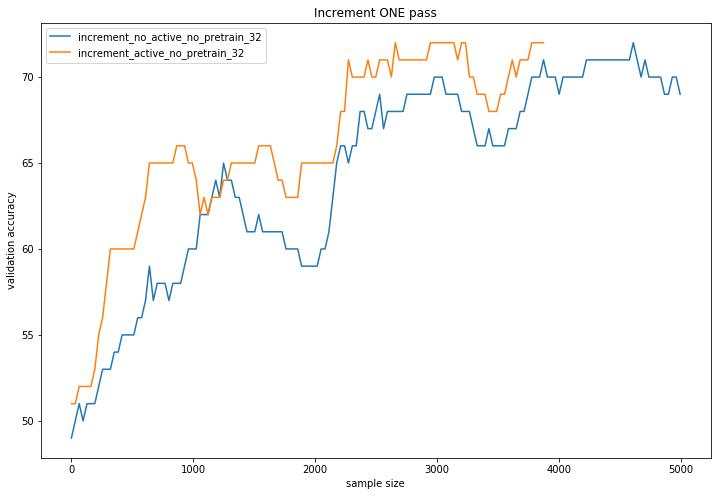

In [12]:
fig = plt.figure(figsize= (12,8))
plt.plot(32*increment_no_active_no_pretrain_32[:,0],increment_no_active_no_pretrain_32[:,-1],label = "increment_no_active_no_pretrain_32")
plt.plot(32*increment_active_no_pretrain_32[:,0],increment_active_no_pretrain_32[:,-1],label = "increment_active_no_pretrain_32")

# plt.plot(32*increment_no_active_pretrained_32[:,0],increment_no_active_pretrained_32[:,-1],label = "increment_no_active_pretrained_32")
# plt.plot(32*increment_no_active_pretrained_freeze_32[:,0],increment_no_active_pretrained_freeze_32[:,-1],label = "increment_no_active_pretrained_freeze_32")
# plt.plot(32*increment_no_active_no_pretrain_freeze_32[:,0],increment_no_active_no_pretrain_freeze_32[:,-1],label = "increment_no_active_no_pretrain_freeze_32")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

In [108]:
# fig = plt.figure(figsize= (12,8))
plt.plot(32*increment_no_active_no_pretrain_32[:,0],increment_no_active_no_pretrain_32[:,-1],label = "increment_no_active_no_pretrain_32")
plt.plot(32*increment_active_no_pretrain_32[:,0],increment_active_no_pretrain_32[:,-1],label = "increment_active_no_pretrain_32")

# plt.plot(32*increment_no_active_pretrained_32[:,0],increment_no_active_pretrained_32[:,-1],label = "increment_no_active_pretrained_32")
# plt.plot(32*increment_no_active_pretrained_freeze_32[:,0],increment_no_active_pretrained_freeze_32[:,-1],label = "increment_no_active_pretrained_freeze_32")
# plt.plot(32*increment_no_active_no_pretrain_freeze_32[:,0],increment_no_active_no_pretrain_freeze_32[:,-1],label = "increment_no_active_no_pretrain_freeze_32")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

NameError: name 'increment_no_active_no_pretrain_32' is not defined

In [16]:
# Fasttext with batch size of 32
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 10

train_loader = batchify(train_data,vocab,batch_size,False,0)
test_loader = batchify(test_data,vocab,batch_size,False,0)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText(vocab_size, emb_dim).cuda()
increment_no_active_no_pretrain_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
# increment_no_active_pretrained_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
# increment_no_active_pretrained_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,freeze_emb= True))
# increment_no_active_no_pretrain_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,freeze_emb=True))
active_learning_data = build_instance("/data/prodigy/data/IMDB_default/custom_vector_experiment_32.jsonl")
active_learning_loader = batchify(active_learning_data,vocab,batch_size,False,0)

active_learning_size = len(active_learning_data)

model = FastText(vocab_size, emb_dim).cuda()
increment_active_no_pretrain_32 = np.array(increment_train(model,active_learning_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,active_learning_size,batch_size))


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7fdfc97d85c8>
Time:[0 seconds], batch: [0/156], Epoch: [1/10], step: [1/1562], Loss: 0.7070671319961548,Acc:43
Time:[0 seconds], batch: [0/156], Epoch: [2/10], step: [2/1562], Loss: 0.6999871134757996,Acc:44
Time:[0 seconds], batch: [0/156], Epoch: [3/10], step: [3/1562], Loss: 0.6930986642837524,Acc:47
Time:[0 seconds], batch: [0/156], Epoch: [4/10], step: [4/1562], Loss: 0.6864195466041565,Acc:49
Time:[0 seconds], batch: [0/156], Epoch: [5/10], step: [5/1562], Loss: 0.6799534559249878,Acc:50
Time:[0 seconds], batch: [0/156], Epoch: [6/10], step: [6/1562], Loss: 0.6736996173858643,Acc:51
Time:[0 seconds], batch: [0/156], Epoch: [7/10], step: [7/1562], Loss: 0.6676558256149292,Acc:51
Time:[0 seconds], batch: [0/156], Epoch: [8/10], step: [8/1562], Loss: 0.66181880235672,Acc:51
Time:[0 seconds], batc

Time:[0 seconds], batch: [8/156], Epoch: [7/10], step: [87/1562], Loss: 0.6665050983428955,Acc:62
Time:[0 seconds], batch: [8/156], Epoch: [8/10], step: [88/1562], Loss: 0.663042426109314,Acc:62
Time:[0 seconds], batch: [8/156], Epoch: [9/10], step: [89/1562], Loss: 0.6593601703643799,Acc:62
Time:[0 seconds], batch: [8/156], Epoch: [10/10], step: [90/1562], Loss: 0.6554920673370361,Acc:63
Time:[0 seconds], batch: [9/156], Epoch: [1/10], step: [91/1562], Loss: 0.6721842288970947,Acc:62
Time:[0 seconds], batch: [9/156], Epoch: [2/10], step: [92/1562], Loss: 0.6705374717712402,Acc:61
Time:[0 seconds], batch: [9/156], Epoch: [3/10], step: [93/1562], Loss: 0.6682456731796265,Acc:61
Time:[0 seconds], batch: [9/156], Epoch: [4/10], step: [94/1562], Loss: 0.6654456853866577,Acc:61
Time:[0 seconds], batch: [9/156], Epoch: [5/10], step: [95/1562], Loss: 0.6622307300567627,Acc:60
Time:[0 seconds], batch: [9/156], Epoch: [6/10], step: [96/1562], Loss: 0.6586726903915405,Acc:60
Time:[0 seconds], ba

Time:[1 seconds], batch: [18/156], Epoch: [8/10], step: [188/1562], Loss: 0.6469992995262146,Acc:71
Time:[1 seconds], batch: [18/156], Epoch: [9/10], step: [189/1562], Loss: 0.6362277269363403,Acc:72
Time:[1 seconds], batch: [18/156], Epoch: [10/10], step: [190/1562], Loss: 0.6251749992370605,Acc:72
Time:[1 seconds], batch: [19/156], Epoch: [1/10], step: [191/1562], Loss: 0.6185224652290344,Acc:71
Time:[1 seconds], batch: [19/156], Epoch: [2/10], step: [192/1562], Loss: 0.6170384883880615,Acc:71
Time:[1 seconds], batch: [19/156], Epoch: [3/10], step: [193/1562], Loss: 0.6146640777587891,Acc:71
Time:[1 seconds], batch: [19/156], Epoch: [4/10], step: [194/1562], Loss: 0.6115603446960449,Acc:71
Time:[1 seconds], batch: [19/156], Epoch: [5/10], step: [195/1562], Loss: 0.607829213142395,Acc:69
Time:[1 seconds], batch: [19/156], Epoch: [6/10], step: [196/1562], Loss: 0.6035480499267578,Acc:69
Time:[1 seconds], batch: [19/156], Epoch: [7/10], step: [197/1562], Loss: 0.5987808108329773,Acc:69


Time:[1 seconds], batch: [28/156], Epoch: [9/10], step: [289/1562], Loss: 0.533227801322937,Acc:72
Time:[1 seconds], batch: [28/156], Epoch: [10/10], step: [290/1562], Loss: 0.5247153043746948,Acc:72
Time:[1 seconds], batch: [29/156], Epoch: [1/10], step: [291/1562], Loss: 0.6002188920974731,Acc:71
Time:[1 seconds], batch: [29/156], Epoch: [2/10], step: [292/1562], Loss: 0.5986179113388062,Acc:71
Time:[1 seconds], batch: [29/156], Epoch: [3/10], step: [293/1562], Loss: 0.5951883792877197,Acc:71
Time:[1 seconds], batch: [29/156], Epoch: [4/10], step: [294/1562], Loss: 0.5902674198150635,Acc:71
Time:[1 seconds], batch: [29/156], Epoch: [5/10], step: [295/1562], Loss: 0.5841141939163208,Acc:71
Time:[1 seconds], batch: [29/156], Epoch: [6/10], step: [296/1562], Loss: 0.5769484639167786,Acc:72
Time:[1 seconds], batch: [29/156], Epoch: [7/10], step: [297/1562], Loss: 0.5689619779586792,Acc:72
Time:[1 seconds], batch: [29/156], Epoch: [8/10], step: [298/1562], Loss: 0.5603238344192505,Acc:73


Time:[2 seconds], batch: [38/156], Epoch: [8/10], step: [388/1562], Loss: 0.45184576511383057,Acc:74
Time:[2 seconds], batch: [38/156], Epoch: [9/10], step: [389/1562], Loss: 0.44245806336402893,Acc:74
Time:[2 seconds], batch: [38/156], Epoch: [10/10], step: [390/1562], Loss: 0.432720422744751,Acc:74
Time:[2 seconds], batch: [39/156], Epoch: [1/10], step: [391/1562], Loss: 0.44971543550491333,Acc:74
Time:[2 seconds], batch: [39/156], Epoch: [2/10], step: [392/1562], Loss: 0.4458337724208832,Acc:74
Time:[2 seconds], batch: [39/156], Epoch: [3/10], step: [393/1562], Loss: 0.44000470638275146,Acc:74
Time:[2 seconds], batch: [39/156], Epoch: [4/10], step: [394/1562], Loss: 0.432699054479599,Acc:75
Time:[2 seconds], batch: [39/156], Epoch: [5/10], step: [395/1562], Loss: 0.42425736784935,Acc:75
Time:[2 seconds], batch: [39/156], Epoch: [6/10], step: [396/1562], Loss: 0.41495031118392944,Acc:75
Time:[2 seconds], batch: [39/156], Epoch: [7/10], step: [397/1562], Loss: 0.4050000309944153,Acc:7

Time:[2 seconds], batch: [48/156], Epoch: [8/10], step: [488/1562], Loss: 0.4499393701553345,Acc:75
Time:[3 seconds], batch: [48/156], Epoch: [9/10], step: [489/1562], Loss: 0.43774205446243286,Acc:75
Time:[3 seconds], batch: [48/156], Epoch: [10/10], step: [490/1562], Loss: 0.4253653585910797,Acc:75
Time:[3 seconds], batch: [49/156], Epoch: [1/10], step: [491/1562], Loss: 0.5661182403564453,Acc:75
Time:[3 seconds], batch: [49/156], Epoch: [2/10], step: [492/1562], Loss: 0.5601725578308105,Acc:75
Time:[3 seconds], batch: [49/156], Epoch: [3/10], step: [493/1562], Loss: 0.5515146255493164,Acc:75
Time:[3 seconds], batch: [49/156], Epoch: [4/10], step: [494/1562], Loss: 0.5408250093460083,Acc:75
Time:[3 seconds], batch: [49/156], Epoch: [5/10], step: [495/1562], Loss: 0.5286029577255249,Acc:76
Time:[3 seconds], batch: [49/156], Epoch: [6/10], step: [496/1562], Loss: 0.515247642993927,Acc:76
Time:[3 seconds], batch: [49/156], Epoch: [7/10], step: [497/1562], Loss: 0.5010873079299927,Acc:78

Time:[3 seconds], batch: [58/156], Epoch: [9/10], step: [589/1562], Loss: 0.2632357180118561,Acc:80
Time:[3 seconds], batch: [58/156], Epoch: [10/10], step: [590/1562], Loss: 0.2539864480495453,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [1/10], step: [591/1562], Loss: 0.471579372882843,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [2/10], step: [592/1562], Loss: 0.4685679078102112,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [3/10], step: [593/1562], Loss: 0.46208813786506653,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [4/10], step: [594/1562], Loss: 0.45286640524864197,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [5/10], step: [595/1562], Loss: 0.4414891004562378,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [6/10], step: [596/1562], Loss: 0.42847031354904175,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [7/10], step: [597/1562], Loss: 0.41426753997802734,Acc:80
Time:[3 seconds], batch: [59/156], Epoch: [8/10], step: [598/1562], Loss: 0.39928483963012695,Ac

Time:[4 seconds], batch: [68/156], Epoch: [9/10], step: [689/1562], Loss: 0.29960834980010986,Acc:80
Time:[4 seconds], batch: [68/156], Epoch: [10/10], step: [690/1562], Loss: 0.28856801986694336,Acc:80
Time:[4 seconds], batch: [69/156], Epoch: [1/10], step: [691/1562], Loss: 0.294638991355896,Acc:80
Time:[4 seconds], batch: [69/156], Epoch: [2/10], step: [692/1562], Loss: 0.2900305688381195,Acc:80
Time:[4 seconds], batch: [69/156], Epoch: [3/10], step: [693/1562], Loss: 0.2832239866256714,Acc:80
Time:[4 seconds], batch: [69/156], Epoch: [4/10], step: [694/1562], Loss: 0.2748452425003052,Acc:80
Time:[4 seconds], batch: [69/156], Epoch: [5/10], step: [695/1562], Loss: 0.2653850018978119,Acc:81
Time:[4 seconds], batch: [69/156], Epoch: [6/10], step: [696/1562], Loss: 0.25524187088012695,Acc:82
Time:[4 seconds], batch: [69/156], Epoch: [7/10], step: [697/1562], Loss: 0.24473747611045837,Acc:81
Time:[4 seconds], batch: [69/156], Epoch: [8/10], step: [698/1562], Loss: 0.2341252863407135,Acc

Time:[4 seconds], batch: [78/156], Epoch: [9/10], step: [789/1562], Loss: 0.16782091557979584,Acc:81
Time:[4 seconds], batch: [78/156], Epoch: [10/10], step: [790/1562], Loss: 0.15934693813323975,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [1/10], step: [791/1562], Loss: 0.32649439573287964,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [2/10], step: [792/1562], Loss: 0.3202286958694458,Acc:81
Time:[4 seconds], batch: [79/156], Epoch: [3/10], step: [793/1562], Loss: 0.31135398149490356,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [4/10], step: [794/1562], Loss: 0.3007524013519287,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [5/10], step: [795/1562], Loss: 0.289041131734848,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [6/10], step: [796/1562], Loss: 0.2766839861869812,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [7/10], step: [797/1562], Loss: 0.2640334963798523,Acc:80
Time:[4 seconds], batch: [79/156], Epoch: [8/10], step: [798/1562], Loss: 0.25135499238967896,Ac

Time:[5 seconds], batch: [88/156], Epoch: [8/10], step: [888/1562], Loss: 0.2851756811141968,Acc:82
Time:[5 seconds], batch: [88/156], Epoch: [9/10], step: [889/1562], Loss: 0.27048683166503906,Acc:83
Time:[5 seconds], batch: [88/156], Epoch: [10/10], step: [890/1562], Loss: 0.2561265528202057,Acc:83
Time:[5 seconds], batch: [89/156], Epoch: [1/10], step: [891/1562], Loss: 0.2810298204421997,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [2/10], step: [892/1562], Loss: 0.2770657241344452,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [3/10], step: [893/1562], Loss: 0.270486056804657,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [4/10], step: [894/1562], Loss: 0.26198408007621765,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [5/10], step: [895/1562], Loss: 0.25208568572998047,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [6/10], step: [896/1562], Loss: 0.24122211337089539,Acc:84
Time:[5 seconds], batch: [89/156], Epoch: [7/10], step: [897/1562], Loss: 0.2297542542219162,Acc

Time:[6 seconds], batch: [98/156], Epoch: [8/10], step: [988/1562], Loss: 0.22509455680847168,Acc:82
Time:[6 seconds], batch: [98/156], Epoch: [9/10], step: [989/1562], Loss: 0.2118307650089264,Acc:82
Time:[6 seconds], batch: [98/156], Epoch: [10/10], step: [990/1562], Loss: 0.19890570640563965,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [1/10], step: [991/1562], Loss: 0.25150248408317566,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [2/10], step: [992/1562], Loss: 0.24849796295166016,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [3/10], step: [993/1562], Loss: 0.2426811158657074,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [4/10], step: [994/1562], Loss: 0.23472627997398376,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [5/10], step: [995/1562], Loss: 0.22521580755710602,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [6/10], step: [996/1562], Loss: 0.21466679871082306,Acc:82
Time:[6 seconds], batch: [99/156], Epoch: [7/10], step: [997/1562], Loss: 0.2035292088985443

Time:[6 seconds], batch: [109/156], Epoch: [1/10], step: [1091/1562], Loss: 0.1973935067653656,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [2/10], step: [1092/1562], Loss: 0.1949280947446823,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [3/10], step: [1093/1562], Loss: 0.19049639999866486,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [4/10], step: [1094/1562], Loss: 0.18462146818637848,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [5/10], step: [1095/1562], Loss: 0.17770765721797943,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [6/10], step: [1096/1562], Loss: 0.1700897067785263,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [7/10], step: [1097/1562], Loss: 0.16204753518104553,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [8/10], step: [1098/1562], Loss: 0.15381298959255219,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [9/10], step: [1099/1562], Loss: 0.14557409286499023,Acc:82
Time:[6 seconds], batch: [109/156], Epoch: [10/10], step: [1100/1562], Loss:

Time:[7 seconds], batch: [119/156], Epoch: [3/10], step: [1193/1562], Loss: 0.14818984270095825,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [4/10], step: [1194/1562], Loss: 0.1431053727865219,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [5/10], step: [1195/1562], Loss: 0.1371002197265625,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [6/10], step: [1196/1562], Loss: 0.13049060106277466,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [7/10], step: [1197/1562], Loss: 0.12354424595832825,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [8/10], step: [1198/1562], Loss: 0.11648272722959518,Acc:84
Time:[7 seconds], batch: [119/156], Epoch: [9/10], step: [1199/1562], Loss: 0.1094830334186554,Acc:85
Time:[7 seconds], batch: [119/156], Epoch: [10/10], step: [1200/1562], Loss: 0.10268040001392365,Acc:85
Time:[7 seconds], batch: [120/156], Epoch: [1/10], step: [1201/1562], Loss: 0.3197328448295593,Acc:85
Time:[7 seconds], batch: [120/156], Epoch: [2/10], step: [1202/1562], Loss: 

Time:[7 seconds], batch: [129/156], Epoch: [3/10], step: [1293/1562], Loss: 0.24056801199913025,Acc:85
Time:[7 seconds], batch: [129/156], Epoch: [4/10], step: [1294/1562], Loss: 0.22884467244148254,Acc:85
Time:[7 seconds], batch: [129/156], Epoch: [5/10], step: [1295/1562], Loss: 0.2154839038848877,Acc:84
Time:[7 seconds], batch: [129/156], Epoch: [6/10], step: [1296/1562], Loss: 0.2013467699289322,Acc:85
Time:[7 seconds], batch: [129/156], Epoch: [7/10], step: [1297/1562], Loss: 0.18711894750595093,Acc:85
Time:[7 seconds], batch: [129/156], Epoch: [8/10], step: [1298/1562], Loss: 0.17331035435199738,Acc:86
Time:[7 seconds], batch: [129/156], Epoch: [9/10], step: [1299/1562], Loss: 0.16026447713375092,Acc:86
Time:[7 seconds], batch: [129/156], Epoch: [10/10], step: [1300/1562], Loss: 0.1481781154870987,Acc:86
Time:[7 seconds], batch: [130/156], Epoch: [1/10], step: [1301/1562], Loss: 0.15670830011367798,Acc:86
Time:[7 seconds], batch: [130/156], Epoch: [2/10], step: [1302/1562], Loss:

Time:[8 seconds], batch: [139/156], Epoch: [6/10], step: [1396/1562], Loss: 0.1115400567650795,Acc:85
Time:[8 seconds], batch: [139/156], Epoch: [7/10], step: [1397/1562], Loss: 0.10546369850635529,Acc:85
Time:[8 seconds], batch: [139/156], Epoch: [8/10], step: [1398/1562], Loss: 0.09926973283290863,Acc:85
Time:[8 seconds], batch: [139/156], Epoch: [9/10], step: [1399/1562], Loss: 0.09312528371810913,Acc:85
Time:[8 seconds], batch: [139/156], Epoch: [10/10], step: [1400/1562], Loss: 0.0871581882238388,Acc:85
Time:[8 seconds], batch: [140/156], Epoch: [1/10], step: [1401/1562], Loss: 0.2588195204734802,Acc:85
Time:[8 seconds], batch: [140/156], Epoch: [2/10], step: [1402/1562], Loss: 0.252888947725296,Acc:85
Time:[8 seconds], batch: [140/156], Epoch: [3/10], step: [1403/1562], Loss: 0.24357624351978302,Acc:85
Time:[8 seconds], batch: [140/156], Epoch: [4/10], step: [1404/1562], Loss: 0.23187285661697388,Acc:85
Time:[8 seconds], batch: [140/156], Epoch: [5/10], step: [1405/1562], Loss: 0

Time:[9 seconds], batch: [149/156], Epoch: [9/10], step: [1499/1562], Loss: 0.10489078611135483,Acc:85
Time:[9 seconds], batch: [149/156], Epoch: [10/10], step: [1500/1562], Loss: 0.09778022766113281,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [1/10], step: [1501/1562], Loss: 0.10810694843530655,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [2/10], step: [1502/1562], Loss: 0.1070130318403244,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [3/10], step: [1503/1562], Loss: 0.10490400344133377,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [4/10], step: [1504/1562], Loss: 0.10198205709457397,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [5/10], step: [1505/1562], Loss: 0.09842292219400406,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [6/10], step: [1506/1562], Loss: 0.09438303112983704,Acc:85
Time:[9 seconds], batch: [150/156], Epoch: [7/10], step: [1507/1562], Loss: 0.0900023952126503,Acc:84
Time:[9 seconds], batch: [150/156], Epoch: [8/10], step: [1508/1562], Loss

18it [00:00, 174.60it/s]

Time:[9 seconds], batch: [156/156], Epoch: [10/10], step: [1570/1562], Loss: 0.016886267811059952,Acc:84


3899it [00:18, 214.93it/s]


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7fdfd20c8a98>
Time:[0 seconds], batch: [0/121], Epoch: [1/10], step: [1/1218], Loss: 0.7041676044464111,Acc:48
Time:[0 seconds], batch: [0/121], Epoch: [2/10], step: [2/1218], Loss: 0.6975233554840088,Acc:45
Time:[0 seconds], batch: [0/121], Epoch: [3/10], step: [3/1218], Loss: 0.6910287141799927,Acc:49
Time:[0 seconds], batch: [0/121], Epoch: [4/10], step: [4/1218], Loss: 0.6846969723701477,Acc:50
Time:[0 seconds], batch: [0/121], Epoch: [5/10], step: [5/1218], Loss: 0.6785280704498291,Acc:52
Time:[0 seconds], batch: [0/121], Epoch: [6/10], step: [6/1218], Loss: 0.6725188493728638,Acc:52
Time:[0 seconds], batch: [0/121], Epoch: [7/10], step: [7/1218], Loss: 0.6666637659072876,Acc:51
Time:[0 seconds], batch: [0/121], Epoch: [8/10], step: [8/1218], Loss: 0.6609559059143066,Acc:52
Time:[0 seconds], ba

Time:[0 seconds], batch: [8/121], Epoch: [9/10], step: [89/1218], Loss: 0.6642196178436279,Acc:57
Time:[0 seconds], batch: [8/121], Epoch: [10/10], step: [90/1218], Loss: 0.6591628789901733,Acc:57
Time:[0 seconds], batch: [9/121], Epoch: [1/10], step: [91/1218], Loss: 0.6571595668792725,Acc:58
Time:[0 seconds], batch: [9/121], Epoch: [2/10], step: [92/1218], Loss: 0.6553794741630554,Acc:58
Time:[0 seconds], batch: [9/121], Epoch: [3/10], step: [93/1218], Loss: 0.6527402400970459,Acc:59
Time:[0 seconds], batch: [9/121], Epoch: [4/10], step: [94/1218], Loss: 0.649420976638794,Acc:59
Time:[0 seconds], batch: [9/121], Epoch: [5/10], step: [95/1218], Loss: 0.6455457806587219,Acc:59
Time:[0 seconds], batch: [9/121], Epoch: [6/10], step: [96/1218], Loss: 0.6412101984024048,Acc:60
Time:[0 seconds], batch: [9/121], Epoch: [7/10], step: [97/1218], Loss: 0.6364911794662476,Acc:61
Time:[0 seconds], batch: [9/121], Epoch: [8/10], step: [98/1218], Loss: 0.6314516067504883,Acc:61
Time:[0 seconds], ba

Time:[1 seconds], batch: [19/121], Epoch: [3/10], step: [193/1218], Loss: 0.6094086170196533,Acc:58
Time:[1 seconds], batch: [19/121], Epoch: [4/10], step: [194/1218], Loss: 0.6048464775085449,Acc:57
Time:[1 seconds], batch: [19/121], Epoch: [5/10], step: [195/1218], Loss: 0.5995191335678101,Acc:57
Time:[1 seconds], batch: [19/121], Epoch: [6/10], step: [196/1218], Loss: 0.5935699939727783,Acc:57
Time:[1 seconds], batch: [19/121], Epoch: [7/10], step: [197/1218], Loss: 0.5871140360832214,Acc:58
Time:[1 seconds], batch: [19/121], Epoch: [8/10], step: [198/1218], Loss: 0.5802459716796875,Acc:58
Time:[1 seconds], batch: [19/121], Epoch: [9/10], step: [199/1218], Loss: 0.5730447769165039,Acc:58
Time:[1 seconds], batch: [19/121], Epoch: [10/10], step: [200/1218], Loss: 0.5655766725540161,Acc:59
Time:[1 seconds], batch: [20/121], Epoch: [1/10], step: [201/1218], Loss: 0.6895322203636169,Acc:59
Time:[1 seconds], batch: [20/121], Epoch: [2/10], step: [202/1218], Loss: 0.6839001178741455,Acc:61

Time:[1 seconds], batch: [29/121], Epoch: [5/10], step: [295/1218], Loss: 0.5625380277633667,Acc:71
Time:[1 seconds], batch: [29/121], Epoch: [6/10], step: [296/1218], Loss: 0.5532851219177246,Acc:71
Time:[1 seconds], batch: [29/121], Epoch: [7/10], step: [297/1218], Loss: 0.5432597994804382,Acc:72
Time:[1 seconds], batch: [29/121], Epoch: [8/10], step: [298/1218], Loss: 0.5326574444770813,Acc:73
Time:[1 seconds], batch: [29/121], Epoch: [9/10], step: [299/1218], Loss: 0.5216448307037354,Acc:73
Time:[1 seconds], batch: [29/121], Epoch: [10/10], step: [300/1218], Loss: 0.5103634595870972,Acc:73
Time:[1 seconds], batch: [30/121], Epoch: [1/10], step: [301/1218], Loss: 0.639613151550293,Acc:73
Time:[1 seconds], batch: [30/121], Epoch: [2/10], step: [302/1218], Loss: 0.6385872960090637,Acc:74
Time:[1 seconds], batch: [30/121], Epoch: [3/10], step: [303/1218], Loss: 0.6354758739471436,Acc:73
Time:[1 seconds], batch: [30/121], Epoch: [4/10], step: [304/1218], Loss: 0.6306549310684204,Acc:73


Time:[2 seconds], batch: [39/121], Epoch: [9/10], step: [399/1218], Loss: 0.47322791814804077,Acc:70
Time:[2 seconds], batch: [39/121], Epoch: [10/10], step: [400/1218], Loss: 0.4632158875465393,Acc:70
Time:[2 seconds], batch: [40/121], Epoch: [1/10], step: [401/1218], Loss: 0.7221975326538086,Acc:70
Time:[2 seconds], batch: [40/121], Epoch: [2/10], step: [402/1218], Loss: 0.7185471057891846,Acc:70
Time:[2 seconds], batch: [40/121], Epoch: [3/10], step: [403/1218], Loss: 0.7104008793830872,Acc:71
Time:[2 seconds], batch: [40/121], Epoch: [4/10], step: [404/1218], Loss: 0.6986961364746094,Acc:70
Time:[2 seconds], batch: [40/121], Epoch: [5/10], step: [405/1218], Loss: 0.6841919422149658,Acc:71
Time:[2 seconds], batch: [40/121], Epoch: [6/10], step: [406/1218], Loss: 0.6675461530685425,Acc:72
Time:[2 seconds], batch: [40/121], Epoch: [7/10], step: [407/1218], Loss: 0.6493352651596069,Acc:73
Time:[2 seconds], batch: [40/121], Epoch: [8/10], step: [408/1218], Loss: 0.6300621032714844,Acc:7

Time:[2 seconds], batch: [50/121], Epoch: [3/10], step: [503/1218], Loss: 0.5123065710067749,Acc:77
Time:[2 seconds], batch: [50/121], Epoch: [4/10], step: [504/1218], Loss: 0.5040692687034607,Acc:77
Time:[3 seconds], batch: [50/121], Epoch: [5/10], step: [505/1218], Loss: 0.4944583475589752,Acc:76
Time:[3 seconds], batch: [50/121], Epoch: [6/10], step: [506/1218], Loss: 0.48381170630455017,Acc:76
Time:[3 seconds], batch: [50/121], Epoch: [7/10], step: [507/1218], Loss: 0.47240573167800903,Acc:76
Time:[3 seconds], batch: [50/121], Epoch: [8/10], step: [508/1218], Loss: 0.46046900749206543,Acc:76
Time:[3 seconds], batch: [50/121], Epoch: [9/10], step: [509/1218], Loss: 0.4481905996799469,Acc:75
Time:[3 seconds], batch: [50/121], Epoch: [10/10], step: [510/1218], Loss: 0.43572622537612915,Acc:75
Time:[3 seconds], batch: [51/121], Epoch: [1/10], step: [511/1218], Loss: 0.556350827217102,Acc:74
Time:[3 seconds], batch: [51/121], Epoch: [2/10], step: [512/1218], Loss: 0.5513731241226196,Acc

Time:[3 seconds], batch: [60/121], Epoch: [5/10], step: [605/1218], Loss: 0.4213991165161133,Acc:80
Time:[3 seconds], batch: [60/121], Epoch: [6/10], step: [606/1218], Loss: 0.4105399250984192,Acc:80
Time:[3 seconds], batch: [60/121], Epoch: [7/10], step: [607/1218], Loss: 0.3992384970188141,Acc:80
Time:[3 seconds], batch: [60/121], Epoch: [8/10], step: [608/1218], Loss: 0.38766568899154663,Acc:80
Time:[3 seconds], batch: [60/121], Epoch: [9/10], step: [609/1218], Loss: 0.37595686316490173,Acc:80
Time:[3 seconds], batch: [60/121], Epoch: [10/10], step: [610/1218], Loss: 0.3642198443412781,Acc:80
Time:[3 seconds], batch: [61/121], Epoch: [1/10], step: [611/1218], Loss: 0.40754038095474243,Acc:80
Time:[3 seconds], batch: [61/121], Epoch: [2/10], step: [612/1218], Loss: 0.4039885699748993,Acc:80
Time:[3 seconds], batch: [61/121], Epoch: [3/10], step: [613/1218], Loss: 0.3983607292175293,Acc:80
Time:[3 seconds], batch: [61/121], Epoch: [4/10], step: [614/1218], Loss: 0.3911948502063751,Acc

Time:[4 seconds], batch: [70/121], Epoch: [10/10], step: [710/1218], Loss: 0.3734129071235657,Acc:76
Time:[4 seconds], batch: [71/121], Epoch: [1/10], step: [711/1218], Loss: 0.5443457961082458,Acc:76
Time:[4 seconds], batch: [71/121], Epoch: [2/10], step: [712/1218], Loss: 0.5384609699249268,Acc:76
Time:[4 seconds], batch: [71/121], Epoch: [3/10], step: [713/1218], Loss: 0.5293607711791992,Acc:76
Time:[4 seconds], batch: [71/121], Epoch: [4/10], step: [714/1218], Loss: 0.5179327726364136,Acc:77
Time:[4 seconds], batch: [71/121], Epoch: [5/10], step: [715/1218], Loss: 0.5047903656959534,Acc:78
Time:[4 seconds], batch: [71/121], Epoch: [6/10], step: [716/1218], Loss: 0.4904063940048218,Acc:78
Time:[4 seconds], batch: [71/121], Epoch: [7/10], step: [717/1218], Loss: 0.47516098618507385,Acc:78
Time:[4 seconds], batch: [71/121], Epoch: [8/10], step: [718/1218], Loss: 0.45936477184295654,Acc:79
Time:[4 seconds], batch: [71/121], Epoch: [9/10], step: [719/1218], Loss: 0.4432724118232727,Acc:

Time:[4 seconds], batch: [81/121], Epoch: [3/10], step: [813/1218], Loss: 0.39756283164024353,Acc:81
Time:[4 seconds], batch: [81/121], Epoch: [4/10], step: [814/1218], Loss: 0.38818201422691345,Acc:82
Time:[4 seconds], batch: [81/121], Epoch: [5/10], step: [815/1218], Loss: 0.3773743212223053,Acc:81
Time:[4 seconds], batch: [81/121], Epoch: [6/10], step: [816/1218], Loss: 0.36554229259490967,Acc:81
Time:[4 seconds], batch: [81/121], Epoch: [7/10], step: [817/1218], Loss: 0.3530128300189972,Acc:82
Time:[4 seconds], batch: [81/121], Epoch: [8/10], step: [818/1218], Loss: 0.3400547504425049,Acc:82
Time:[4 seconds], batch: [81/121], Epoch: [9/10], step: [819/1218], Loss: 0.3268882632255554,Acc:83
Time:[4 seconds], batch: [81/121], Epoch: [10/10], step: [820/1218], Loss: 0.3136925995349884,Acc:83
Time:[4 seconds], batch: [82/121], Epoch: [1/10], step: [821/1218], Loss: 0.4465343952178955,Acc:83
Time:[4 seconds], batch: [82/121], Epoch: [2/10], step: [822/1218], Loss: 0.43679046630859375,Ac

Time:[5 seconds], batch: [91/121], Epoch: [4/10], step: [914/1218], Loss: 0.44582584500312805,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [5/10], step: [915/1218], Loss: 0.4310780167579651,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [6/10], step: [916/1218], Loss: 0.4149879217147827,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [7/10], step: [917/1218], Loss: 0.39804476499557495,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [8/10], step: [918/1218], Loss: 0.3806474804878235,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [9/10], step: [919/1218], Loss: 0.3631187975406647,Acc:81
Time:[5 seconds], batch: [91/121], Epoch: [10/10], step: [920/1218], Loss: 0.3457157015800476,Acc:81
Time:[5 seconds], batch: [92/121], Epoch: [1/10], step: [921/1218], Loss: 0.6281939744949341,Acc:81
Time:[5 seconds], batch: [92/121], Epoch: [2/10], step: [922/1218], Loss: 0.617308497428894,Acc:81
Time:[5 seconds], batch: [92/121], Epoch: [3/10], step: [923/1218], Loss: 0.5994977951049805,Acc:8

Time:[6 seconds], batch: [101/121], Epoch: [6/10], step: [1016/1218], Loss: 0.7377365827560425,Acc:82
Time:[6 seconds], batch: [101/121], Epoch: [7/10], step: [1017/1218], Loss: 0.7064383625984192,Acc:82
Time:[6 seconds], batch: [101/121], Epoch: [8/10], step: [1018/1218], Loss: 0.6738609671592712,Acc:82
Time:[6 seconds], batch: [101/121], Epoch: [9/10], step: [1019/1218], Loss: 0.6406175494194031,Acc:82
Time:[6 seconds], batch: [101/121], Epoch: [10/10], step: [1020/1218], Loss: 0.6072195172309875,Acc:82
Time:[6 seconds], batch: [102/121], Epoch: [1/10], step: [1021/1218], Loss: 0.3586418032646179,Acc:83
Time:[6 seconds], batch: [102/121], Epoch: [2/10], step: [1022/1218], Loss: 0.35066625475883484,Acc:83
Time:[6 seconds], batch: [102/121], Epoch: [3/10], step: [1023/1218], Loss: 0.3396179676055908,Acc:83
Time:[6 seconds], batch: [102/121], Epoch: [4/10], step: [1024/1218], Loss: 0.3265412449836731,Acc:83
Time:[6 seconds], batch: [102/121], Epoch: [5/10], step: [1025/1218], Loss: 0.31

Time:[6 seconds], batch: [111/121], Epoch: [8/10], step: [1118/1218], Loss: 0.2752753496170044,Acc:83
Time:[6 seconds], batch: [111/121], Epoch: [9/10], step: [1119/1218], Loss: 0.2619677782058716,Acc:83
Time:[6 seconds], batch: [111/121], Epoch: [10/10], step: [1120/1218], Loss: 0.24875129759311676,Acc:83
Time:[6 seconds], batch: [112/121], Epoch: [1/10], step: [1121/1218], Loss: 0.30386263132095337,Acc:83
Time:[6 seconds], batch: [112/121], Epoch: [2/10], step: [1122/1218], Loss: 0.2980729341506958,Acc:83
Time:[6 seconds], batch: [112/121], Epoch: [3/10], step: [1123/1218], Loss: 0.2893298864364624,Acc:83
Time:[6 seconds], batch: [112/121], Epoch: [4/10], step: [1124/1218], Loss: 0.27854442596435547,Acc:83
Time:[6 seconds], batch: [112/121], Epoch: [5/10], step: [1125/1218], Loss: 0.26640087366104126,Acc:82
Time:[6 seconds], batch: [112/121], Epoch: [6/10], step: [1126/1218], Loss: 0.25344929099082947,Acc:82
Time:[6 seconds], batch: [112/121], Epoch: [7/10], step: [1127/1218], Loss: 

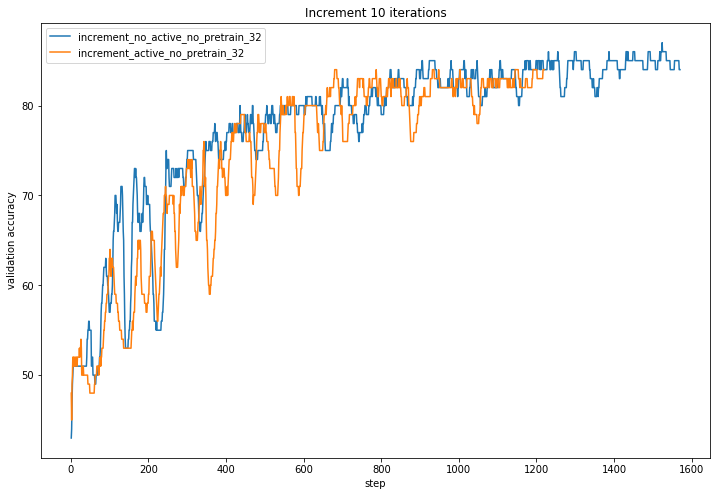

In [18]:
fig = plt.figure(figsize= (12,8))
plt.plot(increment_no_active_no_pretrain_32[:,2],increment_no_active_no_pretrain_32[:,-1],label = "increment_no_active_no_pretrain_32")
plt.plot(increment_active_no_pretrain_32[:,2],increment_active_no_pretrain_32[:,-1],label = "increment_active_no_pretrain_32")

# plt.plot(32*increment_no_active_pretrained_32[:,0],increment_no_active_pretrained_32[:,-1],label = "increment_no_active_pretrained_32")
# plt.plot(32*increment_no_active_pretrained_freeze_32[:,0],increment_no_active_pretrained_freeze_32[:,-1],label = "increment_no_active_pretrained_freeze_32")
# plt.plot(32*increment_no_active_no_pretrain_freeze_32[:,0],increment_no_active_no_pretrain_freeze_32[:,-1],label = "increment_no_active_no_pretrain_freeze_32")

plt.title("Increment 10 iterations")
plt.xlabel("step")
plt.ylabel("validation accuracy")
plt.legend()

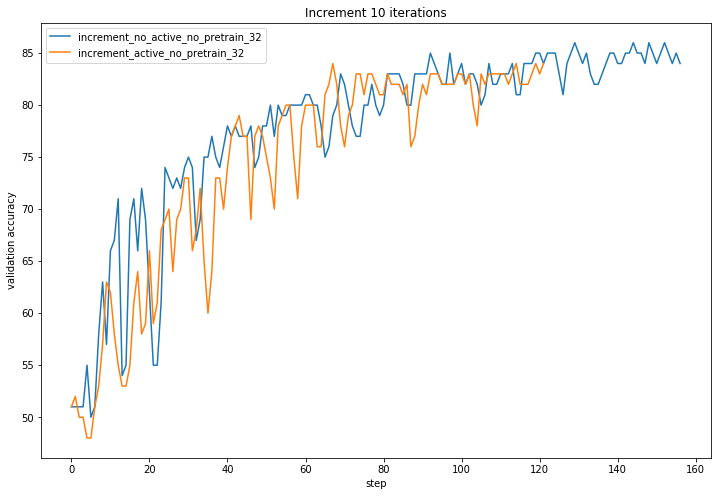

In [24]:
increment_no_active_no_pretrain_32_10 = increment_no_active_no_pretrain_32.reshape((157,10,5))
increment_active_no_pretrain_32_10 = increment_active_no_pretrain_32.reshape((122,10,5))
fig = plt.figure(figsize= (12,8))
plt.plot(increment_no_active_no_pretrain_32_10[:,-1,0],increment_no_active_no_pretrain_32_10[:,-1,-1],label = "increment_no_active_no_pretrain_32")
plt.plot(increment_active_no_pretrain_32_10[:,-1,0],increment_active_no_pretrain_32_10[:,-1,-1],label = "increment_active_no_pretrain_32")
plt.title("Increment 10 iterations")
plt.xlabel("step")
plt.ylabel("validation accuracy")
plt.legend()

In [8]:
# Fasttext with batch size of 10
batch_size = 10
emb_dim =300
learning_rate = 0.001
n_iter = 1

train_loader = batchify(train_data,vocab,batch_size)
test_loader = batchify(test_data,vocab,batch_size)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText(vocab_size, emb_dim).cuda()
increment_no_active_no_pretrain_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
increment_no_active_pretrained_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
increment_no_active_pretrained_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,True))
increment_no_active_no_pretrain_freeze_32 = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,True))


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  10
<generator object Module.parameters at 0x7fbeb632cfc0>
Time:[0 seconds], batch: [0/500], Epoch: [1/1], step: [1/500], Loss: 0.7041229009628296,Acc:47
Time:[0 seconds], batch: [1/500], Epoch: [1/1], step: [2/500], Loss: 0.7334005832672119,Acc:45
Time:[0 seconds], batch: [2/500], Epoch: [1/1], step: [3/500], Loss: 0.6934401392936707,Acc:44
Time:[0 seconds], batch: [3/500], Epoch: [1/1], step: [4/500], Loss: 0.7015026807785034,Acc:45
Time:[0 seconds], batch: [4/500], Epoch: [1/1], step: [5/500], Loss: 0.6790949106216431,Acc:46
Time:[0 seconds], batch: [5/500], Epoch: [1/1], step: [6/500], Loss: 0.6775133013725281,Acc:46
Time:[0 seconds], batch: [6/500], Epoch: [1/1], step: [7/500], Loss: 0.6865747570991516,Acc:46
Time:[0 seconds], batch: [7/500], Epoch: [1/1], step: [8/500], Loss: 0.6971203088760376,Acc:48
Time:[0 seconds], batch: [8/500], Ep

Time:[0 seconds], batch: [95/500], Epoch: [1/1], step: [96/500], Loss: 0.6684083342552185,Acc:59
Time:[0 seconds], batch: [96/500], Epoch: [1/1], step: [97/500], Loss: 0.6602823138237,Acc:59
Time:[0 seconds], batch: [97/500], Epoch: [1/1], step: [98/500], Loss: 0.6975986957550049,Acc:60
Time:[1 seconds], batch: [98/500], Epoch: [1/1], step: [99/500], Loss: 0.6524518132209778,Acc:60
Time:[1 seconds], batch: [99/500], Epoch: [1/1], step: [100/500], Loss: 0.6822304725646973,Acc:61
Time:[1 seconds], batch: [100/500], Epoch: [1/1], step: [101/500], Loss: 0.6802915930747986,Acc:62
Time:[1 seconds], batch: [101/500], Epoch: [1/1], step: [102/500], Loss: 0.6785586476325989,Acc:61
Time:[1 seconds], batch: [102/500], Epoch: [1/1], step: [103/500], Loss: 0.7100960612297058,Acc:63
Time:[1 seconds], batch: [103/500], Epoch: [1/1], step: [104/500], Loss: 0.6885443329811096,Acc:63
Time:[1 seconds], batch: [104/500], Epoch: [1/1], step: [105/500], Loss: 0.68438720703125,Acc:66
Time:[1 seconds], batch:

Time:[1 seconds], batch: [178/500], Epoch: [1/1], step: [179/500], Loss: 0.661990761756897,Acc:67
Time:[1 seconds], batch: [179/500], Epoch: [1/1], step: [180/500], Loss: 0.6283377408981323,Acc:67
Time:[1 seconds], batch: [180/500], Epoch: [1/1], step: [181/500], Loss: 0.6267045140266418,Acc:66
Time:[1 seconds], batch: [181/500], Epoch: [1/1], step: [182/500], Loss: 0.7197757363319397,Acc:66
Time:[1 seconds], batch: [182/500], Epoch: [1/1], step: [183/500], Loss: 0.6375250220298767,Acc:66
Time:[1 seconds], batch: [183/500], Epoch: [1/1], step: [184/500], Loss: 0.6563637852668762,Acc:66
Time:[1 seconds], batch: [184/500], Epoch: [1/1], step: [185/500], Loss: 0.6172462105751038,Acc:65
Time:[1 seconds], batch: [185/500], Epoch: [1/1], step: [186/500], Loss: 0.6823334097862244,Acc:65
Time:[1 seconds], batch: [186/500], Epoch: [1/1], step: [187/500], Loss: 0.6619386672973633,Acc:66
Time:[1 seconds], batch: [187/500], Epoch: [1/1], step: [188/500], Loss: 0.6477051973342896,Acc:65
Time:[1 sec

Time:[2 seconds], batch: [261/500], Epoch: [1/1], step: [262/500], Loss: 0.6763948798179626,Acc:64
Time:[2 seconds], batch: [262/500], Epoch: [1/1], step: [263/500], Loss: 0.651833176612854,Acc:65
Time:[2 seconds], batch: [263/500], Epoch: [1/1], step: [264/500], Loss: 0.610699474811554,Acc:66
Time:[2 seconds], batch: [264/500], Epoch: [1/1], step: [265/500], Loss: 0.6881362199783325,Acc:67
Time:[2 seconds], batch: [265/500], Epoch: [1/1], step: [266/500], Loss: 0.651380717754364,Acc:68
Time:[2 seconds], batch: [266/500], Epoch: [1/1], step: [267/500], Loss: 0.621855616569519,Acc:69
Time:[2 seconds], batch: [267/500], Epoch: [1/1], step: [268/500], Loss: 0.62088543176651,Acc:69
Time:[2 seconds], batch: [268/500], Epoch: [1/1], step: [269/500], Loss: 0.5800665616989136,Acc:70
Time:[2 seconds], batch: [269/500], Epoch: [1/1], step: [270/500], Loss: 0.6615908741950989,Acc:70
Time:[2 seconds], batch: [270/500], Epoch: [1/1], step: [271/500], Loss: 0.6154828667640686,Acc:70
Time:[2 seconds]

Time:[3 seconds], batch: [344/500], Epoch: [1/1], step: [345/500], Loss: 0.5939563512802124,Acc:70
Time:[3 seconds], batch: [345/500], Epoch: [1/1], step: [346/500], Loss: 0.6419870853424072,Acc:70
Time:[3 seconds], batch: [346/500], Epoch: [1/1], step: [347/500], Loss: 0.5504802465438843,Acc:70
Time:[3 seconds], batch: [347/500], Epoch: [1/1], step: [348/500], Loss: 0.5423930287361145,Acc:70
Time:[3 seconds], batch: [348/500], Epoch: [1/1], step: [349/500], Loss: 0.6377682685852051,Acc:70
Time:[3 seconds], batch: [349/500], Epoch: [1/1], step: [350/500], Loss: 0.5986499190330505,Acc:70
Time:[3 seconds], batch: [350/500], Epoch: [1/1], step: [351/500], Loss: 0.6494832038879395,Acc:72
Time:[3 seconds], batch: [351/500], Epoch: [1/1], step: [352/500], Loss: 0.6656965017318726,Acc:71
Time:[3 seconds], batch: [352/500], Epoch: [1/1], step: [353/500], Loss: 0.6360113024711609,Acc:70
Time:[3 seconds], batch: [353/500], Epoch: [1/1], step: [354/500], Loss: 0.4844551086425781,Acc:70
Time:[3 se

Time:[4 seconds], batch: [427/500], Epoch: [1/1], step: [428/500], Loss: 0.5654969215393066,Acc:74
Time:[4 seconds], batch: [428/500], Epoch: [1/1], step: [429/500], Loss: 0.6225123405456543,Acc:74
Time:[4 seconds], batch: [429/500], Epoch: [1/1], step: [430/500], Loss: 0.5660842061042786,Acc:75
Time:[4 seconds], batch: [430/500], Epoch: [1/1], step: [431/500], Loss: 0.6124494671821594,Acc:75
Time:[4 seconds], batch: [431/500], Epoch: [1/1], step: [432/500], Loss: 0.49308210611343384,Acc:75
Time:[4 seconds], batch: [432/500], Epoch: [1/1], step: [433/500], Loss: 0.5775922536849976,Acc:75
Time:[4 seconds], batch: [433/500], Epoch: [1/1], step: [434/500], Loss: 0.5609813332557678,Acc:75
Time:[4 seconds], batch: [434/500], Epoch: [1/1], step: [435/500], Loss: 0.5853933095932007,Acc:75
Time:[4 seconds], batch: [435/500], Epoch: [1/1], step: [436/500], Loss: 0.5399640798568726,Acc:75
Time:[4 seconds], batch: [436/500], Epoch: [1/1], step: [437/500], Loss: 0.6053866147994995,Acc:75
Time:[4 s

Time:[0 seconds], batch: [27/500], Epoch: [1/1], step: [28/500], Loss: 0.7373350858688354,Acc:51
Time:[0 seconds], batch: [28/500], Epoch: [1/1], step: [29/500], Loss: 0.9035497903823853,Acc:51
Time:[0 seconds], batch: [29/500], Epoch: [1/1], step: [30/500], Loss: 0.7044057846069336,Acc:51
Time:[0 seconds], batch: [30/500], Epoch: [1/1], step: [31/500], Loss: 0.972831130027771,Acc:51
Time:[0 seconds], batch: [31/500], Epoch: [1/1], step: [32/500], Loss: 0.811794102191925,Acc:51
Time:[0 seconds], batch: [32/500], Epoch: [1/1], step: [33/500], Loss: 0.8334491848945618,Acc:51
Time:[0 seconds], batch: [33/500], Epoch: [1/1], step: [34/500], Loss: 0.9707207679748535,Acc:51
Time:[0 seconds], batch: [34/500], Epoch: [1/1], step: [35/500], Loss: 0.569787859916687,Acc:51
Time:[0 seconds], batch: [35/500], Epoch: [1/1], step: [36/500], Loss: 0.7001081705093384,Acc:51
Time:[0 seconds], batch: [36/500], Epoch: [1/1], step: [37/500], Loss: 0.7265648245811462,Acc:49
Time:[0 seconds], batch: [37/500]

Time:[1 seconds], batch: [132/500], Epoch: [1/1], step: [133/500], Loss: 0.6538253426551819,Acc:52
Time:[1 seconds], batch: [133/500], Epoch: [1/1], step: [134/500], Loss: 0.6127752065658569,Acc:52
Time:[1 seconds], batch: [134/500], Epoch: [1/1], step: [135/500], Loss: 0.809810996055603,Acc:52
Time:[1 seconds], batch: [135/500], Epoch: [1/1], step: [136/500], Loss: 0.6744758486747742,Acc:52
Time:[1 seconds], batch: [136/500], Epoch: [1/1], step: [137/500], Loss: 0.65544593334198,Acc:53
Time:[1 seconds], batch: [137/500], Epoch: [1/1], step: [138/500], Loss: 0.5860298275947571,Acc:53
Time:[1 seconds], batch: [138/500], Epoch: [1/1], step: [139/500], Loss: 1.1578497886657715,Acc:63
Time:[1 seconds], batch: [139/500], Epoch: [1/1], step: [140/500], Loss: 0.6719163656234741,Acc:55
Time:[1 seconds], batch: [140/500], Epoch: [1/1], step: [141/500], Loss: 0.7307525873184204,Acc:48
Time:[1 seconds], batch: [141/500], Epoch: [1/1], step: [142/500], Loss: 0.7146153450012207,Acc:48
Time:[1 secon

Time:[2 seconds], batch: [215/500], Epoch: [1/1], step: [216/500], Loss: 0.6628497242927551,Acc:71
Time:[2 seconds], batch: [216/500], Epoch: [1/1], step: [217/500], Loss: 0.6329773664474487,Acc:68
Time:[2 seconds], batch: [217/500], Epoch: [1/1], step: [218/500], Loss: 0.6472804546356201,Acc:65
Time:[2 seconds], batch: [218/500], Epoch: [1/1], step: [219/500], Loss: 0.6505417823791504,Acc:61
Time:[2 seconds], batch: [219/500], Epoch: [1/1], step: [220/500], Loss: 0.6261237263679504,Acc:60
Time:[2 seconds], batch: [220/500], Epoch: [1/1], step: [221/500], Loss: 0.6524406671524048,Acc:59
Time:[2 seconds], batch: [221/500], Epoch: [1/1], step: [222/500], Loss: 0.6479191780090332,Acc:57
Time:[2 seconds], batch: [222/500], Epoch: [1/1], step: [223/500], Loss: 0.7327795028686523,Acc:59
Time:[2 seconds], batch: [223/500], Epoch: [1/1], step: [224/500], Loss: 0.6691809892654419,Acc:60
Time:[2 seconds], batch: [224/500], Epoch: [1/1], step: [225/500], Loss: 0.6794365644454956,Acc:66
Time:[2 se

Time:[3 seconds], batch: [318/500], Epoch: [1/1], step: [319/500], Loss: 0.6651080846786499,Acc:60
Time:[3 seconds], batch: [319/500], Epoch: [1/1], step: [320/500], Loss: 0.6638494729995728,Acc:61
Time:[3 seconds], batch: [320/500], Epoch: [1/1], step: [321/500], Loss: 0.6706841588020325,Acc:65
Time:[3 seconds], batch: [321/500], Epoch: [1/1], step: [322/500], Loss: 0.6139363050460815,Acc:67
Time:[3 seconds], batch: [322/500], Epoch: [1/1], step: [323/500], Loss: 0.5980353951454163,Acc:70
Time:[3 seconds], batch: [323/500], Epoch: [1/1], step: [324/500], Loss: 0.6026393175125122,Acc:71
Time:[3 seconds], batch: [324/500], Epoch: [1/1], step: [325/500], Loss: 0.6480749845504761,Acc:73
Time:[3 seconds], batch: [325/500], Epoch: [1/1], step: [326/500], Loss: 0.5981211066246033,Acc:74
Time:[3 seconds], batch: [326/500], Epoch: [1/1], step: [327/500], Loss: 0.6464104056358337,Acc:74
Time:[3 seconds], batch: [327/500], Epoch: [1/1], step: [328/500], Loss: 0.6522232294082642,Acc:76
Time:[3 se

Time:[4 seconds], batch: [401/500], Epoch: [1/1], step: [402/500], Loss: 0.624768853187561,Acc:75
Time:[4 seconds], batch: [402/500], Epoch: [1/1], step: [403/500], Loss: 0.6306384801864624,Acc:75
Time:[4 seconds], batch: [403/500], Epoch: [1/1], step: [404/500], Loss: 0.599365770816803,Acc:75
Time:[4 seconds], batch: [404/500], Epoch: [1/1], step: [405/500], Loss: 0.5664314031600952,Acc:73
Time:[4 seconds], batch: [405/500], Epoch: [1/1], step: [406/500], Loss: 0.6482291221618652,Acc:74
Time:[4 seconds], batch: [406/500], Epoch: [1/1], step: [407/500], Loss: 0.6038812398910522,Acc:73
Time:[4 seconds], batch: [407/500], Epoch: [1/1], step: [408/500], Loss: 0.5519372820854187,Acc:73
Time:[4 seconds], batch: [408/500], Epoch: [1/1], step: [409/500], Loss: 0.5499453544616699,Acc:72
Time:[4 seconds], batch: [409/500], Epoch: [1/1], step: [410/500], Loss: 0.6269469857215881,Acc:72
Time:[4 seconds], batch: [410/500], Epoch: [1/1], step: [411/500], Loss: 0.6770445108413696,Acc:72
Time:[4 seco

Time:[0 seconds], batch: [0/500], Epoch: [1/1], step: [1/500], Loss: 0.6993942260742188,Acc:51
Time:[0 seconds], batch: [1/500], Epoch: [1/1], step: [2/500], Loss: 0.5288969874382019,Acc:51
Time:[0 seconds], batch: [2/500], Epoch: [1/1], step: [3/500], Loss: 0.7999833226203918,Acc:51
Time:[0 seconds], batch: [3/500], Epoch: [1/1], step: [4/500], Loss: 0.37089022994041443,Acc:51
Time:[0 seconds], batch: [4/500], Epoch: [1/1], step: [5/500], Loss: 0.7869764566421509,Acc:51
Time:[0 seconds], batch: [5/500], Epoch: [1/1], step: [6/500], Loss: 0.8683664202690125,Acc:51
Time:[0 seconds], batch: [6/500], Epoch: [1/1], step: [7/500], Loss: 0.7539904117584229,Acc:51
Time:[0 seconds], batch: [7/500], Epoch: [1/1], step: [8/500], Loss: 0.8557888269424438,Acc:51
Time:[0 seconds], batch: [8/500], Epoch: [1/1], step: [9/500], Loss: 1.1034092903137207,Acc:51
Time:[0 seconds], batch: [9/500], Epoch: [1/1], step: [10/500], Loss: 0.5733586549758911,Acc:51
Time:[0 seconds], batch: [10/500], Epoch: [1/1],

Time:[0 seconds], batch: [88/500], Epoch: [1/1], step: [89/500], Loss: 0.6555950045585632,Acc:42
Time:[0 seconds], batch: [89/500], Epoch: [1/1], step: [90/500], Loss: 0.7131541967391968,Acc:41
Time:[0 seconds], batch: [90/500], Epoch: [1/1], step: [91/500], Loss: 0.7077988386154175,Acc:40
Time:[0 seconds], batch: [91/500], Epoch: [1/1], step: [92/500], Loss: 0.6280843019485474,Acc:42
Time:[0 seconds], batch: [92/500], Epoch: [1/1], step: [93/500], Loss: 0.7298184037208557,Acc:41
Time:[0 seconds], batch: [93/500], Epoch: [1/1], step: [94/500], Loss: 0.6955805420875549,Acc:41
Time:[0 seconds], batch: [94/500], Epoch: [1/1], step: [95/500], Loss: 0.7046343684196472,Acc:44
Time:[0 seconds], batch: [95/500], Epoch: [1/1], step: [96/500], Loss: 0.7714892625808716,Acc:46
Time:[0 seconds], batch: [96/500], Epoch: [1/1], step: [97/500], Loss: 0.6807724237442017,Acc:47
Time:[0 seconds], batch: [97/500], Epoch: [1/1], step: [98/500], Loss: 0.7062415480613708,Acc:52
Time:[0 seconds], batch: [98/5

Time:[1 seconds], batch: [176/500], Epoch: [1/1], step: [177/500], Loss: 0.9020657539367676,Acc:44
Time:[1 seconds], batch: [177/500], Epoch: [1/1], step: [178/500], Loss: 0.6778168678283691,Acc:45
Time:[1 seconds], batch: [178/500], Epoch: [1/1], step: [179/500], Loss: 0.696243166923523,Acc:51
Time:[1 seconds], batch: [179/500], Epoch: [1/1], step: [180/500], Loss: 0.6696032285690308,Acc:51
Time:[1 seconds], batch: [180/500], Epoch: [1/1], step: [181/500], Loss: 0.6299055814743042,Acc:51
Time:[1 seconds], batch: [181/500], Epoch: [1/1], step: [182/500], Loss: 0.7613123655319214,Acc:51
Time:[1 seconds], batch: [182/500], Epoch: [1/1], step: [183/500], Loss: 0.6925205588340759,Acc:51
Time:[1 seconds], batch: [183/500], Epoch: [1/1], step: [184/500], Loss: 0.6825838685035706,Acc:51
Time:[1 seconds], batch: [184/500], Epoch: [1/1], step: [185/500], Loss: 0.6476231813430786,Acc:51
Time:[1 seconds], batch: [185/500], Epoch: [1/1], step: [186/500], Loss: 0.767194926738739,Acc:51
Time:[1 seco

Time:[2 seconds], batch: [265/500], Epoch: [1/1], step: [266/500], Loss: 0.6845826506614685,Acc:50
Time:[2 seconds], batch: [266/500], Epoch: [1/1], step: [267/500], Loss: 0.69312584400177,Acc:52
Time:[2 seconds], batch: [267/500], Epoch: [1/1], step: [268/500], Loss: 0.6780104637145996,Acc:51
Time:[2 seconds], batch: [268/500], Epoch: [1/1], step: [269/500], Loss: 0.7224026918411255,Acc:52
Time:[2 seconds], batch: [269/500], Epoch: [1/1], step: [270/500], Loss: 0.7184678912162781,Acc:52
Time:[2 seconds], batch: [270/500], Epoch: [1/1], step: [271/500], Loss: 0.687663197517395,Acc:52
Time:[2 seconds], batch: [271/500], Epoch: [1/1], step: [272/500], Loss: 0.7648235559463501,Acc:51
Time:[2 seconds], batch: [272/500], Epoch: [1/1], step: [273/500], Loss: 0.7070342302322388,Acc:51
Time:[2 seconds], batch: [273/500], Epoch: [1/1], step: [274/500], Loss: 0.7088545560836792,Acc:51
Time:[2 seconds], batch: [274/500], Epoch: [1/1], step: [275/500], Loss: 0.6748288869857788,Acc:50
Time:[2 secon

Time:[3 seconds], batch: [354/500], Epoch: [1/1], step: [355/500], Loss: 0.7695355415344238,Acc:53
Time:[3 seconds], batch: [355/500], Epoch: [1/1], step: [356/500], Loss: 0.6952503323554993,Acc:53
Time:[3 seconds], batch: [356/500], Epoch: [1/1], step: [357/500], Loss: 0.7052954435348511,Acc:53
Time:[3 seconds], batch: [357/500], Epoch: [1/1], step: [358/500], Loss: 0.6869336366653442,Acc:53
Time:[3 seconds], batch: [358/500], Epoch: [1/1], step: [359/500], Loss: 0.7014578580856323,Acc:53
Time:[3 seconds], batch: [359/500], Epoch: [1/1], step: [360/500], Loss: 0.6437863707542419,Acc:53
Time:[3 seconds], batch: [360/500], Epoch: [1/1], step: [361/500], Loss: 0.7013307809829712,Acc:53
Time:[3 seconds], batch: [361/500], Epoch: [1/1], step: [362/500], Loss: 0.6865671277046204,Acc:53
Time:[3 seconds], batch: [362/500], Epoch: [1/1], step: [363/500], Loss: 0.6991487741470337,Acc:53
Time:[3 seconds], batch: [363/500], Epoch: [1/1], step: [364/500], Loss: 0.6675315499305725,Acc:54
Time:[3 se

Time:[4 seconds], batch: [443/500], Epoch: [1/1], step: [444/500], Loss: 0.661790668964386,Acc:51
Time:[4 seconds], batch: [444/500], Epoch: [1/1], step: [445/500], Loss: 0.6901586651802063,Acc:49
Time:[4 seconds], batch: [445/500], Epoch: [1/1], step: [446/500], Loss: 0.691856861114502,Acc:45
Time:[4 seconds], batch: [446/500], Epoch: [1/1], step: [447/500], Loss: 0.6973015666007996,Acc:46
Time:[4 seconds], batch: [447/500], Epoch: [1/1], step: [448/500], Loss: 0.6972779035568237,Acc:47
Time:[4 seconds], batch: [448/500], Epoch: [1/1], step: [449/500], Loss: 0.6910489797592163,Acc:45
Time:[4 seconds], batch: [449/500], Epoch: [1/1], step: [450/500], Loss: 0.6905186176300049,Acc:45
Time:[4 seconds], batch: [450/500], Epoch: [1/1], step: [451/500], Loss: 0.6797245740890503,Acc:45
Time:[4 seconds], batch: [451/500], Epoch: [1/1], step: [452/500], Loss: 0.6900799870491028,Acc:45
Time:[4 seconds], batch: [452/500], Epoch: [1/1], step: [453/500], Loss: 0.6813775300979614,Acc:45
Time:[4 seco

Time:[0 seconds], batch: [31/500], Epoch: [1/1], step: [32/500], Loss: 0.8062564730644226,Acc:53
Time:[0 seconds], batch: [32/500], Epoch: [1/1], step: [33/500], Loss: 0.8535813093185425,Acc:52
Time:[0 seconds], batch: [33/500], Epoch: [1/1], step: [34/500], Loss: 1.0902988910675049,Acc:52
Time:[0 seconds], batch: [34/500], Epoch: [1/1], step: [35/500], Loss: 0.5819761753082275,Acc:53
Time:[0 seconds], batch: [35/500], Epoch: [1/1], step: [36/500], Loss: 0.7117282152175903,Acc:54
Time:[0 seconds], batch: [36/500], Epoch: [1/1], step: [37/500], Loss: 0.7817547917366028,Acc:52
Time:[0 seconds], batch: [37/500], Epoch: [1/1], step: [38/500], Loss: 0.6355801224708557,Acc:51
Time:[0 seconds], batch: [38/500], Epoch: [1/1], step: [39/500], Loss: 0.7151315808296204,Acc:46
Time:[0 seconds], batch: [39/500], Epoch: [1/1], step: [40/500], Loss: 0.6534376740455627,Acc:44
Time:[0 seconds], batch: [40/500], Epoch: [1/1], step: [41/500], Loss: 0.773921012878418,Acc:45
Time:[0 seconds], batch: [41/50

Time:[1 seconds], batch: [119/500], Epoch: [1/1], step: [120/500], Loss: 0.6793173551559448,Acc:54
Time:[1 seconds], batch: [120/500], Epoch: [1/1], step: [121/500], Loss: 0.6667774319648743,Acc:53
Time:[1 seconds], batch: [121/500], Epoch: [1/1], step: [122/500], Loss: 0.7955802083015442,Acc:53
Time:[1 seconds], batch: [122/500], Epoch: [1/1], step: [123/500], Loss: 0.6729725003242493,Acc:53
Time:[1 seconds], batch: [123/500], Epoch: [1/1], step: [124/500], Loss: 0.6916395425796509,Acc:53
Time:[1 seconds], batch: [124/500], Epoch: [1/1], step: [125/500], Loss: 0.7155073881149292,Acc:53
Time:[1 seconds], batch: [125/500], Epoch: [1/1], step: [126/500], Loss: 0.6165927052497864,Acc:54
Time:[1 seconds], batch: [126/500], Epoch: [1/1], step: [127/500], Loss: 0.6872434616088867,Acc:54
Time:[1 seconds], batch: [127/500], Epoch: [1/1], step: [128/500], Loss: 0.668441116809845,Acc:54
Time:[1 seconds], batch: [128/500], Epoch: [1/1], step: [129/500], Loss: 0.6690448522567749,Acc:53
Time:[1 sec

Time:[1 seconds], batch: [208/500], Epoch: [1/1], step: [209/500], Loss: 0.7194225788116455,Acc:53
Time:[1 seconds], batch: [209/500], Epoch: [1/1], step: [210/500], Loss: 0.7763758897781372,Acc:53
Time:[1 seconds], batch: [210/500], Epoch: [1/1], step: [211/500], Loss: 0.8507830500602722,Acc:53
Time:[1 seconds], batch: [211/500], Epoch: [1/1], step: [212/500], Loss: 0.8085670471191406,Acc:54
Time:[1 seconds], batch: [212/500], Epoch: [1/1], step: [213/500], Loss: 0.6746634244918823,Acc:56
Time:[1 seconds], batch: [213/500], Epoch: [1/1], step: [214/500], Loss: 0.6639066934585571,Acc:54
Time:[1 seconds], batch: [214/500], Epoch: [1/1], step: [215/500], Loss: 0.7080620527267456,Acc:48
Time:[2 seconds], batch: [215/500], Epoch: [1/1], step: [216/500], Loss: 0.6900642514228821,Acc:48
Time:[2 seconds], batch: [216/500], Epoch: [1/1], step: [217/500], Loss: 0.6801782250404358,Acc:47
Time:[2 seconds], batch: [217/500], Epoch: [1/1], step: [218/500], Loss: 0.6798983812332153,Acc:47
Time:[2 se

Time:[2 seconds], batch: [296/500], Epoch: [1/1], step: [297/500], Loss: 0.698623538017273,Acc:48
Time:[2 seconds], batch: [297/500], Epoch: [1/1], step: [298/500], Loss: 0.7490484118461609,Acc:48
Time:[2 seconds], batch: [298/500], Epoch: [1/1], step: [299/500], Loss: 0.6988195180892944,Acc:48
Time:[2 seconds], batch: [299/500], Epoch: [1/1], step: [300/500], Loss: 0.6935439109802246,Acc:46
Time:[2 seconds], batch: [300/500], Epoch: [1/1], step: [301/500], Loss: 0.7042721509933472,Acc:55
Time:[2 seconds], batch: [301/500], Epoch: [1/1], step: [302/500], Loss: 0.6963211894035339,Acc:55
Time:[2 seconds], batch: [302/500], Epoch: [1/1], step: [303/500], Loss: 0.677271842956543,Acc:54
Time:[2 seconds], batch: [303/500], Epoch: [1/1], step: [304/500], Loss: 0.6935852766036987,Acc:53
Time:[2 seconds], batch: [304/500], Epoch: [1/1], step: [305/500], Loss: 0.6549487113952637,Acc:53
Time:[2 seconds], batch: [305/500], Epoch: [1/1], step: [306/500], Loss: 0.6802583932876587,Acc:53
Time:[2 seco

Time:[3 seconds], batch: [385/500], Epoch: [1/1], step: [386/500], Loss: 0.6537965536117554,Acc:56
Time:[3 seconds], batch: [386/500], Epoch: [1/1], step: [387/500], Loss: 0.6677849292755127,Acc:55
Time:[3 seconds], batch: [387/500], Epoch: [1/1], step: [388/500], Loss: 0.6671779155731201,Acc:54
Time:[3 seconds], batch: [388/500], Epoch: [1/1], step: [389/500], Loss: 0.7045173645019531,Acc:53
Time:[3 seconds], batch: [389/500], Epoch: [1/1], step: [390/500], Loss: 0.7477430105209351,Acc:53
Time:[3 seconds], batch: [390/500], Epoch: [1/1], step: [391/500], Loss: 0.7087832689285278,Acc:54
Time:[3 seconds], batch: [391/500], Epoch: [1/1], step: [392/500], Loss: 0.6784023642539978,Acc:54
Time:[3 seconds], batch: [392/500], Epoch: [1/1], step: [393/500], Loss: 0.6139189004898071,Acc:54
Time:[3 seconds], batch: [393/500], Epoch: [1/1], step: [394/500], Loss: 0.651270866394043,Acc:54
Time:[3 seconds], batch: [394/500], Epoch: [1/1], step: [395/500], Loss: 0.7630779147148132,Acc:54
Time:[3 sec

Time:[4 seconds], batch: [473/500], Epoch: [1/1], step: [474/500], Loss: 0.6895066499710083,Acc:56
Time:[4 seconds], batch: [474/500], Epoch: [1/1], step: [475/500], Loss: 0.7115739583969116,Acc:50
Time:[4 seconds], batch: [475/500], Epoch: [1/1], step: [476/500], Loss: 0.6793473362922668,Acc:49
Time:[4 seconds], batch: [476/500], Epoch: [1/1], step: [477/500], Loss: 0.6687110662460327,Acc:49
Time:[4 seconds], batch: [477/500], Epoch: [1/1], step: [478/500], Loss: 0.6600522398948669,Acc:48
Time:[4 seconds], batch: [478/500], Epoch: [1/1], step: [479/500], Loss: 0.6857775449752808,Acc:48
Time:[4 seconds], batch: [479/500], Epoch: [1/1], step: [480/500], Loss: 0.7594295144081116,Acc:48
Time:[4 seconds], batch: [480/500], Epoch: [1/1], step: [481/500], Loss: 0.6147695779800415,Acc:48
Time:[4 seconds], batch: [481/500], Epoch: [1/1], step: [482/500], Loss: 0.8693134188652039,Acc:48
Time:[4 seconds], batch: [482/500], Epoch: [1/1], step: [483/500], Loss: 0.6298004388809204,Acc:47
Time:[4 se

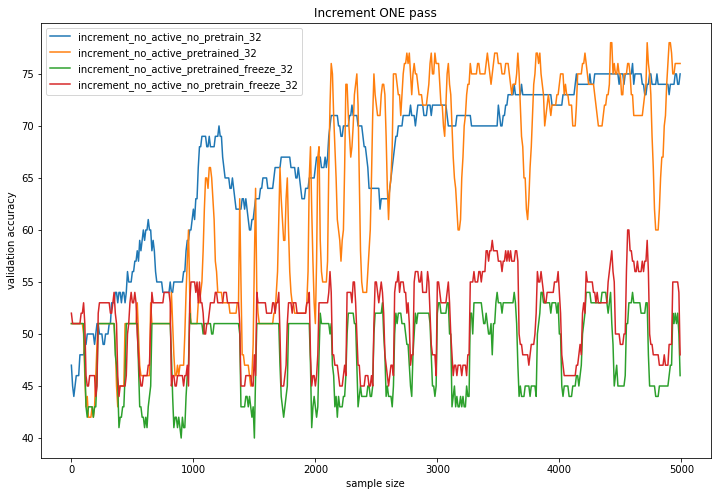

In [9]:
fig = plt.figure(figsize= (12,8))
plt.plot(10*increment_no_active_no_pretrain_32[:,0],increment_no_active_no_pretrain_32[:,-1],label = "increment_no_active_no_pretrain_32")
plt.plot(10*increment_no_active_pretrained_32[:,0],increment_no_active_pretrained_32[:,-1],label = "increment_no_active_pretrained_32")
plt.plot(10*increment_no_active_pretrained_freeze_32[:,0],increment_no_active_pretrained_freeze_32[:,-1],label = "increment_no_active_pretrained_freeze_32")
plt.plot(10*increment_no_active_no_pretrain_freeze_32[:,0],increment_no_active_no_pretrain_freeze_32[:,-1],label = "increment_no_active_no_pretrain_freeze_32")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

In [10]:
# Linear Layer
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 1

train_loader = batchify(train_data,vocab,batch_size)
test_loader = batchify(test_data,vocab,batch_size)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText_LR(vocab_size, emb_dim,hidden_size=100).cuda()
increment_no_active_no_pretrain_32_linear = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
increment_no_active_pretrained_32_linear = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
increment_no_active_pretrained_freeze_32_linear = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,True))
increment_no_active_no_pretrain_freeze_32_linear = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,True))


FastText Model with two linear layer
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7fbeb7756048>
Time:[0 seconds], batch: [0/156], Epoch: [1/1], step: [1/156], Loss: 0.6760596632957458,Acc:51
Time:[0 seconds], batch: [1/156], Epoch: [1/1], step: [2/156], Loss: 0.6806644201278687,Acc:51
Time:[0 seconds], batch: [2/156], Epoch: [1/1], step: [3/156], Loss: 0.7207404375076294,Acc:51
Time:[0 seconds], batch: [3/156], Epoch: [1/1], step: [4/156], Loss: 0.7123734951019287,Acc:51
Time:[0 seconds], batch: [4/156], Epoch: [1/1], step: [5/156], Loss: 0.6975370049476624,Acc:51
Time:[0 seconds], batch: [5/156], Epoch: [1/1], step: [6/156], Loss: 0.7321594953536987,Acc:52
Time:[0 seconds], batch: [6/156], Epoch: [1/1], step: [7/156], Loss: 0.6873888969421387,Acc:52
Time:[0 seconds], batch: [7/156], Epoch: [1/1], step: [8/156], Loss: 0.7000569105148315,Acc:51
Time:[0 second

Time:[0 seconds], batch: [84/156], Epoch: [1/1], step: [85/156], Loss: 0.562821626663208,Acc:75
Time:[0 seconds], batch: [85/156], Epoch: [1/1], step: [86/156], Loss: 0.5366561412811279,Acc:75
Time:[0 seconds], batch: [86/156], Epoch: [1/1], step: [87/156], Loss: 0.6396508812904358,Acc:75
Time:[0 seconds], batch: [87/156], Epoch: [1/1], step: [88/156], Loss: 0.6610384583473206,Acc:75
Time:[0 seconds], batch: [88/156], Epoch: [1/1], step: [89/156], Loss: 0.6176861524581909,Acc:75
Time:[0 seconds], batch: [89/156], Epoch: [1/1], step: [90/156], Loss: 0.6366384029388428,Acc:75
Time:[0 seconds], batch: [90/156], Epoch: [1/1], step: [91/156], Loss: 0.6693622469902039,Acc:75
Time:[0 seconds], batch: [91/156], Epoch: [1/1], step: [92/156], Loss: 0.563010573387146,Acc:75
Time:[0 seconds], batch: [92/156], Epoch: [1/1], step: [93/156], Loss: 0.491476833820343,Acc:75
Time:[0 seconds], batch: [93/156], Epoch: [1/1], step: [94/156], Loss: 0.5648900270462036,Acc:76
Time:[0 seconds], batch: [94/156]

Time:[0 seconds], batch: [23/156], Epoch: [1/1], step: [24/156], Loss: 0.6887557506561279,Acc:48
Time:[0 seconds], batch: [24/156], Epoch: [1/1], step: [25/156], Loss: 0.7491393089294434,Acc:48
Time:[0 seconds], batch: [25/156], Epoch: [1/1], step: [26/156], Loss: 4.512934684753418,Acc:47
Time:[0 seconds], batch: [26/156], Epoch: [1/1], step: [27/156], Loss: 0.810331404209137,Acc:55
Time:[0 seconds], batch: [27/156], Epoch: [1/1], step: [28/156], Loss: 0.8793131113052368,Acc:54
Time:[0 seconds], batch: [28/156], Epoch: [1/1], step: [29/156], Loss: 1.6661310195922852,Acc:54
Time:[0 seconds], batch: [29/156], Epoch: [1/1], step: [30/156], Loss: 1.1906192302703857,Acc:54
Time:[0 seconds], batch: [30/156], Epoch: [1/1], step: [31/156], Loss: 2.224513530731201,Acc:55
Time:[0 seconds], batch: [31/156], Epoch: [1/1], step: [32/156], Loss: 1.172010898590088,Acc:48
Time:[0 seconds], batch: [32/156], Epoch: [1/1], step: [33/156], Loss: 0.6903218030929565,Acc:48
Time:[0 seconds], batch: [33/156],

Time:[0 seconds], batch: [122/156], Epoch: [1/1], step: [123/156], Loss: 0.6509073972702026,Acc:57
Time:[0 seconds], batch: [123/156], Epoch: [1/1], step: [124/156], Loss: 1.3429853916168213,Acc:60
Time:[0 seconds], batch: [124/156], Epoch: [1/1], step: [125/156], Loss: 0.8892272710800171,Acc:67
Time:[0 seconds], batch: [125/156], Epoch: [1/1], step: [126/156], Loss: 0.7441340684890747,Acc:49
Time:[0 seconds], batch: [126/156], Epoch: [1/1], step: [127/156], Loss: 0.6602534055709839,Acc:48
Time:[0 seconds], batch: [127/156], Epoch: [1/1], step: [128/156], Loss: 0.7142307758331299,Acc:48
Time:[0 seconds], batch: [128/156], Epoch: [1/1], step: [129/156], Loss: 0.8896328806877136,Acc:48
Time:[0 seconds], batch: [129/156], Epoch: [1/1], step: [130/156], Loss: 1.0593515634536743,Acc:49
Time:[0 seconds], batch: [130/156], Epoch: [1/1], step: [131/156], Loss: 0.6346741318702698,Acc:49
Time:[0 seconds], batch: [131/156], Epoch: [1/1], step: [132/156], Loss: 2.0751442909240723,Acc:61
Time:[0 se

Time:[0 seconds], batch: [78/156], Epoch: [1/1], step: [79/156], Loss: 0.7142187356948853,Acc:52
Time:[0 seconds], batch: [79/156], Epoch: [1/1], step: [80/156], Loss: 0.7061574459075928,Acc:50
Time:[0 seconds], batch: [80/156], Epoch: [1/1], step: [81/156], Loss: 0.6902241110801697,Acc:48
Time:[0 seconds], batch: [81/156], Epoch: [1/1], step: [82/156], Loss: 0.7032133340835571,Acc:52
Time:[0 seconds], batch: [82/156], Epoch: [1/1], step: [83/156], Loss: 0.6894881725311279,Acc:56
Time:[0 seconds], batch: [83/156], Epoch: [1/1], step: [84/156], Loss: 0.7122151851654053,Acc:55
Time:[0 seconds], batch: [84/156], Epoch: [1/1], step: [85/156], Loss: 0.7996726632118225,Acc:55
Time:[0 seconds], batch: [85/156], Epoch: [1/1], step: [86/156], Loss: 0.7117812037467957,Acc:50
Time:[0 seconds], batch: [86/156], Epoch: [1/1], step: [87/156], Loss: 0.702690839767456,Acc:49
Time:[0 seconds], batch: [87/156], Epoch: [1/1], step: [88/156], Loss: 0.781641960144043,Acc:49
Time:[0 seconds], batch: [88/156

Time:[0 seconds], batch: [6/156], Epoch: [1/1], step: [7/156], Loss: 2.181168556213379,Acc:48
Time:[0 seconds], batch: [7/156], Epoch: [1/1], step: [8/156], Loss: 0.8796992897987366,Acc:56
Time:[0 seconds], batch: [8/156], Epoch: [1/1], step: [9/156], Loss: 0.8591489791870117,Acc:53
Time:[0 seconds], batch: [9/156], Epoch: [1/1], step: [10/156], Loss: 1.2892942428588867,Acc:53
Time:[0 seconds], batch: [10/156], Epoch: [1/1], step: [11/156], Loss: 1.9455891847610474,Acc:53
Time:[0 seconds], batch: [11/156], Epoch: [1/1], step: [12/156], Loss: 1.7504703998565674,Acc:54
Time:[0 seconds], batch: [12/156], Epoch: [1/1], step: [13/156], Loss: 1.962012529373169,Acc:55
Time:[0 seconds], batch: [13/156], Epoch: [1/1], step: [14/156], Loss: 0.6419986486434937,Acc:48
Time:[0 seconds], batch: [14/156], Epoch: [1/1], step: [15/156], Loss: 0.676215648651123,Acc:48
Time:[0 seconds], batch: [15/156], Epoch: [1/1], step: [16/156], Loss: 1.353027105331421,Acc:48
Time:[0 seconds], batch: [16/156], Epoch:

Time:[0 seconds], batch: [92/156], Epoch: [1/1], step: [93/156], Loss: 0.9189659953117371,Acc:48
Time:[0 seconds], batch: [93/156], Epoch: [1/1], step: [94/156], Loss: 1.9036983251571655,Acc:48
Time:[0 seconds], batch: [94/156], Epoch: [1/1], step: [95/156], Loss: 0.7064730525016785,Acc:48
Time:[0 seconds], batch: [95/156], Epoch: [1/1], step: [96/156], Loss: 0.7462618350982666,Acc:57
Time:[0 seconds], batch: [96/156], Epoch: [1/1], step: [97/156], Loss: 0.7015581727027893,Acc:57
Time:[0 seconds], batch: [97/156], Epoch: [1/1], step: [98/156], Loss: 0.7309318780899048,Acc:56
Time:[0 seconds], batch: [98/156], Epoch: [1/1], step: [99/156], Loss: 0.7385263442993164,Acc:56
Time:[0 seconds], batch: [99/156], Epoch: [1/1], step: [100/156], Loss: 0.7165554761886597,Acc:58
Time:[0 seconds], batch: [100/156], Epoch: [1/1], step: [101/156], Loss: 0.7072994112968445,Acc:48
Time:[0 seconds], batch: [101/156], Epoch: [1/1], step: [102/156], Loss: 0.6786031723022461,Acc:48
Time:[0 seconds], batch: 

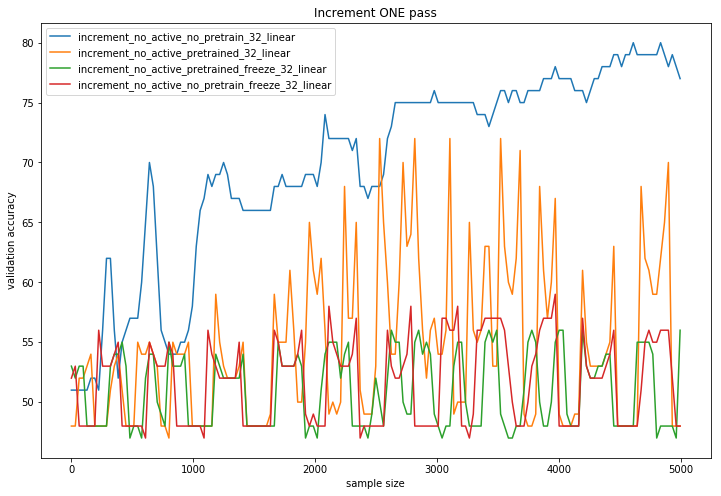

In [11]:
fig = plt.figure(figsize= (12,8))
plt.plot(32*increment_no_active_no_pretrain_32_linear[:,0],increment_no_active_no_pretrain_32_linear[:,-1],label = "increment_no_active_no_pretrain_32_linear")
plt.plot(32*increment_no_active_pretrained_32_linear[:,0],increment_no_active_pretrained_32_linear[:,-1],label = "increment_no_active_pretrained_32_linear")
plt.plot(32*increment_no_active_pretrained_freeze_32_linear[:,0],increment_no_active_pretrained_freeze_32_linear[:,-1],label = "increment_no_active_pretrained_freeze_32_linear")
plt.plot(32*increment_no_active_no_pretrain_freeze_32_linear[:,0],increment_no_active_no_pretrain_freeze_32_linear[:,-1],label = "increment_no_active_no_pretrain_freeze_32_linear")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

In [6]:
# LSTM
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = LSTM(vocab_size, emb_dim,50,batch_size,num_layers=1).cuda()
# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1)
increment_no_active_no_pretrain_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
# increment_no_active_pretrained_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
# increment_no_active_pretrained_freeze_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,True))
# increment_no_active_no_pretrain_freeze_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,True))


/usr/lib64/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM
No pretrained embedding
embedding weight is trainable
n_iter:  1
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
<generator object Module.parameters at 0x7f38c6d9fb48>
Time:[0 seconds], batch: [0/156], Epoch: [1/20], step: [1/3125], Loss: 0.6995776295661926,Acc:48
Time:[0 seconds], batch: [0/156], Epoch: [2/20], step: [2/3125], Loss: 0.7037020921707153,Acc:50
Time:[0 seconds], batch: [0/156], Epoch: [3/20], step: [3/3125], Loss: 0.6961879730224609,Acc:49
Time:[0 seconds], batch: [0/156], Epoch: [4/20], step: [4/3125], Loss: 0.6984701752662659,Acc:49
Time:[0 seconds], batch: [0/156], Epoch: [5/20], step: [5/3125], Loss: 0.6933051943778992,Acc:50
Time:[0 seconds], batch: [0/156], Epoch: [6/20], step: [6/3125], Loss: 0.6946215629577637,Acc:51
Time:[0 seconds], batch: [0/156], Epoch: [7/20], step: [7/3125], Loss: 0.6893646121025085,Acc:50
Time:[0 seconds], batch: [0/156], Epoch: [8/20], step: [8/3125], Loss: 0.6917327642440796,Acc:51
Time:[0 seconds], batch: [0/15

Time:[6 seconds], batch: [4/156], Epoch: [3/20], step: [83/3125], Loss: 0.6910003423690796,Acc:50
Time:[6 seconds], batch: [4/156], Epoch: [4/20], step: [84/3125], Loss: 0.6924746632575989,Acc:51
Time:[6 seconds], batch: [4/156], Epoch: [5/20], step: [85/3125], Loss: 0.6920002698898315,Acc:51
Time:[7 seconds], batch: [4/156], Epoch: [6/20], step: [86/3125], Loss: 0.6934659481048584,Acc:51
Time:[7 seconds], batch: [4/156], Epoch: [7/20], step: [87/3125], Loss: 0.6911005973815918,Acc:50
Time:[7 seconds], batch: [4/156], Epoch: [8/20], step: [88/3125], Loss: 0.6916331052780151,Acc:50
Time:[7 seconds], batch: [4/156], Epoch: [9/20], step: [89/3125], Loss: 0.6897055506706238,Acc:50
Time:[7 seconds], batch: [4/156], Epoch: [10/20], step: [90/3125], Loss: 0.689112663269043,Acc:50
Time:[7 seconds], batch: [4/156], Epoch: [11/20], step: [91/3125], Loss: 0.6940765380859375,Acc:50
Time:[7 seconds], batch: [4/156], Epoch: [12/20], step: [92/3125], Loss: 0.682195782661438,Acc:50
Time:[7 seconds], b

Time:[13 seconds], batch: [8/156], Epoch: [7/20], step: [167/3125], Loss: 0.6333217620849609,Acc:54
Time:[13 seconds], batch: [8/156], Epoch: [8/20], step: [168/3125], Loss: 0.6599195003509521,Acc:53
Time:[13 seconds], batch: [8/156], Epoch: [9/20], step: [169/3125], Loss: 0.7052438259124756,Acc:53
Time:[13 seconds], batch: [8/156], Epoch: [10/20], step: [170/3125], Loss: 0.6903736591339111,Acc:53
Time:[13 seconds], batch: [8/156], Epoch: [11/20], step: [171/3125], Loss: 0.6417186260223389,Acc:52
Time:[13 seconds], batch: [8/156], Epoch: [12/20], step: [172/3125], Loss: 0.6036622524261475,Acc:51
Time:[14 seconds], batch: [8/156], Epoch: [13/20], step: [173/3125], Loss: 0.6011730432510376,Acc:52
Time:[14 seconds], batch: [8/156], Epoch: [14/20], step: [174/3125], Loss: 0.5410152673721313,Acc:52
Time:[14 seconds], batch: [8/156], Epoch: [15/20], step: [175/3125], Loss: 0.5096163749694824,Acc:52
Time:[14 seconds], batch: [8/156], Epoch: [16/20], step: [176/3125], Loss: 0.5647445917129517,

Time:[20 seconds], batch: [12/156], Epoch: [11/20], step: [251/3125], Loss: 0.6172795295715332,Acc:50
Time:[20 seconds], batch: [12/156], Epoch: [12/20], step: [252/3125], Loss: 0.5452464818954468,Acc:50
Time:[20 seconds], batch: [12/156], Epoch: [13/20], step: [253/3125], Loss: 0.5966196060180664,Acc:50
Time:[20 seconds], batch: [12/156], Epoch: [14/20], step: [254/3125], Loss: 0.49459314346313477,Acc:50
Time:[20 seconds], batch: [12/156], Epoch: [15/20], step: [255/3125], Loss: 0.5234935879707336,Acc:49
Time:[20 seconds], batch: [12/156], Epoch: [16/20], step: [256/3125], Loss: 0.46194297075271606,Acc:49
Time:[20 seconds], batch: [12/156], Epoch: [17/20], step: [257/3125], Loss: 0.45950454473495483,Acc:49
Time:[20 seconds], batch: [12/156], Epoch: [18/20], step: [258/3125], Loss: 0.46651774644851685,Acc:49
Time:[21 seconds], batch: [12/156], Epoch: [19/20], step: [259/3125], Loss: 0.4665595591068268,Acc:49
Time:[21 seconds], batch: [12/156], Epoch: [20/20], step: [260/3125], Loss: 0.

Time:[27 seconds], batch: [16/156], Epoch: [12/20], step: [332/3125], Loss: 0.7200966477394104,Acc:51
Time:[27 seconds], batch: [16/156], Epoch: [13/20], step: [333/3125], Loss: 0.7350294589996338,Acc:51
Time:[27 seconds], batch: [16/156], Epoch: [14/20], step: [334/3125], Loss: 0.6641231775283813,Acc:51
Time:[27 seconds], batch: [16/156], Epoch: [15/20], step: [335/3125], Loss: 0.6906785368919373,Acc:51
Time:[27 seconds], batch: [16/156], Epoch: [16/20], step: [336/3125], Loss: 0.6713107824325562,Acc:52
Time:[27 seconds], batch: [16/156], Epoch: [17/20], step: [337/3125], Loss: 0.6568787693977356,Acc:52
Time:[27 seconds], batch: [16/156], Epoch: [18/20], step: [338/3125], Loss: 0.6365838050842285,Acc:52
Time:[28 seconds], batch: [16/156], Epoch: [19/20], step: [339/3125], Loss: 0.6365399360656738,Acc:52
Time:[28 seconds], batch: [16/156], Epoch: [20/20], step: [340/3125], Loss: 0.6564434170722961,Acc:53
Time:[28 seconds], batch: [17/156], Epoch: [1/20], step: [341/3125], Loss: 0.73769

Time:[34 seconds], batch: [20/156], Epoch: [13/20], step: [413/3125], Loss: 0.6564971208572388,Acc:51
Time:[34 seconds], batch: [20/156], Epoch: [14/20], step: [414/3125], Loss: 0.6304757595062256,Acc:50
Time:[34 seconds], batch: [20/156], Epoch: [15/20], step: [415/3125], Loss: 0.6201751232147217,Acc:50
Time:[34 seconds], batch: [20/156], Epoch: [16/20], step: [416/3125], Loss: 0.6734870672225952,Acc:50
Time:[34 seconds], batch: [20/156], Epoch: [17/20], step: [417/3125], Loss: 0.662290096282959,Acc:49
Time:[34 seconds], batch: [20/156], Epoch: [18/20], step: [418/3125], Loss: 0.6284458637237549,Acc:49
Time:[34 seconds], batch: [20/156], Epoch: [19/20], step: [419/3125], Loss: 0.6353728175163269,Acc:48
Time:[35 seconds], batch: [20/156], Epoch: [20/20], step: [420/3125], Loss: 0.6221944689750671,Acc:48
Time:[35 seconds], batch: [21/156], Epoch: [1/20], step: [421/3125], Loss: 0.6002323627471924,Acc:48
Time:[35 seconds], batch: [21/156], Epoch: [2/20], step: [422/3125], Loss: 0.6101308

Time:[41 seconds], batch: [24/156], Epoch: [14/20], step: [494/3125], Loss: 0.6767785549163818,Acc:50
Time:[41 seconds], batch: [24/156], Epoch: [15/20], step: [495/3125], Loss: 0.6625339388847351,Acc:50
Time:[41 seconds], batch: [24/156], Epoch: [16/20], step: [496/3125], Loss: 0.6420158743858337,Acc:50
Time:[41 seconds], batch: [24/156], Epoch: [17/20], step: [497/3125], Loss: 0.6039084792137146,Acc:49
Time:[41 seconds], batch: [24/156], Epoch: [18/20], step: [498/3125], Loss: 0.6275584697723389,Acc:49
Time:[41 seconds], batch: [24/156], Epoch: [19/20], step: [499/3125], Loss: 0.6214014291763306,Acc:49
Time:[41 seconds], batch: [24/156], Epoch: [20/20], step: [500/3125], Loss: 0.6113066077232361,Acc:49
Time:[41 seconds], batch: [25/156], Epoch: [1/20], step: [501/3125], Loss: 0.7059486508369446,Acc:49
Time:[41 seconds], batch: [25/156], Epoch: [2/20], step: [502/3125], Loss: 0.7081736326217651,Acc:48
Time:[41 seconds], batch: [25/156], Epoch: [3/20], step: [503/3125], Loss: 0.7163459

Time:[47 seconds], batch: [28/156], Epoch: [15/20], step: [575/3125], Loss: 0.5639082193374634,Acc:48
Time:[47 seconds], batch: [28/156], Epoch: [16/20], step: [576/3125], Loss: 0.5729748010635376,Acc:48
Time:[47 seconds], batch: [28/156], Epoch: [17/20], step: [577/3125], Loss: 0.554882287979126,Acc:48
Time:[47 seconds], batch: [28/156], Epoch: [18/20], step: [578/3125], Loss: 0.5530532002449036,Acc:47
Time:[47 seconds], batch: [28/156], Epoch: [19/20], step: [579/3125], Loss: 0.5023744702339172,Acc:47
Time:[48 seconds], batch: [28/156], Epoch: [20/20], step: [580/3125], Loss: 0.48907172679901123,Acc:47
Time:[48 seconds], batch: [29/156], Epoch: [1/20], step: [581/3125], Loss: 0.7408095002174377,Acc:47
Time:[48 seconds], batch: [29/156], Epoch: [2/20], step: [582/3125], Loss: 0.7348105907440186,Acc:47
Time:[48 seconds], batch: [29/156], Epoch: [3/20], step: [583/3125], Loss: 0.7209678888320923,Acc:47
Time:[48 seconds], batch: [29/156], Epoch: [4/20], step: [584/3125], Loss: 0.68325692

Time:[54 seconds], batch: [32/156], Epoch: [16/20], step: [656/3125], Loss: 0.4336814880371094,Acc:49
Time:[54 seconds], batch: [32/156], Epoch: [17/20], step: [657/3125], Loss: 0.42505162954330444,Acc:49
Time:[54 seconds], batch: [32/156], Epoch: [18/20], step: [658/3125], Loss: 0.41736292839050293,Acc:49
Time:[54 seconds], batch: [32/156], Epoch: [19/20], step: [659/3125], Loss: 0.408078670501709,Acc:49
Time:[54 seconds], batch: [32/156], Epoch: [20/20], step: [660/3125], Loss: 0.4040576219558716,Acc:49
Time:[55 seconds], batch: [33/156], Epoch: [1/20], step: [661/3125], Loss: 0.7015197277069092,Acc:48
Time:[55 seconds], batch: [33/156], Epoch: [2/20], step: [662/3125], Loss: 0.7378273010253906,Acc:48
Time:[55 seconds], batch: [33/156], Epoch: [3/20], step: [663/3125], Loss: 0.7214647531509399,Acc:48
Time:[55 seconds], batch: [33/156], Epoch: [4/20], step: [664/3125], Loss: 0.70682692527771,Acc:48
Time:[55 seconds], batch: [33/156], Epoch: [5/20], step: [665/3125], Loss: 0.7004668116

Time:[61 seconds], batch: [36/156], Epoch: [17/20], step: [737/3125], Loss: 0.7070097923278809,Acc:53
Time:[61 seconds], batch: [36/156], Epoch: [18/20], step: [738/3125], Loss: 0.5900378227233887,Acc:53
Time:[61 seconds], batch: [36/156], Epoch: [19/20], step: [739/3125], Loss: 0.618578314781189,Acc:53
Time:[61 seconds], batch: [36/156], Epoch: [20/20], step: [740/3125], Loss: 0.6573433876037598,Acc:53
Time:[62 seconds], batch: [37/156], Epoch: [1/20], step: [741/3125], Loss: 0.7376068234443665,Acc:53
Time:[62 seconds], batch: [37/156], Epoch: [2/20], step: [742/3125], Loss: 0.7196719646453857,Acc:52
Time:[62 seconds], batch: [37/156], Epoch: [3/20], step: [743/3125], Loss: 0.7886228561401367,Acc:52
Time:[62 seconds], batch: [37/156], Epoch: [4/20], step: [744/3125], Loss: 0.6754611730575562,Acc:52
Time:[62 seconds], batch: [37/156], Epoch: [5/20], step: [745/3125], Loss: 0.8002297282218933,Acc:52
Time:[62 seconds], batch: [37/156], Epoch: [6/20], step: [746/3125], Loss: 0.78158235549

Time:[68 seconds], batch: [40/156], Epoch: [18/20], step: [818/3125], Loss: 0.5620057582855225,Acc:54
Time:[68 seconds], batch: [40/156], Epoch: [19/20], step: [819/3125], Loss: 0.5829541087150574,Acc:54
Time:[68 seconds], batch: [40/156], Epoch: [20/20], step: [820/3125], Loss: 0.542568027973175,Acc:54
Time:[68 seconds], batch: [41/156], Epoch: [1/20], step: [821/3125], Loss: 0.7751201391220093,Acc:54
Time:[68 seconds], batch: [41/156], Epoch: [2/20], step: [822/3125], Loss: 0.7393656969070435,Acc:55
Time:[68 seconds], batch: [41/156], Epoch: [3/20], step: [823/3125], Loss: 0.7733591794967651,Acc:55
Time:[68 seconds], batch: [41/156], Epoch: [4/20], step: [824/3125], Loss: 0.6645214557647705,Acc:55
Time:[69 seconds], batch: [41/156], Epoch: [5/20], step: [825/3125], Loss: 0.7494928240776062,Acc:55
Time:[69 seconds], batch: [41/156], Epoch: [6/20], step: [826/3125], Loss: 0.7012732028961182,Acc:55
Time:[69 seconds], batch: [41/156], Epoch: [7/20], step: [827/3125], Loss: 0.715907037258

Time:[75 seconds], batch: [44/156], Epoch: [19/20], step: [899/3125], Loss: 0.5966641902923584,Acc:54
Time:[75 seconds], batch: [44/156], Epoch: [20/20], step: [900/3125], Loss: 0.5945783853530884,Acc:54
Time:[75 seconds], batch: [45/156], Epoch: [1/20], step: [901/3125], Loss: 0.7608916759490967,Acc:53
Time:[75 seconds], batch: [45/156], Epoch: [2/20], step: [902/3125], Loss: 0.7491874694824219,Acc:53
Time:[75 seconds], batch: [45/156], Epoch: [3/20], step: [903/3125], Loss: 0.8190003633499146,Acc:53
Time:[76 seconds], batch: [45/156], Epoch: [4/20], step: [904/3125], Loss: 0.7447962760925293,Acc:53
Time:[76 seconds], batch: [45/156], Epoch: [5/20], step: [905/3125], Loss: 0.7381916046142578,Acc:53
Time:[76 seconds], batch: [45/156], Epoch: [6/20], step: [906/3125], Loss: 0.7126860618591309,Acc:53
Time:[76 seconds], batch: [45/156], Epoch: [7/20], step: [907/3125], Loss: 0.7182747721672058,Acc:53
Time:[76 seconds], batch: [45/156], Epoch: [8/20], step: [908/3125], Loss: 0.708016514778

Time:[82 seconds], batch: [48/156], Epoch: [20/20], step: [980/3125], Loss: 0.5711716413497925,Acc:50
Time:[82 seconds], batch: [49/156], Epoch: [1/20], step: [981/3125], Loss: 0.6157435774803162,Acc:50
Time:[82 seconds], batch: [49/156], Epoch: [2/20], step: [982/3125], Loss: 0.6661909818649292,Acc:50
Time:[82 seconds], batch: [49/156], Epoch: [3/20], step: [983/3125], Loss: 0.6537295579910278,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [4/20], step: [984/3125], Loss: 0.6506410241127014,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [5/20], step: [985/3125], Loss: 0.6468212604522705,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [6/20], step: [986/3125], Loss: 0.6232714653015137,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [7/20], step: [987/3125], Loss: 0.6215505599975586,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [8/20], step: [988/3125], Loss: 0.6488255858421326,Acc:50
Time:[83 seconds], batch: [49/156], Epoch: [9/20], step: [989/3125], Loss: 0.6071903109550

Time:[89 seconds], batch: [53/156], Epoch: [1/20], step: [1061/3125], Loss: 0.8060355186462402,Acc:46
Time:[89 seconds], batch: [53/156], Epoch: [2/20], step: [1062/3125], Loss: 0.7649644613265991,Acc:46
Time:[89 seconds], batch: [53/156], Epoch: [3/20], step: [1063/3125], Loss: 0.7372213006019592,Acc:46
Time:[89 seconds], batch: [53/156], Epoch: [4/20], step: [1064/3125], Loss: 0.7850455641746521,Acc:46
Time:[90 seconds], batch: [53/156], Epoch: [5/20], step: [1065/3125], Loss: 0.813435435295105,Acc:46
Time:[90 seconds], batch: [53/156], Epoch: [6/20], step: [1066/3125], Loss: 0.7903276085853577,Acc:46
Time:[90 seconds], batch: [53/156], Epoch: [7/20], step: [1067/3125], Loss: 0.7332391738891602,Acc:46
Time:[90 seconds], batch: [53/156], Epoch: [8/20], step: [1068/3125], Loss: 0.7437092065811157,Acc:47
Time:[90 seconds], batch: [53/156], Epoch: [9/20], step: [1069/3125], Loss: 0.6811593770980835,Acc:46
Time:[90 seconds], batch: [53/156], Epoch: [10/20], step: [1070/3125], Loss: 0.6398

Time:[96 seconds], batch: [57/156], Epoch: [2/20], step: [1142/3125], Loss: 0.6900805234909058,Acc:50
Time:[96 seconds], batch: [57/156], Epoch: [3/20], step: [1143/3125], Loss: 0.6949818134307861,Acc:50
Time:[96 seconds], batch: [57/156], Epoch: [4/20], step: [1144/3125], Loss: 0.6898175477981567,Acc:50
Time:[96 seconds], batch: [57/156], Epoch: [5/20], step: [1145/3125], Loss: 0.7035027742385864,Acc:50
Time:[96 seconds], batch: [57/156], Epoch: [6/20], step: [1146/3125], Loss: 0.7124837040901184,Acc:51
Time:[97 seconds], batch: [57/156], Epoch: [7/20], step: [1147/3125], Loss: 0.6596856713294983,Acc:50
Time:[97 seconds], batch: [57/156], Epoch: [8/20], step: [1148/3125], Loss: 0.6366013288497925,Acc:50
Time:[97 seconds], batch: [57/156], Epoch: [9/20], step: [1149/3125], Loss: 0.6551596522331238,Acc:50
Time:[97 seconds], batch: [57/156], Epoch: [10/20], step: [1150/3125], Loss: 0.6312438249588013,Acc:51
Time:[97 seconds], batch: [57/156], Epoch: [11/20], step: [1151/3125], Loss: 0.63

Time:[103 seconds], batch: [61/156], Epoch: [3/20], step: [1223/3125], Loss: 0.6939823627471924,Acc:49
Time:[103 seconds], batch: [61/156], Epoch: [4/20], step: [1224/3125], Loss: 0.6029791235923767,Acc:49
Time:[103 seconds], batch: [61/156], Epoch: [5/20], step: [1225/3125], Loss: 0.678824782371521,Acc:49
Time:[103 seconds], batch: [61/156], Epoch: [6/20], step: [1226/3125], Loss: 0.6142105460166931,Acc:49
Time:[103 seconds], batch: [61/156], Epoch: [7/20], step: [1227/3125], Loss: 0.6553096771240234,Acc:49
Time:[103 seconds], batch: [61/156], Epoch: [8/20], step: [1228/3125], Loss: 0.6596159934997559,Acc:50
Time:[103 seconds], batch: [61/156], Epoch: [9/20], step: [1229/3125], Loss: 0.6518099308013916,Acc:50
Time:[103 seconds], batch: [61/156], Epoch: [10/20], step: [1230/3125], Loss: 0.6009619235992432,Acc:50
Time:[103 seconds], batch: [61/156], Epoch: [11/20], step: [1231/3125], Loss: 0.5832892656326294,Acc:50
Time:[104 seconds], batch: [61/156], Epoch: [12/20], step: [1232/3125], 

Time:[109 seconds], batch: [65/156], Epoch: [4/20], step: [1304/3125], Loss: 0.7025043964385986,Acc:51
Time:[109 seconds], batch: [65/156], Epoch: [5/20], step: [1305/3125], Loss: 0.6738077402114868,Acc:51
Time:[109 seconds], batch: [65/156], Epoch: [6/20], step: [1306/3125], Loss: 0.7148727178573608,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [7/20], step: [1307/3125], Loss: 0.6900639533996582,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [8/20], step: [1308/3125], Loss: 0.6502439975738525,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [9/20], step: [1309/3125], Loss: 0.6796948909759521,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [10/20], step: [1310/3125], Loss: 0.5979440212249756,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [11/20], step: [1311/3125], Loss: 0.6303712725639343,Acc:51
Time:[110 seconds], batch: [65/156], Epoch: [12/20], step: [1312/3125], Loss: 0.5576956272125244,Acc:50
Time:[110 seconds], batch: [65/156], Epoch: [13/20], step: [1313/3125]

Time:[116 seconds], batch: [69/156], Epoch: [5/20], step: [1385/3125], Loss: 0.8240723013877869,Acc:51
Time:[116 seconds], batch: [69/156], Epoch: [6/20], step: [1386/3125], Loss: 0.8351050615310669,Acc:51
Time:[116 seconds], batch: [69/156], Epoch: [7/20], step: [1387/3125], Loss: 0.71728515625,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [8/20], step: [1388/3125], Loss: 0.7559157013893127,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [9/20], step: [1389/3125], Loss: 0.7304226160049438,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [10/20], step: [1390/3125], Loss: 0.6882168650627136,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [11/20], step: [1391/3125], Loss: 0.6974565386772156,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [12/20], step: [1392/3125], Loss: 0.6531205177307129,Acc:50
Time:[116 seconds], batch: [69/156], Epoch: [13/20], step: [1393/3125], Loss: 0.654309868812561,Acc:51
Time:[116 seconds], batch: [69/156], Epoch: [14/20], step: [1394/3125], Los

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generic/THCStorage.cu:58

In [7]:
fig = plt.figure(figsize= (12,8))
plt.plot(32*increment_no_active_no_pretrain_32_lstm[:,0],increment_no_active_no_pretrain_32_lstm[:,-1],label = "increment_no_active_no_pretrain_32_lstm")
plt.plot(32*increment_no_active_pretrained_32_lstm[:,0],increment_no_active_pretrained_32_lstm[:,-1],label = "increment_no_active_pretrained_32_lstm")
plt.plot(32*increment_no_active_pretrained_freeze_32_lstm[:,0],increment_no_active_pretrained_freeze_32_lstm[:,-1],label = "increment_no_active_pretrained_freeze_32_lstm")
plt.plot(32*increment_no_active_no_pretrain_freeze_32_lstm[:,0],increment_no_active_no_pretrain_freeze_32_lstm[:,-1],label = "increment_no_active_no_pretrain_freeze_32_lstm")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

NameError: name 'increment_no_active_no_pretrain_32_lstm' is not defined

<Figure size 864x576 with 0 Axes>

In [1]:
# LSTM Cumulative
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1).cuda()
# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1)
cumulative_no_active_no_pretrain_32_lstm = np.array(cumulative_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))
# increment_no_active_pretrained_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix))
# increment_no_active_pretrained_freeze_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,weights_matrix,True))
# increment_no_active_no_pretrain_freeze_32_lstm = np.array(increment_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size,None,True))

#interval = 3
#batch_number = train_size//batch_size
#cumulative_no_active_no_pretrain_32_lstm = []
#for fac in numpy.arange(interval,batch_number+interval,interval):
    #train_fac_loader = train_loader[:fac]
    #train_fac_size = fac*batch_size
    #model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1).cuda()
    #cumulative_no_active_no_pretrain_32_lstm.append(np.array(cumulative_train(model,train_fac_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_fac_size,batch_size)))

    

NameError: name 'batchify' is not defined

In [8]:
fig = plt.figure(figsize= (12,8))
plt.plot(32*cumulative_no_active_no_pretrain_32_lstm[:,0],cumulative_no_active_no_pretrain_32_lstm[:,-1],label = "cumulative_no_active_no_pretrain_32_lstm")
# plt.plot(32*increment_no_active_pretrained_32_lstm[:,0],increment_no_active_pretrained_32_lstm[:,-1],label = "increment_no_active_pretrained_32_lstm")
# plt.plot(32*increment_no_active_pretrained_freeze_32_lstm[:,0],increment_no_active_pretrained_freeze_32_lstm[:,-1],label = "increment_no_active_pretrained_freeze_32_lstm")
# plt.plot(32*increment_no_active_no_pretrain_freeze_32_lstm[:,0],increment_no_active_no_pretrain_freeze_32_lstm[:,-1],label = "increment_no_active_no_pretrain_freeze_32_lstm")

plt.title("Increment ONE pass")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

NameError: name 'cumulative_no_active_no_pretrain_32_lstm' is not defined

<Figure size 864x576 with 0 Axes>

In [30]:
# FastText Cumulative
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

#model = FastText(vocab_size, emb_dim).cuda()

# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1).cuda()
# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1)
# cumulative_no_active_no_pretrain_32_FastText = np.array(cumulative_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))

interval = 3
batch_number = train_size//batch_size
cumulative_no_active_no_pretrain_32_Fasttext = []
for fac in np.arange(interval,batch_number+interval,interval):
    train_fac_loader = train_loader[:fac]
    train_fac_size = fac*batch_size
    model = FastText(vocab_size, emb_dim).cuda()
    cumulative_no_active_no_pretrain_32_Fasttext.append(np.array(cumulative_train(model,train_fac_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_fac_size,batch_size)))

    

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7fb768de3728>
Time:[0 seconds], batch: [0/3], Epoch: [1/20], step: [1/60], Loss: 0.6965993046760559,Acc:50
Time:[0 seconds], batch: [1/3], Epoch: [1/20], step: [2/60], Loss: 0.7088872790336609,Acc:50
Time:[0 seconds], batch: [2/3], Epoch: [1/20], step: [3/60], Loss: 0.6892516613006592,Acc:52
Time:[0 seconds], batch: [0/3], Epoch: [2/20], step: [4/60], Loss: 0.6897599101066589,Acc:51
Time:[0 seconds], batch: [1/3], Epoch: [2/20], step: [5/60], Loss: 0.7012713551521301,Acc:52
Time:[0 seconds], batch: [2/3], Epoch: [2/20], step: [6/60], Loss: 0.685798704624176,Acc:55
Time:[0 seconds], batch: [0/3], Epoch: [3/20], step: [7/60], Loss: 0.6848797798156738,Acc:57
Time:[0 seconds], batch: [1/3], Epoch: [3/20], step: [8/60], Loss: 0.6945165395736694,Acc:57
Time:[0 seconds], batch: [2/3], E

Time:[0 seconds], batch: [3/6], Epoch: [7/20], step: [40/120], Loss: 0.6580979228019714,Acc:49
Time:[0 seconds], batch: [4/6], Epoch: [7/20], step: [41/120], Loss: 0.6474229097366333,Acc:49
Time:[0 seconds], batch: [5/6], Epoch: [7/20], step: [42/120], Loss: 0.6676194667816162,Acc:49
Time:[0 seconds], batch: [0/6], Epoch: [8/20], step: [43/120], Loss: 0.6678996086120605,Acc:49
Time:[0 seconds], batch: [1/6], Epoch: [8/20], step: [44/120], Loss: 0.6613680720329285,Acc:49
Time:[0 seconds], batch: [2/6], Epoch: [8/20], step: [45/120], Loss: 0.6542595624923706,Acc:49
Time:[0 seconds], batch: [3/6], Epoch: [8/20], step: [46/120], Loss: 0.65208899974823,Acc:49
Time:[0 seconds], batch: [4/6], Epoch: [8/20], step: [47/120], Loss: 0.6400723457336426,Acc:49
Time:[0 seconds], batch: [5/6], Epoch: [8/20], step: [48/120], Loss: 0.6608706712722778,Acc:49
Time:[0 seconds], batch: [0/6], Epoch: [9/20], step: [49/120], Loss: 0.6621988415718079,Acc:49
Time:[0 seconds], batch: [1/6], Epoch: [9/20], step:

Time:[0 seconds], batch: [3/9], Epoch: [5/20], step: [40/180], Loss: 0.6648640036582947,Acc:62
Time:[0 seconds], batch: [4/9], Epoch: [5/20], step: [41/180], Loss: 0.6622541546821594,Acc:60
Time:[0 seconds], batch: [5/9], Epoch: [5/20], step: [42/180], Loss: 0.6568667888641357,Acc:60
Time:[0 seconds], batch: [6/9], Epoch: [5/20], step: [43/180], Loss: 0.6663500666618347,Acc:59
Time:[0 seconds], batch: [7/9], Epoch: [5/20], step: [44/180], Loss: 0.6577396392822266,Acc:60
Time:[0 seconds], batch: [8/9], Epoch: [5/20], step: [45/180], Loss: 0.6535561084747314,Acc:60
Time:[0 seconds], batch: [0/9], Epoch: [6/20], step: [46/180], Loss: 0.6647148728370667,Acc:61
Time:[0 seconds], batch: [1/9], Epoch: [6/20], step: [47/180], Loss: 0.6657065153121948,Acc:62
Time:[0 seconds], batch: [2/9], Epoch: [6/20], step: [48/180], Loss: 0.6594481468200684,Acc:62
Time:[0 seconds], batch: [3/9], Epoch: [6/20], step: [49/180], Loss: 0.6578058004379272,Acc:62
Time:[0 seconds], batch: [4/9], Epoch: [6/20], ste

Time:[0 seconds], batch: [7/9], Epoch: [18/20], step: [161/180], Loss: 0.4441535472869873,Acc:66
Time:[0 seconds], batch: [8/9], Epoch: [18/20], step: [162/180], Loss: 0.437294602394104,Acc:67
Time:[0 seconds], batch: [0/9], Epoch: [19/20], step: [163/180], Loss: 0.4852963984012604,Acc:67
Time:[0 seconds], batch: [1/9], Epoch: [19/20], step: [164/180], Loss: 0.48970550298690796,Acc:67
Time:[0 seconds], batch: [2/9], Epoch: [19/20], step: [165/180], Loss: 0.46293574571609497,Acc:67
Time:[0 seconds], batch: [3/9], Epoch: [19/20], step: [166/180], Loss: 0.46869808435440063,Acc:67
Time:[0 seconds], batch: [4/9], Epoch: [19/20], step: [167/180], Loss: 0.45541441440582275,Acc:67
Time:[0 seconds], batch: [5/9], Epoch: [19/20], step: [168/180], Loss: 0.446549654006958,Acc:67
Time:[0 seconds], batch: [6/9], Epoch: [19/20], step: [169/180], Loss: 0.45710429549217224,Acc:67
Time:[0 seconds], batch: [7/9], Epoch: [19/20], step: [170/180], Loss: 0.4232689142227173,Acc:67
Time:[0 seconds], batch: [8

Time:[0 seconds], batch: [11/12], Epoch: [7/20], step: [84/240], Loss: 0.6242839097976685,Acc:67
Time:[0 seconds], batch: [0/12], Epoch: [8/20], step: [85/240], Loss: 0.6416558027267456,Acc:67
Time:[0 seconds], batch: [1/12], Epoch: [8/20], step: [86/240], Loss: 0.6367056369781494,Acc:66
Time:[0 seconds], batch: [2/12], Epoch: [8/20], step: [87/240], Loss: 0.62623131275177,Acc:67
Time:[0 seconds], batch: [3/12], Epoch: [8/20], step: [88/240], Loss: 0.6319734454154968,Acc:66
Time:[0 seconds], batch: [4/12], Epoch: [8/20], step: [89/240], Loss: 0.617251992225647,Acc:67
Time:[0 seconds], batch: [5/12], Epoch: [8/20], step: [90/240], Loss: 0.6283023357391357,Acc:67
Time:[0 seconds], batch: [6/12], Epoch: [8/20], step: [91/240], Loss: 0.6247676610946655,Acc:67
Time:[0 seconds], batch: [7/12], Epoch: [8/20], step: [92/240], Loss: 0.6067649126052856,Acc:67
Time:[0 seconds], batch: [8/12], Epoch: [8/20], step: [93/240], Loss: 0.6010202765464783,Acc:68
Time:[0 seconds], batch: [9/12], Epoch: [8

Time:[1 seconds], batch: [2/12], Epoch: [18/20], step: [207/240], Loss: 0.415066659450531,Acc:68
Time:[1 seconds], batch: [3/12], Epoch: [18/20], step: [208/240], Loss: 0.41409388184547424,Acc:68
Time:[1 seconds], batch: [4/12], Epoch: [18/20], step: [209/240], Loss: 0.4051961898803711,Acc:68
Time:[1 seconds], batch: [5/12], Epoch: [18/20], step: [210/240], Loss: 0.4192274212837219,Acc:68
Time:[1 seconds], batch: [6/12], Epoch: [18/20], step: [211/240], Loss: 0.41596001386642456,Acc:69
Time:[1 seconds], batch: [7/12], Epoch: [18/20], step: [212/240], Loss: 0.37940582633018494,Acc:69
Time:[1 seconds], batch: [8/12], Epoch: [18/20], step: [213/240], Loss: 0.3756833076477051,Acc:69
Time:[1 seconds], batch: [9/12], Epoch: [18/20], step: [214/240], Loss: 0.3966270089149475,Acc:68
Time:[1 seconds], batch: [10/12], Epoch: [18/20], step: [215/240], Loss: 0.3842513859272003,Acc:68
Time:[1 seconds], batch: [11/12], Epoch: [18/20], step: [216/240], Loss: 0.38435834646224976,Acc:68
Time:[1 seconds

Time:[0 seconds], batch: [5/15], Epoch: [6/20], step: [81/300], Loss: 0.649056077003479,Acc:65
Time:[0 seconds], batch: [6/15], Epoch: [6/20], step: [82/300], Loss: 0.6409485936164856,Acc:66
Time:[0 seconds], batch: [7/15], Epoch: [6/20], step: [83/300], Loss: 0.6270071268081665,Acc:66
Time:[0 seconds], batch: [8/15], Epoch: [6/20], step: [84/300], Loss: 0.6357253789901733,Acc:66
Time:[0 seconds], batch: [9/15], Epoch: [6/20], step: [85/300], Loss: 0.6443173289299011,Acc:66
Time:[0 seconds], batch: [10/15], Epoch: [6/20], step: [86/300], Loss: 0.6318485736846924,Acc:67
Time:[0 seconds], batch: [11/15], Epoch: [6/20], step: [87/300], Loss: 0.6291821599006653,Acc:67
Time:[0 seconds], batch: [12/15], Epoch: [6/20], step: [88/300], Loss: 0.6433541774749756,Acc:67
Time:[0 seconds], batch: [13/15], Epoch: [6/20], step: [89/300], Loss: 0.6358331441879272,Acc:67
Time:[0 seconds], batch: [14/15], Epoch: [6/20], step: [90/300], Loss: 0.6248168349266052,Acc:67
Time:[0 seconds], batch: [0/15], Epo

Time:[1 seconds], batch: [11/15], Epoch: [14/20], step: [207/300], Loss: 0.44437336921691895,Acc:72
Time:[1 seconds], batch: [12/15], Epoch: [14/20], step: [208/300], Loss: 0.4610633850097656,Acc:72
Time:[1 seconds], batch: [13/15], Epoch: [14/20], step: [209/300], Loss: 0.45601940155029297,Acc:72
Time:[1 seconds], batch: [14/15], Epoch: [14/20], step: [210/300], Loss: 0.44443657994270325,Acc:72
Time:[1 seconds], batch: [0/15], Epoch: [15/20], step: [211/300], Loss: 0.48654791712760925,Acc:72
Time:[1 seconds], batch: [1/15], Epoch: [15/20], step: [212/300], Loss: 0.45292899012565613,Acc:72
Time:[1 seconds], batch: [2/15], Epoch: [15/20], step: [213/300], Loss: 0.4523097276687622,Acc:72
Time:[1 seconds], batch: [3/15], Epoch: [15/20], step: [214/300], Loss: 0.4438501000404358,Acc:72
Time:[1 seconds], batch: [4/15], Epoch: [15/20], step: [215/300], Loss: 0.43575459718704224,Acc:72
Time:[1 seconds], batch: [5/15], Epoch: [15/20], step: [216/300], Loss: 0.4518178105354309,Acc:72
Time:[1 se

Time:[1 seconds], batch: [5/15], Epoch: [20/20], step: [291/300], Loss: 0.3170762360095978,Acc:73
Time:[1 seconds], batch: [6/15], Epoch: [20/20], step: [292/300], Loss: 0.31230780482292175,Acc:73
Time:[1 seconds], batch: [7/15], Epoch: [20/20], step: [293/300], Loss: 0.2795053720474243,Acc:73
Time:[1 seconds], batch: [8/15], Epoch: [20/20], step: [294/300], Loss: 0.2848019003868103,Acc:73
Time:[1 seconds], batch: [9/15], Epoch: [20/20], step: [295/300], Loss: 0.3097985088825226,Acc:73
Time:[1 seconds], batch: [10/15], Epoch: [20/20], step: [296/300], Loss: 0.27543747425079346,Acc:73
Time:[1 seconds], batch: [11/15], Epoch: [20/20], step: [297/300], Loss: 0.2903377115726471,Acc:73
Time:[1 seconds], batch: [12/15], Epoch: [20/20], step: [298/300], Loss: 0.2901763916015625,Acc:73
Time:[1 seconds], batch: [13/15], Epoch: [20/20], step: [299/300], Loss: 0.29477566480636597,Acc:73
Time:[1 seconds], batch: [14/15], Epoch: [20/20], step: [300/300], Loss: 0.29057228565216064,Acc:73
FastText Mo

Time:[0 seconds], batch: [4/18], Epoch: [6/20], step: [95/360], Loss: 0.639412522315979,Acc:64
Time:[0 seconds], batch: [5/18], Epoch: [6/20], step: [96/360], Loss: 0.6415421962738037,Acc:65
Time:[0 seconds], batch: [6/18], Epoch: [6/20], step: [97/360], Loss: 0.6393146514892578,Acc:64
Time:[0 seconds], batch: [7/18], Epoch: [6/20], step: [98/360], Loss: 0.6004943251609802,Acc:63
Time:[0 seconds], batch: [8/18], Epoch: [6/20], step: [99/360], Loss: 0.6147136688232422,Acc:64
Time:[0 seconds], batch: [9/18], Epoch: [6/20], step: [100/360], Loss: 0.6386017799377441,Acc:65
Time:[0 seconds], batch: [10/18], Epoch: [6/20], step: [101/360], Loss: 0.6235411167144775,Acc:65
Time:[0 seconds], batch: [11/18], Epoch: [6/20], step: [102/360], Loss: 0.6202593445777893,Acc:65
Time:[0 seconds], batch: [12/18], Epoch: [6/20], step: [103/360], Loss: 0.6302512884140015,Acc:66
Time:[0 seconds], batch: [13/18], Epoch: [6/20], step: [104/360], Loss: 0.6268084049224854,Acc:66
Time:[0 seconds], batch: [14/18]

Time:[1 seconds], batch: [16/18], Epoch: [12/20], step: [215/360], Loss: 0.4453858733177185,Acc:70
Time:[1 seconds], batch: [17/18], Epoch: [12/20], step: [216/360], Loss: 0.4585050940513611,Acc:70
Time:[1 seconds], batch: [0/18], Epoch: [13/20], step: [217/360], Loss: 0.4763892889022827,Acc:70
Time:[1 seconds], batch: [1/18], Epoch: [13/20], step: [218/360], Loss: 0.4862010180950165,Acc:70
Time:[1 seconds], batch: [2/18], Epoch: [13/20], step: [219/360], Loss: 0.4683033227920532,Acc:70
Time:[1 seconds], batch: [3/18], Epoch: [13/20], step: [220/360], Loss: 0.44718101620674133,Acc:70
Time:[1 seconds], batch: [4/18], Epoch: [13/20], step: [221/360], Loss: 0.4417039155960083,Acc:70
Time:[1 seconds], batch: [5/18], Epoch: [13/20], step: [222/360], Loss: 0.4645829200744629,Acc:70
Time:[1 seconds], batch: [6/18], Epoch: [13/20], step: [223/360], Loss: 0.45395928621292114,Acc:71
Time:[1 seconds], batch: [7/18], Epoch: [13/20], step: [224/360], Loss: 0.4035871624946594,Acc:70
Time:[1 seconds]

Time:[1 seconds], batch: [10/18], Epoch: [19/20], step: [335/360], Loss: 0.25469911098480225,Acc:74
Time:[1 seconds], batch: [11/18], Epoch: [19/20], step: [336/360], Loss: 0.25962942838668823,Acc:74
Time:[1 seconds], batch: [12/18], Epoch: [19/20], step: [337/360], Loss: 0.26751649379730225,Acc:74
Time:[1 seconds], batch: [13/18], Epoch: [19/20], step: [338/360], Loss: 0.27382907271385193,Acc:74
Time:[1 seconds], batch: [14/18], Epoch: [19/20], step: [339/360], Loss: 0.26908573508262634,Acc:74
Time:[1 seconds], batch: [15/18], Epoch: [19/20], step: [340/360], Loss: 0.2744821012020111,Acc:74
Time:[1 seconds], batch: [16/18], Epoch: [19/20], step: [341/360], Loss: 0.24880681931972504,Acc:74
Time:[1 seconds], batch: [17/18], Epoch: [19/20], step: [342/360], Loss: 0.24869875609874725,Acc:74
Time:[1 seconds], batch: [0/18], Epoch: [20/20], step: [343/360], Loss: 0.28087669610977173,Acc:74
Time:[1 seconds], batch: [1/18], Epoch: [20/20], step: [344/360], Loss: 0.27823925018310547,Acc:74
Tim

Time:[0 seconds], batch: [14/21], Epoch: [4/20], step: [78/420], Loss: 0.6374414563179016,Acc:65
Time:[0 seconds], batch: [15/21], Epoch: [4/20], step: [79/420], Loss: 0.6508278846740723,Acc:65
Time:[0 seconds], batch: [16/21], Epoch: [4/20], step: [80/420], Loss: 0.641754150390625,Acc:66
Time:[0 seconds], batch: [17/21], Epoch: [4/20], step: [81/420], Loss: 0.6662983298301697,Acc:67
Time:[0 seconds], batch: [18/21], Epoch: [4/20], step: [82/420], Loss: 0.6643992066383362,Acc:67
Time:[0 seconds], batch: [19/21], Epoch: [4/20], step: [83/420], Loss: 0.6435349583625793,Acc:67
Time:[0 seconds], batch: [20/21], Epoch: [4/20], step: [84/420], Loss: 0.6675678491592407,Acc:67
Time:[0 seconds], batch: [0/21], Epoch: [5/20], step: [85/420], Loss: 0.6533187627792358,Acc:67
Time:[0 seconds], batch: [1/21], Epoch: [5/20], step: [86/420], Loss: 0.661342203617096,Acc:68
Time:[0 seconds], batch: [2/21], Epoch: [5/20], step: [87/420], Loss: 0.6514378190040588,Acc:68
Time:[0 seconds], batch: [3/21], Ep

Time:[1 seconds], batch: [10/21], Epoch: [10/20], step: [200/420], Loss: 0.48962122201919556,Acc:70
Time:[1 seconds], batch: [11/21], Epoch: [10/20], step: [201/420], Loss: 0.4903642535209656,Acc:70
Time:[1 seconds], batch: [12/21], Epoch: [10/20], step: [202/420], Loss: 0.5163994431495667,Acc:70
Time:[1 seconds], batch: [13/21], Epoch: [10/20], step: [203/420], Loss: 0.5111658573150635,Acc:70
Time:[1 seconds], batch: [14/21], Epoch: [10/20], step: [204/420], Loss: 0.49296337366104126,Acc:70
Time:[1 seconds], batch: [15/21], Epoch: [10/20], step: [205/420], Loss: 0.5069131851196289,Acc:70
Time:[1 seconds], batch: [16/21], Epoch: [10/20], step: [206/420], Loss: 0.5023056268692017,Acc:72
Time:[1 seconds], batch: [17/21], Epoch: [10/20], step: [207/420], Loss: 0.520585298538208,Acc:72
Time:[1 seconds], batch: [18/21], Epoch: [10/20], step: [208/420], Loss: 0.5118129253387451,Acc:72
Time:[1 seconds], batch: [19/21], Epoch: [10/20], step: [209/420], Loss: 0.4892183840274811,Acc:72
Time:[1 s

Time:[1 seconds], batch: [9/21], Epoch: [14/20], step: [283/420], Loss: 0.3844591975212097,Acc:73
Time:[1 seconds], batch: [10/21], Epoch: [14/20], step: [284/420], Loss: 0.34929919242858887,Acc:73
Time:[1 seconds], batch: [11/21], Epoch: [14/20], step: [285/420], Loss: 0.3560698330402374,Acc:73
Time:[1 seconds], batch: [12/21], Epoch: [14/20], step: [286/420], Loss: 0.3780718445777893,Acc:73
Time:[1 seconds], batch: [13/21], Epoch: [14/20], step: [287/420], Loss: 0.38017532229423523,Acc:73
Time:[1 seconds], batch: [14/21], Epoch: [14/20], step: [288/420], Loss: 0.3694295883178711,Acc:73
Time:[1 seconds], batch: [15/21], Epoch: [14/20], step: [289/420], Loss: 0.37585723400115967,Acc:73
Time:[1 seconds], batch: [16/21], Epoch: [14/20], step: [290/420], Loss: 0.3711702525615692,Acc:73
Time:[1 seconds], batch: [17/21], Epoch: [14/20], step: [291/420], Loss: 0.3756224513053894,Acc:73
Time:[1 seconds], batch: [18/21], Epoch: [14/20], step: [292/420], Loss: 0.3661188781261444,Acc:73
Time:[1 

Time:[1 seconds], batch: [11/21], Epoch: [18/20], step: [369/420], Loss: 0.2447618842124939,Acc:75
Time:[1 seconds], batch: [12/21], Epoch: [18/20], step: [370/420], Loss: 0.2585345506668091,Acc:75
Time:[1 seconds], batch: [13/21], Epoch: [18/20], step: [371/420], Loss: 0.266014039516449,Acc:75
Time:[1 seconds], batch: [14/21], Epoch: [18/20], step: [372/420], Loss: 0.26350486278533936,Acc:75
Time:[1 seconds], batch: [15/21], Epoch: [18/20], step: [373/420], Loss: 0.26198065280914307,Acc:75
Time:[1 seconds], batch: [16/21], Epoch: [18/20], step: [374/420], Loss: 0.2568434476852417,Acc:75
Time:[1 seconds], batch: [17/21], Epoch: [18/20], step: [375/420], Loss: 0.25285059213638306,Acc:76
Time:[1 seconds], batch: [18/21], Epoch: [18/20], step: [376/420], Loss: 0.24762392044067383,Acc:76
Time:[1 seconds], batch: [19/21], Epoch: [18/20], step: [377/420], Loss: 0.24880486726760864,Acc:76
Time:[1 seconds], batch: [20/21], Epoch: [18/20], step: [378/420], Loss: 0.285732626914978,Acc:76
Time:[1

Time:[0 seconds], batch: [7/24], Epoch: [3/20], step: [56/480], Loss: 0.6580406427383423,Acc:64
Time:[0 seconds], batch: [8/24], Epoch: [3/20], step: [57/480], Loss: 0.6550500392913818,Acc:65
Time:[0 seconds], batch: [9/24], Epoch: [3/20], step: [58/480], Loss: 0.665755033493042,Acc:65
Time:[0 seconds], batch: [10/24], Epoch: [3/20], step: [59/480], Loss: 0.6617937088012695,Acc:64
Time:[0 seconds], batch: [11/24], Epoch: [3/20], step: [60/480], Loss: 0.6596620082855225,Acc:65
Time:[0 seconds], batch: [12/24], Epoch: [3/20], step: [61/480], Loss: 0.6651852130889893,Acc:65
Time:[0 seconds], batch: [13/24], Epoch: [3/20], step: [62/480], Loss: 0.6585121154785156,Acc:65
Time:[0 seconds], batch: [14/24], Epoch: [3/20], step: [63/480], Loss: 0.6547117233276367,Acc:64
Time:[0 seconds], batch: [15/24], Epoch: [3/20], step: [64/480], Loss: 0.6630189418792725,Acc:64
Time:[0 seconds], batch: [16/24], Epoch: [3/20], step: [65/480], Loss: 0.6548185348510742,Acc:63
Time:[0 seconds], batch: [17/24], 

Time:[0 seconds], batch: [8/24], Epoch: [8/20], step: [177/480], Loss: 0.53438800573349,Acc:69
Time:[0 seconds], batch: [9/24], Epoch: [8/20], step: [178/480], Loss: 0.5631523132324219,Acc:69
Time:[0 seconds], batch: [10/24], Epoch: [8/20], step: [179/480], Loss: 0.5426561832427979,Acc:70
Time:[0 seconds], batch: [11/24], Epoch: [8/20], step: [180/480], Loss: 0.545342743396759,Acc:70
Time:[0 seconds], batch: [12/24], Epoch: [8/20], step: [181/480], Loss: 0.5632750988006592,Acc:69
Time:[0 seconds], batch: [13/24], Epoch: [8/20], step: [182/480], Loss: 0.5502887964248657,Acc:69
Time:[0 seconds], batch: [14/24], Epoch: [8/20], step: [183/480], Loss: 0.5433955788612366,Acc:69
Time:[0 seconds], batch: [15/24], Epoch: [8/20], step: [184/480], Loss: 0.5653138160705566,Acc:69
Time:[0 seconds], batch: [16/24], Epoch: [8/20], step: [185/480], Loss: 0.5466895699501038,Acc:69
Time:[0 seconds], batch: [17/24], Epoch: [8/20], step: [186/480], Loss: 0.5541004538536072,Acc:69
Time:[0 seconds], batch: 

Time:[1 seconds], batch: [9/24], Epoch: [13/20], step: [298/480], Loss: 0.3977546989917755,Acc:73
Time:[1 seconds], batch: [10/24], Epoch: [13/20], step: [299/480], Loss: 0.3644666075706482,Acc:73
Time:[1 seconds], batch: [11/24], Epoch: [13/20], step: [300/480], Loss: 0.3801477253437042,Acc:74
Time:[1 seconds], batch: [12/24], Epoch: [13/20], step: [301/480], Loss: 0.38931137323379517,Acc:74
Time:[1 seconds], batch: [13/24], Epoch: [13/20], step: [302/480], Loss: 0.38434767723083496,Acc:74
Time:[1 seconds], batch: [14/24], Epoch: [13/20], step: [303/480], Loss: 0.38327425718307495,Acc:74
Time:[1 seconds], batch: [15/24], Epoch: [13/20], step: [304/480], Loss: 0.4027728736400604,Acc:75
Time:[1 seconds], batch: [16/24], Epoch: [13/20], step: [305/480], Loss: 0.3749110698699951,Acc:75
Time:[1 seconds], batch: [17/24], Epoch: [13/20], step: [306/480], Loss: 0.3688253164291382,Acc:74
Time:[1 seconds], batch: [18/24], Epoch: [13/20], step: [307/480], Loss: 0.36521509289741516,Acc:74
Time:[1

Time:[2 seconds], batch: [10/24], Epoch: [18/20], step: [419/480], Loss: 0.22236208617687225,Acc:76
Time:[2 seconds], batch: [11/24], Epoch: [18/20], step: [420/480], Loss: 0.24060162901878357,Acc:75
Time:[2 seconds], batch: [12/24], Epoch: [18/20], step: [421/480], Loss: 0.2390703558921814,Acc:75
Time:[2 seconds], batch: [13/24], Epoch: [18/20], step: [422/480], Loss: 0.24339060485363007,Acc:76
Time:[2 seconds], batch: [14/24], Epoch: [18/20], step: [423/480], Loss: 0.24605712294578552,Acc:76
Time:[2 seconds], batch: [15/24], Epoch: [18/20], step: [424/480], Loss: 0.2543664276599884,Acc:76
Time:[2 seconds], batch: [16/24], Epoch: [18/20], step: [425/480], Loss: 0.23037898540496826,Acc:76
Time:[2 seconds], batch: [17/24], Epoch: [18/20], step: [426/480], Loss: 0.21711356937885284,Acc:76
Time:[2 seconds], batch: [18/24], Epoch: [18/20], step: [427/480], Loss: 0.21813835203647614,Acc:76
Time:[2 seconds], batch: [19/24], Epoch: [18/20], step: [428/480], Loss: 0.2575555741786957,Acc:76
Tim

Time:[0 seconds], batch: [14/27], Epoch: [2/20], step: [42/540], Loss: 0.6664749979972839,Acc:59
Time:[0 seconds], batch: [15/27], Epoch: [2/20], step: [43/540], Loss: 0.6708201169967651,Acc:59
Time:[0 seconds], batch: [16/27], Epoch: [2/20], step: [44/540], Loss: 0.6614722609519958,Acc:58
Time:[0 seconds], batch: [17/27], Epoch: [2/20], step: [45/540], Loss: 0.697533130645752,Acc:57
Time:[0 seconds], batch: [18/27], Epoch: [2/20], step: [46/540], Loss: 0.6865007281303406,Acc:56
Time:[0 seconds], batch: [19/27], Epoch: [2/20], step: [47/540], Loss: 0.6788010597229004,Acc:57
Time:[0 seconds], batch: [20/27], Epoch: [2/20], step: [48/540], Loss: 0.6894840002059937,Acc:58
Time:[0 seconds], batch: [21/27], Epoch: [2/20], step: [49/540], Loss: 0.6730186939239502,Acc:58
Time:[0 seconds], batch: [22/27], Epoch: [2/20], step: [50/540], Loss: 0.6773723363876343,Acc:58
Time:[0 seconds], batch: [23/27], Epoch: [2/20], step: [51/540], Loss: 0.6800549030303955,Acc:58
Time:[0 seconds], batch: [24/27

Time:[0 seconds], batch: [3/27], Epoch: [7/20], step: [166/540], Loss: 0.5930358171463013,Acc:70
Time:[0 seconds], batch: [4/27], Epoch: [7/20], step: [167/540], Loss: 0.5816657543182373,Acc:70
Time:[0 seconds], batch: [5/27], Epoch: [7/20], step: [168/540], Loss: 0.5961195826530457,Acc:70
Time:[0 seconds], batch: [6/27], Epoch: [7/20], step: [169/540], Loss: 0.5741336345672607,Acc:71
Time:[0 seconds], batch: [7/27], Epoch: [7/20], step: [170/540], Loss: 0.5578688383102417,Acc:71
Time:[0 seconds], batch: [8/27], Epoch: [7/20], step: [171/540], Loss: 0.5577458739280701,Acc:71
Time:[0 seconds], batch: [9/27], Epoch: [7/20], step: [172/540], Loss: 0.5888931751251221,Acc:71
Time:[0 seconds], batch: [10/27], Epoch: [7/20], step: [173/540], Loss: 0.570526123046875,Acc:71
Time:[0 seconds], batch: [11/27], Epoch: [7/20], step: [174/540], Loss: 0.5765475630760193,Acc:71
Time:[0 seconds], batch: [12/27], Epoch: [7/20], step: [175/540], Loss: 0.5973061323165894,Acc:71
Time:[0 seconds], batch: [13

Time:[1 seconds], batch: [20/27], Epoch: [11/20], step: [291/540], Loss: 0.4332752823829651,Acc:75
Time:[1 seconds], batch: [21/27], Epoch: [11/20], step: [292/540], Loss: 0.38783544301986694,Acc:75
Time:[1 seconds], batch: [22/27], Epoch: [11/20], step: [293/540], Loss: 0.43747174739837646,Acc:75
Time:[1 seconds], batch: [23/27], Epoch: [11/20], step: [294/540], Loss: 0.40874600410461426,Acc:75
Time:[1 seconds], batch: [24/27], Epoch: [11/20], step: [295/540], Loss: 0.47806963324546814,Acc:75
Time:[1 seconds], batch: [25/27], Epoch: [11/20], step: [296/540], Loss: 0.42705339193344116,Acc:75
Time:[1 seconds], batch: [26/27], Epoch: [11/20], step: [297/540], Loss: 0.46835857629776,Acc:75
Time:[1 seconds], batch: [0/27], Epoch: [12/20], step: [298/540], Loss: 0.4309004545211792,Acc:75
Time:[1 seconds], batch: [1/27], Epoch: [12/20], step: [299/540], Loss: 0.4491491913795471,Acc:75
Time:[1 seconds], batch: [2/27], Epoch: [12/20], step: [300/540], Loss: 0.42093586921691895,Acc:76
Time:[1 s

Time:[2 seconds], batch: [6/27], Epoch: [16/20], step: [412/540], Loss: 0.27734774351119995,Acc:75
Time:[2 seconds], batch: [7/27], Epoch: [16/20], step: [413/540], Loss: 0.24738243222236633,Acc:75
Time:[2 seconds], batch: [8/27], Epoch: [16/20], step: [414/540], Loss: 0.22824881970882416,Acc:75
Time:[2 seconds], batch: [9/27], Epoch: [16/20], step: [415/540], Loss: 0.27402862906455994,Acc:75
Time:[2 seconds], batch: [10/27], Epoch: [16/20], step: [416/540], Loss: 0.2445591688156128,Acc:75
Time:[2 seconds], batch: [11/27], Epoch: [16/20], step: [417/540], Loss: 0.2600877285003662,Acc:75
Time:[2 seconds], batch: [12/27], Epoch: [16/20], step: [418/540], Loss: 0.26683735847473145,Acc:76
Time:[2 seconds], batch: [13/27], Epoch: [16/20], step: [419/540], Loss: 0.26433345675468445,Acc:76
Time:[2 seconds], batch: [14/27], Epoch: [16/20], step: [420/540], Loss: 0.2514946162700653,Acc:76
Time:[2 seconds], batch: [15/27], Epoch: [16/20], step: [421/540], Loss: 0.26131710410118103,Acc:77
Time:[2

Time:[2 seconds], batch: [20/27], Epoch: [20/20], step: [534/540], Loss: 0.16585221886634827,Acc:77
Time:[2 seconds], batch: [21/27], Epoch: [20/20], step: [535/540], Loss: 0.14615286886692047,Acc:77
Time:[2 seconds], batch: [22/27], Epoch: [20/20], step: [536/540], Loss: 0.1692357212305069,Acc:77
Time:[2 seconds], batch: [23/27], Epoch: [20/20], step: [537/540], Loss: 0.14621534943580627,Acc:77
Time:[2 seconds], batch: [24/27], Epoch: [20/20], step: [538/540], Loss: 0.2089543342590332,Acc:77
Time:[2 seconds], batch: [25/27], Epoch: [20/20], step: [539/540], Loss: 0.16219449043273926,Acc:77
Time:[2 seconds], batch: [26/27], Epoch: [20/20], step: [540/540], Loss: 0.19689445197582245,Acc:77
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 960
<generator object Module.parameters at 0x7fb768de3c50>
Time:[0 seconds], batch: [0/30], Epoch: [1/20], step: [1/600], Loss: 0.693875

Time:[0 seconds], batch: [8/30], Epoch: [4/20], step: [99/600], Loss: 0.6318280696868896,Acc:69
Time:[0 seconds], batch: [9/30], Epoch: [4/20], step: [100/600], Loss: 0.6535146236419678,Acc:68
Time:[0 seconds], batch: [10/30], Epoch: [4/20], step: [101/600], Loss: 0.6437934637069702,Acc:68
Time:[0 seconds], batch: [11/30], Epoch: [4/20], step: [102/600], Loss: 0.6413266658782959,Acc:68
Time:[0 seconds], batch: [12/30], Epoch: [4/20], step: [103/600], Loss: 0.6501447558403015,Acc:68
Time:[0 seconds], batch: [13/30], Epoch: [4/20], step: [104/600], Loss: 0.6493568420410156,Acc:68
Time:[0 seconds], batch: [14/30], Epoch: [4/20], step: [105/600], Loss: 0.6311053037643433,Acc:69
Time:[0 seconds], batch: [15/30], Epoch: [4/20], step: [106/600], Loss: 0.6637539863586426,Acc:68
Time:[0 seconds], batch: [16/30], Epoch: [4/20], step: [107/600], Loss: 0.63567715883255,Acc:68
Time:[0 seconds], batch: [17/30], Epoch: [4/20], step: [108/600], Loss: 0.640632152557373,Acc:66
Time:[0 seconds], batch: [

Time:[1 seconds], batch: [9/30], Epoch: [8/20], step: [220/600], Loss: 0.540056049823761,Acc:69
Time:[1 seconds], batch: [10/30], Epoch: [8/20], step: [221/600], Loss: 0.5160696506500244,Acc:69
Time:[1 seconds], batch: [11/30], Epoch: [8/20], step: [222/600], Loss: 0.5177695751190186,Acc:69
Time:[1 seconds], batch: [12/30], Epoch: [8/20], step: [223/600], Loss: 0.5274533033370972,Acc:69
Time:[1 seconds], batch: [13/30], Epoch: [8/20], step: [224/600], Loss: 0.5298745632171631,Acc:69
Time:[1 seconds], batch: [14/30], Epoch: [8/20], step: [225/600], Loss: 0.5033496618270874,Acc:70
Time:[1 seconds], batch: [15/30], Epoch: [8/20], step: [226/600], Loss: 0.5548149347305298,Acc:70
Time:[1 seconds], batch: [16/30], Epoch: [8/20], step: [227/600], Loss: 0.515704870223999,Acc:71
Time:[1 seconds], batch: [17/30], Epoch: [8/20], step: [228/600], Loss: 0.497547447681427,Acc:71
Time:[1 seconds], batch: [18/30], Epoch: [8/20], step: [229/600], Loss: 0.524065375328064,Acc:71
Time:[1 seconds], batch: 

Time:[1 seconds], batch: [11/30], Epoch: [12/20], step: [342/600], Loss: 0.3576887845993042,Acc:71
Time:[1 seconds], batch: [12/30], Epoch: [12/20], step: [343/600], Loss: 0.3582889139652252,Acc:71
Time:[1 seconds], batch: [13/30], Epoch: [12/20], step: [344/600], Loss: 0.37250620126724243,Acc:71
Time:[1 seconds], batch: [14/30], Epoch: [12/20], step: [345/600], Loss: 0.3472621440887451,Acc:71
Time:[1 seconds], batch: [15/30], Epoch: [12/20], step: [346/600], Loss: 0.39712101221084595,Acc:72
Time:[1 seconds], batch: [16/30], Epoch: [12/20], step: [347/600], Loss: 0.3578566014766693,Acc:72
Time:[1 seconds], batch: [17/30], Epoch: [12/20], step: [348/600], Loss: 0.3185599446296692,Acc:72
Time:[1 seconds], batch: [18/30], Epoch: [12/20], step: [349/600], Loss: 0.34753137826919556,Acc:72
Time:[1 seconds], batch: [19/30], Epoch: [12/20], step: [350/600], Loss: 0.3646366596221924,Acc:72
Time:[1 seconds], batch: [20/30], Epoch: [12/20], step: [351/600], Loss: 0.3528020977973938,Acc:72
Time:[1

Time:[2 seconds], batch: [4/30], Epoch: [15/20], step: [425/600], Loss: 0.258865088224411,Acc:73
Time:[2 seconds], batch: [5/30], Epoch: [15/20], step: [426/600], Loss: 0.27215564250946045,Acc:73
Time:[2 seconds], batch: [6/30], Epoch: [15/20], step: [427/600], Loss: 0.2998383641242981,Acc:73
Time:[2 seconds], batch: [7/30], Epoch: [15/20], step: [428/600], Loss: 0.23919466137886047,Acc:74
Time:[2 seconds], batch: [8/30], Epoch: [15/20], step: [429/600], Loss: 0.21860948204994202,Acc:74
Time:[2 seconds], batch: [9/30], Epoch: [15/20], step: [430/600], Loss: 0.2735704183578491,Acc:74
Time:[2 seconds], batch: [10/30], Epoch: [15/20], step: [431/600], Loss: 0.2536788582801819,Acc:74
Time:[2 seconds], batch: [11/30], Epoch: [15/20], step: [432/600], Loss: 0.25764474272727966,Acc:74
Time:[2 seconds], batch: [12/30], Epoch: [15/20], step: [433/600], Loss: 0.25389420986175537,Acc:74
Time:[2 seconds], batch: [13/30], Epoch: [15/20], step: [434/600], Loss: 0.27538949251174927,Acc:73
Time:[2 sec

Time:[2 seconds], batch: [28/30], Epoch: [17/20], step: [509/600], Loss: 0.19711866974830627,Acc:76
Time:[2 seconds], batch: [29/30], Epoch: [17/20], step: [510/600], Loss: 0.21065475046634674,Acc:76
Time:[2 seconds], batch: [0/30], Epoch: [18/20], step: [511/600], Loss: 0.20238938927650452,Acc:76
Time:[2 seconds], batch: [1/30], Epoch: [18/20], step: [512/600], Loss: 0.22595752775669098,Acc:76
Time:[2 seconds], batch: [2/30], Epoch: [18/20], step: [513/600], Loss: 0.19782373309135437,Acc:76
Time:[2 seconds], batch: [3/30], Epoch: [18/20], step: [514/600], Loss: 0.19863128662109375,Acc:75
Time:[2 seconds], batch: [4/30], Epoch: [18/20], step: [515/600], Loss: 0.1908380687236786,Acc:76
Time:[2 seconds], batch: [5/30], Epoch: [18/20], step: [516/600], Loss: 0.19745200872421265,Acc:75
Time:[2 seconds], batch: [6/30], Epoch: [18/20], step: [517/600], Loss: 0.22763019800186157,Acc:75
Time:[2 seconds], batch: [7/30], Epoch: [18/20], step: [518/600], Loss: 0.16812916100025177,Acc:75
Time:[2 s

Time:[0 seconds], batch: [12/33], Epoch: [1/20], step: [13/660], Loss: 0.690422534942627,Acc:59
Time:[0 seconds], batch: [13/33], Epoch: [1/20], step: [14/660], Loss: 0.6864673495292664,Acc:60
Time:[0 seconds], batch: [14/33], Epoch: [1/20], step: [15/660], Loss: 0.6920304298400879,Acc:62
Time:[0 seconds], batch: [15/33], Epoch: [1/20], step: [16/660], Loss: 0.6916660070419312,Acc:60
Time:[0 seconds], batch: [16/33], Epoch: [1/20], step: [17/660], Loss: 0.6810048818588257,Acc:59
Time:[0 seconds], batch: [17/33], Epoch: [1/20], step: [18/660], Loss: 0.6856419444084167,Acc:58
Time:[0 seconds], batch: [18/33], Epoch: [1/20], step: [19/660], Loss: 0.692986011505127,Acc:57
Time:[0 seconds], batch: [19/33], Epoch: [1/20], step: [20/660], Loss: 0.6877241134643555,Acc:56
Time:[0 seconds], batch: [20/33], Epoch: [1/20], step: [21/660], Loss: 0.6917507648468018,Acc:57
Time:[0 seconds], batch: [21/33], Epoch: [1/20], step: [22/660], Loss: 0.6791946291923523,Acc:57
Time:[0 seconds], batch: [22/33]

Time:[0 seconds], batch: [2/33], Epoch: [5/20], step: [135/660], Loss: 0.6258062720298767,Acc:70
Time:[0 seconds], batch: [3/33], Epoch: [5/20], step: [136/660], Loss: 0.6097829341888428,Acc:70
Time:[0 seconds], batch: [4/33], Epoch: [5/20], step: [137/660], Loss: 0.6187885999679565,Acc:70
Time:[0 seconds], batch: [5/33], Epoch: [5/20], step: [138/660], Loss: 0.6310915350914001,Acc:70
Time:[0 seconds], batch: [6/33], Epoch: [5/20], step: [139/660], Loss: 0.6334443092346191,Acc:70
Time:[0 seconds], batch: [7/33], Epoch: [5/20], step: [140/660], Loss: 0.6154505610466003,Acc:71
Time:[0 seconds], batch: [8/33], Epoch: [5/20], step: [141/660], Loss: 0.594873309135437,Acc:70
Time:[0 seconds], batch: [9/33], Epoch: [5/20], step: [142/660], Loss: 0.6314626336097717,Acc:70
Time:[0 seconds], batch: [10/33], Epoch: [5/20], step: [143/660], Loss: 0.6079152822494507,Acc:70
Time:[0 seconds], batch: [11/33], Epoch: [5/20], step: [144/660], Loss: 0.6192459464073181,Acc:70
Time:[0 seconds], batch: [12/

Time:[1 seconds], batch: [25/33], Epoch: [8/20], step: [257/660], Loss: 0.4877741038799286,Acc:73
Time:[1 seconds], batch: [26/33], Epoch: [8/20], step: [258/660], Loss: 0.5409550666809082,Acc:74
Time:[1 seconds], batch: [27/33], Epoch: [8/20], step: [259/660], Loss: 0.4829501807689667,Acc:73
Time:[1 seconds], batch: [28/33], Epoch: [8/20], step: [260/660], Loss: 0.5280911922454834,Acc:73
Time:[1 seconds], batch: [29/33], Epoch: [8/20], step: [261/660], Loss: 0.5098212361335754,Acc:73
Time:[1 seconds], batch: [30/33], Epoch: [8/20], step: [262/660], Loss: 0.5581105947494507,Acc:73
Time:[1 seconds], batch: [31/33], Epoch: [8/20], step: [263/660], Loss: 0.47861403226852417,Acc:74
Time:[1 seconds], batch: [32/33], Epoch: [8/20], step: [264/660], Loss: 0.48501989245414734,Acc:74
Time:[1 seconds], batch: [0/33], Epoch: [9/20], step: [265/660], Loss: 0.49426186084747314,Acc:74
Time:[1 seconds], batch: [1/33], Epoch: [9/20], step: [266/660], Loss: 0.5228492617607117,Acc:74
Time:[1 seconds], b

Time:[1 seconds], batch: [14/33], Epoch: [12/20], step: [378/660], Loss: 0.34624290466308594,Acc:76
Time:[1 seconds], batch: [15/33], Epoch: [12/20], step: [379/660], Loss: 0.3669818341732025,Acc:75
Time:[1 seconds], batch: [16/33], Epoch: [12/20], step: [380/660], Loss: 0.34139788150787354,Acc:75
Time:[1 seconds], batch: [17/33], Epoch: [12/20], step: [381/660], Loss: 0.29093098640441895,Acc:76
Time:[1 seconds], batch: [18/33], Epoch: [12/20], step: [382/660], Loss: 0.3006174564361572,Acc:77
Time:[1 seconds], batch: [19/33], Epoch: [12/20], step: [383/660], Loss: 0.31844958662986755,Acc:76
Time:[1 seconds], batch: [20/33], Epoch: [12/20], step: [384/660], Loss: 0.3424384593963623,Acc:76
Time:[1 seconds], batch: [21/33], Epoch: [12/20], step: [385/660], Loss: 0.28907033801078796,Acc:77
Time:[1 seconds], batch: [22/33], Epoch: [12/20], step: [386/660], Loss: 0.3314826488494873,Acc:77
Time:[1 seconds], batch: [23/33], Epoch: [12/20], step: [387/660], Loss: 0.3064417243003845,Acc:77
Time:

Time:[2 seconds], batch: [3/33], Epoch: [16/20], step: [499/660], Loss: 0.21138346195220947,Acc:78
Time:[2 seconds], batch: [4/33], Epoch: [16/20], step: [500/660], Loss: 0.21593770384788513,Acc:78
Time:[2 seconds], batch: [5/33], Epoch: [16/20], step: [501/660], Loss: 0.2283170521259308,Acc:78
Time:[2 seconds], batch: [6/33], Epoch: [16/20], step: [502/660], Loss: 0.2541455626487732,Acc:78
Time:[2 seconds], batch: [7/33], Epoch: [16/20], step: [503/660], Loss: 0.19491831958293915,Acc:79
Time:[2 seconds], batch: [8/33], Epoch: [16/20], step: [504/660], Loss: 0.17986761033535004,Acc:79
Time:[2 seconds], batch: [9/33], Epoch: [16/20], step: [505/660], Loss: 0.22224965691566467,Acc:79
Time:[2 seconds], batch: [10/33], Epoch: [16/20], step: [506/660], Loss: 0.20921599864959717,Acc:79
Time:[2 seconds], batch: [11/33], Epoch: [16/20], step: [507/660], Loss: 0.2186094969511032,Acc:78
Time:[2 seconds], batch: [12/33], Epoch: [16/20], step: [508/660], Loss: 0.19868437945842743,Acc:78
Time:[2 se

Time:[2 seconds], batch: [21/33], Epoch: [18/20], step: [583/660], Loss: 0.14536753296852112,Acc:79
Time:[2 seconds], batch: [22/33], Epoch: [18/20], step: [584/660], Loss: 0.1596677005290985,Acc:79
Time:[2 seconds], batch: [23/33], Epoch: [18/20], step: [585/660], Loss: 0.14150065183639526,Acc:79
Time:[2 seconds], batch: [24/33], Epoch: [18/20], step: [586/660], Loss: 0.21133112907409668,Acc:79
Time:[2 seconds], batch: [25/33], Epoch: [18/20], step: [587/660], Loss: 0.15759485960006714,Acc:79
Time:[2 seconds], batch: [26/33], Epoch: [18/20], step: [588/660], Loss: 0.20308278501033783,Acc:79
Time:[2 seconds], batch: [27/33], Epoch: [18/20], step: [589/660], Loss: 0.1330779790878296,Acc:79
Time:[2 seconds], batch: [28/33], Epoch: [18/20], step: [590/660], Loss: 0.16299428045749664,Acc:79
Time:[2 seconds], batch: [29/33], Epoch: [18/20], step: [591/660], Loss: 0.16762106120586395,Acc:79
Time:[2 seconds], batch: [30/33], Epoch: [18/20], step: [592/660], Loss: 0.18850618600845337,Acc:79
Ti

Time:[0 seconds], batch: [3/36], Epoch: [2/20], step: [40/720], Loss: 0.6868840456008911,Acc:62
Time:[0 seconds], batch: [4/36], Epoch: [2/20], step: [41/720], Loss: 0.6808822751045227,Acc:63
Time:[0 seconds], batch: [5/36], Epoch: [2/20], step: [42/720], Loss: 0.6784361004829407,Acc:63
Time:[0 seconds], batch: [6/36], Epoch: [2/20], step: [43/720], Loss: 0.6800343990325928,Acc:63
Time:[0 seconds], batch: [7/36], Epoch: [2/20], step: [44/720], Loss: 0.6762309074401855,Acc:63
Time:[0 seconds], batch: [8/36], Epoch: [2/20], step: [45/720], Loss: 0.6687449216842651,Acc:63
Time:[0 seconds], batch: [9/36], Epoch: [2/20], step: [46/720], Loss: 0.6721571683883667,Acc:64
Time:[0 seconds], batch: [10/36], Epoch: [2/20], step: [47/720], Loss: 0.6699419021606445,Acc:65
Time:[0 seconds], batch: [11/36], Epoch: [2/20], step: [48/720], Loss: 0.6659016013145447,Acc:65
Time:[0 seconds], batch: [12/36], Epoch: [2/20], step: [49/720], Loss: 0.6746151447296143,Acc:65
Time:[0 seconds], batch: [13/36], Epo

Time:[0 seconds], batch: [15/36], Epoch: [5/20], step: [160/720], Loss: 0.6212530136108398,Acc:70
Time:[0 seconds], batch: [16/36], Epoch: [5/20], step: [161/720], Loss: 0.6117528080940247,Acc:70
Time:[0 seconds], batch: [17/36], Epoch: [5/20], step: [162/720], Loss: 0.5942772626876831,Acc:70
Time:[0 seconds], batch: [18/36], Epoch: [5/20], step: [163/720], Loss: 0.606255292892456,Acc:71
Time:[0 seconds], batch: [19/36], Epoch: [5/20], step: [164/720], Loss: 0.5995195508003235,Acc:71
Time:[0 seconds], batch: [20/36], Epoch: [5/20], step: [165/720], Loss: 0.6240626573562622,Acc:71
Time:[0 seconds], batch: [21/36], Epoch: [5/20], step: [166/720], Loss: 0.574553906917572,Acc:71
Time:[0 seconds], batch: [22/36], Epoch: [5/20], step: [167/720], Loss: 0.5960874557495117,Acc:71
Time:[0 seconds], batch: [23/36], Epoch: [5/20], step: [168/720], Loss: 0.5948255062103271,Acc:71
Time:[0 seconds], batch: [24/36], Epoch: [5/20], step: [169/720], Loss: 0.6279623508453369,Acc:71
Time:[0 seconds], batc

Time:[1 seconds], batch: [28/36], Epoch: [8/20], step: [281/720], Loss: 0.4797973334789276,Acc:73
Time:[1 seconds], batch: [29/36], Epoch: [8/20], step: [282/720], Loss: 0.4847571849822998,Acc:74
Time:[1 seconds], batch: [30/36], Epoch: [8/20], step: [283/720], Loss: 0.5310568809509277,Acc:74
Time:[1 seconds], batch: [31/36], Epoch: [8/20], step: [284/720], Loss: 0.4559883177280426,Acc:74
Time:[1 seconds], batch: [32/36], Epoch: [8/20], step: [285/720], Loss: 0.4638085663318634,Acc:74
Time:[1 seconds], batch: [33/36], Epoch: [8/20], step: [286/720], Loss: 0.49752572178840637,Acc:74
Time:[1 seconds], batch: [34/36], Epoch: [8/20], step: [287/720], Loss: 0.46584898233413696,Acc:74
Time:[1 seconds], batch: [35/36], Epoch: [8/20], step: [288/720], Loss: 0.4352797269821167,Acc:74
Time:[1 seconds], batch: [0/36], Epoch: [9/20], step: [289/720], Loss: 0.46063828468322754,Acc:74
Time:[1 seconds], batch: [1/36], Epoch: [9/20], step: [290/720], Loss: 0.49271565675735474,Acc:74
Time:[1 seconds], 

Time:[2 seconds], batch: [6/36], Epoch: [12/20], step: [403/720], Loss: 0.336570680141449,Acc:75
Time:[2 seconds], batch: [7/36], Epoch: [12/20], step: [404/720], Loss: 0.3006865382194519,Acc:75
Time:[2 seconds], batch: [8/36], Epoch: [12/20], step: [405/720], Loss: 0.2753757834434509,Acc:75
Time:[2 seconds], batch: [9/36], Epoch: [12/20], step: [406/720], Loss: 0.3275473713874817,Acc:75
Time:[2 seconds], batch: [10/36], Epoch: [12/20], step: [407/720], Loss: 0.30882513523101807,Acc:75
Time:[2 seconds], batch: [11/36], Epoch: [12/20], step: [408/720], Loss: 0.3063373267650604,Acc:75
Time:[2 seconds], batch: [12/36], Epoch: [12/20], step: [409/720], Loss: 0.3072475790977478,Acc:75
Time:[2 seconds], batch: [13/36], Epoch: [12/20], step: [410/720], Loss: 0.32266342639923096,Acc:76
Time:[2 seconds], batch: [14/36], Epoch: [12/20], step: [411/720], Loss: 0.31357142329216003,Acc:76
Time:[2 seconds], batch: [15/36], Epoch: [12/20], step: [412/720], Loss: 0.3466222286224365,Acc:76
Time:[2 seco

Time:[2 seconds], batch: [19/36], Epoch: [15/20], step: [524/720], Loss: 0.21041053533554077,Acc:77
Time:[2 seconds], batch: [20/36], Epoch: [15/20], step: [525/720], Loss: 0.22365020215511322,Acc:78
Time:[2 seconds], batch: [21/36], Epoch: [15/20], step: [526/720], Loss: 0.1892756074666977,Acc:78
Time:[2 seconds], batch: [22/36], Epoch: [15/20], step: [527/720], Loss: 0.2151237577199936,Acc:78
Time:[2 seconds], batch: [23/36], Epoch: [15/20], step: [528/720], Loss: 0.18817822635173798,Acc:78
Time:[2 seconds], batch: [24/36], Epoch: [15/20], step: [529/720], Loss: 0.27615177631378174,Acc:78
Time:[2 seconds], batch: [25/36], Epoch: [15/20], step: [530/720], Loss: 0.20892658829689026,Acc:78
Time:[2 seconds], batch: [26/36], Epoch: [15/20], step: [531/720], Loss: 0.28520283102989197,Acc:78
Time:[2 seconds], batch: [27/36], Epoch: [15/20], step: [532/720], Loss: 0.17437556385993958,Acc:78
Time:[2 seconds], batch: [28/36], Epoch: [15/20], step: [533/720], Loss: 0.20425176620483398,Acc:78
Ti

Time:[3 seconds], batch: [33/36], Epoch: [18/20], step: [646/720], Loss: 0.14649026095867157,Acc:78
Time:[3 seconds], batch: [34/36], Epoch: [18/20], step: [647/720], Loss: 0.14074066281318665,Acc:77
Time:[3 seconds], batch: [35/36], Epoch: [18/20], step: [648/720], Loss: 0.1363026648759842,Acc:77
Time:[3 seconds], batch: [0/36], Epoch: [19/20], step: [649/720], Loss: 0.15154743194580078,Acc:77
Time:[3 seconds], batch: [1/36], Epoch: [19/20], step: [650/720], Loss: 0.15626683831214905,Acc:77
Time:[3 seconds], batch: [2/36], Epoch: [19/20], step: [651/720], Loss: 0.14776228368282318,Acc:77
Time:[3 seconds], batch: [3/36], Epoch: [19/20], step: [652/720], Loss: 0.15436393022537231,Acc:77
Time:[3 seconds], batch: [4/36], Epoch: [19/20], step: [653/720], Loss: 0.14306452870368958,Acc:77
Time:[3 seconds], batch: [5/36], Epoch: [19/20], step: [654/720], Loss: 0.14368759095668793,Acc:77
Time:[3 seconds], batch: [6/36], Epoch: [19/20], step: [655/720], Loss: 0.16778723895549774,Acc:78
Time:[3 

Time:[0 seconds], batch: [0/39], Epoch: [2/20], step: [40/780], Loss: 0.6779516339302063,Acc:58
Time:[0 seconds], batch: [1/39], Epoch: [2/20], step: [41/780], Loss: 0.6761515140533447,Acc:58
Time:[0 seconds], batch: [2/39], Epoch: [2/20], step: [42/780], Loss: 0.683238685131073,Acc:57
Time:[0 seconds], batch: [3/39], Epoch: [2/20], step: [43/780], Loss: 0.6799702644348145,Acc:59
Time:[0 seconds], batch: [4/39], Epoch: [2/20], step: [44/780], Loss: 0.6748634576797485,Acc:60
Time:[0 seconds], batch: [5/39], Epoch: [2/20], step: [45/780], Loss: 0.6800901889801025,Acc:59
Time:[0 seconds], batch: [6/39], Epoch: [2/20], step: [46/780], Loss: 0.6797394752502441,Acc:61
Time:[0 seconds], batch: [7/39], Epoch: [2/20], step: [47/780], Loss: 0.6726655960083008,Acc:63
Time:[0 seconds], batch: [8/39], Epoch: [2/20], step: [48/780], Loss: 0.6615439653396606,Acc:63
Time:[0 seconds], batch: [9/39], Epoch: [2/20], step: [49/780], Loss: 0.6804832816123962,Acc:63
Time:[0 seconds], batch: [10/39], Epoch: 

Time:[0 seconds], batch: [4/39], Epoch: [5/20], step: [161/780], Loss: 0.5955398082733154,Acc:72
Time:[0 seconds], batch: [5/39], Epoch: [5/20], step: [162/780], Loss: 0.625342607498169,Acc:72
Time:[0 seconds], batch: [6/39], Epoch: [5/20], step: [163/780], Loss: 0.6047113537788391,Acc:72
Time:[0 seconds], batch: [7/39], Epoch: [5/20], step: [164/780], Loss: 0.5953112840652466,Acc:71
Time:[0 seconds], batch: [8/39], Epoch: [5/20], step: [165/780], Loss: 0.5704485177993774,Acc:71
Time:[0 seconds], batch: [9/39], Epoch: [5/20], step: [166/780], Loss: 0.6192075610160828,Acc:71
Time:[0 seconds], batch: [10/39], Epoch: [5/20], step: [167/780], Loss: 0.6024196147918701,Acc:71
Time:[0 seconds], batch: [11/39], Epoch: [5/20], step: [168/780], Loss: 0.5879421234130859,Acc:71
Time:[0 seconds], batch: [12/39], Epoch: [5/20], step: [169/780], Loss: 0.6044529676437378,Acc:72
Time:[0 seconds], batch: [13/39], Epoch: [5/20], step: [170/780], Loss: 0.5945287942886353,Acc:72
Time:[0 seconds], batch: [1

Time:[1 seconds], batch: [8/39], Epoch: [8/20], step: [282/780], Loss: 0.4201964735984802,Acc:75
Time:[1 seconds], batch: [9/39], Epoch: [8/20], step: [283/780], Loss: 0.5014126896858215,Acc:75
Time:[1 seconds], batch: [10/39], Epoch: [8/20], step: [284/780], Loss: 0.4752649664878845,Acc:75
Time:[1 seconds], batch: [11/39], Epoch: [8/20], step: [285/780], Loss: 0.4610603451728821,Acc:74
Time:[1 seconds], batch: [12/39], Epoch: [8/20], step: [286/780], Loss: 0.46842020750045776,Acc:74
Time:[1 seconds], batch: [13/39], Epoch: [8/20], step: [287/780], Loss: 0.4622957110404968,Acc:74
Time:[1 seconds], batch: [14/39], Epoch: [8/20], step: [288/780], Loss: 0.44409647583961487,Acc:74
Time:[1 seconds], batch: [15/39], Epoch: [8/20], step: [289/780], Loss: 0.5023927092552185,Acc:74
Time:[1 seconds], batch: [16/39], Epoch: [8/20], step: [290/780], Loss: 0.46289709210395813,Acc:74
Time:[1 seconds], batch: [17/39], Epoch: [8/20], step: [291/780], Loss: 0.4494320750236511,Acc:74
Time:[1 seconds], b

Time:[2 seconds], batch: [13/39], Epoch: [11/20], step: [404/780], Loss: 0.33098238706588745,Acc:76
Time:[2 seconds], batch: [14/39], Epoch: [11/20], step: [405/780], Loss: 0.3147333860397339,Acc:76
Time:[2 seconds], batch: [15/39], Epoch: [11/20], step: [406/780], Loss: 0.37264907360076904,Acc:76
Time:[2 seconds], batch: [16/39], Epoch: [11/20], step: [407/780], Loss: 0.33557140827178955,Acc:77
Time:[2 seconds], batch: [17/39], Epoch: [11/20], step: [408/780], Loss: 0.2966853380203247,Acc:77
Time:[2 seconds], batch: [18/39], Epoch: [11/20], step: [409/780], Loss: 0.30864769220352173,Acc:77
Time:[2 seconds], batch: [19/39], Epoch: [11/20], step: [410/780], Loss: 0.3345121443271637,Acc:77
Time:[2 seconds], batch: [20/39], Epoch: [11/20], step: [411/780], Loss: 0.3495597243309021,Acc:77
Time:[2 seconds], batch: [21/39], Epoch: [11/20], step: [412/780], Loss: 0.29906708002090454,Acc:77
Time:[2 seconds], batch: [22/39], Epoch: [11/20], step: [413/780], Loss: 0.3302020728588104,Acc:77
Time:

Time:[2 seconds], batch: [17/39], Epoch: [14/20], step: [525/780], Loss: 0.19195425510406494,Acc:78
Time:[2 seconds], batch: [18/39], Epoch: [14/20], step: [526/780], Loss: 0.2073000967502594,Acc:78
Time:[2 seconds], batch: [19/39], Epoch: [14/20], step: [527/780], Loss: 0.22753138840198517,Acc:78
Time:[2 seconds], batch: [20/39], Epoch: [14/20], step: [528/780], Loss: 0.2348853051662445,Acc:78
Time:[2 seconds], batch: [21/39], Epoch: [14/20], step: [529/780], Loss: 0.20620259642601013,Acc:78
Time:[2 seconds], batch: [22/39], Epoch: [14/20], step: [530/780], Loss: 0.22063107788562775,Acc:78
Time:[2 seconds], batch: [23/39], Epoch: [14/20], step: [531/780], Loss: 0.19783596694469452,Acc:78
Time:[2 seconds], batch: [24/39], Epoch: [14/20], step: [532/780], Loss: 0.29411861300468445,Acc:78
Time:[2 seconds], batch: [25/39], Epoch: [14/20], step: [533/780], Loss: 0.21906834840774536,Acc:78
Time:[2 seconds], batch: [26/39], Epoch: [14/20], step: [534/780], Loss: 0.3106100559234619,Acc:78
Tim

Time:[3 seconds], batch: [21/39], Epoch: [17/20], step: [646/780], Loss: 0.14533619582653046,Acc:79
Time:[3 seconds], batch: [22/39], Epoch: [17/20], step: [647/780], Loss: 0.14624637365341187,Acc:79
Time:[3 seconds], batch: [23/39], Epoch: [17/20], step: [648/780], Loss: 0.13413818180561066,Acc:79
Time:[3 seconds], batch: [24/39], Epoch: [17/20], step: [649/780], Loss: 0.21559271216392517,Acc:79
Time:[3 seconds], batch: [25/39], Epoch: [17/20], step: [650/780], Loss: 0.1525367647409439,Acc:79
Time:[3 seconds], batch: [26/39], Epoch: [17/20], step: [651/780], Loss: 0.22200258076190948,Acc:79
Time:[3 seconds], batch: [27/39], Epoch: [17/20], step: [652/780], Loss: 0.13739599287509918,Acc:79
Time:[3 seconds], batch: [28/39], Epoch: [17/20], step: [653/780], Loss: 0.152430921792984,Acc:79
Time:[3 seconds], batch: [29/39], Epoch: [17/20], step: [654/780], Loss: 0.1727837771177292,Acc:79
Time:[3 seconds], batch: [30/39], Epoch: [17/20], step: [655/780], Loss: 0.16891103982925415,Acc:79
Time

Time:[3 seconds], batch: [26/39], Epoch: [20/20], step: [768/780], Loss: 0.15833315253257751,Acc:80
Time:[3 seconds], batch: [27/39], Epoch: [20/20], step: [769/780], Loss: 0.09585025161504745,Acc:80
Time:[3 seconds], batch: [28/39], Epoch: [20/20], step: [770/780], Loss: 0.10912700742483139,Acc:80
Time:[3 seconds], batch: [29/39], Epoch: [20/20], step: [771/780], Loss: 0.11925188452005386,Acc:80
Time:[3 seconds], batch: [30/39], Epoch: [20/20], step: [772/780], Loss: 0.11716659367084503,Acc:79
Time:[3 seconds], batch: [31/39], Epoch: [20/20], step: [773/780], Loss: 0.10855525732040405,Acc:79
Time:[3 seconds], batch: [32/39], Epoch: [20/20], step: [774/780], Loss: 0.12439654767513275,Acc:79
Time:[3 seconds], batch: [33/39], Epoch: [20/20], step: [775/780], Loss: 0.10722006112337112,Acc:79
Time:[3 seconds], batch: [34/39], Epoch: [20/20], step: [776/780], Loss: 0.09361211955547333,Acc:79
Time:[3 seconds], batch: [35/39], Epoch: [20/20], step: [777/780], Loss: 0.10577699542045593,Acc:79


Time:[0 seconds], batch: [8/42], Epoch: [3/20], step: [93/840], Loss: 0.6431663036346436,Acc:69
Time:[0 seconds], batch: [9/42], Epoch: [3/20], step: [94/840], Loss: 0.6694122552871704,Acc:69
Time:[0 seconds], batch: [10/42], Epoch: [3/20], step: [95/840], Loss: 0.6563836932182312,Acc:69
Time:[0 seconds], batch: [11/42], Epoch: [3/20], step: [96/840], Loss: 0.6546663045883179,Acc:69
Time:[0 seconds], batch: [12/42], Epoch: [3/20], step: [97/840], Loss: 0.6593184471130371,Acc:69
Time:[0 seconds], batch: [13/42], Epoch: [3/20], step: [98/840], Loss: 0.6560788154602051,Acc:68
Time:[0 seconds], batch: [14/42], Epoch: [3/20], step: [99/840], Loss: 0.6430866718292236,Acc:69
Time:[0 seconds], batch: [15/42], Epoch: [3/20], step: [100/840], Loss: 0.6572616696357727,Acc:68
Time:[0 seconds], batch: [16/42], Epoch: [3/20], step: [101/840], Loss: 0.6439529657363892,Acc:67
Time:[0 seconds], batch: [17/42], Epoch: [3/20], step: [102/840], Loss: 0.6638578176498413,Acc:67
Time:[0 seconds], batch: [18/

Time:[1 seconds], batch: [3/42], Epoch: [6/20], step: [214/840], Loss: 0.5584301352500916,Acc:72
Time:[1 seconds], batch: [4/42], Epoch: [6/20], step: [215/840], Loss: 0.568015456199646,Acc:72
Time:[1 seconds], batch: [5/42], Epoch: [6/20], step: [216/840], Loss: 0.5708001852035522,Acc:72
Time:[1 seconds], batch: [6/42], Epoch: [6/20], step: [217/840], Loss: 0.5403788685798645,Acc:72
Time:[1 seconds], batch: [7/42], Epoch: [6/20], step: [218/840], Loss: 0.5494627952575684,Acc:73
Time:[1 seconds], batch: [8/42], Epoch: [6/20], step: [219/840], Loss: 0.5257902145385742,Acc:73
Time:[1 seconds], batch: [9/42], Epoch: [6/20], step: [220/840], Loss: 0.582439124584198,Acc:73
Time:[1 seconds], batch: [10/42], Epoch: [6/20], step: [221/840], Loss: 0.5580431222915649,Acc:73
Time:[1 seconds], batch: [11/42], Epoch: [6/20], step: [222/840], Loss: 0.5587103366851807,Acc:72
Time:[1 seconds], batch: [12/42], Epoch: [6/20], step: [223/840], Loss: 0.5585021376609802,Acc:72
Time:[1 seconds], batch: [13/

Time:[1 seconds], batch: [40/42], Epoch: [8/20], step: [335/840], Loss: 0.4885825514793396,Acc:76
Time:[1 seconds], batch: [41/42], Epoch: [8/20], step: [336/840], Loss: 0.4058435559272766,Acc:76
Time:[1 seconds], batch: [0/42], Epoch: [9/20], step: [337/840], Loss: 0.4375871419906616,Acc:76
Time:[1 seconds], batch: [1/42], Epoch: [9/20], step: [338/840], Loss: 0.46768784523010254,Acc:76
Time:[1 seconds], batch: [2/42], Epoch: [9/20], step: [339/840], Loss: 0.4239553213119507,Acc:76
Time:[1 seconds], batch: [3/42], Epoch: [9/20], step: [340/840], Loss: 0.40390005707740784,Acc:76
Time:[1 seconds], batch: [4/42], Epoch: [9/20], step: [341/840], Loss: 0.4183218479156494,Acc:76
Time:[1 seconds], batch: [5/42], Epoch: [9/20], step: [342/840], Loss: 0.4286794662475586,Acc:76
Time:[1 seconds], batch: [6/42], Epoch: [9/20], step: [343/840], Loss: 0.4012022018432617,Acc:76
Time:[1 seconds], batch: [7/42], Epoch: [9/20], step: [344/840], Loss: 0.3988495469093323,Acc:76
Time:[1 seconds], batch: [

Time:[2 seconds], batch: [35/42], Epoch: [11/20], step: [456/840], Loss: 0.27956289052963257,Acc:79
Time:[2 seconds], batch: [36/42], Epoch: [11/20], step: [457/840], Loss: 0.33960622549057007,Acc:79
Time:[2 seconds], batch: [37/42], Epoch: [11/20], step: [458/840], Loss: 0.2606782615184784,Acc:79
Time:[2 seconds], batch: [38/42], Epoch: [11/20], step: [459/840], Loss: 0.30941736698150635,Acc:79
Time:[2 seconds], batch: [39/42], Epoch: [11/20], step: [460/840], Loss: 0.3217012882232666,Acc:79
Time:[2 seconds], batch: [40/42], Epoch: [11/20], step: [461/840], Loss: 0.37077122926712036,Acc:79
Time:[2 seconds], batch: [41/42], Epoch: [11/20], step: [462/840], Loss: 0.2778306007385254,Acc:79
Time:[2 seconds], batch: [0/42], Epoch: [12/20], step: [463/840], Loss: 0.30298951268196106,Acc:79
Time:[2 seconds], batch: [1/42], Epoch: [12/20], step: [464/840], Loss: 0.3290783762931824,Acc:79
Time:[2 seconds], batch: [2/42], Epoch: [12/20], step: [465/840], Loss: 0.29052111506462097,Acc:79
Time:[2

Time:[2 seconds], batch: [30/42], Epoch: [14/20], step: [577/840], Loss: 0.22398154437541962,Acc:80
Time:[2 seconds], batch: [31/42], Epoch: [14/20], step: [578/840], Loss: 0.19547805190086365,Acc:81
Time:[2 seconds], batch: [32/42], Epoch: [14/20], step: [579/840], Loss: 0.2134687453508377,Acc:81
Time:[2 seconds], batch: [33/42], Epoch: [14/20], step: [580/840], Loss: 0.2242317795753479,Acc:80
Time:[2 seconds], batch: [34/42], Epoch: [14/20], step: [581/840], Loss: 0.1954621970653534,Acc:80
Time:[2 seconds], batch: [35/42], Epoch: [14/20], step: [582/840], Loss: 0.1914365291595459,Acc:80
Time:[2 seconds], batch: [36/42], Epoch: [14/20], step: [583/840], Loss: 0.237751305103302,Acc:80
Time:[2 seconds], batch: [37/42], Epoch: [14/20], step: [584/840], Loss: 0.1797340214252472,Acc:80
Time:[2 seconds], batch: [38/42], Epoch: [14/20], step: [585/840], Loss: 0.2013043463230133,Acc:80
Time:[2 seconds], batch: [39/42], Epoch: [14/20], step: [586/840], Loss: 0.22571198642253876,Acc:80
Time:[2 

Time:[3 seconds], batch: [25/42], Epoch: [17/20], step: [698/840], Loss: 0.13989156484603882,Acc:80
Time:[3 seconds], batch: [26/42], Epoch: [17/20], step: [699/840], Loss: 0.19366054236888885,Acc:81
Time:[3 seconds], batch: [27/42], Epoch: [17/20], step: [700/840], Loss: 0.11763925850391388,Acc:81
Time:[3 seconds], batch: [28/42], Epoch: [17/20], step: [701/840], Loss: 0.13826653361320496,Acc:80
Time:[3 seconds], batch: [29/42], Epoch: [17/20], step: [702/840], Loss: 0.15588372945785522,Acc:80
Time:[3 seconds], batch: [30/42], Epoch: [17/20], step: [703/840], Loss: 0.15076638758182526,Acc:80
Time:[3 seconds], batch: [31/42], Epoch: [17/20], step: [704/840], Loss: 0.14078068733215332,Acc:80
Time:[3 seconds], batch: [32/42], Epoch: [17/20], step: [705/840], Loss: 0.15517175197601318,Acc:80
Time:[3 seconds], batch: [33/42], Epoch: [17/20], step: [706/840], Loss: 0.147164985537529,Acc:80
Time:[3 seconds], batch: [34/42], Epoch: [17/20], step: [707/840], Loss: 0.13172268867492676,Acc:80
Ti

Time:[3 seconds], batch: [24/42], Epoch: [19/20], step: [781/840], Loss: 0.16225719451904297,Acc:80
Time:[3 seconds], batch: [25/42], Epoch: [19/20], step: [782/840], Loss: 0.11218634247779846,Acc:80
Time:[3 seconds], batch: [26/42], Epoch: [19/20], step: [783/840], Loss: 0.15335828065872192,Acc:80
Time:[3 seconds], batch: [27/42], Epoch: [19/20], step: [784/840], Loss: 0.09211167693138123,Acc:80
Time:[3 seconds], batch: [28/42], Epoch: [19/20], step: [785/840], Loss: 0.10998000204563141,Acc:80
Time:[3 seconds], batch: [29/42], Epoch: [19/20], step: [786/840], Loss: 0.12099869549274445,Acc:80
Time:[3 seconds], batch: [30/42], Epoch: [19/20], step: [787/840], Loss: 0.11761365830898285,Acc:81
Time:[3 seconds], batch: [31/42], Epoch: [19/20], step: [788/840], Loss: 0.11602336913347244,Acc:81
Time:[3 seconds], batch: [32/42], Epoch: [19/20], step: [789/840], Loss: 0.12722259759902954,Acc:81
Time:[3 seconds], batch: [33/42], Epoch: [19/20], step: [790/840], Loss: 0.11318765580654144,Acc:81


Time:[0 seconds], batch: [0/45], Epoch: [2/20], step: [46/900], Loss: 0.6775891780853271,Acc:62
Time:[0 seconds], batch: [1/45], Epoch: [2/20], step: [47/900], Loss: 0.6776533126831055,Acc:61
Time:[0 seconds], batch: [2/45], Epoch: [2/20], step: [48/900], Loss: 0.6744275093078613,Acc:61
Time:[0 seconds], batch: [3/45], Epoch: [2/20], step: [49/900], Loss: 0.6728661060333252,Acc:63
Time:[0 seconds], batch: [4/45], Epoch: [2/20], step: [50/900], Loss: 0.6740110516548157,Acc:63
Time:[0 seconds], batch: [5/45], Epoch: [2/20], step: [51/900], Loss: 0.6786342859268188,Acc:64
Time:[0 seconds], batch: [6/45], Epoch: [2/20], step: [52/900], Loss: 0.6811108589172363,Acc:65
Time:[0 seconds], batch: [7/45], Epoch: [2/20], step: [53/900], Loss: 0.6669150590896606,Acc:65
Time:[0 seconds], batch: [8/45], Epoch: [2/20], step: [54/900], Loss: 0.6663300395011902,Acc:65
Time:[0 seconds], batch: [9/45], Epoch: [2/20], step: [55/900], Loss: 0.6700301766395569,Acc:65
Time:[0 seconds], batch: [10/45], Epoch:

Time:[0 seconds], batch: [30/45], Epoch: [4/20], step: [166/900], Loss: 0.6228926777839661,Acc:69
Time:[0 seconds], batch: [31/45], Epoch: [4/20], step: [167/900], Loss: 0.6213298439979553,Acc:69
Time:[0 seconds], batch: [32/45], Epoch: [4/20], step: [168/900], Loss: 0.6137751340866089,Acc:70
Time:[0 seconds], batch: [33/45], Epoch: [4/20], step: [169/900], Loss: 0.6496303081512451,Acc:71
Time:[0 seconds], batch: [34/45], Epoch: [4/20], step: [170/900], Loss: 0.6156312227249146,Acc:71
Time:[0 seconds], batch: [35/45], Epoch: [4/20], step: [171/900], Loss: 0.5866495966911316,Acc:71
Time:[0 seconds], batch: [36/45], Epoch: [4/20], step: [172/900], Loss: 0.6071215867996216,Acc:71
Time:[0 seconds], batch: [37/45], Epoch: [4/20], step: [173/900], Loss: 0.5666099786758423,Acc:71
Time:[0 seconds], batch: [38/45], Epoch: [4/20], step: [174/900], Loss: 0.6184374094009399,Acc:71
Time:[0 seconds], batch: [39/45], Epoch: [4/20], step: [175/900], Loss: 0.6222398281097412,Acc:71
Time:[0 seconds], ba

Time:[1 seconds], batch: [16/45], Epoch: [7/20], step: [287/900], Loss: 0.46880242228507996,Acc:75
Time:[1 seconds], batch: [17/45], Epoch: [7/20], step: [288/900], Loss: 0.4684916138648987,Acc:74
Time:[1 seconds], batch: [18/45], Epoch: [7/20], step: [289/900], Loss: 0.4613659977912903,Acc:74
Time:[1 seconds], batch: [19/45], Epoch: [7/20], step: [290/900], Loss: 0.46997421979904175,Acc:74
Time:[1 seconds], batch: [20/45], Epoch: [7/20], step: [291/900], Loss: 0.4999658465385437,Acc:74
Time:[1 seconds], batch: [21/45], Epoch: [7/20], step: [292/900], Loss: 0.44106388092041016,Acc:74
Time:[1 seconds], batch: [22/45], Epoch: [7/20], step: [293/900], Loss: 0.4998549222946167,Acc:74
Time:[1 seconds], batch: [23/45], Epoch: [7/20], step: [294/900], Loss: 0.4676167666912079,Acc:74
Time:[1 seconds], batch: [24/45], Epoch: [7/20], step: [295/900], Loss: 0.5300509929656982,Acc:74
Time:[1 seconds], batch: [25/45], Epoch: [7/20], step: [296/900], Loss: 0.48218169808387756,Acc:73
Time:[1 seconds]

Time:[2 seconds], batch: [3/45], Epoch: [10/20], step: [409/900], Loss: 0.3291725218296051,Acc:77
Time:[2 seconds], batch: [4/45], Epoch: [10/20], step: [410/900], Loss: 0.3351253271102905,Acc:77
Time:[2 seconds], batch: [5/45], Epoch: [10/20], step: [411/900], Loss: 0.3660690188407898,Acc:77
Time:[2 seconds], batch: [6/45], Epoch: [10/20], step: [412/900], Loss: 0.3700692653656006,Acc:77
Time:[2 seconds], batch: [7/45], Epoch: [10/20], step: [413/900], Loss: 0.33015015721321106,Acc:77
Time:[2 seconds], batch: [8/45], Epoch: [10/20], step: [414/900], Loss: 0.28981244564056396,Acc:77
Time:[2 seconds], batch: [9/45], Epoch: [10/20], step: [415/900], Loss: 0.3554593324661255,Acc:77
Time:[2 seconds], batch: [10/45], Epoch: [10/20], step: [416/900], Loss: 0.33904486894607544,Acc:77
Time:[2 seconds], batch: [11/45], Epoch: [10/20], step: [417/900], Loss: 0.3297244906425476,Acc:77
Time:[2 seconds], batch: [12/45], Epoch: [10/20], step: [418/900], Loss: 0.3246167302131653,Acc:77
Time:[2 second

Time:[2 seconds], batch: [34/45], Epoch: [12/20], step: [530/900], Loss: 0.23547014594078064,Acc:79
Time:[2 seconds], batch: [35/45], Epoch: [12/20], step: [531/900], Loss: 0.22080296277999878,Acc:79
Time:[2 seconds], batch: [36/45], Epoch: [12/20], step: [532/900], Loss: 0.26722216606140137,Acc:79
Time:[2 seconds], batch: [37/45], Epoch: [12/20], step: [533/900], Loss: 0.2121378779411316,Acc:79
Time:[2 seconds], batch: [38/45], Epoch: [12/20], step: [534/900], Loss: 0.23276761174201965,Acc:79
Time:[2 seconds], batch: [39/45], Epoch: [12/20], step: [535/900], Loss: 0.26390063762664795,Acc:79
Time:[2 seconds], batch: [40/45], Epoch: [12/20], step: [536/900], Loss: 0.3283270597457886,Acc:79
Time:[2 seconds], batch: [41/45], Epoch: [12/20], step: [537/900], Loss: 0.23207692801952362,Acc:79
Time:[2 seconds], batch: [42/45], Epoch: [12/20], step: [538/900], Loss: 0.191670760512352,Acc:79
Time:[2 seconds], batch: [43/45], Epoch: [12/20], step: [539/900], Loss: 0.21078571677207947,Acc:79
Time

Time:[3 seconds], batch: [21/45], Epoch: [15/20], step: [652/900], Loss: 0.14863136410713196,Acc:79
Time:[3 seconds], batch: [22/45], Epoch: [15/20], step: [653/900], Loss: 0.16941989958286285,Acc:79
Time:[3 seconds], batch: [23/45], Epoch: [15/20], step: [654/900], Loss: 0.14906536042690277,Acc:79
Time:[3 seconds], batch: [24/45], Epoch: [15/20], step: [655/900], Loss: 0.22937773168087006,Acc:79
Time:[3 seconds], batch: [25/45], Epoch: [15/20], step: [656/900], Loss: 0.17041262984275818,Acc:79
Time:[3 seconds], batch: [26/45], Epoch: [15/20], step: [657/900], Loss: 0.22315707802772522,Acc:79
Time:[3 seconds], batch: [27/45], Epoch: [15/20], step: [658/900], Loss: 0.13550320267677307,Acc:79
Time:[3 seconds], batch: [28/45], Epoch: [15/20], step: [659/900], Loss: 0.16189706325531006,Acc:79
Time:[3 seconds], batch: [29/45], Epoch: [15/20], step: [660/900], Loss: 0.1915278136730194,Acc:79
Time:[3 seconds], batch: [30/45], Epoch: [15/20], step: [661/900], Loss: 0.17941303551197052,Acc:79
T

Time:[3 seconds], batch: [14/45], Epoch: [17/20], step: [735/900], Loss: 0.13291679322719574,Acc:80
Time:[3 seconds], batch: [15/45], Epoch: [17/20], step: [736/900], Loss: 0.14881622791290283,Acc:80
Time:[3 seconds], batch: [16/45], Epoch: [17/20], step: [737/900], Loss: 0.1329040378332138,Acc:80
Time:[3 seconds], batch: [17/45], Epoch: [17/20], step: [738/900], Loss: 0.10680413246154785,Acc:80
Time:[3 seconds], batch: [18/45], Epoch: [17/20], step: [739/900], Loss: 0.11846284568309784,Acc:80
Time:[3 seconds], batch: [19/45], Epoch: [17/20], step: [740/900], Loss: 0.12566035985946655,Acc:80
Time:[3 seconds], batch: [20/45], Epoch: [17/20], step: [741/900], Loss: 0.1474141925573349,Acc:80
Time:[3 seconds], batch: [21/45], Epoch: [17/20], step: [742/900], Loss: 0.11611973494291306,Acc:80
Time:[3 seconds], batch: [22/45], Epoch: [17/20], step: [743/900], Loss: 0.12595008313655853,Acc:80
Time:[3 seconds], batch: [23/45], Epoch: [17/20], step: [744/900], Loss: 0.11494563519954681,Acc:80
Ti

Time:[4 seconds], batch: [9/45], Epoch: [19/20], step: [820/900], Loss: 0.11689392477273941,Acc:79
Time:[4 seconds], batch: [10/45], Epoch: [19/20], step: [821/900], Loss: 0.1180754154920578,Acc:79
Time:[4 seconds], batch: [11/45], Epoch: [19/20], step: [822/900], Loss: 0.10718241333961487,Acc:80
Time:[4 seconds], batch: [12/45], Epoch: [19/20], step: [823/900], Loss: 0.10217051208019257,Acc:80
Time:[4 seconds], batch: [13/45], Epoch: [19/20], step: [824/900], Loss: 0.11093470454216003,Acc:80
Time:[4 seconds], batch: [14/45], Epoch: [19/20], step: [825/900], Loss: 0.10508610308170319,Acc:80
Time:[4 seconds], batch: [15/45], Epoch: [19/20], step: [826/900], Loss: 0.11591023206710815,Acc:80
Time:[4 seconds], batch: [16/45], Epoch: [19/20], step: [827/900], Loss: 0.10451619327068329,Acc:80
Time:[4 seconds], batch: [17/45], Epoch: [19/20], step: [828/900], Loss: 0.08330155909061432,Acc:80
Time:[4 seconds], batch: [18/45], Epoch: [19/20], step: [829/900], Loss: 0.0962759405374527,Acc:80
Tim

Time:[0 seconds], batch: [39/48], Epoch: [1/20], step: [40/960], Loss: 0.687309980392456,Acc:61
Time:[0 seconds], batch: [40/48], Epoch: [1/20], step: [41/960], Loss: 0.6771035194396973,Acc:62
Time:[0 seconds], batch: [41/48], Epoch: [1/20], step: [42/960], Loss: 0.680870771408081,Acc:62
Time:[0 seconds], batch: [42/48], Epoch: [1/20], step: [43/960], Loss: 0.6855055093765259,Acc:63
Time:[0 seconds], batch: [43/48], Epoch: [1/20], step: [44/960], Loss: 0.6706680059432983,Acc:63
Time:[0 seconds], batch: [44/48], Epoch: [1/20], step: [45/960], Loss: 0.6842974424362183,Acc:63
Time:[0 seconds], batch: [45/48], Epoch: [1/20], step: [46/960], Loss: 0.6928781270980835,Acc:63
Time:[0 seconds], batch: [46/48], Epoch: [1/20], step: [47/960], Loss: 0.6703205704689026,Acc:64
Time:[0 seconds], batch: [47/48], Epoch: [1/20], step: [48/960], Loss: 0.6839737892150879,Acc:64
Time:[0 seconds], batch: [0/48], Epoch: [2/20], step: [49/960], Loss: 0.6734971404075623,Acc:64
Time:[0 seconds], batch: [1/48], 

Time:[0 seconds], batch: [15/48], Epoch: [4/20], step: [160/960], Loss: 0.6297552585601807,Acc:71
Time:[0 seconds], batch: [16/48], Epoch: [4/20], step: [161/960], Loss: 0.615077018737793,Acc:71
Time:[0 seconds], batch: [17/48], Epoch: [4/20], step: [162/960], Loss: 0.6125880479812622,Acc:72
Time:[0 seconds], batch: [18/48], Epoch: [4/20], step: [163/960], Loss: 0.6356828808784485,Acc:72
Time:[0 seconds], batch: [19/48], Epoch: [4/20], step: [164/960], Loss: 0.6257228255271912,Acc:71
Time:[0 seconds], batch: [20/48], Epoch: [4/20], step: [165/960], Loss: 0.6470449566841125,Acc:72
Time:[0 seconds], batch: [21/48], Epoch: [4/20], step: [166/960], Loss: 0.5904473066329956,Acc:72
Time:[0 seconds], batch: [22/48], Epoch: [4/20], step: [167/960], Loss: 0.6084622144699097,Acc:72
Time:[0 seconds], batch: [23/48], Epoch: [4/20], step: [168/960], Loss: 0.6095823645591736,Acc:72
Time:[0 seconds], batch: [24/48], Epoch: [4/20], step: [169/960], Loss: 0.6363269090652466,Acc:72
Time:[0 seconds], bat

Time:[1 seconds], batch: [40/48], Epoch: [6/20], step: [281/960], Loss: 0.5343406200408936,Acc:75
Time:[1 seconds], batch: [41/48], Epoch: [6/20], step: [282/960], Loss: 0.4808405935764313,Acc:75
Time:[1 seconds], batch: [42/48], Epoch: [6/20], step: [283/960], Loss: 0.4814871549606323,Acc:75
Time:[1 seconds], batch: [43/48], Epoch: [6/20], step: [284/960], Loss: 0.45965826511383057,Acc:75
Time:[1 seconds], batch: [44/48], Epoch: [6/20], step: [285/960], Loss: 0.5164741277694702,Acc:75
Time:[1 seconds], batch: [45/48], Epoch: [6/20], step: [286/960], Loss: 0.5320343971252441,Acc:75
Time:[1 seconds], batch: [46/48], Epoch: [6/20], step: [287/960], Loss: 0.4775516986846924,Acc:75
Time:[1 seconds], batch: [47/48], Epoch: [6/20], step: [288/960], Loss: 0.4829958379268646,Acc:75
Time:[1 seconds], batch: [0/48], Epoch: [7/20], step: [289/960], Loss: 0.5032456517219543,Acc:75
Time:[1 seconds], batch: [1/48], Epoch: [7/20], step: [290/960], Loss: 0.5333507657051086,Acc:76
Time:[1 seconds], bat

Time:[2 seconds], batch: [18/48], Epoch: [9/20], step: [403/960], Loss: 0.34788644313812256,Acc:78
Time:[2 seconds], batch: [19/48], Epoch: [9/20], step: [404/960], Loss: 0.3644102215766907,Acc:78
Time:[2 seconds], batch: [20/48], Epoch: [9/20], step: [405/960], Loss: 0.3933180272579193,Acc:78
Time:[2 seconds], batch: [21/48], Epoch: [9/20], step: [406/960], Loss: 0.3147263526916504,Acc:78
Time:[2 seconds], batch: [22/48], Epoch: [9/20], step: [407/960], Loss: 0.35292327404022217,Acc:78
Time:[2 seconds], batch: [23/48], Epoch: [9/20], step: [408/960], Loss: 0.3378080427646637,Acc:78
Time:[2 seconds], batch: [24/48], Epoch: [9/20], step: [409/960], Loss: 0.4348568916320801,Acc:78
Time:[2 seconds], batch: [25/48], Epoch: [9/20], step: [410/960], Loss: 0.34692496061325073,Acc:78
Time:[2 seconds], batch: [26/48], Epoch: [9/20], step: [411/960], Loss: 0.4220430552959442,Acc:78
Time:[2 seconds], batch: [27/48], Epoch: [9/20], step: [412/960], Loss: 0.32668769359588623,Acc:78
Time:[2 seconds]

Time:[2 seconds], batch: [44/48], Epoch: [11/20], step: [525/960], Loss: 0.26923859119415283,Acc:80
Time:[2 seconds], batch: [45/48], Epoch: [11/20], step: [526/960], Loss: 0.28271448612213135,Acc:79
Time:[2 seconds], batch: [46/48], Epoch: [11/20], step: [527/960], Loss: 0.22768881916999817,Acc:80
Time:[2 seconds], batch: [47/48], Epoch: [11/20], step: [528/960], Loss: 0.23731371760368347,Acc:79
Time:[2 seconds], batch: [0/48], Epoch: [12/20], step: [529/960], Loss: 0.25902122259140015,Acc:79
Time:[2 seconds], batch: [1/48], Epoch: [12/20], step: [530/960], Loss: 0.29909080266952515,Acc:79
Time:[2 seconds], batch: [2/48], Epoch: [12/20], step: [531/960], Loss: 0.26162785291671753,Acc:79
Time:[2 seconds], batch: [3/48], Epoch: [12/20], step: [532/960], Loss: 0.25483274459838867,Acc:79
Time:[2 seconds], batch: [4/48], Epoch: [12/20], step: [533/960], Loss: 0.24788528680801392,Acc:79
Time:[2 seconds], batch: [5/48], Epoch: [12/20], step: [534/960], Loss: 0.24978527426719666,Acc:79
Time:[

Time:[3 seconds], batch: [32/48], Epoch: [13/20], step: [609/960], Loss: 0.21680833399295807,Acc:80
Time:[3 seconds], batch: [33/48], Epoch: [13/20], step: [610/960], Loss: 0.22004126012325287,Acc:81
Time:[3 seconds], batch: [34/48], Epoch: [13/20], step: [611/960], Loss: 0.1750412881374359,Acc:81
Time:[3 seconds], batch: [35/48], Epoch: [13/20], step: [612/960], Loss: 0.18569836020469666,Acc:80
Time:[3 seconds], batch: [36/48], Epoch: [13/20], step: [613/960], Loss: 0.24703799188137054,Acc:80
Time:[3 seconds], batch: [37/48], Epoch: [13/20], step: [614/960], Loss: 0.1871393620967865,Acc:81
Time:[3 seconds], batch: [38/48], Epoch: [13/20], step: [615/960], Loss: 0.18434500694274902,Acc:81
Time:[3 seconds], batch: [39/48], Epoch: [13/20], step: [616/960], Loss: 0.21333006024360657,Acc:80
Time:[3 seconds], batch: [40/48], Epoch: [13/20], step: [617/960], Loss: 0.2614901661872864,Acc:80
Time:[3 seconds], batch: [41/48], Epoch: [13/20], step: [618/960], Loss: 0.18362779915332794,Acc:80
Tim

Time:[3 seconds], batch: [20/48], Epoch: [15/20], step: [693/960], Loss: 0.17348721623420715,Acc:80
Time:[3 seconds], batch: [21/48], Epoch: [15/20], step: [694/960], Loss: 0.13411353528499603,Acc:80
Time:[3 seconds], batch: [22/48], Epoch: [15/20], step: [695/960], Loss: 0.1444689929485321,Acc:80
Time:[3 seconds], batch: [23/48], Epoch: [15/20], step: [696/960], Loss: 0.14142879843711853,Acc:80
Time:[3 seconds], batch: [24/48], Epoch: [15/20], step: [697/960], Loss: 0.23065723478794098,Acc:80
Time:[3 seconds], batch: [25/48], Epoch: [15/20], step: [698/960], Loss: 0.14890290796756744,Acc:80
Time:[3 seconds], batch: [26/48], Epoch: [15/20], step: [699/960], Loss: 0.20156411826610565,Acc:80
Time:[3 seconds], batch: [27/48], Epoch: [15/20], step: [700/960], Loss: 0.12612929940223694,Acc:80
Time:[3 seconds], batch: [28/48], Epoch: [15/20], step: [701/960], Loss: 0.15015950798988342,Acc:80
Time:[3 seconds], batch: [29/48], Epoch: [15/20], step: [702/960], Loss: 0.17080435156822205,Acc:80
T

Time:[4 seconds], batch: [46/48], Epoch: [17/20], step: [815/960], Loss: 0.10331247746944427,Acc:82
Time:[4 seconds], batch: [47/48], Epoch: [17/20], step: [816/960], Loss: 0.11225336045026779,Acc:81
Time:[4 seconds], batch: [0/48], Epoch: [18/20], step: [817/960], Loss: 0.12880602478981018,Acc:81
Time:[4 seconds], batch: [1/48], Epoch: [18/20], step: [818/960], Loss: 0.13888320326805115,Acc:81
Time:[4 seconds], batch: [2/48], Epoch: [18/20], step: [819/960], Loss: 0.12401135265827179,Acc:81
Time:[4 seconds], batch: [3/48], Epoch: [18/20], step: [820/960], Loss: 0.12817874550819397,Acc:81
Time:[4 seconds], batch: [4/48], Epoch: [18/20], step: [821/960], Loss: 0.12224369496107101,Acc:81
Time:[4 seconds], batch: [5/48], Epoch: [18/20], step: [822/960], Loss: 0.11450283974409103,Acc:81
Time:[4 seconds], batch: [6/48], Epoch: [18/20], step: [823/960], Loss: 0.1450720727443695,Acc:81
Time:[4 seconds], batch: [7/48], Epoch: [18/20], step: [824/960], Loss: 0.09354719519615173,Acc:81
Time:[4 s

Time:[4 seconds], batch: [24/48], Epoch: [20/20], step: [937/960], Loss: 0.1278364658355713,Acc:82
Time:[4 seconds], batch: [25/48], Epoch: [20/20], step: [938/960], Loss: 0.08488976210355759,Acc:82
Time:[4 seconds], batch: [26/48], Epoch: [20/20], step: [939/960], Loss: 0.10871857404708862,Acc:82
Time:[4 seconds], batch: [27/48], Epoch: [20/20], step: [940/960], Loss: 0.06905493140220642,Acc:82
Time:[4 seconds], batch: [28/48], Epoch: [20/20], step: [941/960], Loss: 0.0837612897157669,Acc:82
Time:[4 seconds], batch: [29/48], Epoch: [20/20], step: [942/960], Loss: 0.08734620362520218,Acc:82
Time:[4 seconds], batch: [30/48], Epoch: [20/20], step: [943/960], Loss: 0.08408039808273315,Acc:81
Time:[4 seconds], batch: [31/48], Epoch: [20/20], step: [944/960], Loss: 0.0898827314376831,Acc:82
Time:[4 seconds], batch: [32/48], Epoch: [20/20], step: [945/960], Loss: 0.09998205304145813,Acc:82
Time:[4 seconds], batch: [33/48], Epoch: [20/20], step: [946/960], Loss: 0.08147341012954712,Acc:82
Tim

Time:[0 seconds], batch: [29/51], Epoch: [2/20], step: [81/1020], Loss: 0.6592652201652527,Acc:63
Time:[0 seconds], batch: [30/51], Epoch: [2/20], step: [82/1020], Loss: 0.6765909194946289,Acc:64
Time:[0 seconds], batch: [31/51], Epoch: [2/20], step: [83/1020], Loss: 0.6678652763366699,Acc:64
Time:[0 seconds], batch: [32/51], Epoch: [2/20], step: [84/1020], Loss: 0.6677772402763367,Acc:64
Time:[0 seconds], batch: [33/51], Epoch: [2/20], step: [85/1020], Loss: 0.6629633903503418,Acc:65
Time:[0 seconds], batch: [34/51], Epoch: [2/20], step: [86/1020], Loss: 0.6530236601829529,Acc:65
Time:[0 seconds], batch: [35/51], Epoch: [2/20], step: [87/1020], Loss: 0.6527323722839355,Acc:66
Time:[0 seconds], batch: [36/51], Epoch: [2/20], step: [88/1020], Loss: 0.6592426300048828,Acc:65
Time:[0 seconds], batch: [37/51], Epoch: [2/20], step: [89/1020], Loss: 0.6455897092819214,Acc:65
Time:[0 seconds], batch: [38/51], Epoch: [2/20], step: [90/1020], Loss: 0.6779040098190308,Acc:65
Time:[0 seconds], ba

Time:[1 seconds], batch: [46/51], Epoch: [4/20], step: [200/1020], Loss: 0.5769805908203125,Acc:73
Time:[1 seconds], batch: [47/51], Epoch: [4/20], step: [201/1020], Loss: 0.5792524218559265,Acc:72
Time:[1 seconds], batch: [48/51], Epoch: [4/20], step: [202/1020], Loss: 0.5522116422653198,Acc:72
Time:[1 seconds], batch: [49/51], Epoch: [4/20], step: [203/1020], Loss: 0.6024332046508789,Acc:72
Time:[1 seconds], batch: [50/51], Epoch: [4/20], step: [204/1020], Loss: 0.5908037424087524,Acc:72
Time:[1 seconds], batch: [0/51], Epoch: [5/20], step: [205/1020], Loss: 0.5833292007446289,Acc:72
Time:[1 seconds], batch: [1/51], Epoch: [5/20], step: [206/1020], Loss: 0.6239830255508423,Acc:72
Time:[1 seconds], batch: [2/51], Epoch: [5/20], step: [207/1020], Loss: 0.5968945622444153,Acc:72
Time:[1 seconds], batch: [3/51], Epoch: [5/20], step: [208/1020], Loss: 0.5780471563339233,Acc:72
Time:[1 seconds], batch: [4/51], Epoch: [5/20], step: [209/1020], Loss: 0.5583973526954651,Acc:73
Time:[1 seconds

Time:[1 seconds], batch: [14/51], Epoch: [7/20], step: [321/1020], Loss: 0.4443652331829071,Acc:75
Time:[1 seconds], batch: [15/51], Epoch: [7/20], step: [322/1020], Loss: 0.48111775517463684,Acc:76
Time:[1 seconds], batch: [16/51], Epoch: [7/20], step: [323/1020], Loss: 0.44027939438819885,Acc:76
Time:[1 seconds], batch: [17/51], Epoch: [7/20], step: [324/1020], Loss: 0.421252965927124,Acc:76
Time:[1 seconds], batch: [18/51], Epoch: [7/20], step: [325/1020], Loss: 0.4447733759880066,Acc:76
Time:[1 seconds], batch: [19/51], Epoch: [7/20], step: [326/1020], Loss: 0.4458109736442566,Acc:76
Time:[1 seconds], batch: [20/51], Epoch: [7/20], step: [327/1020], Loss: 0.4693030118942261,Acc:76
Time:[1 seconds], batch: [21/51], Epoch: [7/20], step: [328/1020], Loss: 0.39306697249412537,Acc:76
Time:[1 seconds], batch: [22/51], Epoch: [7/20], step: [329/1020], Loss: 0.44307923316955566,Acc:76
Time:[1 seconds], batch: [23/51], Epoch: [7/20], step: [330/1020], Loss: 0.4407573938369751,Acc:76
Time:[1

Time:[2 seconds], batch: [46/51], Epoch: [8/20], step: [404/1020], Loss: 0.3493897616863251,Acc:77
Time:[2 seconds], batch: [47/51], Epoch: [8/20], step: [405/1020], Loss: 0.3524652421474457,Acc:77
Time:[2 seconds], batch: [48/51], Epoch: [8/20], step: [406/1020], Loss: 0.33281630277633667,Acc:77
Time:[2 seconds], batch: [49/51], Epoch: [8/20], step: [407/1020], Loss: 0.3820233941078186,Acc:77
Time:[2 seconds], batch: [50/51], Epoch: [8/20], step: [408/1020], Loss: 0.37923216819763184,Acc:77
Time:[2 seconds], batch: [0/51], Epoch: [9/20], step: [409/1020], Loss: 0.36204463243484497,Acc:77
Time:[2 seconds], batch: [1/51], Epoch: [9/20], step: [410/1020], Loss: 0.4250737130641937,Acc:77
Time:[2 seconds], batch: [2/51], Epoch: [9/20], step: [411/1020], Loss: 0.3833810091018677,Acc:77
Time:[2 seconds], batch: [3/51], Epoch: [9/20], step: [412/1020], Loss: 0.3535381555557251,Acc:77
Time:[2 seconds], batch: [4/51], Epoch: [9/20], step: [413/1020], Loss: 0.3358250558376312,Acc:77
Time:[2 seco

Time:[2 seconds], batch: [29/51], Epoch: [10/20], step: [489/1020], Loss: 0.3155805170536041,Acc:78
Time:[2 seconds], batch: [30/51], Epoch: [10/20], step: [490/1020], Loss: 0.31597286462783813,Acc:78
Time:[2 seconds], batch: [31/51], Epoch: [10/20], step: [491/1020], Loss: 0.27627819776535034,Acc:78
Time:[2 seconds], batch: [32/51], Epoch: [10/20], step: [492/1020], Loss: 0.29482918977737427,Acc:78
Time:[2 seconds], batch: [33/51], Epoch: [10/20], step: [493/1020], Loss: 0.3413054943084717,Acc:78
Time:[2 seconds], batch: [34/51], Epoch: [10/20], step: [494/1020], Loss: 0.2708466053009033,Acc:77
Time:[2 seconds], batch: [35/51], Epoch: [10/20], step: [495/1020], Loss: 0.26845645904541016,Acc:77
Time:[2 seconds], batch: [36/51], Epoch: [10/20], step: [496/1020], Loss: 0.3221661448478699,Acc:77
Time:[2 seconds], batch: [37/51], Epoch: [10/20], step: [497/1020], Loss: 0.2483729124069214,Acc:77
Time:[2 seconds], batch: [38/51], Epoch: [10/20], step: [498/1020], Loss: 0.2912483215332031,Acc

Time:[2 seconds], batch: [11/51], Epoch: [12/20], step: [573/1020], Loss: 0.23054638504981995,Acc:78
Time:[2 seconds], batch: [12/51], Epoch: [12/20], step: [574/1020], Loss: 0.21268826723098755,Acc:78
Time:[2 seconds], batch: [13/51], Epoch: [12/20], step: [575/1020], Loss: 0.23596975207328796,Acc:79
Time:[2 seconds], batch: [14/51], Epoch: [12/20], step: [576/1020], Loss: 0.23430459201335907,Acc:79
Time:[2 seconds], batch: [15/51], Epoch: [12/20], step: [577/1020], Loss: 0.26343870162963867,Acc:79
Time:[2 seconds], batch: [16/51], Epoch: [12/20], step: [578/1020], Loss: 0.2193346619606018,Acc:79
Time:[2 seconds], batch: [17/51], Epoch: [12/20], step: [579/1020], Loss: 0.18165379762649536,Acc:79
Time:[2 seconds], batch: [18/51], Epoch: [12/20], step: [580/1020], Loss: 0.20888902246952057,Acc:79
Time:[2 seconds], batch: [19/51], Epoch: [12/20], step: [581/1020], Loss: 0.2249283790588379,Acc:79
Time:[2 seconds], batch: [20/51], Epoch: [12/20], step: [582/1020], Loss: 0.2346963882446289,

Time:[3 seconds], batch: [43/51], Epoch: [13/20], step: [656/1020], Loss: 0.1547069400548935,Acc:78
Time:[3 seconds], batch: [44/51], Epoch: [13/20], step: [657/1020], Loss: 0.19564993679523468,Acc:78
Time:[3 seconds], batch: [45/51], Epoch: [13/20], step: [658/1020], Loss: 0.20053541660308838,Acc:78
Time:[3 seconds], batch: [46/51], Epoch: [13/20], step: [659/1020], Loss: 0.16668468713760376,Acc:78
Time:[3 seconds], batch: [47/51], Epoch: [13/20], step: [660/1020], Loss: 0.17646576464176178,Acc:79
Time:[3 seconds], batch: [48/51], Epoch: [13/20], step: [661/1020], Loss: 0.1571349948644638,Acc:79
Time:[3 seconds], batch: [49/51], Epoch: [13/20], step: [662/1020], Loss: 0.18102344870567322,Acc:79
Time:[3 seconds], batch: [50/51], Epoch: [13/20], step: [663/1020], Loss: 0.19590070843696594,Acc:79
Time:[3 seconds], batch: [0/51], Epoch: [14/20], step: [664/1020], Loss: 0.17648760974407196,Acc:79
Time:[3 seconds], batch: [1/51], Epoch: [14/20], step: [665/1020], Loss: 0.2122330218553543,Ac

Time:[3 seconds], batch: [11/51], Epoch: [16/20], step: [777/1020], Loss: 0.1343333125114441,Acc:80
Time:[3 seconds], batch: [12/51], Epoch: [16/20], step: [778/1020], Loss: 0.1224365383386612,Acc:80
Time:[3 seconds], batch: [13/51], Epoch: [16/20], step: [779/1020], Loss: 0.13527612388134003,Acc:80
Time:[3 seconds], batch: [14/51], Epoch: [16/20], step: [780/1020], Loss: 0.13968899846076965,Acc:80
Time:[3 seconds], batch: [15/51], Epoch: [16/20], step: [781/1020], Loss: 0.1545635461807251,Acc:80
Time:[3 seconds], batch: [16/51], Epoch: [16/20], step: [782/1020], Loss: 0.1264851987361908,Acc:80
Time:[3 seconds], batch: [17/51], Epoch: [16/20], step: [783/1020], Loss: 0.1013019010424614,Acc:80
Time:[3 seconds], batch: [18/51], Epoch: [16/20], step: [784/1020], Loss: 0.12751302123069763,Acc:80
Time:[3 seconds], batch: [19/51], Epoch: [16/20], step: [785/1020], Loss: 0.13217344880104065,Acc:80
Time:[3 seconds], batch: [20/51], Epoch: [16/20], step: [786/1020], Loss: 0.14075061678886414,Ac

Time:[4 seconds], batch: [30/51], Epoch: [18/20], step: [898/1020], Loss: 0.09990294277667999,Acc:80
Time:[4 seconds], batch: [31/51], Epoch: [18/20], step: [899/1020], Loss: 0.10680937767028809,Acc:81
Time:[4 seconds], batch: [32/51], Epoch: [18/20], step: [900/1020], Loss: 0.11792685091495514,Acc:81
Time:[4 seconds], batch: [33/51], Epoch: [18/20], step: [901/1020], Loss: 0.09852051734924316,Acc:81
Time:[4 seconds], batch: [34/51], Epoch: [18/20], step: [902/1020], Loss: 0.0827358290553093,Acc:81
Time:[4 seconds], batch: [35/51], Epoch: [18/20], step: [903/1020], Loss: 0.09938662499189377,Acc:80
Time:[4 seconds], batch: [36/51], Epoch: [18/20], step: [904/1020], Loss: 0.12138982117176056,Acc:81
Time:[4 seconds], batch: [37/51], Epoch: [18/20], step: [905/1020], Loss: 0.10220576822757721,Acc:81
Time:[4 seconds], batch: [38/51], Epoch: [18/20], step: [906/1020], Loss: 0.08501914143562317,Acc:81
Time:[4 seconds], batch: [39/51], Epoch: [18/20], step: [907/1020], Loss: 0.1042257323861122

Time:[5 seconds], batch: [49/51], Epoch: [20/20], step: [1019/1020], Loss: 0.07008327543735504,Acc:81
Time:[5 seconds], batch: [50/51], Epoch: [20/20], step: [1020/1020], Loss: 0.08561977744102478,Acc:81
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 1728
<generator object Module.parameters at 0x7fb768de3c50>
Time:[0 seconds], batch: [0/54], Epoch: [1/20], step: [1/1080], Loss: 0.6978667378425598,Acc:59
Time:[0 seconds], batch: [1/54], Epoch: [1/20], step: [2/1080], Loss: 0.6964026689529419,Acc:58
Time:[0 seconds], batch: [2/54], Epoch: [1/20], step: [3/1080], Loss: 0.6926970481872559,Acc:59
Time:[0 seconds], batch: [3/54], Epoch: [1/20], step: [4/1080], Loss: 0.6881964206695557,Acc:59
Time:[0 seconds], batch: [4/54], Epoch: [1/20], step: [5/1080], Loss: 0.6941995620727539,Acc:59
Time:[0 seconds], batch: [5/54], Epoch: [1/20], step: [6/1080], Loss: 0.6892582774162292,A

Time:[0 seconds], batch: [48/54], Epoch: [2/20], step: [103/1080], Loss: 0.6309976577758789,Acc:66
Time:[0 seconds], batch: [49/54], Epoch: [2/20], step: [104/1080], Loss: 0.6556798815727234,Acc:66
Time:[0 seconds], batch: [50/54], Epoch: [2/20], step: [105/1080], Loss: 0.6608155965805054,Acc:66
Time:[0 seconds], batch: [51/54], Epoch: [2/20], step: [106/1080], Loss: 0.6665030717849731,Acc:66
Time:[0 seconds], batch: [52/54], Epoch: [2/20], step: [107/1080], Loss: 0.652787446975708,Acc:67
Time:[0 seconds], batch: [53/54], Epoch: [2/20], step: [108/1080], Loss: 0.662761926651001,Acc:67
Time:[0 seconds], batch: [0/54], Epoch: [3/20], step: [109/1080], Loss: 0.6573294401168823,Acc:67
Time:[0 seconds], batch: [1/54], Epoch: [3/20], step: [110/1080], Loss: 0.6637572050094604,Acc:67
Time:[0 seconds], batch: [2/54], Epoch: [3/20], step: [111/1080], Loss: 0.6486347913742065,Acc:67
Time:[0 seconds], batch: [3/54], Epoch: [3/20], step: [112/1080], Loss: 0.6368635296821594,Acc:67
Time:[0 seconds]

Time:[1 seconds], batch: [9/54], Epoch: [5/20], step: [226/1080], Loss: 0.5748751163482666,Acc:71
Time:[1 seconds], batch: [10/54], Epoch: [5/20], step: [227/1080], Loss: 0.5508980751037598,Acc:71
Time:[1 seconds], batch: [11/54], Epoch: [5/20], step: [228/1080], Loss: 0.5402235984802246,Acc:71
Time:[1 seconds], batch: [12/54], Epoch: [5/20], step: [229/1080], Loss: 0.5470360517501831,Acc:71
Time:[1 seconds], batch: [13/54], Epoch: [5/20], step: [230/1080], Loss: 0.5440047383308411,Acc:71
Time:[1 seconds], batch: [14/54], Epoch: [5/20], step: [231/1080], Loss: 0.5567018985748291,Acc:71
Time:[1 seconds], batch: [15/54], Epoch: [5/20], step: [232/1080], Loss: 0.5816720724105835,Acc:72
Time:[1 seconds], batch: [16/54], Epoch: [5/20], step: [233/1080], Loss: 0.5422897338867188,Acc:72
Time:[1 seconds], batch: [17/54], Epoch: [5/20], step: [234/1080], Loss: 0.5311645865440369,Acc:72
Time:[1 seconds], batch: [18/54], Epoch: [5/20], step: [235/1080], Loss: 0.5658254623413086,Acc:73
Time:[1 sec

Time:[1 seconds], batch: [38/54], Epoch: [6/20], step: [309/1080], Loss: 0.48265355825424194,Acc:74
Time:[1 seconds], batch: [39/54], Epoch: [6/20], step: [310/1080], Loss: 0.4955579340457916,Acc:74
Time:[1 seconds], batch: [40/54], Epoch: [6/20], step: [311/1080], Loss: 0.5155768394470215,Acc:74
Time:[1 seconds], batch: [41/54], Epoch: [6/20], step: [312/1080], Loss: 0.45524048805236816,Acc:74
Time:[1 seconds], batch: [42/54], Epoch: [6/20], step: [313/1080], Loss: 0.4640769064426422,Acc:74
Time:[1 seconds], batch: [43/54], Epoch: [6/20], step: [314/1080], Loss: 0.4232848882675171,Acc:74
Time:[1 seconds], batch: [44/54], Epoch: [6/20], step: [315/1080], Loss: 0.478267639875412,Acc:74
Time:[1 seconds], batch: [45/54], Epoch: [6/20], step: [316/1080], Loss: 0.480482816696167,Acc:74
Time:[1 seconds], batch: [46/54], Epoch: [6/20], step: [317/1080], Loss: 0.43407464027404785,Acc:74
Time:[1 seconds], batch: [47/54], Epoch: [6/20], step: [318/1080], Loss: 0.4449586570262909,Acc:74
Time:[1 s

Time:[1 seconds], batch: [13/54], Epoch: [8/20], step: [392/1080], Loss: 0.3817254304885864,Acc:76
Time:[1 seconds], batch: [14/54], Epoch: [8/20], step: [393/1080], Loss: 0.3997458517551422,Acc:76
Time:[1 seconds], batch: [15/54], Epoch: [8/20], step: [394/1080], Loss: 0.43867290019989014,Acc:76
Time:[1 seconds], batch: [16/54], Epoch: [8/20], step: [395/1080], Loss: 0.3802580237388611,Acc:76
Time:[1 seconds], batch: [17/54], Epoch: [8/20], step: [396/1080], Loss: 0.33301183581352234,Acc:75
Time:[1 seconds], batch: [18/54], Epoch: [8/20], step: [397/1080], Loss: 0.36989593505859375,Acc:75
Time:[1 seconds], batch: [19/54], Epoch: [8/20], step: [398/1080], Loss: 0.3673474192619324,Acc:75
Time:[1 seconds], batch: [20/54], Epoch: [8/20], step: [399/1080], Loss: 0.40954795479774475,Acc:75
Time:[1 seconds], batch: [21/54], Epoch: [8/20], step: [400/1080], Loss: 0.3364575207233429,Acc:75
Time:[1 seconds], batch: [22/54], Epoch: [8/20], step: [401/1080], Loss: 0.3934292197227478,Acc:75
Time:[

Time:[2 seconds], batch: [26/54], Epoch: [10/20], step: [513/1080], Loss: 0.3553147315979004,Acc:78
Time:[2 seconds], batch: [27/54], Epoch: [10/20], step: [514/1080], Loss: 0.2471873015165329,Acc:78
Time:[2 seconds], batch: [28/54], Epoch: [10/20], step: [515/1080], Loss: 0.2792237401008606,Acc:79
Time:[2 seconds], batch: [29/54], Epoch: [10/20], step: [516/1080], Loss: 0.29584944248199463,Acc:79
Time:[2 seconds], batch: [30/54], Epoch: [10/20], step: [517/1080], Loss: 0.2947050631046295,Acc:78
Time:[2 seconds], batch: [31/54], Epoch: [10/20], step: [518/1080], Loss: 0.2589437663555145,Acc:78
Time:[2 seconds], batch: [32/54], Epoch: [10/20], step: [519/1080], Loss: 0.27130722999572754,Acc:78
Time:[2 seconds], batch: [33/54], Epoch: [10/20], step: [520/1080], Loss: 0.33350586891174316,Acc:78
Time:[2 seconds], batch: [34/54], Epoch: [10/20], step: [521/1080], Loss: 0.2663375437259674,Acc:78
Time:[2 seconds], batch: [35/54], Epoch: [10/20], step: [522/1080], Loss: 0.25552356243133545,Acc

Time:[3 seconds], batch: [39/54], Epoch: [12/20], step: [634/1080], Loss: 0.22285252809524536,Acc:79
Time:[3 seconds], batch: [40/54], Epoch: [12/20], step: [635/1080], Loss: 0.27872028946876526,Acc:79
Time:[3 seconds], batch: [41/54], Epoch: [12/20], step: [636/1080], Loss: 0.197615846991539,Acc:80
Time:[3 seconds], batch: [42/54], Epoch: [12/20], step: [637/1080], Loss: 0.1571500450372696,Acc:80
Time:[3 seconds], batch: [43/54], Epoch: [12/20], step: [638/1080], Loss: 0.16921788454055786,Acc:80
Time:[3 seconds], batch: [44/54], Epoch: [12/20], step: [639/1080], Loss: 0.2022532820701599,Acc:80
Time:[3 seconds], batch: [45/54], Epoch: [12/20], step: [640/1080], Loss: 0.21767708659172058,Acc:80
Time:[3 seconds], batch: [46/54], Epoch: [12/20], step: [641/1080], Loss: 0.17012158036231995,Acc:80
Time:[3 seconds], batch: [47/54], Epoch: [12/20], step: [642/1080], Loss: 0.19081595540046692,Acc:80
Time:[3 seconds], batch: [48/54], Epoch: [12/20], step: [643/1080], Loss: 0.16504548490047455,A

Time:[3 seconds], batch: [13/54], Epoch: [14/20], step: [716/1080], Loss: 0.16686680912971497,Acc:80
Time:[3 seconds], batch: [14/54], Epoch: [14/20], step: [717/1080], Loss: 0.17559179663658142,Acc:80
Time:[3 seconds], batch: [15/54], Epoch: [14/20], step: [718/1080], Loss: 0.20377609133720398,Acc:79
Time:[3 seconds], batch: [16/54], Epoch: [14/20], step: [719/1080], Loss: 0.16929218173027039,Acc:80
Time:[3 seconds], batch: [17/54], Epoch: [14/20], step: [720/1080], Loss: 0.11918307840824127,Acc:80
Time:[3 seconds], batch: [18/54], Epoch: [14/20], step: [721/1080], Loss: 0.15040260553359985,Acc:80
Time:[3 seconds], batch: [19/54], Epoch: [14/20], step: [722/1080], Loss: 0.16077479720115662,Acc:80
Time:[3 seconds], batch: [20/54], Epoch: [14/20], step: [723/1080], Loss: 0.17091932892799377,Acc:80
Time:[3 seconds], batch: [21/54], Epoch: [14/20], step: [724/1080], Loss: 0.13478656113147736,Acc:80
Time:[3 seconds], batch: [22/54], Epoch: [14/20], step: [725/1080], Loss: 0.156099379062652

Time:[4 seconds], batch: [26/54], Epoch: [16/20], step: [837/1080], Loss: 0.1588844656944275,Acc:81
Time:[4 seconds], batch: [27/54], Epoch: [16/20], step: [838/1080], Loss: 0.09960125386714935,Acc:81
Time:[4 seconds], batch: [28/54], Epoch: [16/20], step: [839/1080], Loss: 0.11742068827152252,Acc:81
Time:[4 seconds], batch: [29/54], Epoch: [16/20], step: [840/1080], Loss: 0.11668699979782104,Acc:80
Time:[4 seconds], batch: [30/54], Epoch: [16/20], step: [841/1080], Loss: 0.11538995802402496,Acc:80
Time:[4 seconds], batch: [31/54], Epoch: [16/20], step: [842/1080], Loss: 0.12391094118356705,Acc:80
Time:[4 seconds], batch: [32/54], Epoch: [16/20], step: [843/1080], Loss: 0.13400565087795258,Acc:80
Time:[4 seconds], batch: [33/54], Epoch: [16/20], step: [844/1080], Loss: 0.12542568147182465,Acc:80
Time:[4 seconds], batch: [34/54], Epoch: [16/20], step: [845/1080], Loss: 0.10624997317790985,Acc:81
Time:[4 seconds], batch: [35/54], Epoch: [16/20], step: [846/1080], Loss: 0.1175739318132400

Time:[4 seconds], batch: [41/54], Epoch: [18/20], step: [960/1080], Loss: 0.08886920660734177,Acc:81
Time:[4 seconds], batch: [42/54], Epoch: [18/20], step: [961/1080], Loss: 0.05979759246110916,Acc:81
Time:[4 seconds], batch: [43/54], Epoch: [18/20], step: [962/1080], Loss: 0.07482397556304932,Acc:81
Time:[4 seconds], batch: [44/54], Epoch: [18/20], step: [963/1080], Loss: 0.10014201700687408,Acc:81
Time:[4 seconds], batch: [45/54], Epoch: [18/20], step: [964/1080], Loss: 0.10730547457933426,Acc:81
Time:[4 seconds], batch: [46/54], Epoch: [18/20], step: [965/1080], Loss: 0.07578231394290924,Acc:81
Time:[4 seconds], batch: [47/54], Epoch: [18/20], step: [966/1080], Loss: 0.09549269825220108,Acc:81
Time:[4 seconds], batch: [48/54], Epoch: [18/20], step: [967/1080], Loss: 0.07466425001621246,Acc:81
Time:[4 seconds], batch: [49/54], Epoch: [18/20], step: [968/1080], Loss: 0.08271071314811707,Acc:81
Time:[4 seconds], batch: [50/54], Epoch: [18/20], step: [969/1080], Loss: 0.106015540659427

Time:[5 seconds], batch: [19/54], Epoch: [20/20], step: [1046/1080], Loss: 0.07436229288578033,Acc:81
Time:[5 seconds], batch: [20/54], Epoch: [20/20], step: [1047/1080], Loss: 0.08894535899162292,Acc:81
Time:[5 seconds], batch: [21/54], Epoch: [20/20], step: [1048/1080], Loss: 0.06156119704246521,Acc:81
Time:[5 seconds], batch: [22/54], Epoch: [20/20], step: [1049/1080], Loss: 0.0648990198969841,Acc:81
Time:[5 seconds], batch: [23/54], Epoch: [20/20], step: [1050/1080], Loss: 0.062237948179244995,Acc:81
Time:[5 seconds], batch: [24/54], Epoch: [20/20], step: [1051/1080], Loss: 0.11136698722839355,Acc:81
Time:[5 seconds], batch: [25/54], Epoch: [20/20], step: [1052/1080], Loss: 0.07783374190330505,Acc:81
Time:[5 seconds], batch: [26/54], Epoch: [20/20], step: [1053/1080], Loss: 0.09492356330156326,Acc:81
Time:[5 seconds], batch: [27/54], Epoch: [20/20], step: [1054/1080], Loss: 0.0621335431933403,Acc:81
Time:[5 seconds], batch: [28/54], Epoch: [20/20], step: [1055/1080], Loss: 0.073942

Time:[0 seconds], batch: [22/57], Epoch: [2/20], step: [80/1140], Loss: 0.6612327098846436,Acc:66
Time:[0 seconds], batch: [23/57], Epoch: [2/20], step: [81/1140], Loss: 0.6712100505828857,Acc:65
Time:[0 seconds], batch: [24/57], Epoch: [2/20], step: [82/1140], Loss: 0.6708981990814209,Acc:67
Time:[0 seconds], batch: [25/57], Epoch: [2/20], step: [83/1140], Loss: 0.6629496812820435,Acc:66
Time:[0 seconds], batch: [26/57], Epoch: [2/20], step: [84/1140], Loss: 0.6809113025665283,Acc:66
Time:[0 seconds], batch: [27/57], Epoch: [2/20], step: [85/1140], Loss: 0.689897894859314,Acc:66
Time:[0 seconds], batch: [28/57], Epoch: [2/20], step: [86/1140], Loss: 0.6812297105789185,Acc:66
Time:[0 seconds], batch: [29/57], Epoch: [2/20], step: [87/1140], Loss: 0.6733638644218445,Acc:66
Time:[0 seconds], batch: [30/57], Epoch: [2/20], step: [88/1140], Loss: 0.6751748323440552,Acc:66
Time:[0 seconds], batch: [31/57], Epoch: [2/20], step: [89/1140], Loss: 0.6746940016746521,Acc:66
Time:[0 seconds], bat

Time:[1 seconds], batch: [29/57], Epoch: [4/20], step: [201/1140], Loss: 0.6126184463500977,Acc:72
Time:[1 seconds], batch: [30/57], Epoch: [4/20], step: [202/1140], Loss: 0.6174574494361877,Acc:72
Time:[1 seconds], batch: [31/57], Epoch: [4/20], step: [203/1140], Loss: 0.5994997024536133,Acc:72
Time:[1 seconds], batch: [32/57], Epoch: [4/20], step: [204/1140], Loss: 0.5811430215835571,Acc:72
Time:[1 seconds], batch: [33/57], Epoch: [4/20], step: [205/1140], Loss: 0.6142364740371704,Acc:72
Time:[1 seconds], batch: [34/57], Epoch: [4/20], step: [206/1140], Loss: 0.5615167617797852,Acc:72
Time:[1 seconds], batch: [35/57], Epoch: [4/20], step: [207/1140], Loss: 0.5604371428489685,Acc:72
Time:[1 seconds], batch: [36/57], Epoch: [4/20], step: [208/1140], Loss: 0.6204657554626465,Acc:72
Time:[1 seconds], batch: [37/57], Epoch: [4/20], step: [209/1140], Loss: 0.5689699053764343,Acc:72
Time:[1 seconds], batch: [38/57], Epoch: [4/20], step: [210/1140], Loss: 0.6138992309570312,Acc:73
Time:[1 se

Time:[1 seconds], batch: [37/57], Epoch: [6/20], step: [323/1140], Loss: 0.4443089962005615,Acc:75
Time:[1 seconds], batch: [38/57], Epoch: [6/20], step: [324/1140], Loss: 0.5048918724060059,Acc:76
Time:[1 seconds], batch: [39/57], Epoch: [6/20], step: [325/1140], Loss: 0.5006505250930786,Acc:76
Time:[1 seconds], batch: [40/57], Epoch: [6/20], step: [326/1140], Loss: 0.5292450189590454,Acc:75
Time:[1 seconds], batch: [41/57], Epoch: [6/20], step: [327/1140], Loss: 0.4673566222190857,Acc:76
Time:[1 seconds], batch: [42/57], Epoch: [6/20], step: [328/1140], Loss: 0.4567163288593292,Acc:76
Time:[1 seconds], batch: [43/57], Epoch: [6/20], step: [329/1140], Loss: 0.4237654507160187,Acc:76
Time:[1 seconds], batch: [44/57], Epoch: [6/20], step: [330/1140], Loss: 0.47874772548675537,Acc:76
Time:[1 seconds], batch: [45/57], Epoch: [6/20], step: [331/1140], Loss: 0.4892562925815582,Acc:76
Time:[1 seconds], batch: [46/57], Epoch: [6/20], step: [332/1140], Loss: 0.4599279463291168,Acc:75
Time:[1 s

Time:[2 seconds], batch: [44/57], Epoch: [8/20], step: [444/1140], Loss: 0.363872230052948,Acc:79
Time:[2 seconds], batch: [45/57], Epoch: [8/20], step: [445/1140], Loss: 0.3705283999443054,Acc:79
Time:[2 seconds], batch: [46/57], Epoch: [8/20], step: [446/1140], Loss: 0.33820632100105286,Acc:80
Time:[2 seconds], batch: [47/57], Epoch: [8/20], step: [447/1140], Loss: 0.3437198996543884,Acc:79
Time:[2 seconds], batch: [48/57], Epoch: [8/20], step: [448/1140], Loss: 0.32167762517929077,Acc:79
Time:[2 seconds], batch: [49/57], Epoch: [8/20], step: [449/1140], Loss: 0.33956748247146606,Acc:79
Time:[2 seconds], batch: [50/57], Epoch: [8/20], step: [450/1140], Loss: 0.3781220614910126,Acc:79
Time:[2 seconds], batch: [51/57], Epoch: [8/20], step: [451/1140], Loss: 0.35847151279449463,Acc:79
Time:[2 seconds], batch: [52/57], Epoch: [8/20], step: [452/1140], Loss: 0.35772353410720825,Acc:79
Time:[2 seconds], batch: [53/57], Epoch: [8/20], step: [453/1140], Loss: 0.35580769181251526,Acc:80
Time:

Time:[2 seconds], batch: [51/57], Epoch: [10/20], step: [565/1140], Loss: 0.2597257196903229,Acc:80
Time:[2 seconds], batch: [52/57], Epoch: [10/20], step: [566/1140], Loss: 0.2637960910797119,Acc:80
Time:[2 seconds], batch: [53/57], Epoch: [10/20], step: [567/1140], Loss: 0.26057979464530945,Acc:80
Time:[2 seconds], batch: [54/57], Epoch: [10/20], step: [568/1140], Loss: 0.3519929051399231,Acc:80
Time:[2 seconds], batch: [55/57], Epoch: [10/20], step: [569/1140], Loss: 0.2829831838607788,Acc:80
Time:[2 seconds], batch: [56/57], Epoch: [10/20], step: [570/1140], Loss: 0.2449636161327362,Acc:80
Time:[2 seconds], batch: [0/57], Epoch: [11/20], step: [571/1140], Loss: 0.26699140667915344,Acc:80
Time:[2 seconds], batch: [1/57], Epoch: [11/20], step: [572/1140], Loss: 0.303175687789917,Acc:80
Time:[2 seconds], batch: [2/57], Epoch: [11/20], step: [573/1140], Loss: 0.25785940885543823,Acc:80
Time:[2 seconds], batch: [3/57], Epoch: [11/20], step: [574/1140], Loss: 0.24329815804958344,Acc:81
T

Time:[3 seconds], batch: [21/57], Epoch: [12/20], step: [649/1140], Loss: 0.17452950775623322,Acc:81
Time:[3 seconds], batch: [22/57], Epoch: [12/20], step: [650/1140], Loss: 0.19523301720619202,Acc:81
Time:[3 seconds], batch: [23/57], Epoch: [12/20], step: [651/1140], Loss: 0.18800388276576996,Acc:81
Time:[3 seconds], batch: [24/57], Epoch: [12/20], step: [652/1140], Loss: 0.2901632785797119,Acc:81
Time:[3 seconds], batch: [25/57], Epoch: [12/20], step: [653/1140], Loss: 0.2059078961610794,Acc:81
Time:[3 seconds], batch: [26/57], Epoch: [12/20], step: [654/1140], Loss: 0.2772965729236603,Acc:81
Time:[3 seconds], batch: [27/57], Epoch: [12/20], step: [655/1140], Loss: 0.17607390880584717,Acc:82
Time:[3 seconds], batch: [28/57], Epoch: [12/20], step: [656/1140], Loss: 0.19597765803337097,Acc:81
Time:[3 seconds], batch: [29/57], Epoch: [12/20], step: [657/1140], Loss: 0.227042093873024,Acc:81
Time:[3 seconds], batch: [30/57], Epoch: [12/20], step: [658/1140], Loss: 0.1975145936012268,Acc

Time:[3 seconds], batch: [47/57], Epoch: [13/20], step: [732/1140], Loss: 0.1670261025428772,Acc:82
Time:[3 seconds], batch: [48/57], Epoch: [13/20], step: [733/1140], Loss: 0.1435013711452484,Acc:82
Time:[3 seconds], batch: [49/57], Epoch: [13/20], step: [734/1140], Loss: 0.15389196574687958,Acc:82
Time:[3 seconds], batch: [50/57], Epoch: [13/20], step: [735/1140], Loss: 0.19014817476272583,Acc:82
Time:[3 seconds], batch: [51/57], Epoch: [13/20], step: [736/1140], Loss: 0.1607535481452942,Acc:82
Time:[3 seconds], batch: [52/57], Epoch: [13/20], step: [737/1140], Loss: 0.17104142904281616,Acc:82
Time:[3 seconds], batch: [53/57], Epoch: [13/20], step: [738/1140], Loss: 0.1633804738521576,Acc:83
Time:[3 seconds], batch: [54/57], Epoch: [13/20], step: [739/1140], Loss: 0.24630463123321533,Acc:83
Time:[3 seconds], batch: [55/57], Epoch: [13/20], step: [740/1140], Loss: 0.18207336962223053,Acc:83
Time:[3 seconds], batch: [56/57], Epoch: [13/20], step: [741/1140], Loss: 0.15279458463191986,A

Time:[4 seconds], batch: [15/57], Epoch: [15/20], step: [814/1140], Loss: 0.17087715864181519,Acc:82
Time:[4 seconds], batch: [16/57], Epoch: [15/20], step: [815/1140], Loss: 0.15664468705654144,Acc:82
Time:[4 seconds], batch: [17/57], Epoch: [15/20], step: [816/1140], Loss: 0.10475616157054901,Acc:82
Time:[4 seconds], batch: [18/57], Epoch: [15/20], step: [817/1140], Loss: 0.13215269148349762,Acc:82
Time:[4 seconds], batch: [19/57], Epoch: [15/20], step: [818/1140], Loss: 0.13188129663467407,Acc:83
Time:[4 seconds], batch: [20/57], Epoch: [15/20], step: [819/1140], Loss: 0.14305558800697327,Acc:83
Time:[4 seconds], batch: [21/57], Epoch: [15/20], step: [820/1140], Loss: 0.11229272186756134,Acc:83
Time:[4 seconds], batch: [22/57], Epoch: [15/20], step: [821/1140], Loss: 0.12048473209142685,Acc:83
Time:[4 seconds], batch: [23/57], Epoch: [15/20], step: [822/1140], Loss: 0.12216190248727798,Acc:83
Time:[4 seconds], batch: [24/57], Epoch: [15/20], step: [823/1140], Loss: 0.206451654434204

Time:[4 seconds], batch: [22/57], Epoch: [17/20], step: [935/1140], Loss: 0.08927741646766663,Acc:83
Time:[4 seconds], batch: [23/57], Epoch: [17/20], step: [936/1140], Loss: 0.09465091675519943,Acc:83
Time:[4 seconds], batch: [24/57], Epoch: [17/20], step: [937/1140], Loss: 0.16152548789978027,Acc:83
Time:[4 seconds], batch: [25/57], Epoch: [17/20], step: [938/1140], Loss: 0.10800786316394806,Acc:83
Time:[4 seconds], batch: [26/57], Epoch: [17/20], step: [939/1140], Loss: 0.14303052425384521,Acc:83
Time:[4 seconds], batch: [27/57], Epoch: [17/20], step: [940/1140], Loss: 0.0851292535662651,Acc:83
Time:[4 seconds], batch: [28/57], Epoch: [17/20], step: [941/1140], Loss: 0.09636200964450836,Acc:83
Time:[4 seconds], batch: [29/57], Epoch: [17/20], step: [942/1140], Loss: 0.10414090752601624,Acc:83
Time:[4 seconds], batch: [30/57], Epoch: [17/20], step: [943/1140], Loss: 0.09207156300544739,Acc:83
Time:[4 seconds], batch: [31/57], Epoch: [17/20], step: [944/1140], Loss: 0.1132746711373329

Time:[5 seconds], batch: [30/57], Epoch: [19/20], step: [1057/1140], Loss: 0.07075012475252151,Acc:84
Time:[5 seconds], batch: [31/57], Epoch: [19/20], step: [1058/1140], Loss: 0.09287706017494202,Acc:84
Time:[5 seconds], batch: [32/57], Epoch: [19/20], step: [1059/1140], Loss: 0.09569879621267319,Acc:84
Time:[5 seconds], batch: [33/57], Epoch: [19/20], step: [1060/1140], Loss: 0.08133324980735779,Acc:84
Time:[5 seconds], batch: [34/57], Epoch: [19/20], step: [1061/1140], Loss: 0.06707888841629028,Acc:83
Time:[5 seconds], batch: [35/57], Epoch: [19/20], step: [1062/1140], Loss: 0.07746779918670654,Acc:83
Time:[5 seconds], batch: [36/57], Epoch: [19/20], step: [1063/1140], Loss: 0.1054055392742157,Acc:84
Time:[5 seconds], batch: [37/57], Epoch: [19/20], step: [1064/1140], Loss: 0.0905224159359932,Acc:84
Time:[5 seconds], batch: [38/57], Epoch: [19/20], step: [1065/1140], Loss: 0.07151299715042114,Acc:84
Time:[5 seconds], batch: [39/57], Epoch: [19/20], step: [1066/1140], Loss: 0.0909822

Time:[5 seconds], batch: [55/57], Epoch: [20/20], step: [1139/1140], Loss: 0.07935889810323715,Acc:84
Time:[5 seconds], batch: [56/57], Epoch: [20/20], step: [1140/1140], Loss: 0.059171292930841446,Acc:84
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 1920
<generator object Module.parameters at 0x7fb768de3728>
Time:[0 seconds], batch: [0/60], Epoch: [1/20], step: [1/1200], Loss: 0.6970458626747131,Acc:51
Time:[0 seconds], batch: [1/60], Epoch: [1/20], step: [2/1200], Loss: 0.6964113712310791,Acc:49
Time:[0 seconds], batch: [2/60], Epoch: [1/20], step: [3/1200], Loss: 0.691057562828064,Acc:49
Time:[0 seconds], batch: [3/60], Epoch: [1/20], step: [4/1200], Loss: 0.6892890334129333,Acc:51
Time:[0 seconds], batch: [4/60], Epoch: [1/20], step: [5/1200], Loss: 0.7005327939987183,Acc:52
Time:[0 seconds], batch: [5/60], Epoch: [1/20], step: [6/1200], Loss: 0.6884474754333496,A

Time:[0 seconds], batch: [45/60], Epoch: [2/20], step: [106/1200], Loss: 0.668803334236145,Acc:65
Time:[0 seconds], batch: [46/60], Epoch: [2/20], step: [107/1200], Loss: 0.6491997241973877,Acc:65
Time:[0 seconds], batch: [47/60], Epoch: [2/20], step: [108/1200], Loss: 0.6505236625671387,Acc:65
Time:[0 seconds], batch: [48/60], Epoch: [2/20], step: [109/1200], Loss: 0.6446376442909241,Acc:65
Time:[0 seconds], batch: [49/60], Epoch: [2/20], step: [110/1200], Loss: 0.6711663007736206,Acc:65
Time:[0 seconds], batch: [50/60], Epoch: [2/20], step: [111/1200], Loss: 0.6689563989639282,Acc:65
Time:[0 seconds], batch: [51/60], Epoch: [2/20], step: [112/1200], Loss: 0.6753963232040405,Acc:65
Time:[0 seconds], batch: [52/60], Epoch: [2/20], step: [113/1200], Loss: 0.6611833572387695,Acc:65
Time:[0 seconds], batch: [53/60], Epoch: [2/20], step: [114/1200], Loss: 0.6655485033988953,Acc:67
Time:[0 seconds], batch: [54/60], Epoch: [2/20], step: [115/1200], Loss: 0.6706088781356812,Acc:67
Time:[0 sec

Time:[1 seconds], batch: [45/60], Epoch: [4/20], step: [226/1200], Loss: 0.5956771373748779,Acc:74
Time:[1 seconds], batch: [46/60], Epoch: [4/20], step: [227/1200], Loss: 0.5632315874099731,Acc:73
Time:[1 seconds], batch: [47/60], Epoch: [4/20], step: [228/1200], Loss: 0.5586938261985779,Acc:73
Time:[1 seconds], batch: [48/60], Epoch: [4/20], step: [229/1200], Loss: 0.5480718612670898,Acc:73
Time:[1 seconds], batch: [49/60], Epoch: [4/20], step: [230/1200], Loss: 0.5991898775100708,Acc:73
Time:[1 seconds], batch: [50/60], Epoch: [4/20], step: [231/1200], Loss: 0.5948079824447632,Acc:73
Time:[1 seconds], batch: [51/60], Epoch: [4/20], step: [232/1200], Loss: 0.6050636172294617,Acc:73
Time:[1 seconds], batch: [52/60], Epoch: [4/20], step: [233/1200], Loss: 0.5724779963493347,Acc:74
Time:[1 seconds], batch: [53/60], Epoch: [4/20], step: [234/1200], Loss: 0.5949558019638062,Acc:74
Time:[1 seconds], batch: [54/60], Epoch: [4/20], step: [235/1200], Loss: 0.6207283139228821,Acc:74
Time:[1 se

Time:[1 seconds], batch: [9/60], Epoch: [6/20], step: [310/1200], Loss: 0.5254178643226624,Acc:76
Time:[1 seconds], batch: [10/60], Epoch: [6/20], step: [311/1200], Loss: 0.49523890018463135,Acc:76
Time:[1 seconds], batch: [11/60], Epoch: [6/20], step: [312/1200], Loss: 0.4918530583381653,Acc:76
Time:[1 seconds], batch: [12/60], Epoch: [6/20], step: [313/1200], Loss: 0.5005354881286621,Acc:76
Time:[1 seconds], batch: [13/60], Epoch: [6/20], step: [314/1200], Loss: 0.4773281216621399,Acc:76
Time:[1 seconds], batch: [14/60], Epoch: [6/20], step: [315/1200], Loss: 0.48023855686187744,Acc:76
Time:[1 seconds], batch: [15/60], Epoch: [6/20], step: [316/1200], Loss: 0.536277174949646,Acc:76
Time:[1 seconds], batch: [16/60], Epoch: [6/20], step: [317/1200], Loss: 0.4813523292541504,Acc:76
Time:[1 seconds], batch: [17/60], Epoch: [6/20], step: [318/1200], Loss: 0.4522528052330017,Acc:76
Time:[1 seconds], batch: [18/60], Epoch: [6/20], step: [319/1200], Loss: 0.46471285820007324,Acc:76
Time:[1 s

Time:[1 seconds], batch: [33/60], Epoch: [7/20], step: [394/1200], Loss: 0.47188258171081543,Acc:78
Time:[1 seconds], batch: [34/60], Epoch: [7/20], step: [395/1200], Loss: 0.3705732226371765,Acc:77
Time:[1 seconds], batch: [35/60], Epoch: [7/20], step: [396/1200], Loss: 0.3730219006538391,Acc:77
Time:[1 seconds], batch: [36/60], Epoch: [7/20], step: [397/1200], Loss: 0.45636874437332153,Acc:77
Time:[1 seconds], batch: [37/60], Epoch: [7/20], step: [398/1200], Loss: 0.3635728657245636,Acc:77
Time:[1 seconds], batch: [38/60], Epoch: [7/20], step: [399/1200], Loss: 0.4401646554470062,Acc:78
Time:[1 seconds], batch: [39/60], Epoch: [7/20], step: [400/1200], Loss: 0.41506487131118774,Acc:78
Time:[1 seconds], batch: [40/60], Epoch: [7/20], step: [401/1200], Loss: 0.46167683601379395,Acc:78
Time:[1 seconds], batch: [41/60], Epoch: [7/20], step: [402/1200], Loss: 0.37622153759002686,Acc:78
Time:[1 seconds], batch: [42/60], Epoch: [7/20], step: [403/1200], Loss: 0.38144421577453613,Acc:78
Time

Time:[2 seconds], batch: [57/60], Epoch: [8/20], step: [478/1200], Loss: 0.3211081326007843,Acc:78
Time:[2 seconds], batch: [58/60], Epoch: [8/20], step: [479/1200], Loss: 0.2749439477920532,Acc:78
Time:[2 seconds], batch: [59/60], Epoch: [8/20], step: [480/1200], Loss: 0.4169171154499054,Acc:78
Time:[2 seconds], batch: [0/60], Epoch: [9/20], step: [481/1200], Loss: 0.3471953868865967,Acc:79
Time:[2 seconds], batch: [1/60], Epoch: [9/20], step: [482/1200], Loss: 0.38346734642982483,Acc:79
Time:[2 seconds], batch: [2/60], Epoch: [9/20], step: [483/1200], Loss: 0.3308427631855011,Acc:79
Time:[2 seconds], batch: [3/60], Epoch: [9/20], step: [484/1200], Loss: 0.3140835165977478,Acc:79
Time:[2 seconds], batch: [4/60], Epoch: [9/20], step: [485/1200], Loss: 0.3086480498313904,Acc:78
Time:[2 seconds], batch: [5/60], Epoch: [9/20], step: [486/1200], Loss: 0.33986419439315796,Acc:78
Time:[2 seconds], batch: [6/60], Epoch: [9/20], step: [487/1200], Loss: 0.3630550503730774,Acc:78
Time:[2 seconds

Time:[2 seconds], batch: [59/60], Epoch: [10/20], step: [600/1200], Loss: 0.319610595703125,Acc:81
Time:[2 seconds], batch: [0/60], Epoch: [11/20], step: [601/1200], Loss: 0.2546957731246948,Acc:81
Time:[2 seconds], batch: [1/60], Epoch: [11/20], step: [602/1200], Loss: 0.28299760818481445,Acc:81
Time:[2 seconds], batch: [2/60], Epoch: [11/20], step: [603/1200], Loss: 0.24256014823913574,Acc:81
Time:[2 seconds], batch: [3/60], Epoch: [11/20], step: [604/1200], Loss: 0.23226964473724365,Acc:80
Time:[2 seconds], batch: [4/60], Epoch: [11/20], step: [605/1200], Loss: 0.23351989686489105,Acc:80
Time:[2 seconds], batch: [5/60], Epoch: [11/20], step: [606/1200], Loss: 0.2495660036802292,Acc:80
Time:[3 seconds], batch: [6/60], Epoch: [11/20], step: [607/1200], Loss: 0.29180634021759033,Acc:80
Time:[3 seconds], batch: [7/60], Epoch: [11/20], step: [608/1200], Loss: 0.21252967417240143,Acc:80
Time:[3 seconds], batch: [8/60], Epoch: [11/20], step: [609/1200], Loss: 0.1779901385307312,Acc:80
Time

Time:[3 seconds], batch: [0/60], Epoch: [13/20], step: [721/1200], Loss: 0.18987074494361877,Acc:81
Time:[3 seconds], batch: [1/60], Epoch: [13/20], step: [722/1200], Loss: 0.20721101760864258,Acc:81
Time:[3 seconds], batch: [2/60], Epoch: [13/20], step: [723/1200], Loss: 0.179777592420578,Acc:81
Time:[3 seconds], batch: [3/60], Epoch: [13/20], step: [724/1200], Loss: 0.1763855516910553,Acc:81
Time:[3 seconds], batch: [4/60], Epoch: [13/20], step: [725/1200], Loss: 0.18029874563217163,Acc:81
Time:[3 seconds], batch: [5/60], Epoch: [13/20], step: [726/1200], Loss: 0.1839507818222046,Acc:81
Time:[3 seconds], batch: [6/60], Epoch: [13/20], step: [727/1200], Loss: 0.23576398193836212,Acc:81
Time:[3 seconds], batch: [7/60], Epoch: [13/20], step: [728/1200], Loss: 0.1542772352695465,Acc:81
Time:[3 seconds], batch: [8/60], Epoch: [13/20], step: [729/1200], Loss: 0.1275963932275772,Acc:81
Time:[3 seconds], batch: [9/60], Epoch: [13/20], step: [730/1200], Loss: 0.19298087060451508,Acc:81
Time:[

Time:[3 seconds], batch: [22/60], Epoch: [14/20], step: [803/1200], Loss: 0.13224534690380096,Acc:82
Time:[3 seconds], batch: [23/60], Epoch: [14/20], step: [804/1200], Loss: 0.127670556306839,Acc:82
Time:[4 seconds], batch: [24/60], Epoch: [14/20], step: [805/1200], Loss: 0.22489848732948303,Acc:82
Time:[4 seconds], batch: [25/60], Epoch: [14/20], step: [806/1200], Loss: 0.14605802297592163,Acc:82
Time:[4 seconds], batch: [26/60], Epoch: [14/20], step: [807/1200], Loss: 0.19401323795318604,Acc:82
Time:[4 seconds], batch: [27/60], Epoch: [14/20], step: [808/1200], Loss: 0.12631306052207947,Acc:82
Time:[4 seconds], batch: [28/60], Epoch: [14/20], step: [809/1200], Loss: 0.14272662997245789,Acc:82
Time:[4 seconds], batch: [29/60], Epoch: [14/20], step: [810/1200], Loss: 0.13904938101768494,Acc:82
Time:[4 seconds], batch: [30/60], Epoch: [14/20], step: [811/1200], Loss: 0.14343242347240448,Acc:82
Time:[4 seconds], batch: [31/60], Epoch: [14/20], step: [812/1200], Loss: 0.15080460906028748

Time:[4 seconds], batch: [23/60], Epoch: [16/20], step: [924/1200], Loss: 0.09649261832237244,Acc:83
Time:[4 seconds], batch: [24/60], Epoch: [16/20], step: [925/1200], Loss: 0.17576926946640015,Acc:83
Time:[4 seconds], batch: [25/60], Epoch: [16/20], step: [926/1200], Loss: 0.11352755129337311,Acc:83
Time:[4 seconds], batch: [26/60], Epoch: [16/20], step: [927/1200], Loss: 0.146774560213089,Acc:83
Time:[4 seconds], batch: [27/60], Epoch: [16/20], step: [928/1200], Loss: 0.09600412845611572,Acc:83
Time:[4 seconds], batch: [28/60], Epoch: [16/20], step: [929/1200], Loss: 0.10748867690563202,Acc:83
Time:[4 seconds], batch: [29/60], Epoch: [16/20], step: [930/1200], Loss: 0.10203974694013596,Acc:83
Time:[4 seconds], batch: [30/60], Epoch: [16/20], step: [931/1200], Loss: 0.10612834244966507,Acc:83
Time:[4 seconds], batch: [31/60], Epoch: [16/20], step: [932/1200], Loss: 0.12075288593769073,Acc:83
Time:[4 seconds], batch: [32/60], Epoch: [16/20], step: [933/1200], Loss: 0.12534403800964355

Time:[5 seconds], batch: [45/60], Epoch: [17/20], step: [1006/1200], Loss: 0.1065032035112381,Acc:83
Time:[5 seconds], batch: [46/60], Epoch: [17/20], step: [1007/1200], Loss: 0.08823689818382263,Acc:83
Time:[5 seconds], batch: [47/60], Epoch: [17/20], step: [1008/1200], Loss: 0.09304913878440857,Acc:83
Time:[5 seconds], batch: [48/60], Epoch: [17/20], step: [1009/1200], Loss: 0.07626962661743164,Acc:83
Time:[5 seconds], batch: [49/60], Epoch: [17/20], step: [1010/1200], Loss: 0.0858597531914711,Acc:83
Time:[5 seconds], batch: [50/60], Epoch: [17/20], step: [1011/1200], Loss: 0.10558004677295685,Acc:83
Time:[5 seconds], batch: [51/60], Epoch: [17/20], step: [1012/1200], Loss: 0.08302366733551025,Acc:83
Time:[5 seconds], batch: [52/60], Epoch: [17/20], step: [1013/1200], Loss: 0.09059217572212219,Acc:83
Time:[5 seconds], batch: [53/60], Epoch: [17/20], step: [1014/1200], Loss: 0.09408342838287354,Acc:83
Time:[5 seconds], batch: [54/60], Epoch: [17/20], step: [1015/1200], Loss: 0.1526184

Time:[5 seconds], batch: [7/60], Epoch: [19/20], step: [1088/1200], Loss: 0.06819801032543182,Acc:83
Time:[5 seconds], batch: [8/60], Epoch: [19/20], step: [1089/1200], Loss: 0.055285267531871796,Acc:83
Time:[5 seconds], batch: [9/60], Epoch: [19/20], step: [1090/1200], Loss: 0.08613693714141846,Acc:83
Time:[5 seconds], batch: [10/60], Epoch: [19/20], step: [1091/1200], Loss: 0.08539324998855591,Acc:83
Time:[5 seconds], batch: [11/60], Epoch: [19/20], step: [1092/1200], Loss: 0.07943166047334671,Acc:83
Time:[5 seconds], batch: [12/60], Epoch: [19/20], step: [1093/1200], Loss: 0.07601211965084076,Acc:83
Time:[5 seconds], batch: [13/60], Epoch: [19/20], step: [1094/1200], Loss: 0.07728884369134903,Acc:83
Time:[5 seconds], batch: [14/60], Epoch: [19/20], step: [1095/1200], Loss: 0.08340060710906982,Acc:83
Time:[5 seconds], batch: [15/60], Epoch: [19/20], step: [1096/1200], Loss: 0.09681049734354019,Acc:83
Time:[5 seconds], batch: [16/60], Epoch: [19/20], step: [1097/1200], Loss: 0.0778444

Time:[5 seconds], batch: [31/60], Epoch: [20/20], step: [1172/1200], Loss: 0.0808463990688324,Acc:84
Time:[5 seconds], batch: [32/60], Epoch: [20/20], step: [1173/1200], Loss: 0.08247383683919907,Acc:84
Time:[5 seconds], batch: [33/60], Epoch: [20/20], step: [1174/1200], Loss: 0.06776038557291031,Acc:84
Time:[5 seconds], batch: [34/60], Epoch: [20/20], step: [1175/1200], Loss: 0.05533196032047272,Acc:84
Time:[5 seconds], batch: [35/60], Epoch: [20/20], step: [1176/1200], Loss: 0.06467922776937485,Acc:84
Time:[5 seconds], batch: [36/60], Epoch: [20/20], step: [1177/1200], Loss: 0.0891701951622963,Acc:84
Time:[5 seconds], batch: [37/60], Epoch: [20/20], step: [1178/1200], Loss: 0.0733308494091034,Acc:84
Time:[5 seconds], batch: [38/60], Epoch: [20/20], step: [1179/1200], Loss: 0.06311818957328796,Acc:84
Time:[5 seconds], batch: [39/60], Epoch: [20/20], step: [1180/1200], Loss: 0.07736341655254364,Acc:84
Time:[5 seconds], batch: [40/60], Epoch: [20/20], step: [1181/1200], Loss: 0.10108221

Time:[0 seconds], batch: [16/63], Epoch: [2/20], step: [80/1260], Loss: 0.671881377696991,Acc:65
Time:[0 seconds], batch: [17/63], Epoch: [2/20], step: [81/1260], Loss: 0.6752356886863708,Acc:65
Time:[0 seconds], batch: [18/63], Epoch: [2/20], step: [82/1260], Loss: 0.6721967458724976,Acc:64
Time:[0 seconds], batch: [19/63], Epoch: [2/20], step: [83/1260], Loss: 0.66306471824646,Acc:63
Time:[0 seconds], batch: [20/63], Epoch: [2/20], step: [84/1260], Loss: 0.6828572154045105,Acc:63
Time:[0 seconds], batch: [21/63], Epoch: [2/20], step: [85/1260], Loss: 0.6516474485397339,Acc:64
Time:[0 seconds], batch: [22/63], Epoch: [2/20], step: [86/1260], Loss: 0.6479991674423218,Acc:64
Time:[0 seconds], batch: [23/63], Epoch: [2/20], step: [87/1260], Loss: 0.6649646162986755,Acc:64
Time:[0 seconds], batch: [24/63], Epoch: [2/20], step: [88/1260], Loss: 0.671729326248169,Acc:63
Time:[0 seconds], batch: [25/63], Epoch: [2/20], step: [89/1260], Loss: 0.6623183488845825,Acc:63
Time:[0 seconds], batch:

Time:[1 seconds], batch: [11/63], Epoch: [4/20], step: [201/1260], Loss: 0.5945256948471069,Acc:69
Time:[1 seconds], batch: [12/63], Epoch: [4/20], step: [202/1260], Loss: 0.5943347811698914,Acc:69
Time:[1 seconds], batch: [13/63], Epoch: [4/20], step: [203/1260], Loss: 0.591124415397644,Acc:70
Time:[1 seconds], batch: [14/63], Epoch: [4/20], step: [204/1260], Loss: 0.576378345489502,Acc:70
Time:[1 seconds], batch: [15/63], Epoch: [4/20], step: [205/1260], Loss: 0.5995358824729919,Acc:70
Time:[1 seconds], batch: [16/63], Epoch: [4/20], step: [206/1260], Loss: 0.6044440865516663,Acc:70
Time:[1 seconds], batch: [17/63], Epoch: [4/20], step: [207/1260], Loss: 0.5961230993270874,Acc:71
Time:[1 seconds], batch: [18/63], Epoch: [4/20], step: [208/1260], Loss: 0.5911899209022522,Acc:71
Time:[1 seconds], batch: [19/63], Epoch: [4/20], step: [209/1260], Loss: 0.5782461166381836,Acc:71
Time:[1 seconds], batch: [20/63], Epoch: [4/20], step: [210/1260], Loss: 0.6178870797157288,Acc:71
Time:[1 seco

Time:[1 seconds], batch: [6/63], Epoch: [6/20], step: [322/1260], Loss: 0.4788467288017273,Acc:73
Time:[1 seconds], batch: [7/63], Epoch: [6/20], step: [323/1260], Loss: 0.45924216508865356,Acc:73
Time:[1 seconds], batch: [8/63], Epoch: [6/20], step: [324/1260], Loss: 0.44336792826652527,Acc:73
Time:[1 seconds], batch: [9/63], Epoch: [6/20], step: [325/1260], Loss: 0.4994024932384491,Acc:73
Time:[1 seconds], batch: [10/63], Epoch: [6/20], step: [326/1260], Loss: 0.46009519696235657,Acc:73
Time:[1 seconds], batch: [11/63], Epoch: [6/20], step: [327/1260], Loss: 0.47771337628364563,Acc:73
Time:[1 seconds], batch: [12/63], Epoch: [6/20], step: [328/1260], Loss: 0.46819716691970825,Acc:73
Time:[1 seconds], batch: [13/63], Epoch: [6/20], step: [329/1260], Loss: 0.4724608063697815,Acc:74
Time:[1 seconds], batch: [14/63], Epoch: [6/20], step: [330/1260], Loss: 0.45904815196990967,Acc:74
Time:[1 seconds], batch: [15/63], Epoch: [6/20], step: [331/1260], Loss: 0.4919999837875366,Acc:74
Time:[1 

Time:[2 seconds], batch: [2/63], Epoch: [8/20], step: [444/1260], Loss: 0.38209566473960876,Acc:77
Time:[2 seconds], batch: [3/63], Epoch: [8/20], step: [445/1260], Loss: 0.352029412984848,Acc:77
Time:[2 seconds], batch: [4/63], Epoch: [8/20], step: [446/1260], Loss: 0.34535354375839233,Acc:77
Time:[2 seconds], batch: [5/63], Epoch: [8/20], step: [447/1260], Loss: 0.36428219079971313,Acc:77
Time:[2 seconds], batch: [6/63], Epoch: [8/20], step: [448/1260], Loss: 0.378223180770874,Acc:77
Time:[2 seconds], batch: [7/63], Epoch: [8/20], step: [449/1260], Loss: 0.33912351727485657,Acc:77
Time:[2 seconds], batch: [8/63], Epoch: [8/20], step: [450/1260], Loss: 0.310386061668396,Acc:77
Time:[2 seconds], batch: [9/63], Epoch: [8/20], step: [451/1260], Loss: 0.38173341751098633,Acc:77
Time:[2 seconds], batch: [10/63], Epoch: [8/20], step: [452/1260], Loss: 0.3450038433074951,Acc:77
Time:[2 seconds], batch: [11/63], Epoch: [8/20], step: [453/1260], Loss: 0.357879102230072,Acc:77
Time:[2 seconds],

Time:[2 seconds], batch: [60/63], Epoch: [9/20], step: [565/1260], Loss: 0.2200905680656433,Acc:79
Time:[2 seconds], batch: [61/63], Epoch: [9/20], step: [566/1260], Loss: 0.25783205032348633,Acc:79
Time:[2 seconds], batch: [62/63], Epoch: [9/20], step: [567/1260], Loss: 0.254788875579834,Acc:79
Time:[2 seconds], batch: [0/63], Epoch: [10/20], step: [568/1260], Loss: 0.2608071565628052,Acc:79
Time:[2 seconds], batch: [1/63], Epoch: [10/20], step: [569/1260], Loss: 0.3045091927051544,Acc:79
Time:[2 seconds], batch: [2/63], Epoch: [10/20], step: [570/1260], Loss: 0.27793174982070923,Acc:79
Time:[2 seconds], batch: [3/63], Epoch: [10/20], step: [571/1260], Loss: 0.258661150932312,Acc:79
Time:[2 seconds], batch: [4/63], Epoch: [10/20], step: [572/1260], Loss: 0.25617799162864685,Acc:79
Time:[2 seconds], batch: [5/63], Epoch: [10/20], step: [573/1260], Loss: 0.27023550868034363,Acc:79
Time:[2 seconds], batch: [6/63], Epoch: [10/20], step: [574/1260], Loss: 0.2998989224433899,Acc:79
Time:[2 

Time:[3 seconds], batch: [56/63], Epoch: [11/20], step: [687/1260], Loss: 0.19170144200325012,Acc:81
Time:[3 seconds], batch: [57/63], Epoch: [11/20], step: [688/1260], Loss: 0.19097357988357544,Acc:81
Time:[3 seconds], batch: [58/63], Epoch: [11/20], step: [689/1260], Loss: 0.17132365703582764,Acc:81
Time:[3 seconds], batch: [59/63], Epoch: [11/20], step: [690/1260], Loss: 0.2577190697193146,Acc:81
Time:[3 seconds], batch: [60/63], Epoch: [11/20], step: [691/1260], Loss: 0.15836751461029053,Acc:81
Time:[3 seconds], batch: [61/63], Epoch: [11/20], step: [692/1260], Loss: 0.18312802910804749,Acc:81
Time:[3 seconds], batch: [62/63], Epoch: [11/20], step: [693/1260], Loss: 0.1833813637495041,Acc:81
Time:[3 seconds], batch: [0/63], Epoch: [12/20], step: [694/1260], Loss: 0.19195425510406494,Acc:81
Time:[3 seconds], batch: [1/63], Epoch: [12/20], step: [695/1260], Loss: 0.2290608286857605,Acc:81
Time:[3 seconds], batch: [2/63], Epoch: [12/20], step: [696/1260], Loss: 0.20332732796669006,Acc

Time:[3 seconds], batch: [16/63], Epoch: [13/20], step: [773/1260], Loss: 0.1790335476398468,Acc:82
Time:[3 seconds], batch: [17/63], Epoch: [13/20], step: [774/1260], Loss: 0.13032804429531097,Acc:82
Time:[3 seconds], batch: [18/63], Epoch: [13/20], step: [775/1260], Loss: 0.15415792167186737,Acc:82
Time:[3 seconds], batch: [19/63], Epoch: [13/20], step: [776/1260], Loss: 0.1586187779903412,Acc:82
Time:[3 seconds], batch: [20/63], Epoch: [13/20], step: [777/1260], Loss: 0.17202384769916534,Acc:83
Time:[3 seconds], batch: [21/63], Epoch: [13/20], step: [778/1260], Loss: 0.13579869270324707,Acc:83
Time:[3 seconds], batch: [22/63], Epoch: [13/20], step: [779/1260], Loss: 0.13550475239753723,Acc:83
Time:[3 seconds], batch: [23/63], Epoch: [13/20], step: [780/1260], Loss: 0.14278164505958557,Acc:83
Time:[3 seconds], batch: [24/63], Epoch: [13/20], step: [781/1260], Loss: 0.2418546974658966,Acc:83
Time:[3 seconds], batch: [25/63], Epoch: [13/20], step: [782/1260], Loss: 0.16333121061325073,

Time:[4 seconds], batch: [37/63], Epoch: [14/20], step: [857/1260], Loss: 0.12983937561511993,Acc:83
Time:[4 seconds], batch: [38/63], Epoch: [14/20], step: [858/1260], Loss: 0.12621793150901794,Acc:83
Time:[4 seconds], batch: [39/63], Epoch: [14/20], step: [859/1260], Loss: 0.15411381423473358,Acc:83
Time:[4 seconds], batch: [40/63], Epoch: [14/20], step: [860/1260], Loss: 0.20385488867759705,Acc:83
Time:[4 seconds], batch: [41/63], Epoch: [14/20], step: [861/1260], Loss: 0.1243753433227539,Acc:83
Time:[4 seconds], batch: [42/63], Epoch: [14/20], step: [862/1260], Loss: 0.09958553314208984,Acc:83
Time:[4 seconds], batch: [43/63], Epoch: [14/20], step: [863/1260], Loss: 0.11300857365131378,Acc:83
Time:[4 seconds], batch: [44/63], Epoch: [14/20], step: [864/1260], Loss: 0.14729785919189453,Acc:83
Time:[4 seconds], batch: [45/63], Epoch: [14/20], step: [865/1260], Loss: 0.16017800569534302,Acc:83
Time:[4 seconds], batch: [46/63], Epoch: [14/20], step: [866/1260], Loss: 0.1322586983442306

Time:[4 seconds], batch: [56/63], Epoch: [15/20], step: [939/1260], Loss: 0.10420158505439758,Acc:84
Time:[4 seconds], batch: [57/63], Epoch: [15/20], step: [940/1260], Loss: 0.11149373650550842,Acc:84
Time:[4 seconds], batch: [58/63], Epoch: [15/20], step: [941/1260], Loss: 0.1019841879606247,Acc:84
Time:[4 seconds], batch: [59/63], Epoch: [15/20], step: [942/1260], Loss: 0.1597069352865219,Acc:83
Time:[4 seconds], batch: [60/63], Epoch: [15/20], step: [943/1260], Loss: 0.08757767081260681,Acc:83
Time:[4 seconds], batch: [61/63], Epoch: [15/20], step: [944/1260], Loss: 0.09657169133424759,Acc:83
Time:[4 seconds], batch: [62/63], Epoch: [15/20], step: [945/1260], Loss: 0.10436736047267914,Acc:83
Time:[4 seconds], batch: [0/63], Epoch: [16/20], step: [946/1260], Loss: 0.11531168222427368,Acc:83
Time:[4 seconds], batch: [1/63], Epoch: [16/20], step: [947/1260], Loss: 0.13197427988052368,Acc:83
Time:[4 seconds], batch: [2/63], Epoch: [16/20], step: [948/1260], Loss: 0.11403936892747879,Ac

Time:[5 seconds], batch: [51/63], Epoch: [17/20], step: [1060/1260], Loss: 0.07232746481895447,Acc:84
Time:[5 seconds], batch: [52/63], Epoch: [17/20], step: [1061/1260], Loss: 0.08676891028881073,Acc:84
Time:[5 seconds], batch: [53/63], Epoch: [17/20], step: [1062/1260], Loss: 0.08259788155555725,Acc:84
Time:[5 seconds], batch: [54/63], Epoch: [17/20], step: [1063/1260], Loss: 0.15510651469230652,Acc:84
Time:[5 seconds], batch: [55/63], Epoch: [17/20], step: [1064/1260], Loss: 0.09149841219186783,Acc:84
Time:[5 seconds], batch: [56/63], Epoch: [17/20], step: [1065/1260], Loss: 0.079427070915699,Acc:84
Time:[5 seconds], batch: [57/63], Epoch: [17/20], step: [1066/1260], Loss: 0.08844991028308868,Acc:84
Time:[5 seconds], batch: [58/63], Epoch: [17/20], step: [1067/1260], Loss: 0.08039069175720215,Acc:84
Time:[5 seconds], batch: [59/63], Epoch: [17/20], step: [1068/1260], Loss: 0.12564118206501007,Acc:83
Time:[5 seconds], batch: [60/63], Epoch: [17/20], step: [1069/1260], Loss: 0.0675613

Time:[5 seconds], batch: [6/63], Epoch: [19/20], step: [1141/1260], Loss: 0.11170516163110733,Acc:83
Time:[5 seconds], batch: [7/63], Epoch: [19/20], step: [1142/1260], Loss: 0.06576564908027649,Acc:83
Time:[5 seconds], batch: [8/63], Epoch: [19/20], step: [1143/1260], Loss: 0.05583459511399269,Acc:83
Time:[5 seconds], batch: [9/63], Epoch: [19/20], step: [1144/1260], Loss: 0.07888670265674591,Acc:83
Time:[5 seconds], batch: [10/63], Epoch: [19/20], step: [1145/1260], Loss: 0.07920863479375839,Acc:83
Time:[5 seconds], batch: [11/63], Epoch: [19/20], step: [1146/1260], Loss: 0.07733272016048431,Acc:83
Time:[5 seconds], batch: [12/63], Epoch: [19/20], step: [1147/1260], Loss: 0.07028430700302124,Acc:83
Time:[5 seconds], batch: [13/63], Epoch: [19/20], step: [1148/1260], Loss: 0.07315091043710709,Acc:83
Time:[5 seconds], batch: [14/63], Epoch: [19/20], step: [1149/1260], Loss: 0.07696196436882019,Acc:83
Time:[5 seconds], batch: [15/63], Epoch: [19/20], step: [1150/1260], Loss: 0.080242738

No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 2112
<generator object Module.parameters at 0x7fb768de3c50>
Time:[0 seconds], batch: [0/66], Epoch: [1/20], step: [1/1320], Loss: 0.6839109659194946,Acc:46
Time:[0 seconds], batch: [1/66], Epoch: [1/20], step: [2/1320], Loss: 0.6958048343658447,Acc:48
Time:[0 seconds], batch: [2/66], Epoch: [1/20], step: [3/1320], Loss: 0.6937594413757324,Acc:49
Time:[0 seconds], batch: [3/66], Epoch: [1/20], step: [4/1320], Loss: 0.692018985748291,Acc:47
Time:[0 seconds], batch: [4/66], Epoch: [1/20], step: [5/1320], Loss: 0.6964992880821228,Acc:50
Time:[0 seconds], batch: [5/66], Epoch: [1/20], step: [6/1320], Loss: 0.6886134147644043,Acc:50
Time:[0 seconds], batch: [6/66], Epoch: [1/20], step: [7/1320], Loss: 0.693708598613739,Acc:50
Time:[0 seconds], batch: [7/66], Epoch: [1/20], step: [8/1320], Loss: 0.6853106021881104,Acc:52
Time:[0 seconds], batch

Time:[0 seconds], batch: [54/66], Epoch: [2/20], step: [121/1320], Loss: 0.6752921938896179,Acc:72
Time:[0 seconds], batch: [55/66], Epoch: [2/20], step: [122/1320], Loss: 0.6814444065093994,Acc:71
Time:[0 seconds], batch: [56/66], Epoch: [2/20], step: [123/1320], Loss: 0.6543446183204651,Acc:70
Time:[0 seconds], batch: [57/66], Epoch: [2/20], step: [124/1320], Loss: 0.6448380947113037,Acc:70
Time:[0 seconds], batch: [58/66], Epoch: [2/20], step: [125/1320], Loss: 0.6399321556091309,Acc:70
Time:[0 seconds], batch: [59/66], Epoch: [2/20], step: [126/1320], Loss: 0.6689884662628174,Acc:70
Time:[0 seconds], batch: [60/66], Epoch: [2/20], step: [127/1320], Loss: 0.6369646787643433,Acc:70
Time:[0 seconds], batch: [61/66], Epoch: [2/20], step: [128/1320], Loss: 0.6595014929771423,Acc:70
Time:[0 seconds], batch: [62/66], Epoch: [2/20], step: [129/1320], Loss: 0.6754353046417236,Acc:69
Time:[0 seconds], batch: [63/66], Epoch: [2/20], step: [130/1320], Loss: 0.6607052087783813,Acc:69
Time:[0 se

Time:[1 seconds], batch: [6/66], Epoch: [4/20], step: [205/1320], Loss: 0.5998567342758179,Acc:71
Time:[1 seconds], batch: [7/66], Epoch: [4/20], step: [206/1320], Loss: 0.5731595754623413,Acc:71
Time:[1 seconds], batch: [8/66], Epoch: [4/20], step: [207/1320], Loss: 0.5622738599777222,Acc:71
Time:[1 seconds], batch: [9/66], Epoch: [4/20], step: [208/1320], Loss: 0.6181389093399048,Acc:71
Time:[1 seconds], batch: [10/66], Epoch: [4/20], step: [209/1320], Loss: 0.5764292478561401,Acc:72
Time:[1 seconds], batch: [11/66], Epoch: [4/20], step: [210/1320], Loss: 0.5774688720703125,Acc:73
Time:[1 seconds], batch: [12/66], Epoch: [4/20], step: [211/1320], Loss: 0.6072419881820679,Acc:73
Time:[1 seconds], batch: [13/66], Epoch: [4/20], step: [212/1320], Loss: 0.5965032577514648,Acc:73
Time:[1 seconds], batch: [14/66], Epoch: [4/20], step: [213/1320], Loss: 0.5801414251327515,Acc:74
Time:[1 seconds], batch: [15/66], Epoch: [4/20], step: [214/1320], Loss: 0.602785050868988,Acc:73
Time:[1 seconds

Time:[1 seconds], batch: [63/66], Epoch: [5/20], step: [328/1320], Loss: 0.5228869915008545,Acc:75
Time:[1 seconds], batch: [64/66], Epoch: [5/20], step: [329/1320], Loss: 0.47160911560058594,Acc:75
Time:[1 seconds], batch: [65/66], Epoch: [5/20], step: [330/1320], Loss: 0.5354499816894531,Acc:75
Time:[1 seconds], batch: [0/66], Epoch: [6/20], step: [331/1320], Loss: 0.48414474725723267,Acc:75
Time:[1 seconds], batch: [1/66], Epoch: [6/20], step: [332/1320], Loss: 0.5262321829795837,Acc:75
Time:[1 seconds], batch: [2/66], Epoch: [6/20], step: [333/1320], Loss: 0.48904502391815186,Acc:75
Time:[1 seconds], batch: [3/66], Epoch: [6/20], step: [334/1320], Loss: 0.45001235604286194,Acc:75
Time:[1 seconds], batch: [4/66], Epoch: [6/20], step: [335/1320], Loss: 0.45852893590927124,Acc:75
Time:[1 seconds], batch: [5/66], Epoch: [6/20], step: [336/1320], Loss: 0.4887429475784302,Acc:75
Time:[1 seconds], batch: [6/66], Epoch: [6/20], step: [337/1320], Loss: 0.489169180393219,Acc:75
Time:[1 secon

Time:[2 seconds], batch: [55/66], Epoch: [7/20], step: [452/1320], Loss: 0.40392929315567017,Acc:78
Time:[2 seconds], batch: [56/66], Epoch: [7/20], step: [453/1320], Loss: 0.35525888204574585,Acc:78
Time:[2 seconds], batch: [57/66], Epoch: [7/20], step: [454/1320], Loss: 0.36196571588516235,Acc:78
Time:[2 seconds], batch: [58/66], Epoch: [7/20], step: [455/1320], Loss: 0.31412363052368164,Acc:78
Time:[2 seconds], batch: [59/66], Epoch: [7/20], step: [456/1320], Loss: 0.42555999755859375,Acc:78
Time:[2 seconds], batch: [60/66], Epoch: [7/20], step: [457/1320], Loss: 0.31518781185150146,Acc:78
Time:[2 seconds], batch: [61/66], Epoch: [7/20], step: [458/1320], Loss: 0.36040785908699036,Acc:78
Time:[2 seconds], batch: [62/66], Epoch: [7/20], step: [459/1320], Loss: 0.3848578929901123,Acc:78
Time:[2 seconds], batch: [63/66], Epoch: [7/20], step: [460/1320], Loss: 0.38599568605422974,Acc:78
Time:[2 seconds], batch: [64/66], Epoch: [7/20], step: [461/1320], Loss: 0.35090869665145874,Acc:78
T

Time:[2 seconds], batch: [45/66], Epoch: [9/20], step: [574/1320], Loss: 0.29940909147262573,Acc:79
Time:[2 seconds], batch: [46/66], Epoch: [9/20], step: [575/1320], Loss: 0.24509602785110474,Acc:80
Time:[2 seconds], batch: [47/66], Epoch: [9/20], step: [576/1320], Loss: 0.24044837057590485,Acc:80
Time:[2 seconds], batch: [48/66], Epoch: [9/20], step: [577/1320], Loss: 0.23714302480220795,Acc:80
Time:[2 seconds], batch: [49/66], Epoch: [9/20], step: [578/1320], Loss: 0.26620757579803467,Acc:80
Time:[2 seconds], batch: [50/66], Epoch: [9/20], step: [579/1320], Loss: 0.28821301460266113,Acc:80
Time:[2 seconds], batch: [51/66], Epoch: [9/20], step: [580/1320], Loss: 0.25936761498451233,Acc:80
Time:[2 seconds], batch: [52/66], Epoch: [9/20], step: [581/1320], Loss: 0.24970141053199768,Acc:80
Time:[2 seconds], batch: [53/66], Epoch: [9/20], step: [582/1320], Loss: 0.28116750717163086,Acc:80
Time:[2 seconds], batch: [54/66], Epoch: [9/20], step: [583/1320], Loss: 0.38213253021240234,Acc:80


Time:[3 seconds], batch: [34/66], Epoch: [11/20], step: [695/1320], Loss: 0.18894094228744507,Acc:81
Time:[3 seconds], batch: [35/66], Epoch: [11/20], step: [696/1320], Loss: 0.18467435240745544,Acc:81
Time:[3 seconds], batch: [36/66], Epoch: [11/20], step: [697/1320], Loss: 0.2577176094055176,Acc:81
Time:[3 seconds], batch: [37/66], Epoch: [11/20], step: [698/1320], Loss: 0.1852172315120697,Acc:81
Time:[3 seconds], batch: [38/66], Epoch: [11/20], step: [699/1320], Loss: 0.1938328891992569,Acc:81
Time:[3 seconds], batch: [39/66], Epoch: [11/20], step: [700/1320], Loss: 0.23342245817184448,Acc:81
Time:[3 seconds], batch: [40/66], Epoch: [11/20], step: [701/1320], Loss: 0.3154601752758026,Acc:81
Time:[3 seconds], batch: [41/66], Epoch: [11/20], step: [702/1320], Loss: 0.19508418440818787,Acc:81
Time:[3 seconds], batch: [42/66], Epoch: [11/20], step: [703/1320], Loss: 0.15692776441574097,Acc:81
Time:[3 seconds], batch: [43/66], Epoch: [11/20], step: [704/1320], Loss: 0.1809346079826355,Ac

Time:[4 seconds], batch: [24/66], Epoch: [13/20], step: [817/1320], Loss: 0.24362315237522125,Acc:83
Time:[4 seconds], batch: [25/66], Epoch: [13/20], step: [818/1320], Loss: 0.1451806128025055,Acc:83
Time:[4 seconds], batch: [26/66], Epoch: [13/20], step: [819/1320], Loss: 0.19902396202087402,Acc:83
Time:[4 seconds], batch: [27/66], Epoch: [13/20], step: [820/1320], Loss: 0.12562209367752075,Acc:83
Time:[4 seconds], batch: [28/66], Epoch: [13/20], step: [821/1320], Loss: 0.14954379200935364,Acc:83
Time:[4 seconds], batch: [29/66], Epoch: [13/20], step: [822/1320], Loss: 0.17135217785835266,Acc:83
Time:[4 seconds], batch: [30/66], Epoch: [13/20], step: [823/1320], Loss: 0.15145578980445862,Acc:83
Time:[4 seconds], batch: [31/66], Epoch: [13/20], step: [824/1320], Loss: 0.15434381365776062,Acc:82
Time:[4 seconds], batch: [32/66], Epoch: [13/20], step: [825/1320], Loss: 0.16793660819530487,Acc:83
Time:[4 seconds], batch: [33/66], Epoch: [13/20], step: [826/1320], Loss: 0.1816356033086776

Time:[4 seconds], batch: [13/66], Epoch: [15/20], step: [938/1320], Loss: 0.12828972935676575,Acc:83
Time:[4 seconds], batch: [14/66], Epoch: [15/20], step: [939/1320], Loss: 0.12600049376487732,Acc:83
Time:[4 seconds], batch: [15/66], Epoch: [15/20], step: [940/1320], Loss: 0.14588572084903717,Acc:83
Time:[4 seconds], batch: [16/66], Epoch: [15/20], step: [941/1320], Loss: 0.13465315103530884,Acc:83
Time:[4 seconds], batch: [17/66], Epoch: [15/20], step: [942/1320], Loss: 0.09363049268722534,Acc:83
Time:[4 seconds], batch: [18/66], Epoch: [15/20], step: [943/1320], Loss: 0.11029088497161865,Acc:83
Time:[4 seconds], batch: [19/66], Epoch: [15/20], step: [944/1320], Loss: 0.11849698424339294,Acc:83
Time:[4 seconds], batch: [20/66], Epoch: [15/20], step: [945/1320], Loss: 0.12456722557544708,Acc:83
Time:[4 seconds], batch: [21/66], Epoch: [15/20], step: [946/1320], Loss: 0.09163739532232285,Acc:83
Time:[4 seconds], batch: [22/66], Epoch: [15/20], step: [947/1320], Loss: 0.104311123490333

Time:[5 seconds], batch: [29/66], Epoch: [16/20], step: [1020/1320], Loss: 0.10656367987394333,Acc:84
Time:[5 seconds], batch: [30/66], Epoch: [16/20], step: [1021/1320], Loss: 0.09522220492362976,Acc:84
Time:[5 seconds], batch: [31/66], Epoch: [16/20], step: [1022/1320], Loss: 0.10830958932638168,Acc:84
Time:[5 seconds], batch: [32/66], Epoch: [16/20], step: [1023/1320], Loss: 0.11956387758255005,Acc:84
Time:[5 seconds], batch: [33/66], Epoch: [16/20], step: [1024/1320], Loss: 0.10709644109010696,Acc:84
Time:[5 seconds], batch: [34/66], Epoch: [16/20], step: [1025/1320], Loss: 0.08667377382516861,Acc:84
Time:[5 seconds], batch: [35/66], Epoch: [16/20], step: [1026/1320], Loss: 0.09155051410198212,Acc:84
Time:[5 seconds], batch: [36/66], Epoch: [16/20], step: [1027/1320], Loss: 0.13521084189414978,Acc:84
Time:[5 seconds], batch: [37/66], Epoch: [16/20], step: [1028/1320], Loss: 0.10386424511671066,Acc:84
Time:[5 seconds], batch: [38/66], Epoch: [16/20], step: [1029/1320], Loss: 0.08388

Time:[5 seconds], batch: [46/66], Epoch: [17/20], step: [1103/1320], Loss: 0.07545757293701172,Acc:84
Time:[5 seconds], batch: [47/66], Epoch: [17/20], step: [1104/1320], Loss: 0.0821906179189682,Acc:84
Time:[5 seconds], batch: [48/66], Epoch: [17/20], step: [1105/1320], Loss: 0.06931303441524506,Acc:84
Time:[5 seconds], batch: [49/66], Epoch: [17/20], step: [1106/1320], Loss: 0.07522966712713242,Acc:84
Time:[5 seconds], batch: [50/66], Epoch: [17/20], step: [1107/1320], Loss: 0.09253387898206711,Acc:84
Time:[5 seconds], batch: [51/66], Epoch: [17/20], step: [1108/1320], Loss: 0.06903674453496933,Acc:84
Time:[5 seconds], batch: [52/66], Epoch: [17/20], step: [1109/1320], Loss: 0.08279648423194885,Acc:84
Time:[5 seconds], batch: [53/66], Epoch: [17/20], step: [1110/1320], Loss: 0.07964690774679184,Acc:84
Time:[5 seconds], batch: [54/66], Epoch: [17/20], step: [1111/1320], Loss: 0.15151798725128174,Acc:84
Time:[5 seconds], batch: [55/66], Epoch: [17/20], step: [1112/1320], Loss: 0.087470

Time:[5 seconds], batch: [63/66], Epoch: [18/20], step: [1186/1320], Loss: 0.06475044786930084,Acc:84
Time:[5 seconds], batch: [64/66], Epoch: [18/20], step: [1187/1320], Loss: 0.0779181569814682,Acc:84
Time:[5 seconds], batch: [65/66], Epoch: [18/20], step: [1188/1320], Loss: 0.0875353142619133,Acc:84
Time:[5 seconds], batch: [0/66], Epoch: [19/20], step: [1189/1320], Loss: 0.08476985991001129,Acc:84
Time:[5 seconds], batch: [1/66], Epoch: [19/20], step: [1190/1320], Loss: 0.08267131447792053,Acc:84
Time:[5 seconds], batch: [2/66], Epoch: [19/20], step: [1191/1320], Loss: 0.06994852423667908,Acc:84
Time:[5 seconds], batch: [3/66], Epoch: [19/20], step: [1192/1320], Loss: 0.08045932650566101,Acc:84
Time:[5 seconds], batch: [4/66], Epoch: [19/20], step: [1193/1320], Loss: 0.08769633620977402,Acc:84
Time:[5 seconds], batch: [5/66], Epoch: [19/20], step: [1194/1320], Loss: 0.07878120243549347,Acc:84
Time:[5 seconds], batch: [6/66], Epoch: [19/20], step: [1195/1320], Loss: 0.11450919508934

Time:[6 seconds], batch: [13/66], Epoch: [20/20], step: [1268/1320], Loss: 0.06796205788850784,Acc:84
Time:[6 seconds], batch: [14/66], Epoch: [20/20], step: [1269/1320], Loss: 0.06753452122211456,Acc:84
Time:[6 seconds], batch: [15/66], Epoch: [20/20], step: [1270/1320], Loss: 0.07161387801170349,Acc:84
Time:[6 seconds], batch: [16/66], Epoch: [20/20], step: [1271/1320], Loss: 0.06607244908809662,Acc:84
Time:[6 seconds], batch: [17/66], Epoch: [20/20], step: [1272/1320], Loss: 0.049793943762779236,Acc:84
Time:[6 seconds], batch: [18/66], Epoch: [20/20], step: [1273/1320], Loss: 0.06428542733192444,Acc:84
Time:[6 seconds], batch: [19/66], Epoch: [20/20], step: [1274/1320], Loss: 0.06175721064209938,Acc:84
Time:[6 seconds], batch: [20/66], Epoch: [20/20], step: [1275/1320], Loss: 0.0741342306137085,Acc:84
Time:[6 seconds], batch: [21/66], Epoch: [20/20], step: [1276/1320], Loss: 0.046642936766147614,Acc:84
Time:[6 seconds], batch: [22/66], Epoch: [20/20], step: [1277/1320], Loss: 0.0482

Time:[0 seconds], batch: [52/69], Epoch: [1/20], step: [53/1380], Loss: 0.6750984787940979,Acc:63
Time:[0 seconds], batch: [53/69], Epoch: [1/20], step: [54/1380], Loss: 0.6824676394462585,Acc:64
Time:[0 seconds], batch: [54/69], Epoch: [1/20], step: [55/1380], Loss: 0.6837171912193298,Acc:64
Time:[0 seconds], batch: [55/69], Epoch: [1/20], step: [56/1380], Loss: 0.7044401168823242,Acc:64
Time:[0 seconds], batch: [56/69], Epoch: [1/20], step: [57/1380], Loss: 0.6852970719337463,Acc:64
Time:[0 seconds], batch: [57/69], Epoch: [1/20], step: [58/1380], Loss: 0.6775861978530884,Acc:64
Time:[0 seconds], batch: [58/69], Epoch: [1/20], step: [59/1380], Loss: 0.671430230140686,Acc:65
Time:[0 seconds], batch: [59/69], Epoch: [1/20], step: [60/1380], Loss: 0.6946355104446411,Acc:65
Time:[0 seconds], batch: [60/69], Epoch: [1/20], step: [61/1380], Loss: 0.6715618371963501,Acc:65
Time:[0 seconds], batch: [61/69], Epoch: [1/20], step: [62/1380], Loss: 0.6882526874542236,Acc:65
Time:[0 seconds], bat

Time:[0 seconds], batch: [35/69], Epoch: [3/20], step: [174/1380], Loss: 0.6099365949630737,Acc:72
Time:[0 seconds], batch: [36/69], Epoch: [3/20], step: [175/1380], Loss: 0.6378974914550781,Acc:72
Time:[0 seconds], batch: [37/69], Epoch: [3/20], step: [176/1380], Loss: 0.5967138409614563,Acc:72
Time:[0 seconds], batch: [38/69], Epoch: [3/20], step: [177/1380], Loss: 0.6365839838981628,Acc:72
Time:[0 seconds], batch: [39/69], Epoch: [3/20], step: [178/1380], Loss: 0.6401864290237427,Acc:72
Time:[0 seconds], batch: [40/69], Epoch: [3/20], step: [179/1380], Loss: 0.6324858069419861,Acc:72
Time:[0 seconds], batch: [41/69], Epoch: [3/20], step: [180/1380], Loss: 0.6142764091491699,Acc:72
Time:[0 seconds], batch: [42/69], Epoch: [3/20], step: [181/1380], Loss: 0.6305978298187256,Acc:72
Time:[0 seconds], batch: [43/69], Epoch: [3/20], step: [182/1380], Loss: 0.5840182304382324,Acc:72
Time:[0 seconds], batch: [44/69], Epoch: [3/20], step: [183/1380], Loss: 0.6198624968528748,Acc:72
Time:[0 se

Time:[1 seconds], batch: [18/69], Epoch: [5/20], step: [295/1380], Loss: 0.5186100006103516,Acc:74
Time:[1 seconds], batch: [19/69], Epoch: [5/20], step: [296/1380], Loss: 0.5052151679992676,Acc:74
Time:[1 seconds], batch: [20/69], Epoch: [5/20], step: [297/1380], Loss: 0.5544188022613525,Acc:74
Time:[1 seconds], batch: [21/69], Epoch: [5/20], step: [298/1380], Loss: 0.48069503903388977,Acc:74
Time:[1 seconds], batch: [22/69], Epoch: [5/20], step: [299/1380], Loss: 0.5358726978302002,Acc:75
Time:[1 seconds], batch: [23/69], Epoch: [5/20], step: [300/1380], Loss: 0.5115151405334473,Acc:75
Time:[1 seconds], batch: [24/69], Epoch: [5/20], step: [301/1380], Loss: 0.5825338959693909,Acc:75
Time:[1 seconds], batch: [25/69], Epoch: [5/20], step: [302/1380], Loss: 0.518016517162323,Acc:74
Time:[1 seconds], batch: [26/69], Epoch: [5/20], step: [303/1380], Loss: 0.5647097826004028,Acc:74
Time:[1 seconds], batch: [27/69], Epoch: [5/20], step: [304/1380], Loss: 0.5187978744506836,Acc:75
Time:[1 se

Time:[2 seconds], batch: [1/69], Epoch: [7/20], step: [416/1380], Loss: 0.478022038936615,Acc:76
Time:[2 seconds], batch: [2/69], Epoch: [7/20], step: [417/1380], Loss: 0.411529541015625,Acc:76
Time:[2 seconds], batch: [3/69], Epoch: [7/20], step: [418/1380], Loss: 0.3831382989883423,Acc:76
Time:[2 seconds], batch: [4/69], Epoch: [7/20], step: [419/1380], Loss: 0.39676231145858765,Acc:76
Time:[2 seconds], batch: [5/69], Epoch: [7/20], step: [420/1380], Loss: 0.4316057860851288,Acc:76
Time:[2 seconds], batch: [6/69], Epoch: [7/20], step: [421/1380], Loss: 0.41453027725219727,Acc:76
Time:[2 seconds], batch: [7/69], Epoch: [7/20], step: [422/1380], Loss: 0.37388521432876587,Acc:76
Time:[2 seconds], batch: [8/69], Epoch: [7/20], step: [423/1380], Loss: 0.3510136604309082,Acc:76
Time:[2 seconds], batch: [9/69], Epoch: [7/20], step: [424/1380], Loss: 0.4235766530036926,Acc:76
Time:[2 seconds], batch: [10/69], Epoch: [7/20], step: [425/1380], Loss: 0.39882051944732666,Acc:76
Time:[2 seconds],

Time:[2 seconds], batch: [54/69], Epoch: [8/20], step: [538/1380], Loss: 0.41983917355537415,Acc:78
Time:[2 seconds], batch: [55/69], Epoch: [8/20], step: [539/1380], Loss: 0.34883129596710205,Acc:79
Time:[2 seconds], batch: [56/69], Epoch: [8/20], step: [540/1380], Loss: 0.31572699546813965,Acc:79
Time:[2 seconds], batch: [57/69], Epoch: [8/20], step: [541/1380], Loss: 0.30498725175857544,Acc:79
Time:[2 seconds], batch: [58/69], Epoch: [8/20], step: [542/1380], Loss: 0.2590675354003906,Acc:79
Time:[2 seconds], batch: [59/69], Epoch: [8/20], step: [543/1380], Loss: 0.3614652156829834,Acc:79
Time:[2 seconds], batch: [60/69], Epoch: [8/20], step: [544/1380], Loss: 0.2562459409236908,Acc:79
Time:[2 seconds], batch: [61/69], Epoch: [8/20], step: [545/1380], Loss: 0.31208789348602295,Acc:79
Time:[2 seconds], batch: [62/69], Epoch: [8/20], step: [546/1380], Loss: 0.31068623065948486,Acc:79
Time:[2 seconds], batch: [63/69], Epoch: [8/20], step: [547/1380], Loss: 0.3538707196712494,Acc:79
Time

Time:[3 seconds], batch: [37/69], Epoch: [10/20], step: [659/1380], Loss: 0.20047657191753387,Acc:80
Time:[3 seconds], batch: [38/69], Epoch: [10/20], step: [660/1380], Loss: 0.23055389523506165,Acc:80
Time:[3 seconds], batch: [39/69], Epoch: [10/20], step: [661/1380], Loss: 0.2515595257282257,Acc:80
Time:[3 seconds], batch: [40/69], Epoch: [10/20], step: [662/1380], Loss: 0.3433178663253784,Acc:80
Time:[3 seconds], batch: [41/69], Epoch: [10/20], step: [663/1380], Loss: 0.22393909096717834,Acc:80
Time:[3 seconds], batch: [42/69], Epoch: [10/20], step: [664/1380], Loss: 0.1895732283592224,Acc:80
Time:[3 seconds], batch: [43/69], Epoch: [10/20], step: [665/1380], Loss: 0.18890218436717987,Acc:80
Time:[3 seconds], batch: [44/69], Epoch: [10/20], step: [666/1380], Loss: 0.24655206501483917,Acc:80
Time:[3 seconds], batch: [45/69], Epoch: [10/20], step: [667/1380], Loss: 0.26699405908584595,Acc:80
Time:[3 seconds], batch: [46/69], Epoch: [10/20], step: [668/1380], Loss: 0.20111094415187836,

Time:[3 seconds], batch: [20/69], Epoch: [12/20], step: [780/1380], Loss: 0.18214136362075806,Acc:81
Time:[3 seconds], batch: [21/69], Epoch: [12/20], step: [781/1380], Loss: 0.1441359966993332,Acc:81
Time:[3 seconds], batch: [22/69], Epoch: [12/20], step: [782/1380], Loss: 0.17034897208213806,Acc:81
Time:[3 seconds], batch: [23/69], Epoch: [12/20], step: [783/1380], Loss: 0.1556163728237152,Acc:80
Time:[3 seconds], batch: [24/69], Epoch: [12/20], step: [784/1380], Loss: 0.26529014110565186,Acc:81
Time:[3 seconds], batch: [25/69], Epoch: [12/20], step: [785/1380], Loss: 0.1622818410396576,Acc:81
Time:[3 seconds], batch: [26/69], Epoch: [12/20], step: [786/1380], Loss: 0.21349525451660156,Acc:81
Time:[3 seconds], batch: [27/69], Epoch: [12/20], step: [787/1380], Loss: 0.141635924577713,Acc:81
Time:[3 seconds], batch: [28/69], Epoch: [12/20], step: [788/1380], Loss: 0.161675363779068,Acc:81
Time:[3 seconds], batch: [29/69], Epoch: [12/20], step: [789/1380], Loss: 0.2056785374879837,Acc:8

Time:[4 seconds], batch: [3/69], Epoch: [14/20], step: [901/1380], Loss: 0.13405977189540863,Acc:81
Time:[4 seconds], batch: [4/69], Epoch: [14/20], step: [902/1380], Loss: 0.15235719084739685,Acc:81
Time:[4 seconds], batch: [5/69], Epoch: [14/20], step: [903/1380], Loss: 0.1472598761320114,Acc:81
Time:[4 seconds], batch: [6/69], Epoch: [14/20], step: [904/1380], Loss: 0.19035212695598602,Acc:81
Time:[4 seconds], batch: [7/69], Epoch: [14/20], step: [905/1380], Loss: 0.11668506264686584,Acc:81
Time:[4 seconds], batch: [8/69], Epoch: [14/20], step: [906/1380], Loss: 0.1079912930727005,Acc:81
Time:[4 seconds], batch: [9/69], Epoch: [14/20], step: [907/1380], Loss: 0.1433650106191635,Acc:81
Time:[4 seconds], batch: [10/69], Epoch: [14/20], step: [908/1380], Loss: 0.13980785012245178,Acc:81
Time:[4 seconds], batch: [11/69], Epoch: [14/20], step: [909/1380], Loss: 0.13714446127414703,Acc:81
Time:[4 seconds], batch: [12/69], Epoch: [14/20], step: [910/1380], Loss: 0.122525155544281,Acc:81
Ti

Time:[4 seconds], batch: [16/69], Epoch: [15/20], step: [983/1380], Loss: 0.12347232550382614,Acc:82
Time:[4 seconds], batch: [17/69], Epoch: [15/20], step: [984/1380], Loss: 0.08532480895519257,Acc:82
Time:[4 seconds], batch: [18/69], Epoch: [15/20], step: [985/1380], Loss: 0.11030760407447815,Acc:82
Time:[4 seconds], batch: [19/69], Epoch: [15/20], step: [986/1380], Loss: 0.11049123108386993,Acc:82
Time:[4 seconds], batch: [20/69], Epoch: [15/20], step: [987/1380], Loss: 0.1204567700624466,Acc:82
Time:[4 seconds], batch: [21/69], Epoch: [15/20], step: [988/1380], Loss: 0.09070685505867004,Acc:82
Time:[4 seconds], batch: [22/69], Epoch: [15/20], step: [989/1380], Loss: 0.10131418704986572,Acc:82
Time:[4 seconds], batch: [23/69], Epoch: [15/20], step: [990/1380], Loss: 0.10108570754528046,Acc:82
Time:[4 seconds], batch: [24/69], Epoch: [15/20], step: [991/1380], Loss: 0.17867831885814667,Acc:82
Time:[4 seconds], batch: [25/69], Epoch: [15/20], step: [992/1380], Loss: 0.1043413132429122

Time:[5 seconds], batch: [28/69], Epoch: [16/20], step: [1064/1380], Loss: 0.08997069299221039,Acc:82
Time:[5 seconds], batch: [29/69], Epoch: [16/20], step: [1065/1380], Loss: 0.10611100494861603,Acc:82
Time:[5 seconds], batch: [30/69], Epoch: [16/20], step: [1066/1380], Loss: 0.08660206198692322,Acc:82
Time:[5 seconds], batch: [31/69], Epoch: [16/20], step: [1067/1380], Loss: 0.1005706936120987,Acc:82
Time:[5 seconds], batch: [32/69], Epoch: [16/20], step: [1068/1380], Loss: 0.121535524725914,Acc:82
Time:[5 seconds], batch: [33/69], Epoch: [16/20], step: [1069/1380], Loss: 0.1037093847990036,Acc:82
Time:[5 seconds], batch: [34/69], Epoch: [16/20], step: [1070/1380], Loss: 0.08115090429782867,Acc:82
Time:[5 seconds], batch: [35/69], Epoch: [16/20], step: [1071/1380], Loss: 0.09023261070251465,Acc:82
Time:[5 seconds], batch: [36/69], Epoch: [16/20], step: [1072/1380], Loss: 0.1254476010799408,Acc:82
Time:[5 seconds], batch: [37/69], Epoch: [16/20], step: [1073/1380], Loss: 0.1004369333

Time:[5 seconds], batch: [11/69], Epoch: [18/20], step: [1185/1380], Loss: 0.08091187477111816,Acc:82
Time:[5 seconds], batch: [12/69], Epoch: [18/20], step: [1186/1380], Loss: 0.07358421385288239,Acc:83
Time:[5 seconds], batch: [13/69], Epoch: [18/20], step: [1187/1380], Loss: 0.08305051922798157,Acc:83
Time:[5 seconds], batch: [14/69], Epoch: [18/20], step: [1188/1380], Loss: 0.0779481828212738,Acc:83
Time:[5 seconds], batch: [15/69], Epoch: [18/20], step: [1189/1380], Loss: 0.0902312695980072,Acc:83
Time:[5 seconds], batch: [16/69], Epoch: [18/20], step: [1190/1380], Loss: 0.08006104826927185,Acc:82
Time:[5 seconds], batch: [17/69], Epoch: [18/20], step: [1191/1380], Loss: 0.05729285627603531,Acc:82
Time:[6 seconds], batch: [18/69], Epoch: [18/20], step: [1192/1380], Loss: 0.07920227944850922,Acc:82
Time:[6 seconds], batch: [19/69], Epoch: [18/20], step: [1193/1380], Loss: 0.07300953567028046,Acc:82
Time:[6 seconds], batch: [20/69], Epoch: [18/20], step: [1194/1380], Loss: 0.0853558

Time:[6 seconds], batch: [24/69], Epoch: [19/20], step: [1267/1380], Loss: 0.10019738972187042,Acc:82
Time:[6 seconds], batch: [25/69], Epoch: [19/20], step: [1268/1380], Loss: 0.06334634125232697,Acc:82
Time:[6 seconds], batch: [26/69], Epoch: [19/20], step: [1269/1380], Loss: 0.07704569399356842,Acc:82
Time:[6 seconds], batch: [27/69], Epoch: [19/20], step: [1270/1380], Loss: 0.05431322008371353,Acc:82
Time:[6 seconds], batch: [28/69], Epoch: [19/20], step: [1271/1380], Loss: 0.0624823272228241,Acc:83
Time:[6 seconds], batch: [29/69], Epoch: [19/20], step: [1272/1380], Loss: 0.06729349493980408,Acc:83
Time:[6 seconds], batch: [30/69], Epoch: [19/20], step: [1273/1380], Loss: 0.05620177090167999,Acc:83
Time:[6 seconds], batch: [31/69], Epoch: [19/20], step: [1274/1380], Loss: 0.0730898305773735,Acc:83
Time:[6 seconds], batch: [32/69], Epoch: [19/20], step: [1275/1380], Loss: 0.08693613111972809,Acc:83
Time:[6 seconds], batch: [33/69], Epoch: [19/20], step: [1276/1380], Loss: 0.0654541

Time:[6 seconds], batch: [40/69], Epoch: [20/20], step: [1352/1380], Loss: 0.10136878490447998,Acc:83
Time:[6 seconds], batch: [41/69], Epoch: [20/20], step: [1353/1380], Loss: 0.05618982017040253,Acc:83
Time:[6 seconds], batch: [42/69], Epoch: [20/20], step: [1354/1380], Loss: 0.036471717059612274,Acc:83
Time:[6 seconds], batch: [43/69], Epoch: [20/20], step: [1355/1380], Loss: 0.04150649905204773,Acc:83
Time:[6 seconds], batch: [44/69], Epoch: [20/20], step: [1356/1380], Loss: 0.0778033435344696,Acc:83
Time:[6 seconds], batch: [45/69], Epoch: [20/20], step: [1357/1380], Loss: 0.07760384678840637,Acc:83
Time:[6 seconds], batch: [46/69], Epoch: [20/20], step: [1358/1380], Loss: 0.048258185386657715,Acc:83
Time:[6 seconds], batch: [47/69], Epoch: [20/20], step: [1359/1380], Loss: 0.06165042519569397,Acc:83
Time:[6 seconds], batch: [48/69], Epoch: [20/20], step: [1360/1380], Loss: 0.04815821349620819,Acc:83
Time:[6 seconds], batch: [49/69], Epoch: [20/20], step: [1361/1380], Loss: 0.0461

Time:[0 seconds], batch: [8/72], Epoch: [2/20], step: [81/1440], Loss: 0.6549676656723022,Acc:65
Time:[0 seconds], batch: [9/72], Epoch: [2/20], step: [82/1440], Loss: 0.6689486503601074,Acc:66
Time:[0 seconds], batch: [10/72], Epoch: [2/20], step: [83/1440], Loss: 0.6551592350006104,Acc:66
Time:[0 seconds], batch: [11/72], Epoch: [2/20], step: [84/1440], Loss: 0.6560661792755127,Acc:67
Time:[0 seconds], batch: [12/72], Epoch: [2/20], step: [85/1440], Loss: 0.6666282415390015,Acc:68
Time:[0 seconds], batch: [13/72], Epoch: [2/20], step: [86/1440], Loss: 0.6559452414512634,Acc:67
Time:[0 seconds], batch: [14/72], Epoch: [2/20], step: [87/1440], Loss: 0.6504614353179932,Acc:66
Time:[0 seconds], batch: [15/72], Epoch: [2/20], step: [88/1440], Loss: 0.6677273511886597,Acc:65
Time:[0 seconds], batch: [16/72], Epoch: [2/20], step: [89/1440], Loss: 0.6549901366233826,Acc:65
Time:[0 seconds], batch: [17/72], Epoch: [2/20], step: [90/1440], Loss: 0.673123836517334,Acc:67
Time:[0 seconds], batch

Time:[1 seconds], batch: [56/72], Epoch: [3/20], step: [201/1440], Loss: 0.6191660165786743,Acc:71
Time:[1 seconds], batch: [57/72], Epoch: [3/20], step: [202/1440], Loss: 0.588265061378479,Acc:71
Time:[1 seconds], batch: [58/72], Epoch: [3/20], step: [203/1440], Loss: 0.568409264087677,Acc:72
Time:[1 seconds], batch: [59/72], Epoch: [3/20], step: [204/1440], Loss: 0.6532772779464722,Acc:72
Time:[1 seconds], batch: [60/72], Epoch: [3/20], step: [205/1440], Loss: 0.5713648200035095,Acc:72
Time:[1 seconds], batch: [61/72], Epoch: [3/20], step: [206/1440], Loss: 0.6112596988677979,Acc:72
Time:[1 seconds], batch: [62/72], Epoch: [3/20], step: [207/1440], Loss: 0.6338573694229126,Acc:72
Time:[1 seconds], batch: [63/72], Epoch: [3/20], step: [208/1440], Loss: 0.6416372060775757,Acc:72
Time:[1 seconds], batch: [64/72], Epoch: [3/20], step: [209/1440], Loss: 0.5931417942047119,Acc:72
Time:[1 seconds], batch: [65/72], Epoch: [3/20], step: [210/1440], Loss: 0.6226168870925903,Acc:72
Time:[1 seco

Time:[1 seconds], batch: [34/72], Epoch: [5/20], step: [323/1440], Loss: 0.46826303005218506,Acc:74
Time:[1 seconds], batch: [35/72], Epoch: [5/20], step: [324/1440], Loss: 0.46784907579421997,Acc:74
Time:[1 seconds], batch: [36/72], Epoch: [5/20], step: [325/1440], Loss: 0.5177443027496338,Acc:74
Time:[1 seconds], batch: [37/72], Epoch: [5/20], step: [326/1440], Loss: 0.44175559282302856,Acc:74
Time:[1 seconds], batch: [38/72], Epoch: [5/20], step: [327/1440], Loss: 0.5128569602966309,Acc:74
Time:[1 seconds], batch: [39/72], Epoch: [5/20], step: [328/1440], Loss: 0.5094028115272522,Acc:74
Time:[1 seconds], batch: [40/72], Epoch: [5/20], step: [329/1440], Loss: 0.548386812210083,Acc:74
Time:[1 seconds], batch: [41/72], Epoch: [5/20], step: [330/1440], Loss: 0.483101487159729,Acc:75
Time:[1 seconds], batch: [42/72], Epoch: [5/20], step: [331/1440], Loss: 0.4795264005661011,Acc:74
Time:[1 seconds], batch: [43/72], Epoch: [5/20], step: [332/1440], Loss: 0.4527592658996582,Acc:74
Time:[1 s

Time:[2 seconds], batch: [12/72], Epoch: [7/20], step: [445/1440], Loss: 0.3772982358932495,Acc:75
Time:[2 seconds], batch: [13/72], Epoch: [7/20], step: [446/1440], Loss: 0.3872179388999939,Acc:75
Time:[2 seconds], batch: [14/72], Epoch: [7/20], step: [447/1440], Loss: 0.3627440333366394,Acc:75
Time:[2 seconds], batch: [15/72], Epoch: [7/20], step: [448/1440], Loss: 0.4233046770095825,Acc:75
Time:[2 seconds], batch: [16/72], Epoch: [7/20], step: [449/1440], Loss: 0.36719852685928345,Acc:75
Time:[2 seconds], batch: [17/72], Epoch: [7/20], step: [450/1440], Loss: 0.3532024323940277,Acc:76
Time:[2 seconds], batch: [18/72], Epoch: [7/20], step: [451/1440], Loss: 0.360056608915329,Acc:76
Time:[2 seconds], batch: [19/72], Epoch: [7/20], step: [452/1440], Loss: 0.3620782494544983,Acc:76
Time:[2 seconds], batch: [20/72], Epoch: [7/20], step: [453/1440], Loss: 0.40871572494506836,Acc:76
Time:[2 seconds], batch: [21/72], Epoch: [7/20], step: [454/1440], Loss: 0.3367660939693451,Acc:76
Time:[2 s

Time:[2 seconds], batch: [60/72], Epoch: [8/20], step: [565/1440], Loss: 0.24023045599460602,Acc:77
Time:[2 seconds], batch: [61/72], Epoch: [8/20], step: [566/1440], Loss: 0.2955145835876465,Acc:77
Time:[2 seconds], batch: [62/72], Epoch: [8/20], step: [567/1440], Loss: 0.3049265742301941,Acc:76
Time:[2 seconds], batch: [63/72], Epoch: [8/20], step: [568/1440], Loss: 0.3283911347389221,Acc:77
Time:[2 seconds], batch: [64/72], Epoch: [8/20], step: [569/1440], Loss: 0.29063278436660767,Acc:77
Time:[2 seconds], batch: [65/72], Epoch: [8/20], step: [570/1440], Loss: 0.36222219467163086,Acc:77
Time:[2 seconds], batch: [66/72], Epoch: [8/20], step: [571/1440], Loss: 0.2803640365600586,Acc:77
Time:[2 seconds], batch: [67/72], Epoch: [8/20], step: [572/1440], Loss: 0.3452507257461548,Acc:77
Time:[2 seconds], batch: [68/72], Epoch: [8/20], step: [573/1440], Loss: 0.29940474033355713,Acc:77
Time:[2 seconds], batch: [69/72], Epoch: [8/20], step: [574/1440], Loss: 0.34668177366256714,Acc:77
Time:

Time:[3 seconds], batch: [39/72], Epoch: [10/20], step: [688/1440], Loss: 0.24835702776908875,Acc:80
Time:[3 seconds], batch: [40/72], Epoch: [10/20], step: [689/1440], Loss: 0.3379405736923218,Acc:80
Time:[3 seconds], batch: [41/72], Epoch: [10/20], step: [690/1440], Loss: 0.22082430124282837,Acc:80
Time:[3 seconds], batch: [42/72], Epoch: [10/20], step: [691/1440], Loss: 0.17720165848731995,Acc:80
Time:[3 seconds], batch: [43/72], Epoch: [10/20], step: [692/1440], Loss: 0.19516336917877197,Acc:79
Time:[3 seconds], batch: [44/72], Epoch: [10/20], step: [693/1440], Loss: 0.238811656832695,Acc:79
Time:[3 seconds], batch: [45/72], Epoch: [10/20], step: [694/1440], Loss: 0.2610039710998535,Acc:79
Time:[3 seconds], batch: [46/72], Epoch: [10/20], step: [695/1440], Loss: 0.19311118125915527,Acc:79
Time:[3 seconds], batch: [47/72], Epoch: [10/20], step: [696/1440], Loss: 0.19968408346176147,Acc:79
Time:[3 seconds], batch: [48/72], Epoch: [10/20], step: [697/1440], Loss: 0.18994155526161194,A

Time:[3 seconds], batch: [50/72], Epoch: [11/20], step: [771/1440], Loss: 0.2003657966852188,Acc:79
Time:[3 seconds], batch: [51/72], Epoch: [11/20], step: [772/1440], Loss: 0.18847259879112244,Acc:79
Time:[3 seconds], batch: [52/72], Epoch: [11/20], step: [773/1440], Loss: 0.1741616427898407,Acc:80
Time:[3 seconds], batch: [53/72], Epoch: [11/20], step: [774/1440], Loss: 0.20705461502075195,Acc:80
Time:[3 seconds], batch: [54/72], Epoch: [11/20], step: [775/1440], Loss: 0.28487664461135864,Acc:80
Time:[3 seconds], batch: [55/72], Epoch: [11/20], step: [776/1440], Loss: 0.190840482711792,Acc:79
Time:[3 seconds], batch: [56/72], Epoch: [11/20], step: [777/1440], Loss: 0.17547190189361572,Acc:79
Time:[3 seconds], batch: [57/72], Epoch: [11/20], step: [778/1440], Loss: 0.1655397117137909,Acc:79
Time:[3 seconds], batch: [58/72], Epoch: [11/20], step: [779/1440], Loss: 0.15614190697669983,Acc:79
Time:[3 seconds], batch: [59/72], Epoch: [11/20], step: [780/1440], Loss: 0.2567412257194519,Acc

Time:[4 seconds], batch: [60/72], Epoch: [12/20], step: [853/1440], Loss: 0.11777213215827942,Acc:80
Time:[4 seconds], batch: [61/72], Epoch: [12/20], step: [854/1440], Loss: 0.15278451144695282,Acc:80
Time:[4 seconds], batch: [62/72], Epoch: [12/20], step: [855/1440], Loss: 0.1564653217792511,Acc:80
Time:[4 seconds], batch: [63/72], Epoch: [12/20], step: [856/1440], Loss: 0.15377482771873474,Acc:80
Time:[4 seconds], batch: [64/72], Epoch: [12/20], step: [857/1440], Loss: 0.1657218337059021,Acc:80
Time:[4 seconds], batch: [65/72], Epoch: [12/20], step: [858/1440], Loss: 0.20339921116828918,Acc:80
Time:[4 seconds], batch: [66/72], Epoch: [12/20], step: [859/1440], Loss: 0.15200623869895935,Acc:80
Time:[4 seconds], batch: [67/72], Epoch: [12/20], step: [860/1440], Loss: 0.17670807242393494,Acc:80
Time:[4 seconds], batch: [68/72], Epoch: [12/20], step: [861/1440], Loss: 0.15918023884296417,Acc:80
Time:[4 seconds], batch: [69/72], Epoch: [12/20], step: [862/1440], Loss: 0.1858489215373993,

Time:[4 seconds], batch: [37/72], Epoch: [14/20], step: [974/1440], Loss: 0.11972862482070923,Acc:80
Time:[4 seconds], batch: [38/72], Epoch: [14/20], step: [975/1440], Loss: 0.11005938053131104,Acc:80
Time:[4 seconds], batch: [39/72], Epoch: [14/20], step: [976/1440], Loss: 0.1375826597213745,Acc:80
Time:[4 seconds], batch: [40/72], Epoch: [14/20], step: [977/1440], Loss: 0.21877872943878174,Acc:80
Time:[4 seconds], batch: [41/72], Epoch: [14/20], step: [978/1440], Loss: 0.11637591570615768,Acc:80
Time:[4 seconds], batch: [42/72], Epoch: [14/20], step: [979/1440], Loss: 0.08549956977367401,Acc:80
Time:[4 seconds], batch: [43/72], Epoch: [14/20], step: [980/1440], Loss: 0.09909665584564209,Acc:80
Time:[4 seconds], batch: [44/72], Epoch: [14/20], step: [981/1440], Loss: 0.14195887744426727,Acc:80
Time:[4 seconds], batch: [45/72], Epoch: [14/20], step: [982/1440], Loss: 0.15764032304286957,Acc:80
Time:[4 seconds], batch: [46/72], Epoch: [14/20], step: [983/1440], Loss: 0.1012510806322097

Time:[5 seconds], batch: [14/72], Epoch: [16/20], step: [1095/1440], Loss: 0.09266671538352966,Acc:81
Time:[5 seconds], batch: [15/72], Epoch: [16/20], step: [1096/1440], Loss: 0.11429327726364136,Acc:81
Time:[5 seconds], batch: [16/72], Epoch: [16/20], step: [1097/1440], Loss: 0.09165244549512863,Acc:81
Time:[5 seconds], batch: [17/72], Epoch: [16/20], step: [1098/1440], Loss: 0.0736885815858841,Acc:81
Time:[5 seconds], batch: [18/72], Epoch: [16/20], step: [1099/1440], Loss: 0.09195013344287872,Acc:81
Time:[5 seconds], batch: [19/72], Epoch: [16/20], step: [1100/1440], Loss: 0.09290333837270737,Acc:81
Time:[5 seconds], batch: [20/72], Epoch: [16/20], step: [1101/1440], Loss: 0.10534467548131943,Acc:81
Time:[5 seconds], batch: [21/72], Epoch: [16/20], step: [1102/1440], Loss: 0.07641975581645966,Acc:81
Time:[5 seconds], batch: [22/72], Epoch: [16/20], step: [1103/1440], Loss: 0.07709327340126038,Acc:81
Time:[5 seconds], batch: [23/72], Epoch: [16/20], step: [1104/1440], Loss: 0.082352

Time:[6 seconds], batch: [63/72], Epoch: [17/20], step: [1216/1440], Loss: 0.07134877890348434,Acc:81
Time:[6 seconds], batch: [64/72], Epoch: [17/20], step: [1217/1440], Loss: 0.08473659306764603,Acc:81
Time:[6 seconds], batch: [65/72], Epoch: [17/20], step: [1218/1440], Loss: 0.09497126936912537,Acc:81
Time:[6 seconds], batch: [66/72], Epoch: [17/20], step: [1219/1440], Loss: 0.07719741016626358,Acc:81
Time:[6 seconds], batch: [67/72], Epoch: [17/20], step: [1220/1440], Loss: 0.08049280941486359,Acc:81
Time:[6 seconds], batch: [68/72], Epoch: [17/20], step: [1221/1440], Loss: 0.07829843461513519,Acc:81
Time:[6 seconds], batch: [69/72], Epoch: [17/20], step: [1222/1440], Loss: 0.09503895044326782,Acc:81
Time:[6 seconds], batch: [70/72], Epoch: [17/20], step: [1223/1440], Loss: 0.08868515491485596,Acc:81
Time:[6 seconds], batch: [71/72], Epoch: [17/20], step: [1224/1440], Loss: 0.07321389019489288,Acc:81
Time:[6 seconds], batch: [0/72], Epoch: [18/20], step: [1225/1440], Loss: 0.091563

Time:[6 seconds], batch: [0/72], Epoch: [19/20], step: [1297/1440], Loss: 0.08322875201702118,Acc:81
Time:[6 seconds], batch: [1/72], Epoch: [19/20], step: [1298/1440], Loss: 0.084169402718544,Acc:81
Time:[6 seconds], batch: [2/72], Epoch: [19/20], step: [1299/1440], Loss: 0.060439981520175934,Acc:81
Time:[6 seconds], batch: [3/72], Epoch: [19/20], step: [1300/1440], Loss: 0.08317891508340836,Acc:81
Time:[6 seconds], batch: [4/72], Epoch: [19/20], step: [1301/1440], Loss: 0.07628124207258224,Acc:81
Time:[6 seconds], batch: [5/72], Epoch: [19/20], step: [1302/1440], Loss: 0.07041092216968536,Acc:81
Time:[6 seconds], batch: [6/72], Epoch: [19/20], step: [1303/1440], Loss: 0.10216659307479858,Acc:81
Time:[6 seconds], batch: [7/72], Epoch: [19/20], step: [1304/1440], Loss: 0.056329395622015,Acc:81
Time:[6 seconds], batch: [8/72], Epoch: [19/20], step: [1305/1440], Loss: 0.04525648057460785,Acc:81
Time:[6 seconds], batch: [9/72], Epoch: [19/20], step: [1306/1440], Loss: 0.07178416103124619,

Time:[7 seconds], batch: [46/72], Epoch: [20/20], step: [1415/1440], Loss: 0.044486500322818756,Acc:82
Time:[7 seconds], batch: [47/72], Epoch: [20/20], step: [1416/1440], Loss: 0.05221419781446457,Acc:82
Time:[7 seconds], batch: [48/72], Epoch: [20/20], step: [1417/1440], Loss: 0.046953633427619934,Acc:82
Time:[7 seconds], batch: [49/72], Epoch: [20/20], step: [1418/1440], Loss: 0.044020939618349075,Acc:82
Time:[7 seconds], batch: [50/72], Epoch: [20/20], step: [1419/1440], Loss: 0.05972665920853615,Acc:82
Time:[7 seconds], batch: [51/72], Epoch: [20/20], step: [1420/1440], Loss: 0.04712963104248047,Acc:82
Time:[7 seconds], batch: [52/72], Epoch: [20/20], step: [1421/1440], Loss: 0.05226323381066322,Acc:82
Time:[7 seconds], batch: [53/72], Epoch: [20/20], step: [1422/1440], Loss: 0.050487056374549866,Acc:82
Time:[7 seconds], batch: [54/72], Epoch: [20/20], step: [1423/1440], Loss: 0.10068672150373459,Acc:82
Time:[7 seconds], batch: [55/72], Epoch: [20/20], step: [1424/1440], Loss: 0.0

Time:[0 seconds], batch: [5/75], Epoch: [2/20], step: [81/1500], Loss: 0.6730613708496094,Acc:66
Time:[0 seconds], batch: [6/75], Epoch: [2/20], step: [82/1500], Loss: 0.6684212684631348,Acc:66
Time:[0 seconds], batch: [7/75], Epoch: [2/20], step: [83/1500], Loss: 0.6577162146568298,Acc:66
Time:[0 seconds], batch: [8/75], Epoch: [2/20], step: [84/1500], Loss: 0.6610997319221497,Acc:66
Time:[0 seconds], batch: [9/75], Epoch: [2/20], step: [85/1500], Loss: 0.673993706703186,Acc:65
Time:[0 seconds], batch: [10/75], Epoch: [2/20], step: [86/1500], Loss: 0.6685906648635864,Acc:66
Time:[0 seconds], batch: [11/75], Epoch: [2/20], step: [87/1500], Loss: 0.6637257933616638,Acc:66
Time:[0 seconds], batch: [12/75], Epoch: [2/20], step: [88/1500], Loss: 0.6751117706298828,Acc:67
Time:[0 seconds], batch: [13/75], Epoch: [2/20], step: [89/1500], Loss: 0.6625076532363892,Acc:66
Time:[0 seconds], batch: [14/75], Epoch: [2/20], step: [90/1500], Loss: 0.6459847688674927,Acc:67
Time:[0 seconds], batch: [

Time:[1 seconds], batch: [55/75], Epoch: [3/20], step: [206/1500], Loss: 0.633887529373169,Acc:72
Time:[1 seconds], batch: [56/75], Epoch: [3/20], step: [207/1500], Loss: 0.6128648519515991,Acc:71
Time:[1 seconds], batch: [57/75], Epoch: [3/20], step: [208/1500], Loss: 0.6026276350021362,Acc:70
Time:[1 seconds], batch: [58/75], Epoch: [3/20], step: [209/1500], Loss: 0.5746325254440308,Acc:70
Time:[1 seconds], batch: [59/75], Epoch: [3/20], step: [210/1500], Loss: 0.6496195793151855,Acc:71
Time:[1 seconds], batch: [60/75], Epoch: [3/20], step: [211/1500], Loss: 0.5821490287780762,Acc:70
Time:[1 seconds], batch: [61/75], Epoch: [3/20], step: [212/1500], Loss: 0.6211013793945312,Acc:71
Time:[1 seconds], batch: [62/75], Epoch: [3/20], step: [213/1500], Loss: 0.6208782196044922,Acc:70
Time:[1 seconds], batch: [63/75], Epoch: [3/20], step: [214/1500], Loss: 0.6331312656402588,Acc:70
Time:[1 seconds], batch: [64/75], Epoch: [3/20], step: [215/1500], Loss: 0.5922774076461792,Acc:70
Time:[1 sec

Time:[1 seconds], batch: [25/75], Epoch: [5/20], step: [326/1500], Loss: 0.49929654598236084,Acc:74
Time:[1 seconds], batch: [26/75], Epoch: [5/20], step: [327/1500], Loss: 0.5772237777709961,Acc:74
Time:[1 seconds], batch: [27/75], Epoch: [5/20], step: [328/1500], Loss: 0.5069699287414551,Acc:74
Time:[1 seconds], batch: [28/75], Epoch: [5/20], step: [329/1500], Loss: 0.5370737910270691,Acc:74
Time:[1 seconds], batch: [29/75], Epoch: [5/20], step: [330/1500], Loss: 0.5216408371925354,Acc:75
Time:[1 seconds], batch: [30/75], Epoch: [5/20], step: [331/1500], Loss: 0.5378804206848145,Acc:74
Time:[1 seconds], batch: [31/75], Epoch: [5/20], step: [332/1500], Loss: 0.4870893359184265,Acc:75
Time:[1 seconds], batch: [32/75], Epoch: [5/20], step: [333/1500], Loss: 0.49188560247421265,Acc:75
Time:[1 seconds], batch: [33/75], Epoch: [5/20], step: [334/1500], Loss: 0.547720193862915,Acc:74
Time:[1 seconds], batch: [34/75], Epoch: [5/20], step: [335/1500], Loss: 0.4835776090621948,Acc:75
Time:[1 s

Time:[2 seconds], batch: [71/75], Epoch: [6/20], step: [447/1500], Loss: 0.42967838048934937,Acc:77
Time:[2 seconds], batch: [72/75], Epoch: [6/20], step: [448/1500], Loss: 0.4747944474220276,Acc:77
Time:[2 seconds], batch: [73/75], Epoch: [6/20], step: [449/1500], Loss: 0.41783708333969116,Acc:77
Time:[2 seconds], batch: [74/75], Epoch: [6/20], step: [450/1500], Loss: 0.3516184687614441,Acc:78
Time:[2 seconds], batch: [0/75], Epoch: [7/20], step: [451/1500], Loss: 0.4209110140800476,Acc:77
Time:[2 seconds], batch: [1/75], Epoch: [7/20], step: [452/1500], Loss: 0.45718151330947876,Acc:77
Time:[2 seconds], batch: [2/75], Epoch: [7/20], step: [453/1500], Loss: 0.3827844262123108,Acc:77
Time:[2 seconds], batch: [3/75], Epoch: [7/20], step: [454/1500], Loss: 0.38758236169815063,Acc:77
Time:[2 seconds], batch: [4/75], Epoch: [7/20], step: [455/1500], Loss: 0.3693205714225769,Acc:77
Time:[2 seconds], batch: [5/75], Epoch: [7/20], step: [456/1500], Loss: 0.4168412685394287,Acc:77
Time:[2 seco

Time:[2 seconds], batch: [42/75], Epoch: [8/20], step: [568/1500], Loss: 0.26378580927848816,Acc:80
Time:[2 seconds], batch: [43/75], Epoch: [8/20], step: [569/1500], Loss: 0.24655264616012573,Acc:80
Time:[2 seconds], batch: [44/75], Epoch: [8/20], step: [570/1500], Loss: 0.33180540800094604,Acc:80
Time:[2 seconds], batch: [45/75], Epoch: [8/20], step: [571/1500], Loss: 0.3226946294307709,Acc:80
Time:[2 seconds], batch: [46/75], Epoch: [8/20], step: [572/1500], Loss: 0.2773873507976532,Acc:80
Time:[2 seconds], batch: [47/75], Epoch: [8/20], step: [573/1500], Loss: 0.27038949728012085,Acc:80
Time:[2 seconds], batch: [48/75], Epoch: [8/20], step: [574/1500], Loss: 0.26710379123687744,Acc:79
Time:[2 seconds], batch: [49/75], Epoch: [8/20], step: [575/1500], Loss: 0.2988850474357605,Acc:79
Time:[2 seconds], batch: [50/75], Epoch: [8/20], step: [576/1500], Loss: 0.30199313163757324,Acc:79
Time:[2 seconds], batch: [51/75], Epoch: [8/20], step: [577/1500], Loss: 0.30918610095977783,Acc:80
Tim

Time:[3 seconds], batch: [13/75], Epoch: [10/20], step: [689/1500], Loss: 0.23065786063671112,Acc:80
Time:[3 seconds], batch: [14/75], Epoch: [10/20], step: [690/1500], Loss: 0.20681098103523254,Acc:79
Time:[3 seconds], batch: [15/75], Epoch: [10/20], step: [691/1500], Loss: 0.28326258063316345,Acc:80
Time:[3 seconds], batch: [16/75], Epoch: [10/20], step: [692/1500], Loss: 0.22699087858200073,Acc:80
Time:[3 seconds], batch: [17/75], Epoch: [10/20], step: [693/1500], Loss: 0.1830369234085083,Acc:80
Time:[3 seconds], batch: [18/75], Epoch: [10/20], step: [694/1500], Loss: 0.200138121843338,Acc:80
Time:[3 seconds], batch: [19/75], Epoch: [10/20], step: [695/1500], Loss: 0.2173973023891449,Acc:80
Time:[3 seconds], batch: [20/75], Epoch: [10/20], step: [696/1500], Loss: 0.22615857422351837,Acc:80
Time:[3 seconds], batch: [21/75], Epoch: [10/20], step: [697/1500], Loss: 0.19317132234573364,Acc:80
Time:[3 seconds], batch: [22/75], Epoch: [10/20], step: [698/1500], Loss: 0.21639011800289154,A

Time:[3 seconds], batch: [20/75], Epoch: [11/20], step: [771/1500], Loss: 0.193217933177948,Acc:80
Time:[3 seconds], batch: [21/75], Epoch: [11/20], step: [772/1500], Loss: 0.16208796203136444,Acc:80
Time:[3 seconds], batch: [22/75], Epoch: [11/20], step: [773/1500], Loss: 0.17958322167396545,Acc:80
Time:[3 seconds], batch: [23/75], Epoch: [11/20], step: [774/1500], Loss: 0.17716148495674133,Acc:80
Time:[3 seconds], batch: [24/75], Epoch: [11/20], step: [775/1500], Loss: 0.26407167315483093,Acc:80
Time:[3 seconds], batch: [25/75], Epoch: [11/20], step: [776/1500], Loss: 0.1764717996120453,Acc:80
Time:[3 seconds], batch: [26/75], Epoch: [11/20], step: [777/1500], Loss: 0.24930264055728912,Acc:80
Time:[3 seconds], batch: [27/75], Epoch: [11/20], step: [778/1500], Loss: 0.15712767839431763,Acc:80
Time:[3 seconds], batch: [28/75], Epoch: [11/20], step: [779/1500], Loss: 0.18321257829666138,Acc:80
Time:[3 seconds], batch: [29/75], Epoch: [11/20], step: [780/1500], Loss: 0.21578983962535858,

Time:[4 seconds], batch: [27/75], Epoch: [12/20], step: [853/1500], Loss: 0.13281188905239105,Acc:81
Time:[4 seconds], batch: [28/75], Epoch: [12/20], step: [854/1500], Loss: 0.15398530662059784,Acc:81
Time:[4 seconds], batch: [29/75], Epoch: [12/20], step: [855/1500], Loss: 0.18353581428527832,Acc:80
Time:[4 seconds], batch: [30/75], Epoch: [12/20], step: [856/1500], Loss: 0.15987078845500946,Acc:80
Time:[4 seconds], batch: [31/75], Epoch: [12/20], step: [857/1500], Loss: 0.15936225652694702,Acc:80
Time:[4 seconds], batch: [32/75], Epoch: [12/20], step: [858/1500], Loss: 0.18188156187534332,Acc:80
Time:[4 seconds], batch: [33/75], Epoch: [12/20], step: [859/1500], Loss: 0.17079979181289673,Acc:81
Time:[4 seconds], batch: [34/75], Epoch: [12/20], step: [860/1500], Loss: 0.13077384233474731,Acc:81
Time:[4 seconds], batch: [35/75], Epoch: [12/20], step: [861/1500], Loss: 0.14047348499298096,Acc:81
Time:[4 seconds], batch: [36/75], Epoch: [12/20], step: [862/1500], Loss: 0.190754592418670

Time:[4 seconds], batch: [73/75], Epoch: [13/20], step: [974/1500], Loss: 0.12943542003631592,Acc:81
Time:[4 seconds], batch: [74/75], Epoch: [13/20], step: [975/1500], Loss: 0.10096848756074905,Acc:81
Time:[4 seconds], batch: [0/75], Epoch: [14/20], step: [976/1500], Loss: 0.14200226962566376,Acc:81
Time:[4 seconds], batch: [1/75], Epoch: [14/20], step: [977/1500], Loss: 0.1802668273448944,Acc:81
Time:[4 seconds], batch: [2/75], Epoch: [14/20], step: [978/1500], Loss: 0.11364791542291641,Acc:81
Time:[4 seconds], batch: [3/75], Epoch: [14/20], step: [979/1500], Loss: 0.14010018110275269,Acc:81
Time:[4 seconds], batch: [4/75], Epoch: [14/20], step: [980/1500], Loss: 0.1389046609401703,Acc:81
Time:[4 seconds], batch: [5/75], Epoch: [14/20], step: [981/1500], Loss: 0.13605743646621704,Acc:81
Time:[4 seconds], batch: [6/75], Epoch: [14/20], step: [982/1500], Loss: 0.18838492035865784,Acc:81
Time:[4 seconds], batch: [7/75], Epoch: [14/20], step: [983/1500], Loss: 0.10154153406620026,Acc:81


Time:[5 seconds], batch: [4/75], Epoch: [15/20], step: [1055/1500], Loss: 0.12231612205505371,Acc:82
Time:[5 seconds], batch: [5/75], Epoch: [15/20], step: [1056/1500], Loss: 0.11783130466938019,Acc:83
Time:[5 seconds], batch: [6/75], Epoch: [15/20], step: [1057/1500], Loss: 0.16922882199287415,Acc:83
Time:[5 seconds], batch: [7/75], Epoch: [15/20], step: [1058/1500], Loss: 0.08710263669490814,Acc:83
Time:[5 seconds], batch: [8/75], Epoch: [15/20], step: [1059/1500], Loss: 0.07895989716053009,Acc:82
Time:[5 seconds], batch: [9/75], Epoch: [15/20], step: [1060/1500], Loss: 0.12251828610897064,Acc:82
Time:[5 seconds], batch: [10/75], Epoch: [15/20], step: [1061/1500], Loss: 0.11074285954236984,Acc:82
Time:[5 seconds], batch: [11/75], Epoch: [15/20], step: [1062/1500], Loss: 0.09788261353969574,Acc:82
Time:[5 seconds], batch: [12/75], Epoch: [15/20], step: [1063/1500], Loss: 0.10106083750724792,Acc:82
Time:[5 seconds], batch: [13/75], Epoch: [15/20], step: [1064/1500], Loss: 0.10601338744

Time:[5 seconds], batch: [10/75], Epoch: [16/20], step: [1136/1500], Loss: 0.09623472392559052,Acc:83
Time:[5 seconds], batch: [11/75], Epoch: [16/20], step: [1137/1500], Loss: 0.08590036630630493,Acc:82
Time:[5 seconds], batch: [12/75], Epoch: [16/20], step: [1138/1500], Loss: 0.08832666277885437,Acc:82
Time:[5 seconds], batch: [13/75], Epoch: [16/20], step: [1139/1500], Loss: 0.09203559905290604,Acc:82
Time:[5 seconds], batch: [14/75], Epoch: [16/20], step: [1140/1500], Loss: 0.08820424973964691,Acc:82
Time:[5 seconds], batch: [15/75], Epoch: [16/20], step: [1141/1500], Loss: 0.11462786793708801,Acc:82
Time:[5 seconds], batch: [16/75], Epoch: [16/20], step: [1142/1500], Loss: 0.09149952232837677,Acc:82
Time:[5 seconds], batch: [17/75], Epoch: [16/20], step: [1143/1500], Loss: 0.06879900395870209,Acc:82
Time:[5 seconds], batch: [18/75], Epoch: [16/20], step: [1144/1500], Loss: 0.0887647420167923,Acc:82
Time:[5 seconds], batch: [19/75], Epoch: [16/20], step: [1145/1500], Loss: 0.088442

Time:[6 seconds], batch: [56/75], Epoch: [17/20], step: [1257/1500], Loss: 0.06462319940328598,Acc:83
Time:[6 seconds], batch: [57/75], Epoch: [17/20], step: [1258/1500], Loss: 0.07220298051834106,Acc:83
Time:[6 seconds], batch: [58/75], Epoch: [17/20], step: [1259/1500], Loss: 0.06980907171964645,Acc:83
Time:[6 seconds], batch: [59/75], Epoch: [17/20], step: [1260/1500], Loss: 0.10770410299301147,Acc:83
Time:[6 seconds], batch: [60/75], Epoch: [17/20], step: [1261/1500], Loss: 0.05383140221238136,Acc:83
Time:[6 seconds], batch: [61/75], Epoch: [17/20], step: [1262/1500], Loss: 0.06972391903400421,Acc:83
Time:[6 seconds], batch: [62/75], Epoch: [17/20], step: [1263/1500], Loss: 0.07430542260408401,Acc:83
Time:[6 seconds], batch: [63/75], Epoch: [17/20], step: [1264/1500], Loss: 0.06979219615459442,Acc:83
Time:[6 seconds], batch: [64/75], Epoch: [17/20], step: [1265/1500], Loss: 0.08197806775569916,Acc:83
Time:[6 seconds], batch: [65/75], Epoch: [17/20], step: [1266/1500], Loss: 0.08893

Time:[6 seconds], batch: [62/75], Epoch: [18/20], step: [1338/1500], Loss: 0.06575944274663925,Acc:83
Time:[6 seconds], batch: [63/75], Epoch: [18/20], step: [1339/1500], Loss: 0.061992764472961426,Acc:83
Time:[6 seconds], batch: [64/75], Epoch: [18/20], step: [1340/1500], Loss: 0.07231727242469788,Acc:83
Time:[6 seconds], batch: [65/75], Epoch: [18/20], step: [1341/1500], Loss: 0.07685160636901855,Acc:83
Time:[6 seconds], batch: [66/75], Epoch: [18/20], step: [1342/1500], Loss: 0.06548739969730377,Acc:83
Time:[6 seconds], batch: [67/75], Epoch: [18/20], step: [1343/1500], Loss: 0.065523162484169,Acc:83
Time:[6 seconds], batch: [68/75], Epoch: [18/20], step: [1344/1500], Loss: 0.06128758192062378,Acc:83
Time:[6 seconds], batch: [69/75], Epoch: [18/20], step: [1345/1500], Loss: 0.08102214336395264,Acc:83
Time:[6 seconds], batch: [70/75], Epoch: [18/20], step: [1346/1500], Loss: 0.06978140771389008,Acc:83
Time:[6 seconds], batch: [71/75], Epoch: [18/20], step: [1347/1500], Loss: 0.058914

Time:[7 seconds], batch: [33/75], Epoch: [20/20], step: [1459/1500], Loss: 0.04794541746377945,Acc:83
Time:[7 seconds], batch: [34/75], Epoch: [20/20], step: [1460/1500], Loss: 0.040942441672086716,Acc:83
Time:[7 seconds], batch: [35/75], Epoch: [20/20], step: [1461/1500], Loss: 0.04871710389852524,Acc:83
Time:[7 seconds], batch: [36/75], Epoch: [20/20], step: [1462/1500], Loss: 0.0670662373304367,Acc:83
Time:[7 seconds], batch: [37/75], Epoch: [20/20], step: [1463/1500], Loss: 0.0625247210264206,Acc:83
Time:[7 seconds], batch: [38/75], Epoch: [20/20], step: [1464/1500], Loss: 0.044027358293533325,Acc:83
Time:[7 seconds], batch: [39/75], Epoch: [20/20], step: [1465/1500], Loss: 0.057324059307575226,Acc:83
Time:[7 seconds], batch: [40/75], Epoch: [20/20], step: [1466/1500], Loss: 0.09708958119153976,Acc:83
Time:[7 seconds], batch: [41/75], Epoch: [20/20], step: [1467/1500], Loss: 0.04802779108285904,Acc:83
Time:[7 seconds], batch: [42/75], Epoch: [20/20], step: [1468/1500], Loss: 0.0309

Time:[0 seconds], batch: [62/78], Epoch: [1/20], step: [63/1560], Loss: 0.6827772855758667,Acc:67
Time:[0 seconds], batch: [63/78], Epoch: [1/20], step: [64/1560], Loss: 0.6889944076538086,Acc:68
Time:[0 seconds], batch: [64/78], Epoch: [1/20], step: [65/1560], Loss: 0.6747778058052063,Acc:69
Time:[0 seconds], batch: [65/78], Epoch: [1/20], step: [66/1560], Loss: 0.6773744821548462,Acc:69
Time:[0 seconds], batch: [66/78], Epoch: [1/20], step: [67/1560], Loss: 0.6693589687347412,Acc:69
Time:[0 seconds], batch: [67/78], Epoch: [1/20], step: [68/1560], Loss: 0.6877622604370117,Acc:69
Time:[0 seconds], batch: [68/78], Epoch: [1/20], step: [69/1560], Loss: 0.6668503880500793,Acc:69
Time:[0 seconds], batch: [69/78], Epoch: [1/20], step: [70/1560], Loss: 0.6803073883056641,Acc:69
Time:[0 seconds], batch: [70/78], Epoch: [1/20], step: [71/1560], Loss: 0.6723802089691162,Acc:69
Time:[0 seconds], batch: [71/78], Epoch: [1/20], step: [72/1560], Loss: 0.6863365173339844,Acc:69
Time:[0 seconds], ba

Time:[0 seconds], batch: [69/78], Epoch: [2/20], step: [148/1560], Loss: 0.6577097773551941,Acc:70
Time:[0 seconds], batch: [70/78], Epoch: [2/20], step: [149/1560], Loss: 0.6333506107330322,Acc:70
Time:[0 seconds], batch: [71/78], Epoch: [2/20], step: [150/1560], Loss: 0.6599302291870117,Acc:70
Time:[0 seconds], batch: [72/78], Epoch: [2/20], step: [151/1560], Loss: 0.6798230409622192,Acc:71
Time:[0 seconds], batch: [73/78], Epoch: [2/20], step: [152/1560], Loss: 0.6678414344787598,Acc:70
Time:[0 seconds], batch: [74/78], Epoch: [2/20], step: [153/1560], Loss: 0.6271457076072693,Acc:70
Time:[0 seconds], batch: [75/78], Epoch: [2/20], step: [154/1560], Loss: 0.6119681596755981,Acc:71
Time:[0 seconds], batch: [76/78], Epoch: [2/20], step: [155/1560], Loss: 0.6314101219177246,Acc:71
Time:[0 seconds], batch: [77/78], Epoch: [2/20], step: [156/1560], Loss: 0.6456876397132874,Acc:71
Time:[0 seconds], batch: [0/78], Epoch: [3/20], step: [157/1560], Loss: 0.630736231803894,Acc:71
Time:[0 seco

Time:[1 seconds], batch: [74/78], Epoch: [3/20], step: [231/1560], Loss: 0.5671044588088989,Acc:74
Time:[1 seconds], batch: [75/78], Epoch: [3/20], step: [232/1560], Loss: 0.5449897646903992,Acc:75
Time:[1 seconds], batch: [76/78], Epoch: [3/20], step: [233/1560], Loss: 0.5795996189117432,Acc:75
Time:[1 seconds], batch: [77/78], Epoch: [3/20], step: [234/1560], Loss: 0.5908018350601196,Acc:75
Time:[1 seconds], batch: [0/78], Epoch: [4/20], step: [235/1560], Loss: 0.5784088373184204,Acc:74
Time:[1 seconds], batch: [1/78], Epoch: [4/20], step: [236/1560], Loss: 0.602759838104248,Acc:74
Time:[1 seconds], batch: [2/78], Epoch: [4/20], step: [237/1560], Loss: 0.578876256942749,Acc:74
Time:[1 seconds], batch: [3/78], Epoch: [4/20], step: [238/1560], Loss: 0.5901192426681519,Acc:74
Time:[1 seconds], batch: [4/78], Epoch: [4/20], step: [239/1560], Loss: 0.5630291104316711,Acc:74
Time:[1 seconds], batch: [5/78], Epoch: [4/20], step: [240/1560], Loss: 0.5730956792831421,Acc:74
Time:[1 seconds], 

Time:[1 seconds], batch: [40/78], Epoch: [5/20], step: [353/1560], Loss: 0.5349754691123962,Acc:77
Time:[1 seconds], batch: [41/78], Epoch: [5/20], step: [354/1560], Loss: 0.4679049253463745,Acc:77
Time:[1 seconds], batch: [42/78], Epoch: [5/20], step: [355/1560], Loss: 0.45188459753990173,Acc:77
Time:[1 seconds], batch: [43/78], Epoch: [5/20], step: [356/1560], Loss: 0.4090564250946045,Acc:77
Time:[1 seconds], batch: [44/78], Epoch: [5/20], step: [357/1560], Loss: 0.4884304404258728,Acc:77
Time:[1 seconds], batch: [45/78], Epoch: [5/20], step: [358/1560], Loss: 0.4965682923793793,Acc:77
Time:[1 seconds], batch: [46/78], Epoch: [5/20], step: [359/1560], Loss: 0.4630109667778015,Acc:78
Time:[1 seconds], batch: [47/78], Epoch: [5/20], step: [360/1560], Loss: 0.46946340799331665,Acc:78
Time:[1 seconds], batch: [48/78], Epoch: [5/20], step: [361/1560], Loss: 0.4403887093067169,Acc:78
Time:[1 seconds], batch: [49/78], Epoch: [5/20], step: [362/1560], Loss: 0.4682256579399109,Acc:77
Time:[1 

Time:[2 seconds], batch: [5/78], Epoch: [7/20], step: [474/1560], Loss: 0.37081170082092285,Acc:80
Time:[2 seconds], batch: [6/78], Epoch: [7/20], step: [475/1560], Loss: 0.4118614196777344,Acc:80
Time:[2 seconds], batch: [7/78], Epoch: [7/20], step: [476/1560], Loss: 0.33420389890670776,Acc:80
Time:[2 seconds], batch: [8/78], Epoch: [7/20], step: [477/1560], Loss: 0.3030041754245758,Acc:80
Time:[2 seconds], batch: [9/78], Epoch: [7/20], step: [478/1560], Loss: 0.37645190954208374,Acc:80
Time:[2 seconds], batch: [10/78], Epoch: [7/20], step: [479/1560], Loss: 0.34874427318573,Acc:80
Time:[2 seconds], batch: [11/78], Epoch: [7/20], step: [480/1560], Loss: 0.35270872712135315,Acc:80
Time:[2 seconds], batch: [12/78], Epoch: [7/20], step: [481/1560], Loss: 0.35346469283103943,Acc:80
Time:[2 seconds], batch: [13/78], Epoch: [7/20], step: [482/1560], Loss: 0.3764946460723877,Acc:80
Time:[2 seconds], batch: [14/78], Epoch: [7/20], step: [483/1560], Loss: 0.32958775758743286,Acc:80
Time:[2 sec

Time:[2 seconds], batch: [49/78], Epoch: [8/20], step: [596/1560], Loss: 0.2770783007144928,Acc:81
Time:[2 seconds], batch: [50/78], Epoch: [8/20], step: [597/1560], Loss: 0.29250088334083557,Acc:81
Time:[2 seconds], batch: [51/78], Epoch: [8/20], step: [598/1560], Loss: 0.28226542472839355,Acc:81
Time:[2 seconds], batch: [52/78], Epoch: [8/20], step: [599/1560], Loss: 0.2616517245769501,Acc:82
Time:[2 seconds], batch: [53/78], Epoch: [8/20], step: [600/1560], Loss: 0.30837780237197876,Acc:82
Time:[2 seconds], batch: [54/78], Epoch: [8/20], step: [601/1560], Loss: 0.3869587779045105,Acc:82
Time:[3 seconds], batch: [55/78], Epoch: [8/20], step: [602/1560], Loss: 0.29742342233657837,Acc:82
Time:[3 seconds], batch: [56/78], Epoch: [8/20], step: [603/1560], Loss: 0.2702723741531372,Acc:82
Time:[3 seconds], batch: [57/78], Epoch: [8/20], step: [604/1560], Loss: 0.27027586102485657,Acc:82
Time:[3 seconds], batch: [58/78], Epoch: [8/20], step: [605/1560], Loss: 0.2301771640777588,Acc:82
Time:

Time:[3 seconds], batch: [15/78], Epoch: [10/20], step: [718/1560], Loss: 0.2605992257595062,Acc:83
Time:[3 seconds], batch: [16/78], Epoch: [10/20], step: [719/1560], Loss: 0.21562227606773376,Acc:83
Time:[3 seconds], batch: [17/78], Epoch: [10/20], step: [720/1560], Loss: 0.17905007302761078,Acc:83
Time:[3 seconds], batch: [18/78], Epoch: [10/20], step: [721/1560], Loss: 0.2010398507118225,Acc:83
Time:[3 seconds], batch: [19/78], Epoch: [10/20], step: [722/1560], Loss: 0.2149801254272461,Acc:83
Time:[3 seconds], batch: [20/78], Epoch: [10/20], step: [723/1560], Loss: 0.21908779442310333,Acc:83
Time:[3 seconds], batch: [21/78], Epoch: [10/20], step: [724/1560], Loss: 0.16718754172325134,Acc:83
Time:[3 seconds], batch: [22/78], Epoch: [10/20], step: [725/1560], Loss: 0.18016867339611053,Acc:83
Time:[3 seconds], batch: [23/78], Epoch: [10/20], step: [726/1560], Loss: 0.18180453777313232,Acc:83
Time:[3 seconds], batch: [24/78], Epoch: [10/20], step: [727/1560], Loss: 0.31137615442276,Acc

Time:[4 seconds], batch: [58/78], Epoch: [11/20], step: [839/1560], Loss: 0.1469045877456665,Acc:82
Time:[4 seconds], batch: [59/78], Epoch: [11/20], step: [840/1560], Loss: 0.22979691624641418,Acc:82
Time:[4 seconds], batch: [60/78], Epoch: [11/20], step: [841/1560], Loss: 0.12495545297861099,Acc:82
Time:[4 seconds], batch: [61/78], Epoch: [11/20], step: [842/1560], Loss: 0.17725083231925964,Acc:82
Time:[4 seconds], batch: [62/78], Epoch: [11/20], step: [843/1560], Loss: 0.16046364605426788,Acc:82
Time:[4 seconds], batch: [63/78], Epoch: [11/20], step: [844/1560], Loss: 0.17402265965938568,Acc:82
Time:[4 seconds], batch: [64/78], Epoch: [11/20], step: [845/1560], Loss: 0.17166973650455475,Acc:82
Time:[4 seconds], batch: [65/78], Epoch: [11/20], step: [846/1560], Loss: 0.2277659773826599,Acc:82
Time:[4 seconds], batch: [66/78], Epoch: [11/20], step: [847/1560], Loss: 0.16216301918029785,Acc:82
Time:[4 seconds], batch: [67/78], Epoch: [11/20], step: [848/1560], Loss: 0.19256272912025452

Time:[4 seconds], batch: [63/78], Epoch: [12/20], step: [922/1560], Loss: 0.14433540403842926,Acc:82
Time:[4 seconds], batch: [64/78], Epoch: [12/20], step: [923/1560], Loss: 0.14811523258686066,Acc:82
Time:[4 seconds], batch: [65/78], Epoch: [12/20], step: [924/1560], Loss: 0.19316363334655762,Acc:82
Time:[4 seconds], batch: [66/78], Epoch: [12/20], step: [925/1560], Loss: 0.13907083868980408,Acc:82
Time:[4 seconds], batch: [67/78], Epoch: [12/20], step: [926/1560], Loss: 0.16017168760299683,Acc:82
Time:[4 seconds], batch: [68/78], Epoch: [12/20], step: [927/1560], Loss: 0.12894651293754578,Acc:82
Time:[4 seconds], batch: [69/78], Epoch: [12/20], step: [928/1560], Loss: 0.1680944859981537,Acc:82
Time:[4 seconds], batch: [70/78], Epoch: [12/20], step: [929/1560], Loss: 0.1746128797531128,Acc:82
Time:[4 seconds], batch: [71/78], Epoch: [12/20], step: [930/1560], Loss: 0.1438186764717102,Acc:82
Time:[4 seconds], batch: [72/78], Epoch: [12/20], step: [931/1560], Loss: 0.15038159489631653,

Time:[5 seconds], batch: [69/78], Epoch: [13/20], step: [1006/1560], Loss: 0.1454739272594452,Acc:82
Time:[5 seconds], batch: [70/78], Epoch: [13/20], step: [1007/1560], Loss: 0.14681212604045868,Acc:82
Time:[5 seconds], batch: [71/78], Epoch: [13/20], step: [1008/1560], Loss: 0.11983973532915115,Acc:82
Time:[5 seconds], batch: [72/78], Epoch: [13/20], step: [1009/1560], Loss: 0.12319867312908173,Acc:82
Time:[5 seconds], batch: [73/78], Epoch: [13/20], step: [1010/1560], Loss: 0.13196590542793274,Acc:82
Time:[5 seconds], batch: [74/78], Epoch: [13/20], step: [1011/1560], Loss: 0.10292670875787735,Acc:82
Time:[5 seconds], batch: [75/78], Epoch: [13/20], step: [1012/1560], Loss: 0.1046864464879036,Acc:82
Time:[5 seconds], batch: [76/78], Epoch: [13/20], step: [1013/1560], Loss: 0.13782909512519836,Acc:82
Time:[5 seconds], batch: [77/78], Epoch: [13/20], step: [1014/1560], Loss: 0.1222456693649292,Acc:82
Time:[5 seconds], batch: [0/78], Epoch: [14/20], step: [1015/1560], Loss: 0.128228127

Time:[5 seconds], batch: [73/78], Epoch: [14/20], step: [1088/1560], Loss: 0.11426453292369843,Acc:82
Time:[5 seconds], batch: [74/78], Epoch: [14/20], step: [1089/1560], Loss: 0.08930358290672302,Acc:82
Time:[5 seconds], batch: [75/78], Epoch: [14/20], step: [1090/1560], Loss: 0.09000640362501144,Acc:82
Time:[5 seconds], batch: [76/78], Epoch: [14/20], step: [1091/1560], Loss: 0.11779161542654037,Acc:82
Time:[5 seconds], batch: [77/78], Epoch: [14/20], step: [1092/1560], Loss: 0.10633566975593567,Acc:82
Time:[5 seconds], batch: [0/78], Epoch: [15/20], step: [1093/1560], Loss: 0.11473479121923447,Acc:82
Time:[5 seconds], batch: [1/78], Epoch: [15/20], step: [1094/1560], Loss: 0.12249697744846344,Acc:82
Time:[5 seconds], batch: [2/78], Epoch: [15/20], step: [1095/1560], Loss: 0.0899951159954071,Acc:82
Time:[5 seconds], batch: [3/78], Epoch: [15/20], step: [1096/1560], Loss: 0.1176723837852478,Acc:82
Time:[5 seconds], batch: [4/78], Epoch: [15/20], step: [1097/1560], Loss: 0.121544510126

Time:[5 seconds], batch: [77/78], Epoch: [15/20], step: [1170/1560], Loss: 0.09283703565597534,Acc:82
Time:[5 seconds], batch: [0/78], Epoch: [16/20], step: [1171/1560], Loss: 0.10327699780464172,Acc:82
Time:[5 seconds], batch: [1/78], Epoch: [16/20], step: [1172/1560], Loss: 0.10675287246704102,Acc:82
Time:[5 seconds], batch: [2/78], Epoch: [16/20], step: [1173/1560], Loss: 0.07757410407066345,Acc:82
Time:[5 seconds], batch: [3/78], Epoch: [16/20], step: [1174/1560], Loss: 0.10520362854003906,Acc:82
Time:[5 seconds], batch: [4/78], Epoch: [16/20], step: [1175/1560], Loss: 0.10718978941440582,Acc:82
Time:[5 seconds], batch: [5/78], Epoch: [16/20], step: [1176/1560], Loss: 0.0882919430732727,Acc:82
Time:[5 seconds], batch: [6/78], Epoch: [16/20], step: [1177/1560], Loss: 0.15745025873184204,Acc:82
Time:[5 seconds], batch: [7/78], Epoch: [16/20], step: [1178/1560], Loss: 0.0714428722858429,Acc:82
Time:[5 seconds], batch: [8/78], Epoch: [16/20], step: [1179/1560], Loss: 0.0619186200201511

Time:[6 seconds], batch: [2/78], Epoch: [17/20], step: [1251/1560], Loss: 0.06738077104091644,Acc:82
Time:[6 seconds], batch: [3/78], Epoch: [17/20], step: [1252/1560], Loss: 0.09438852965831757,Acc:82
Time:[6 seconds], batch: [4/78], Epoch: [17/20], step: [1253/1560], Loss: 0.09462518990039825,Acc:82
Time:[6 seconds], batch: [5/78], Epoch: [17/20], step: [1254/1560], Loss: 0.0779578685760498,Acc:82
Time:[6 seconds], batch: [6/78], Epoch: [17/20], step: [1255/1560], Loss: 0.14080899953842163,Acc:82
Time:[6 seconds], batch: [7/78], Epoch: [17/20], step: [1256/1560], Loss: 0.06209035962820053,Acc:82
Time:[6 seconds], batch: [8/78], Epoch: [17/20], step: [1257/1560], Loss: 0.05411399155855179,Acc:82
Time:[6 seconds], batch: [9/78], Epoch: [17/20], step: [1258/1560], Loss: 0.08537086844444275,Acc:82
Time:[6 seconds], batch: [10/78], Epoch: [17/20], step: [1259/1560], Loss: 0.07670918107032776,Acc:82
Time:[6 seconds], batch: [11/78], Epoch: [17/20], step: [1260/1560], Loss: 0.07356594502925

Time:[6 seconds], batch: [5/78], Epoch: [18/20], step: [1332/1560], Loss: 0.06926046311855316,Acc:82
Time:[6 seconds], batch: [6/78], Epoch: [18/20], step: [1333/1560], Loss: 0.12573543190956116,Acc:82
Time:[6 seconds], batch: [7/78], Epoch: [18/20], step: [1334/1560], Loss: 0.054213881492614746,Acc:82
Time:[6 seconds], batch: [8/78], Epoch: [18/20], step: [1335/1560], Loss: 0.04760536551475525,Acc:82
Time:[6 seconds], batch: [9/78], Epoch: [18/20], step: [1336/1560], Loss: 0.07482609152793884,Acc:82
Time:[6 seconds], batch: [10/78], Epoch: [18/20], step: [1337/1560], Loss: 0.06759782135486603,Acc:82
Time:[6 seconds], batch: [11/78], Epoch: [18/20], step: [1338/1560], Loss: 0.06484482437372208,Acc:82
Time:[6 seconds], batch: [12/78], Epoch: [18/20], step: [1339/1560], Loss: 0.06829052418470383,Acc:82
Time:[6 seconds], batch: [13/78], Epoch: [18/20], step: [1340/1560], Loss: 0.07180656492710114,Acc:82
Time:[6 seconds], batch: [14/78], Epoch: [18/20], step: [1341/1560], Loss: 0.061586309

Time:[7 seconds], batch: [48/78], Epoch: [19/20], step: [1453/1560], Loss: 0.047662459313869476,Acc:82
Time:[7 seconds], batch: [49/78], Epoch: [19/20], step: [1454/1560], Loss: 0.04629254341125488,Acc:82
Time:[7 seconds], batch: [50/78], Epoch: [19/20], step: [1455/1560], Loss: 0.058064285665750504,Acc:82
Time:[7 seconds], batch: [51/78], Epoch: [19/20], step: [1456/1560], Loss: 0.046625468879938126,Acc:82
Time:[7 seconds], batch: [52/78], Epoch: [19/20], step: [1457/1560], Loss: 0.04952209070324898,Acc:82
Time:[7 seconds], batch: [53/78], Epoch: [19/20], step: [1458/1560], Loss: 0.047387413680553436,Acc:82
Time:[7 seconds], batch: [54/78], Epoch: [19/20], step: [1459/1560], Loss: 0.10546877980232239,Acc:82
Time:[7 seconds], batch: [55/78], Epoch: [19/20], step: [1460/1560], Loss: 0.05880805104970932,Acc:82
Time:[7 seconds], batch: [56/78], Epoch: [19/20], step: [1461/1560], Loss: 0.04769817367196083,Acc:82
Time:[7 seconds], batch: [57/78], Epoch: [19/20], step: [1462/1560], Loss: 0.0

In [ ]:
def cumulate_plot(train_file,vocab):
    vocab_size = vocab.get_vocab_size()
    train_data = build_instance(train_file)
    train_loader = batchify(train_data,vocab,batch_size,False,0)

In [54]:
# FastText Cumulative
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

#train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
#test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
#train_size = len(train_data)

active_learning_data = build_instance("/data/prodigy/data/IMDB_default/custom_vector_experiment_32_uni.jsonl")
active_learning_loader = batchify(active_learning_data,vocab,batch_size,False,0)
active_learning_size = len(active_learning_data)

interval = 3
batch_number = active_learning_size//batch_size
cumulative_active_no_pretrain_32_Fasttext = []
for fac in np.arange(interval,batch_number+interval,interval):
    train_fac_loader = active_learning_loader[:fac]
    train_fac_size = fac*batch_size
    model = FastText(vocab_size, emb_dim).cuda()
    cumulative_active_no_pretrain_32_Fasttext.append(np.array(cumulative_train(model,train_fac_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_fac_size,batch_size)))

    

1510it [00:07, 210.94it/s]


FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 96
<generator object Module.parameters at 0x7fb768e87308>
Time:[0 seconds], batch: [0/3], Epoch: [1/20], step: [1/60], Loss: 0.6953256726264954,Acc:54
Time:[0 seconds], batch: [1/3], Epoch: [1/20], step: [2/60], Loss: 0.6879239082336426,Acc:55
Time:[0 seconds], batch: [2/3], Epoch: [1/20], step: [3/60], Loss: 0.6879321336746216,Acc:54
Time:[0 seconds], batch: [0/3], Epoch: [2/20], step: [4/60], Loss: 0.6879066228866577,Acc:55
Time:[0 seconds], batch: [1/3], Epoch: [2/20], step: [5/60], Loss: 0.6823692321777344,Acc:55
Time:[0 seconds], batch: [2/3], Epoch: [2/20], step: [6/60], Loss: 0.6836996078491211,Acc:55
Time:[0 seconds], batch: [0/3], Epoch: [3/20], step: [7/60], Loss: 0.6822196841239929,Acc:55
Time:[0 seconds], batch: [1/3], Epoch: [3/20], step: [8/60], Loss: 0.6772105693817139,Acc:54
Time:[0 seconds], batch: [2/3], 

Time:[0 seconds], batch: [1/6], Epoch: [11/20], step: [62/120], Loss: 0.6093202829360962,Acc:56
Time:[0 seconds], batch: [2/6], Epoch: [11/20], step: [63/120], Loss: 0.6208593845367432,Acc:56
Time:[0 seconds], batch: [3/6], Epoch: [11/20], step: [64/120], Loss: 0.5886961221694946,Acc:56
Time:[0 seconds], batch: [4/6], Epoch: [11/20], step: [65/120], Loss: 0.6044265031814575,Acc:56
Time:[0 seconds], batch: [5/6], Epoch: [11/20], step: [66/120], Loss: 0.6110380291938782,Acc:56
Time:[0 seconds], batch: [0/6], Epoch: [12/20], step: [67/120], Loss: 0.6146650314331055,Acc:57
Time:[0 seconds], batch: [1/6], Epoch: [12/20], step: [68/120], Loss: 0.598321795463562,Acc:57
Time:[0 seconds], batch: [2/6], Epoch: [12/20], step: [69/120], Loss: 0.6102617383003235,Acc:58
Time:[0 seconds], batch: [3/6], Epoch: [12/20], step: [70/120], Loss: 0.5764445066452026,Acc:58
Time:[0 seconds], batch: [4/6], Epoch: [12/20], step: [71/120], Loss: 0.5928682684898376,Acc:58
Time:[0 seconds], batch: [5/6], Epoch: [1

Time:[0 seconds], batch: [8/9], Epoch: [5/20], step: [45/180], Loss: 0.6729657649993896,Acc:63
Time:[0 seconds], batch: [0/9], Epoch: [6/20], step: [46/180], Loss: 0.6544252634048462,Acc:63
Time:[0 seconds], batch: [1/9], Epoch: [6/20], step: [47/180], Loss: 0.6607842445373535,Acc:63
Time:[0 seconds], batch: [2/9], Epoch: [6/20], step: [48/180], Loss: 0.6567736864089966,Acc:65
Time:[0 seconds], batch: [3/9], Epoch: [6/20], step: [49/180], Loss: 0.6329027414321899,Acc:65
Time:[0 seconds], batch: [4/9], Epoch: [6/20], step: [50/180], Loss: 0.6490271091461182,Acc:65
Time:[0 seconds], batch: [5/9], Epoch: [6/20], step: [51/180], Loss: 0.6477051973342896,Acc:65
Time:[0 seconds], batch: [6/9], Epoch: [6/20], step: [52/180], Loss: 0.6407647132873535,Acc:65
Time:[0 seconds], batch: [7/9], Epoch: [6/20], step: [53/180], Loss: 0.649040699005127,Acc:64
Time:[0 seconds], batch: [8/9], Epoch: [6/20], step: [54/180], Loss: 0.6616509556770325,Acc:64
Time:[0 seconds], batch: [0/9], Epoch: [7/20], step

Time:[0 seconds], batch: [8/9], Epoch: [18/20], step: [162/180], Loss: 0.4329327344894409,Acc:67
Time:[0 seconds], batch: [0/9], Epoch: [19/20], step: [163/180], Loss: 0.45427843928337097,Acc:68
Time:[0 seconds], batch: [1/9], Epoch: [19/20], step: [164/180], Loss: 0.45777881145477295,Acc:68
Time:[0 seconds], batch: [2/9], Epoch: [19/20], step: [165/180], Loss: 0.45168784260749817,Acc:68
Time:[0 seconds], batch: [3/9], Epoch: [19/20], step: [166/180], Loss: 0.40652328729629517,Acc:68
Time:[0 seconds], batch: [4/9], Epoch: [19/20], step: [167/180], Loss: 0.42905882000923157,Acc:68
Time:[0 seconds], batch: [5/9], Epoch: [19/20], step: [168/180], Loss: 0.4288370609283447,Acc:68
Time:[0 seconds], batch: [6/9], Epoch: [19/20], step: [169/180], Loss: 0.41065943241119385,Acc:68
Time:[0 seconds], batch: [7/9], Epoch: [19/20], step: [170/180], Loss: 0.43812012672424316,Acc:68
Time:[0 seconds], batch: [8/9], Epoch: [19/20], step: [171/180], Loss: 0.4078640937805176,Acc:68
Time:[0 seconds], batch

Time:[0 seconds], batch: [9/12], Epoch: [7/20], step: [82/240], Loss: 0.6383479833602905,Acc:67
Time:[0 seconds], batch: [10/12], Epoch: [7/20], step: [83/240], Loss: 0.6257717609405518,Acc:67
Time:[0 seconds], batch: [11/12], Epoch: [7/20], step: [84/240], Loss: 0.6335904002189636,Acc:67
Time:[0 seconds], batch: [0/12], Epoch: [8/20], step: [85/240], Loss: 0.632749617099762,Acc:67
Time:[0 seconds], batch: [1/12], Epoch: [8/20], step: [86/240], Loss: 0.627547025680542,Acc:67
Time:[0 seconds], batch: [2/12], Epoch: [8/20], step: [87/240], Loss: 0.6315785050392151,Acc:67
Time:[0 seconds], batch: [3/12], Epoch: [8/20], step: [88/240], Loss: 0.6150301098823547,Acc:67
Time:[0 seconds], batch: [4/12], Epoch: [8/20], step: [89/240], Loss: 0.6153379678726196,Acc:67
Time:[0 seconds], batch: [5/12], Epoch: [8/20], step: [90/240], Loss: 0.6242688894271851,Acc:68
Time:[0 seconds], batch: [6/12], Epoch: [8/20], step: [91/240], Loss: 0.6234608292579651,Acc:68
Time:[0 seconds], batch: [7/12], Epoch: 

Time:[1 seconds], batch: [7/12], Epoch: [17/20], step: [200/240], Loss: 0.4369707405567169,Acc:70
Time:[1 seconds], batch: [8/12], Epoch: [17/20], step: [201/240], Loss: 0.41097894310951233,Acc:70
Time:[1 seconds], batch: [9/12], Epoch: [17/20], step: [202/240], Loss: 0.411284863948822,Acc:70
Time:[1 seconds], batch: [10/12], Epoch: [17/20], step: [203/240], Loss: 0.40159356594085693,Acc:70
Time:[1 seconds], batch: [11/12], Epoch: [17/20], step: [204/240], Loss: 0.3972153067588806,Acc:70
Time:[1 seconds], batch: [0/12], Epoch: [18/20], step: [205/240], Loss: 0.42414942383766174,Acc:71
Time:[1 seconds], batch: [1/12], Epoch: [18/20], step: [206/240], Loss: 0.40393686294555664,Acc:71
Time:[1 seconds], batch: [2/12], Epoch: [18/20], step: [207/240], Loss: 0.4127531051635742,Acc:71
Time:[1 seconds], batch: [3/12], Epoch: [18/20], step: [208/240], Loss: 0.3834143877029419,Acc:71
Time:[1 seconds], batch: [4/12], Epoch: [18/20], step: [209/240], Loss: 0.38409486413002014,Acc:71
Time:[1 second

Time:[0 seconds], batch: [12/15], Epoch: [4/20], step: [58/300], Loss: 0.6563640832901001,Acc:64
Time:[0 seconds], batch: [13/15], Epoch: [4/20], step: [59/300], Loss: 0.662568211555481,Acc:64
Time:[0 seconds], batch: [14/15], Epoch: [4/20], step: [60/300], Loss: 0.6545768976211548,Acc:65
Time:[0 seconds], batch: [0/15], Epoch: [5/20], step: [61/300], Loss: 0.6500785946846008,Acc:65
Time:[0 seconds], batch: [1/15], Epoch: [5/20], step: [62/300], Loss: 0.6444565057754517,Acc:65
Time:[0 seconds], batch: [2/15], Epoch: [5/20], step: [63/300], Loss: 0.6566191911697388,Acc:65
Time:[0 seconds], batch: [3/15], Epoch: [5/20], step: [64/300], Loss: 0.6353194117546082,Acc:65
Time:[0 seconds], batch: [4/15], Epoch: [5/20], step: [65/300], Loss: 0.6542469263076782,Acc:65
Time:[0 seconds], batch: [5/15], Epoch: [5/20], step: [66/300], Loss: 0.6447879076004028,Acc:65
Time:[0 seconds], batch: [6/15], Epoch: [5/20], step: [67/300], Loss: 0.64320307970047,Acc:66
Time:[0 seconds], batch: [7/15], Epoch: 

Time:[0 seconds], batch: [9/15], Epoch: [12/20], step: [175/300], Loss: 0.48326265811920166,Acc:69
Time:[0 seconds], batch: [10/15], Epoch: [12/20], step: [176/300], Loss: 0.47572061419487,Acc:69
Time:[0 seconds], batch: [11/15], Epoch: [12/20], step: [177/300], Loss: 0.47301560640335083,Acc:68
Time:[0 seconds], batch: [12/15], Epoch: [12/20], step: [178/300], Loss: 0.5092785358428955,Acc:68
Time:[0 seconds], batch: [13/15], Epoch: [12/20], step: [179/300], Loss: 0.4975008964538574,Acc:69
Time:[0 seconds], batch: [14/15], Epoch: [12/20], step: [180/300], Loss: 0.49216076731681824,Acc:69
Time:[0 seconds], batch: [0/15], Epoch: [13/20], step: [181/300], Loss: 0.4937930107116699,Acc:69
Time:[0 seconds], batch: [1/15], Epoch: [13/20], step: [182/300], Loss: 0.4719255864620209,Acc:69
Time:[0 seconds], batch: [2/15], Epoch: [13/20], step: [183/300], Loss: 0.505538821220398,Acc:69
Time:[0 seconds], batch: [3/15], Epoch: [13/20], step: [184/300], Loss: 0.45482125878334045,Acc:69
Time:[0 second

Time:[1 seconds], batch: [9/15], Epoch: [20/20], step: [295/300], Loss: 0.2501521706581116,Acc:72
Time:[1 seconds], batch: [10/15], Epoch: [20/20], step: [296/300], Loss: 0.2447415590286255,Acc:72
Time:[1 seconds], batch: [11/15], Epoch: [20/20], step: [297/300], Loss: 0.23865841329097748,Acc:72
Time:[1 seconds], batch: [12/15], Epoch: [20/20], step: [298/300], Loss: 0.2823478579521179,Acc:72
Time:[1 seconds], batch: [13/15], Epoch: [20/20], step: [299/300], Loss: 0.2572552263736725,Acc:72
Time:[1 seconds], batch: [14/15], Epoch: [20/20], step: [300/300], Loss: 0.2705816626548767,Acc:72
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 576
<generator object Module.parameters at 0x7fb768e87308>
Time:[0 seconds], batch: [0/18], Epoch: [1/20], step: [1/360], Loss: 0.6989535093307495,Acc:47
Time:[0 seconds], batch: [1/18], Epoch: [1/20], step: [2/360], Loss: 0.698192238807678

Time:[0 seconds], batch: [5/18], Epoch: [6/20], step: [96/360], Loss: 0.632060170173645,Acc:70
Time:[0 seconds], batch: [6/18], Epoch: [6/20], step: [97/360], Loss: 0.6272397041320801,Acc:70
Time:[0 seconds], batch: [7/18], Epoch: [6/20], step: [98/360], Loss: 0.6382489204406738,Acc:69
Time:[0 seconds], batch: [8/18], Epoch: [6/20], step: [99/360], Loss: 0.6496355533599854,Acc:70
Time:[0 seconds], batch: [9/18], Epoch: [6/20], step: [100/360], Loss: 0.6344587802886963,Acc:70
Time:[0 seconds], batch: [10/18], Epoch: [6/20], step: [101/360], Loss: 0.6203720569610596,Acc:70
Time:[0 seconds], batch: [11/18], Epoch: [6/20], step: [102/360], Loss: 0.6179089546203613,Acc:70
Time:[0 seconds], batch: [12/18], Epoch: [6/20], step: [103/360], Loss: 0.6274155974388123,Acc:70
Time:[0 seconds], batch: [13/18], Epoch: [6/20], step: [104/360], Loss: 0.6246961355209351,Acc:70
Time:[0 seconds], batch: [14/18], Epoch: [6/20], step: [105/360], Loss: 0.6240540146827698,Acc:70
Time:[0 seconds], batch: [15/1

Time:[1 seconds], batch: [14/18], Epoch: [12/20], step: [213/360], Loss: 0.4646245837211609,Acc:72
Time:[1 seconds], batch: [15/18], Epoch: [12/20], step: [214/360], Loss: 0.44370460510253906,Acc:72
Time:[1 seconds], batch: [16/18], Epoch: [12/20], step: [215/360], Loss: 0.46617206931114197,Acc:72
Time:[1 seconds], batch: [17/18], Epoch: [12/20], step: [216/360], Loss: 0.4003142714500427,Acc:72
Time:[1 seconds], batch: [0/18], Epoch: [13/20], step: [217/360], Loss: 0.47046005725860596,Acc:72
Time:[1 seconds], batch: [1/18], Epoch: [13/20], step: [218/360], Loss: 0.44206535816192627,Acc:72
Time:[1 seconds], batch: [2/18], Epoch: [13/20], step: [219/360], Loss: 0.44922274351119995,Acc:72
Time:[1 seconds], batch: [3/18], Epoch: [13/20], step: [220/360], Loss: 0.4240257143974304,Acc:72
Time:[1 seconds], batch: [4/18], Epoch: [13/20], step: [221/360], Loss: 0.4533071517944336,Acc:72
Time:[1 seconds], batch: [5/18], Epoch: [13/20], step: [222/360], Loss: 0.4445726275444031,Acc:72
Time:[1 sec

Time:[1 seconds], batch: [6/18], Epoch: [19/20], step: [331/360], Loss: 0.2449968308210373,Acc:75
Time:[1 seconds], batch: [7/18], Epoch: [19/20], step: [332/360], Loss: 0.294505774974823,Acc:75
Time:[1 seconds], batch: [8/18], Epoch: [19/20], step: [333/360], Loss: 0.22902825474739075,Acc:75
Time:[1 seconds], batch: [9/18], Epoch: [19/20], step: [334/360], Loss: 0.24308928847312927,Acc:75
Time:[1 seconds], batch: [10/18], Epoch: [19/20], step: [335/360], Loss: 0.23145321011543274,Acc:75
Time:[1 seconds], batch: [11/18], Epoch: [19/20], step: [336/360], Loss: 0.22663164138793945,Acc:75
Time:[1 seconds], batch: [12/18], Epoch: [19/20], step: [337/360], Loss: 0.2699791193008423,Acc:75
Time:[1 seconds], batch: [13/18], Epoch: [19/20], step: [338/360], Loss: 0.22878605127334595,Acc:75
Time:[1 seconds], batch: [14/18], Epoch: [19/20], step: [339/360], Loss: 0.2578347325325012,Acc:75
Time:[1 seconds], batch: [15/18], Epoch: [19/20], step: [340/360], Loss: 0.22764092683792114,Acc:75
Time:[1 s

Time:[0 seconds], batch: [14/21], Epoch: [4/20], step: [78/420], Loss: 0.6532537937164307,Acc:65
Time:[0 seconds], batch: [15/21], Epoch: [4/20], step: [79/420], Loss: 0.6493729948997498,Acc:65
Time:[0 seconds], batch: [16/21], Epoch: [4/20], step: [80/420], Loss: 0.6564381122589111,Acc:65
Time:[0 seconds], batch: [17/21], Epoch: [4/20], step: [81/420], Loss: 0.6337918043136597,Acc:65
Time:[0 seconds], batch: [18/21], Epoch: [4/20], step: [82/420], Loss: 0.6441507339477539,Acc:65
Time:[0 seconds], batch: [19/21], Epoch: [4/20], step: [83/420], Loss: 0.6640138030052185,Acc:65
Time:[0 seconds], batch: [20/21], Epoch: [4/20], step: [84/420], Loss: 0.6434816718101501,Acc:65
Time:[0 seconds], batch: [0/21], Epoch: [5/20], step: [85/420], Loss: 0.6459044218063354,Acc:65
Time:[0 seconds], batch: [1/21], Epoch: [5/20], step: [86/420], Loss: 0.6298651695251465,Acc:66
Time:[0 seconds], batch: [2/21], Epoch: [5/20], step: [87/420], Loss: 0.6490787863731384,Acc:66
Time:[0 seconds], batch: [3/21], 

Time:[1 seconds], batch: [6/21], Epoch: [10/20], step: [196/420], Loss: 0.48938190937042236,Acc:72
Time:[1 seconds], batch: [7/21], Epoch: [10/20], step: [197/420], Loss: 0.5217630863189697,Acc:72
Time:[1 seconds], batch: [8/21], Epoch: [10/20], step: [198/420], Loss: 0.48017531633377075,Acc:72
Time:[1 seconds], batch: [9/21], Epoch: [10/20], step: [199/420], Loss: 0.4968767464160919,Acc:71
Time:[1 seconds], batch: [10/21], Epoch: [10/20], step: [200/420], Loss: 0.4936736226081848,Acc:72
Time:[1 seconds], batch: [11/21], Epoch: [10/20], step: [201/420], Loss: 0.49553847312927246,Acc:72
Time:[1 seconds], batch: [12/21], Epoch: [10/20], step: [202/420], Loss: 0.5091849565505981,Acc:72
Time:[1 seconds], batch: [13/21], Epoch: [10/20], step: [203/420], Loss: 0.5076946020126343,Acc:72
Time:[1 seconds], batch: [14/21], Epoch: [10/20], step: [204/420], Loss: 0.4980650842189789,Acc:72
Time:[1 seconds], batch: [15/21], Epoch: [10/20], step: [205/420], Loss: 0.47786182165145874,Acc:72
Time:[1 se

Time:[1 seconds], batch: [18/21], Epoch: [15/20], step: [313/420], Loss: 0.3152315020561218,Acc:74
Time:[1 seconds], batch: [19/21], Epoch: [15/20], step: [314/420], Loss: 0.3202938139438629,Acc:75
Time:[1 seconds], batch: [20/21], Epoch: [15/20], step: [315/420], Loss: 0.2892317771911621,Acc:75
Time:[1 seconds], batch: [0/21], Epoch: [16/20], step: [316/420], Loss: 0.3214164674282074,Acc:74
Time:[1 seconds], batch: [1/21], Epoch: [16/20], step: [317/420], Loss: 0.27994924783706665,Acc:74
Time:[1 seconds], batch: [2/21], Epoch: [16/20], step: [318/420], Loss: 0.32280877232551575,Acc:74
Time:[1 seconds], batch: [3/21], Epoch: [16/20], step: [319/420], Loss: 0.26811257004737854,Acc:74
Time:[1 seconds], batch: [4/21], Epoch: [16/20], step: [320/420], Loss: 0.31043368577957153,Acc:74
Time:[1 seconds], batch: [5/21], Epoch: [16/20], step: [321/420], Loss: 0.30705970525741577,Acc:74
Time:[1 seconds], batch: [6/21], Epoch: [16/20], step: [322/420], Loss: 0.2812519073486328,Acc:74
Time:[1 seco

No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 768
<generator object Module.parameters at 0x7fb768e87308>
Time:[0 seconds], batch: [0/24], Epoch: [1/20], step: [1/480], Loss: 0.6935446262359619,Acc:45
Time:[0 seconds], batch: [1/24], Epoch: [1/20], step: [2/480], Loss: 0.6971143484115601,Acc:45
Time:[0 seconds], batch: [2/24], Epoch: [1/20], step: [3/480], Loss: 0.694230854511261,Acc:49
Time:[0 seconds], batch: [3/24], Epoch: [1/20], step: [4/480], Loss: 0.6905726194381714,Acc:53
Time:[0 seconds], batch: [4/24], Epoch: [1/20], step: [5/480], Loss: 0.6939491033554077,Acc:51
Time:[0 seconds], batch: [5/24], Epoch: [1/20], step: [6/480], Loss: 0.6904534101486206,Acc:52
Time:[0 seconds], batch: [6/24], Epoch: [1/20], step: [7/480], Loss: 0.6929911375045776,Acc:53
Time:[0 seconds], batch: [7/24], Epoch: [1/20], step: [8/480], Loss: 0.6863758563995361,Acc:52
Time:[0 seconds], batch: [8/24]

Time:[0 seconds], batch: [22/24], Epoch: [5/20], step: [119/480], Loss: 0.6284672617912292,Acc:66
Time:[0 seconds], batch: [23/24], Epoch: [5/20], step: [120/480], Loss: 0.5923900604248047,Acc:66
Time:[0 seconds], batch: [0/24], Epoch: [6/20], step: [121/480], Loss: 0.6268168687820435,Acc:66
Time:[0 seconds], batch: [1/24], Epoch: [6/20], step: [122/480], Loss: 0.6074984073638916,Acc:66
Time:[0 seconds], batch: [2/24], Epoch: [6/20], step: [123/480], Loss: 0.6223918199539185,Acc:66
Time:[0 seconds], batch: [3/24], Epoch: [6/20], step: [124/480], Loss: 0.5949060320854187,Acc:66
Time:[0 seconds], batch: [4/24], Epoch: [6/20], step: [125/480], Loss: 0.6139934062957764,Acc:66
Time:[0 seconds], batch: [5/24], Epoch: [6/20], step: [126/480], Loss: 0.6194148063659668,Acc:66
Time:[0 seconds], batch: [6/24], Epoch: [6/20], step: [127/480], Loss: 0.6017981767654419,Acc:66
Time:[0 seconds], batch: [7/24], Epoch: [6/20], step: [128/480], Loss: 0.6157052516937256,Acc:66
Time:[0 seconds], batch: [8/

Time:[1 seconds], batch: [20/24], Epoch: [10/20], step: [237/480], Loss: 0.4657847583293915,Acc:71
Time:[1 seconds], batch: [21/24], Epoch: [10/20], step: [238/480], Loss: 0.4377002418041229,Acc:71
Time:[1 seconds], batch: [22/24], Epoch: [10/20], step: [239/480], Loss: 0.4535127878189087,Acc:71
Time:[1 seconds], batch: [23/24], Epoch: [10/20], step: [240/480], Loss: 0.4024810194969177,Acc:71
Time:[1 seconds], batch: [0/24], Epoch: [11/20], step: [241/480], Loss: 0.47088849544525146,Acc:71
Time:[1 seconds], batch: [1/24], Epoch: [11/20], step: [242/480], Loss: 0.4219834804534912,Acc:71
Time:[1 seconds], batch: [2/24], Epoch: [11/20], step: [243/480], Loss: 0.46047839522361755,Acc:71
Time:[1 seconds], batch: [3/24], Epoch: [11/20], step: [244/480], Loss: 0.4054742455482483,Acc:71
Time:[1 seconds], batch: [4/24], Epoch: [11/20], step: [245/480], Loss: 0.444855660200119,Acc:71
Time:[1 seconds], batch: [5/24], Epoch: [11/20], step: [246/480], Loss: 0.4531138241291046,Acc:71
Time:[1 seconds

Time:[1 seconds], batch: [15/24], Epoch: [15/20], step: [352/480], Loss: 0.23978951573371887,Acc:74
Time:[1 seconds], batch: [16/24], Epoch: [15/20], step: [353/480], Loss: 0.28623753786087036,Acc:74
Time:[1 seconds], batch: [17/24], Epoch: [15/20], step: [354/480], Loss: 0.21354112029075623,Acc:74
Time:[1 seconds], batch: [18/24], Epoch: [15/20], step: [355/480], Loss: 0.26831451058387756,Acc:74
Time:[1 seconds], batch: [19/24], Epoch: [15/20], step: [356/480], Loss: 0.2763344645500183,Acc:74
Time:[1 seconds], batch: [20/24], Epoch: [15/20], step: [357/480], Loss: 0.27278149127960205,Acc:74
Time:[1 seconds], batch: [21/24], Epoch: [15/20], step: [358/480], Loss: 0.24404680728912354,Acc:74
Time:[1 seconds], batch: [22/24], Epoch: [15/20], step: [359/480], Loss: 0.2519080340862274,Acc:74
Time:[1 seconds], batch: [23/24], Epoch: [15/20], step: [360/480], Loss: 0.21561680734157562,Acc:74
Time:[1 seconds], batch: [0/24], Epoch: [16/20], step: [361/480], Loss: 0.2851170301437378,Acc:73
Time

Time:[2 seconds], batch: [15/24], Epoch: [20/20], step: [472/480], Loss: 0.13042256236076355,Acc:75
Time:[2 seconds], batch: [16/24], Epoch: [20/20], step: [473/480], Loss: 0.15862615406513214,Acc:75
Time:[2 seconds], batch: [17/24], Epoch: [20/20], step: [474/480], Loss: 0.1154823750257492,Acc:75
Time:[2 seconds], batch: [18/24], Epoch: [20/20], step: [475/480], Loss: 0.1487460881471634,Acc:75
Time:[2 seconds], batch: [19/24], Epoch: [20/20], step: [476/480], Loss: 0.15128366649150848,Acc:75
Time:[2 seconds], batch: [20/24], Epoch: [20/20], step: [477/480], Loss: 0.14503705501556396,Acc:75
Time:[2 seconds], batch: [21/24], Epoch: [20/20], step: [478/480], Loss: 0.13044092059135437,Acc:75
Time:[2 seconds], batch: [22/24], Epoch: [20/20], step: [479/480], Loss: 0.1292542964220047,Acc:75
Time:[2 seconds], batch: [23/24], Epoch: [20/20], step: [480/480], Loss: 0.11118517816066742,Acc:75
FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_d

Time:[0 seconds], batch: [13/27], Epoch: [4/20], step: [95/540], Loss: 0.6447436809539795,Acc:63
Time:[0 seconds], batch: [14/27], Epoch: [4/20], step: [96/540], Loss: 0.6483539342880249,Acc:63
Time:[0 seconds], batch: [15/27], Epoch: [4/20], step: [97/540], Loss: 0.6387985348701477,Acc:63
Time:[0 seconds], batch: [16/27], Epoch: [4/20], step: [98/540], Loss: 0.6547435522079468,Acc:64
Time:[0 seconds], batch: [17/27], Epoch: [4/20], step: [99/540], Loss: 0.6221831440925598,Acc:65
Time:[0 seconds], batch: [18/27], Epoch: [4/20], step: [100/540], Loss: 0.640878438949585,Acc:65
Time:[0 seconds], batch: [19/27], Epoch: [4/20], step: [101/540], Loss: 0.6516952514648438,Acc:65
Time:[0 seconds], batch: [20/27], Epoch: [4/20], step: [102/540], Loss: 0.6471509337425232,Acc:65
Time:[0 seconds], batch: [21/27], Epoch: [4/20], step: [103/540], Loss: 0.6441810131072998,Acc:66
Time:[0 seconds], batch: [22/27], Epoch: [4/20], step: [104/540], Loss: 0.6532890200614929,Acc:66
Time:[0 seconds], batch: [

Time:[1 seconds], batch: [23/27], Epoch: [8/20], step: [213/540], Loss: 0.4695247709751129,Acc:71
Time:[1 seconds], batch: [24/27], Epoch: [8/20], step: [214/540], Loss: 0.5144833326339722,Acc:71
Time:[1 seconds], batch: [25/27], Epoch: [8/20], step: [215/540], Loss: 0.513918399810791,Acc:71
Time:[1 seconds], batch: [26/27], Epoch: [8/20], step: [216/540], Loss: 0.5614245533943176,Acc:71
Time:[1 seconds], batch: [0/27], Epoch: [9/20], step: [217/540], Loss: 0.5461564064025879,Acc:71
Time:[1 seconds], batch: [1/27], Epoch: [9/20], step: [218/540], Loss: 0.4795585870742798,Acc:71
Time:[1 seconds], batch: [2/27], Epoch: [9/20], step: [219/540], Loss: 0.5173264741897583,Acc:70
Time:[1 seconds], batch: [3/27], Epoch: [9/20], step: [220/540], Loss: 0.48029524087905884,Acc:70
Time:[1 seconds], batch: [4/27], Epoch: [9/20], step: [221/540], Loss: 0.502923846244812,Acc:70
Time:[1 seconds], batch: [5/27], Epoch: [9/20], step: [222/540], Loss: 0.5145769715309143,Acc:70
Time:[1 seconds], batch: [6

Time:[1 seconds], batch: [10/27], Epoch: [13/20], step: [335/540], Loss: 0.28872859477996826,Acc:74
Time:[1 seconds], batch: [11/27], Epoch: [13/20], step: [336/540], Loss: 0.28626736998558044,Acc:74
Time:[1 seconds], batch: [12/27], Epoch: [13/20], step: [337/540], Loss: 0.33628466725349426,Acc:74
Time:[1 seconds], batch: [13/27], Epoch: [13/20], step: [338/540], Loss: 0.29225021600723267,Acc:74
Time:[1 seconds], batch: [14/27], Epoch: [13/20], step: [339/540], Loss: 0.3218931257724762,Acc:74
Time:[1 seconds], batch: [15/27], Epoch: [13/20], step: [340/540], Loss: 0.29447266459465027,Acc:74
Time:[1 seconds], batch: [16/27], Epoch: [13/20], step: [341/540], Loss: 0.33873260021209717,Acc:74
Time:[1 seconds], batch: [17/27], Epoch: [13/20], step: [342/540], Loss: 0.25176680088043213,Acc:74
Time:[1 seconds], batch: [18/27], Epoch: [13/20], step: [343/540], Loss: 0.3053196966648102,Acc:74
Time:[1 seconds], batch: [19/27], Epoch: [13/20], step: [344/540], Loss: 0.3135369122028351,Acc:74
Tim

Time:[2 seconds], batch: [23/27], Epoch: [17/20], step: [456/540], Loss: 0.144436314702034,Acc:74
Time:[2 seconds], batch: [24/27], Epoch: [17/20], step: [457/540], Loss: 0.1863132268190384,Acc:74
Time:[2 seconds], batch: [25/27], Epoch: [17/20], step: [458/540], Loss: 0.1748163104057312,Acc:74
Time:[2 seconds], batch: [26/27], Epoch: [17/20], step: [459/540], Loss: 0.23720011115074158,Acc:74
Time:[2 seconds], batch: [0/27], Epoch: [18/20], step: [460/540], Loss: 0.21302847564220428,Acc:74
Time:[2 seconds], batch: [1/27], Epoch: [18/20], step: [461/540], Loss: 0.16765883564949036,Acc:74
Time:[2 seconds], batch: [2/27], Epoch: [18/20], step: [462/540], Loss: 0.21216849982738495,Acc:74
Time:[2 seconds], batch: [3/27], Epoch: [18/20], step: [463/540], Loss: 0.15608349442481995,Acc:74
Time:[2 seconds], batch: [4/27], Epoch: [18/20], step: [464/540], Loss: 0.18308812379837036,Acc:74
Time:[2 seconds], batch: [5/27], Epoch: [18/20], step: [465/540], Loss: 0.1913638859987259,Acc:74
Time:[2 sec

Time:[0 seconds], batch: [18/30], Epoch: [1/20], step: [19/600], Loss: 0.6892170906066895,Acc:54
Time:[0 seconds], batch: [19/30], Epoch: [1/20], step: [20/600], Loss: 0.6924263834953308,Acc:54
Time:[0 seconds], batch: [20/30], Epoch: [1/20], step: [21/600], Loss: 0.6909410953521729,Acc:53
Time:[0 seconds], batch: [21/30], Epoch: [1/20], step: [22/600], Loss: 0.6942853331565857,Acc:55
Time:[0 seconds], batch: [22/30], Epoch: [1/20], step: [23/600], Loss: 0.6900023818016052,Acc:55
Time:[0 seconds], batch: [23/30], Epoch: [1/20], step: [24/600], Loss: 0.6876463890075684,Acc:55
Time:[0 seconds], batch: [24/30], Epoch: [1/20], step: [25/600], Loss: 0.6852673888206482,Acc:55
Time:[0 seconds], batch: [25/30], Epoch: [1/20], step: [26/600], Loss: 0.6942325830459595,Acc:55
Time:[0 seconds], batch: [26/30], Epoch: [1/20], step: [27/600], Loss: 0.6874831318855286,Acc:56
Time:[0 seconds], batch: [27/30], Epoch: [1/20], step: [28/600], Loss: 0.6940220594406128,Acc:58
Time:[0 seconds], batch: [28/3

Time:[0 seconds], batch: [18/30], Epoch: [5/20], step: [139/600], Loss: 0.6103620529174805,Acc:68
Time:[0 seconds], batch: [19/30], Epoch: [5/20], step: [140/600], Loss: 0.6221270561218262,Acc:68
Time:[0 seconds], batch: [20/30], Epoch: [5/20], step: [141/600], Loss: 0.6092082262039185,Acc:68
Time:[0 seconds], batch: [21/30], Epoch: [5/20], step: [142/600], Loss: 0.6201809644699097,Acc:67
Time:[0 seconds], batch: [22/30], Epoch: [5/20], step: [143/600], Loss: 0.6335099339485168,Acc:68
Time:[0 seconds], batch: [23/30], Epoch: [5/20], step: [144/600], Loss: 0.5849745273590088,Acc:67
Time:[0 seconds], batch: [24/30], Epoch: [5/20], step: [145/600], Loss: 0.6092355847358704,Acc:67
Time:[0 seconds], batch: [25/30], Epoch: [5/20], step: [146/600], Loss: 0.6158164739608765,Acc:68
Time:[0 seconds], batch: [26/30], Epoch: [5/20], step: [147/600], Loss: 0.6206516027450562,Acc:68
Time:[0 seconds], batch: [27/30], Epoch: [5/20], step: [148/600], Loss: 0.6027088165283203,Acc:69
Time:[0 seconds], ba

Time:[1 seconds], batch: [18/30], Epoch: [9/20], step: [259/600], Loss: 0.450827956199646,Acc:70
Time:[1 seconds], batch: [19/30], Epoch: [9/20], step: [260/600], Loss: 0.45789268612861633,Acc:71
Time:[1 seconds], batch: [20/30], Epoch: [9/20], step: [261/600], Loss: 0.44467318058013916,Acc:71
Time:[1 seconds], batch: [21/30], Epoch: [9/20], step: [262/600], Loss: 0.45634710788726807,Acc:71
Time:[1 seconds], batch: [22/30], Epoch: [9/20], step: [263/600], Loss: 0.4766521155834198,Acc:71
Time:[1 seconds], batch: [23/30], Epoch: [9/20], step: [264/600], Loss: 0.40561777353286743,Acc:71
Time:[1 seconds], batch: [24/30], Epoch: [9/20], step: [265/600], Loss: 0.44902053475379944,Acc:71
Time:[1 seconds], batch: [25/30], Epoch: [9/20], step: [266/600], Loss: 0.4531879723072052,Acc:71
Time:[1 seconds], batch: [26/30], Epoch: [9/20], step: [267/600], Loss: 0.4800508916378021,Acc:71
Time:[1 seconds], batch: [27/30], Epoch: [9/20], step: [268/600], Loss: 0.4351569414138794,Acc:70
Time:[1 seconds]

Time:[1 seconds], batch: [18/30], Epoch: [13/20], step: [379/600], Loss: 0.2815154790878296,Acc:75
Time:[1 seconds], batch: [19/30], Epoch: [13/20], step: [380/600], Loss: 0.2807962894439697,Acc:75
Time:[1 seconds], batch: [20/30], Epoch: [13/20], step: [381/600], Loss: 0.2752770781517029,Acc:75
Time:[1 seconds], batch: [21/30], Epoch: [13/20], step: [382/600], Loss: 0.27874982357025146,Acc:75
Time:[1 seconds], batch: [22/30], Epoch: [13/20], step: [383/600], Loss: 0.28718841075897217,Acc:75
Time:[1 seconds], batch: [23/30], Epoch: [13/20], step: [384/600], Loss: 0.23381005227565765,Acc:76
Time:[1 seconds], batch: [24/30], Epoch: [13/20], step: [385/600], Loss: 0.27554023265838623,Acc:76
Time:[1 seconds], batch: [25/30], Epoch: [13/20], step: [386/600], Loss: 0.27464956045150757,Acc:76
Time:[1 seconds], batch: [26/30], Epoch: [13/20], step: [387/600], Loss: 0.32296884059906006,Acc:76
Time:[1 seconds], batch: [27/30], Epoch: [13/20], step: [388/600], Loss: 0.26356449723243713,Acc:75
Tim

Time:[2 seconds], batch: [21/30], Epoch: [17/20], step: [502/600], Loss: 0.1628003716468811,Acc:78
Time:[2 seconds], batch: [22/30], Epoch: [17/20], step: [503/600], Loss: 0.15839822590351105,Acc:79
Time:[2 seconds], batch: [23/30], Epoch: [17/20], step: [504/600], Loss: 0.12995129823684692,Acc:79
Time:[2 seconds], batch: [24/30], Epoch: [17/20], step: [505/600], Loss: 0.1598118245601654,Acc:79
Time:[2 seconds], batch: [25/30], Epoch: [17/20], step: [506/600], Loss: 0.15489253401756287,Acc:79
Time:[2 seconds], batch: [26/30], Epoch: [17/20], step: [507/600], Loss: 0.2057044953107834,Acc:79
Time:[2 seconds], batch: [27/30], Epoch: [17/20], step: [508/600], Loss: 0.15191534161567688,Acc:79
Time:[2 seconds], batch: [28/30], Epoch: [17/20], step: [509/600], Loss: 0.13107186555862427,Acc:78
Time:[2 seconds], batch: [29/30], Epoch: [17/20], step: [510/600], Loss: 0.13877631723880768,Acc:79
Time:[2 seconds], batch: [0/30], Epoch: [18/20], step: [511/600], Loss: 0.17670032382011414,Acc:79
Time

Time:[0 seconds], batch: [5/33], Epoch: [1/20], step: [6/660], Loss: 0.6844949722290039,Acc:54
Time:[0 seconds], batch: [6/33], Epoch: [1/20], step: [7/660], Loss: 0.6879250407218933,Acc:54
Time:[0 seconds], batch: [7/33], Epoch: [1/20], step: [8/660], Loss: 0.6798337697982788,Acc:53
Time:[0 seconds], batch: [8/33], Epoch: [1/20], step: [9/660], Loss: 0.726852536201477,Acc:54
Time:[0 seconds], batch: [9/33], Epoch: [1/20], step: [10/660], Loss: 0.7034904956817627,Acc:54
Time:[0 seconds], batch: [10/33], Epoch: [1/20], step: [11/660], Loss: 0.683692216873169,Acc:55
Time:[0 seconds], batch: [11/33], Epoch: [1/20], step: [12/660], Loss: 0.6862465143203735,Acc:55
Time:[0 seconds], batch: [12/33], Epoch: [1/20], step: [13/660], Loss: 0.6743613481521606,Acc:55
Time:[0 seconds], batch: [13/33], Epoch: [1/20], step: [14/660], Loss: 0.7057143449783325,Acc:56
Time:[0 seconds], batch: [14/33], Epoch: [1/20], step: [15/660], Loss: 0.6886069178581238,Acc:56
Time:[0 seconds], batch: [15/33], Epoch: 

Time:[0 seconds], batch: [26/33], Epoch: [4/20], step: [126/660], Loss: 0.6517366766929626,Acc:71
Time:[0 seconds], batch: [27/33], Epoch: [4/20], step: [127/660], Loss: 0.6227431297302246,Acc:70
Time:[0 seconds], batch: [28/33], Epoch: [4/20], step: [128/660], Loss: 0.6300628185272217,Acc:70
Time:[0 seconds], batch: [29/33], Epoch: [4/20], step: [129/660], Loss: 0.6112267971038818,Acc:70
Time:[0 seconds], batch: [30/33], Epoch: [4/20], step: [130/660], Loss: 0.6398273706436157,Acc:71
Time:[0 seconds], batch: [31/33], Epoch: [4/20], step: [131/660], Loss: 0.6192379593849182,Acc:71
Time:[0 seconds], batch: [32/33], Epoch: [4/20], step: [132/660], Loss: 0.6161109805107117,Acc:70
Time:[0 seconds], batch: [0/33], Epoch: [5/20], step: [133/660], Loss: 0.62422114610672,Acc:71
Time:[0 seconds], batch: [1/33], Epoch: [5/20], step: [134/660], Loss: 0.6059389710426331,Acc:71
Time:[0 seconds], batch: [2/33], Epoch: [5/20], step: [135/660], Loss: 0.6232359409332275,Acc:70
Time:[0 seconds], batch: 

Time:[1 seconds], batch: [11/33], Epoch: [8/20], step: [243/660], Loss: 0.47531720995903015,Acc:76
Time:[1 seconds], batch: [12/33], Epoch: [8/20], step: [244/660], Loss: 0.5179576277732849,Acc:76
Time:[1 seconds], batch: [13/33], Epoch: [8/20], step: [245/660], Loss: 0.4999459385871887,Acc:76
Time:[1 seconds], batch: [14/33], Epoch: [8/20], step: [246/660], Loss: 0.49069249629974365,Acc:76
Time:[1 seconds], batch: [15/33], Epoch: [8/20], step: [247/660], Loss: 0.4657931625843048,Acc:75
Time:[1 seconds], batch: [16/33], Epoch: [8/20], step: [248/660], Loss: 0.5017131567001343,Acc:75
Time:[1 seconds], batch: [17/33], Epoch: [8/20], step: [249/660], Loss: 0.42269277572631836,Acc:74
Time:[1 seconds], batch: [18/33], Epoch: [8/20], step: [250/660], Loss: 0.48875588178634644,Acc:73
Time:[1 seconds], batch: [19/33], Epoch: [8/20], step: [251/660], Loss: 0.48655587434768677,Acc:73
Time:[1 seconds], batch: [20/33], Epoch: [8/20], step: [252/660], Loss: 0.4895190894603729,Acc:73
Time:[1 seconds

Time:[1 seconds], batch: [32/33], Epoch: [11/20], step: [363/660], Loss: 0.3354147672653198,Acc:75
Time:[1 seconds], batch: [0/33], Epoch: [12/20], step: [364/660], Loss: 0.33144864439964294,Acc:75
Time:[1 seconds], batch: [1/33], Epoch: [12/20], step: [365/660], Loss: 0.2958977520465851,Acc:74
Time:[1 seconds], batch: [2/33], Epoch: [12/20], step: [366/660], Loss: 0.3506198227405548,Acc:75
Time:[1 seconds], batch: [3/33], Epoch: [12/20], step: [367/660], Loss: 0.2828574776649475,Acc:75
Time:[1 seconds], batch: [4/33], Epoch: [12/20], step: [368/660], Loss: 0.325314462184906,Acc:76
Time:[1 seconds], batch: [5/33], Epoch: [12/20], step: [369/660], Loss: 0.33947983384132385,Acc:76
Time:[1 seconds], batch: [6/33], Epoch: [12/20], step: [370/660], Loss: 0.2893792390823364,Acc:76
Time:[1 seconds], batch: [7/33], Epoch: [12/20], step: [371/660], Loss: 0.3638855218887329,Acc:76
Time:[1 seconds], batch: [8/33], Epoch: [12/20], step: [372/660], Loss: 0.2578834593296051,Acc:76
Time:[1 seconds], 

Time:[2 seconds], batch: [18/33], Epoch: [15/20], step: [481/660], Loss: 0.2097092568874359,Acc:78
Time:[2 seconds], batch: [19/33], Epoch: [15/20], step: [482/660], Loss: 0.21259364485740662,Acc:78
Time:[2 seconds], batch: [20/33], Epoch: [15/20], step: [483/660], Loss: 0.20173902809619904,Acc:78
Time:[2 seconds], batch: [21/33], Epoch: [15/20], step: [484/660], Loss: 0.1745886504650116,Acc:78
Time:[2 seconds], batch: [22/33], Epoch: [15/20], step: [485/660], Loss: 0.2008221447467804,Acc:77
Time:[2 seconds], batch: [23/33], Epoch: [15/20], step: [486/660], Loss: 0.15273499488830566,Acc:78
Time:[2 seconds], batch: [24/33], Epoch: [15/20], step: [487/660], Loss: 0.21589918434619904,Acc:78
Time:[2 seconds], batch: [25/33], Epoch: [15/20], step: [488/660], Loss: 0.18846255540847778,Acc:78
Time:[2 seconds], batch: [26/33], Epoch: [15/20], step: [489/660], Loss: 0.2589864134788513,Acc:78
Time:[2 seconds], batch: [27/33], Epoch: [15/20], step: [490/660], Loss: 0.1861395239830017,Acc:78
Time:

Time:[3 seconds], batch: [4/33], Epoch: [19/20], step: [599/660], Loss: 0.1257103681564331,Acc:80
Time:[3 seconds], batch: [5/33], Epoch: [19/20], step: [600/660], Loss: 0.13493695855140686,Acc:80
Time:[3 seconds], batch: [6/33], Epoch: [19/20], step: [601/660], Loss: 0.11464162915945053,Acc:80
Time:[3 seconds], batch: [7/33], Epoch: [19/20], step: [602/660], Loss: 0.16995829343795776,Acc:80
Time:[3 seconds], batch: [8/33], Epoch: [19/20], step: [603/660], Loss: 0.09876450896263123,Acc:80
Time:[3 seconds], batch: [9/33], Epoch: [19/20], step: [604/660], Loss: 0.09596912562847137,Acc:80
Time:[3 seconds], batch: [10/33], Epoch: [19/20], step: [605/660], Loss: 0.09591922163963318,Acc:80
Time:[3 seconds], batch: [11/33], Epoch: [19/20], step: [606/660], Loss: 0.09968513250350952,Acc:80
Time:[3 seconds], batch: [12/33], Epoch: [19/20], step: [607/660], Loss: 0.13600388169288635,Acc:80
Time:[3 seconds], batch: [13/33], Epoch: [19/20], step: [608/660], Loss: 0.11914597451686859,Acc:80
Time:[3

Time:[0 seconds], batch: [4/36], Epoch: [2/20], step: [41/720], Loss: 0.676414966583252,Acc:55
Time:[0 seconds], batch: [5/36], Epoch: [2/20], step: [42/720], Loss: 0.6789270043373108,Acc:56
Time:[0 seconds], batch: [6/36], Epoch: [2/20], step: [43/720], Loss: 0.6723692417144775,Acc:56
Time:[0 seconds], batch: [7/36], Epoch: [2/20], step: [44/720], Loss: 0.6866929531097412,Acc:56
Time:[0 seconds], batch: [8/36], Epoch: [2/20], step: [45/720], Loss: 0.6735705733299255,Acc:57
Time:[0 seconds], batch: [9/36], Epoch: [2/20], step: [46/720], Loss: 0.6784993410110474,Acc:57
Time:[0 seconds], batch: [10/36], Epoch: [2/20], step: [47/720], Loss: 0.6780993938446045,Acc:57
Time:[0 seconds], batch: [11/36], Epoch: [2/20], step: [48/720], Loss: 0.6874750852584839,Acc:57
Time:[0 seconds], batch: [12/36], Epoch: [2/20], step: [49/720], Loss: 0.6835110187530518,Acc:57
Time:[0 seconds], batch: [13/36], Epoch: [2/20], step: [50/720], Loss: 0.6853973865509033,Acc:57
Time:[0 seconds], batch: [14/36], Epo

Time:[0 seconds], batch: [15/36], Epoch: [5/20], step: [160/720], Loss: 0.6054887771606445,Acc:70
Time:[0 seconds], batch: [16/36], Epoch: [5/20], step: [161/720], Loss: 0.6169461011886597,Acc:70
Time:[0 seconds], batch: [17/36], Epoch: [5/20], step: [162/720], Loss: 0.5627473592758179,Acc:69
Time:[0 seconds], batch: [18/36], Epoch: [5/20], step: [163/720], Loss: 0.6008775234222412,Acc:70
Time:[0 seconds], batch: [19/36], Epoch: [5/20], step: [164/720], Loss: 0.6154841780662537,Acc:70
Time:[0 seconds], batch: [20/36], Epoch: [5/20], step: [165/720], Loss: 0.616294801235199,Acc:70
Time:[0 seconds], batch: [21/36], Epoch: [5/20], step: [166/720], Loss: 0.6008458137512207,Acc:70
Time:[0 seconds], batch: [22/36], Epoch: [5/20], step: [167/720], Loss: 0.619743824005127,Acc:69
Time:[0 seconds], batch: [23/36], Epoch: [5/20], step: [168/720], Loss: 0.5864638090133667,Acc:69
Time:[0 seconds], batch: [24/36], Epoch: [5/20], step: [169/720], Loss: 0.6024456024169922,Acc:69
Time:[0 seconds], batc

Time:[1 seconds], batch: [26/36], Epoch: [8/20], step: [279/720], Loss: 0.5183098912239075,Acc:72
Time:[1 seconds], batch: [27/36], Epoch: [8/20], step: [280/720], Loss: 0.46391695737838745,Acc:72
Time:[1 seconds], batch: [28/36], Epoch: [8/20], step: [281/720], Loss: 0.4213903248310089,Acc:73
Time:[1 seconds], batch: [29/36], Epoch: [8/20], step: [282/720], Loss: 0.4229545593261719,Acc:73
Time:[1 seconds], batch: [30/36], Epoch: [8/20], step: [283/720], Loss: 0.4601564407348633,Acc:73
Time:[1 seconds], batch: [31/36], Epoch: [8/20], step: [284/720], Loss: 0.4434744715690613,Acc:74
Time:[1 seconds], batch: [32/36], Epoch: [8/20], step: [285/720], Loss: 0.47250545024871826,Acc:74
Time:[1 seconds], batch: [33/36], Epoch: [8/20], step: [286/720], Loss: 0.4711587131023407,Acc:74
Time:[1 seconds], batch: [34/36], Epoch: [8/20], step: [287/720], Loss: 0.44738954305648804,Acc:74
Time:[1 seconds], batch: [35/36], Epoch: [8/20], step: [288/720], Loss: 0.4920824468135834,Acc:74
Time:[1 seconds],

Time:[2 seconds], batch: [0/36], Epoch: [12/20], step: [397/720], Loss: 0.31634315848350525,Acc:76
Time:[2 seconds], batch: [1/36], Epoch: [12/20], step: [398/720], Loss: 0.272487074136734,Acc:76
Time:[2 seconds], batch: [2/36], Epoch: [12/20], step: [399/720], Loss: 0.3516916036605835,Acc:76
Time:[2 seconds], batch: [3/36], Epoch: [12/20], step: [400/720], Loss: 0.2741659879684448,Acc:76
Time:[2 seconds], batch: [4/36], Epoch: [12/20], step: [401/720], Loss: 0.3119555711746216,Acc:76
Time:[2 seconds], batch: [5/36], Epoch: [12/20], step: [402/720], Loss: 0.31431034207344055,Acc:76
Time:[2 seconds], batch: [6/36], Epoch: [12/20], step: [403/720], Loss: 0.2754390239715576,Acc:76
Time:[2 seconds], batch: [7/36], Epoch: [12/20], step: [404/720], Loss: 0.3480075001716614,Acc:76
Time:[2 seconds], batch: [8/36], Epoch: [12/20], step: [405/720], Loss: 0.2439498007297516,Acc:76
Time:[2 seconds], batch: [9/36], Epoch: [12/20], step: [406/720], Loss: 0.2664399743080139,Acc:76
Time:[2 seconds], b

Time:[2 seconds], batch: [11/36], Epoch: [15/20], step: [516/720], Loss: 0.1706932634115219,Acc:78
Time:[2 seconds], batch: [12/36], Epoch: [15/20], step: [517/720], Loss: 0.21172988414764404,Acc:79
Time:[2 seconds], batch: [13/36], Epoch: [15/20], step: [518/720], Loss: 0.18176528811454773,Acc:79
Time:[2 seconds], batch: [14/36], Epoch: [15/20], step: [519/720], Loss: 0.20171129703521729,Acc:78
Time:[2 seconds], batch: [15/36], Epoch: [15/20], step: [520/720], Loss: 0.1786498874425888,Acc:78
Time:[2 seconds], batch: [16/36], Epoch: [15/20], step: [521/720], Loss: 0.2048799693584442,Acc:78
Time:[2 seconds], batch: [17/36], Epoch: [15/20], step: [522/720], Loss: 0.14318615198135376,Acc:78
Time:[2 seconds], batch: [18/36], Epoch: [15/20], step: [523/720], Loss: 0.20460252463817596,Acc:78
Time:[2 seconds], batch: [19/36], Epoch: [15/20], step: [524/720], Loss: 0.19685140252113342,Acc:78
Time:[2 seconds], batch: [20/36], Epoch: [15/20], step: [525/720], Loss: 0.19634294509887695,Acc:78
Tim

Time:[3 seconds], batch: [22/36], Epoch: [18/20], step: [635/720], Loss: 0.11122889816761017,Acc:79
Time:[3 seconds], batch: [23/36], Epoch: [18/20], step: [636/720], Loss: 0.09373769164085388,Acc:79
Time:[3 seconds], batch: [24/36], Epoch: [18/20], step: [637/720], Loss: 0.1126447468996048,Acc:79
Time:[3 seconds], batch: [25/36], Epoch: [18/20], step: [638/720], Loss: 0.10511378198862076,Acc:79
Time:[3 seconds], batch: [26/36], Epoch: [18/20], step: [639/720], Loss: 0.16936838626861572,Acc:79
Time:[3 seconds], batch: [27/36], Epoch: [18/20], step: [640/720], Loss: 0.12255509197711945,Acc:79
Time:[3 seconds], batch: [28/36], Epoch: [18/20], step: [641/720], Loss: 0.09638711810112,Acc:79
Time:[3 seconds], batch: [29/36], Epoch: [18/20], step: [642/720], Loss: 0.0931696817278862,Acc:79
Time:[3 seconds], batch: [30/36], Epoch: [18/20], step: [643/720], Loss: 0.14138540625572205,Acc:80
Time:[3 seconds], batch: [31/36], Epoch: [18/20], step: [644/720], Loss: 0.08592118322849274,Acc:80
Time:

Time:[0 seconds], batch: [18/39], Epoch: [1/20], step: [19/780], Loss: 0.6874608993530273,Acc:54
Time:[0 seconds], batch: [19/39], Epoch: [1/20], step: [20/780], Loss: 0.6915854215621948,Acc:54
Time:[0 seconds], batch: [20/39], Epoch: [1/20], step: [21/780], Loss: 0.6929460763931274,Acc:54
Time:[0 seconds], batch: [21/39], Epoch: [1/20], step: [22/780], Loss: 0.6935192346572876,Acc:54
Time:[0 seconds], batch: [22/39], Epoch: [1/20], step: [23/780], Loss: 0.6931941509246826,Acc:54
Time:[0 seconds], batch: [23/39], Epoch: [1/20], step: [24/780], Loss: 0.6901187896728516,Acc:54
Time:[0 seconds], batch: [24/39], Epoch: [1/20], step: [25/780], Loss: 0.6910951137542725,Acc:55
Time:[0 seconds], batch: [25/39], Epoch: [1/20], step: [26/780], Loss: 0.6886239647865295,Acc:56
Time:[0 seconds], batch: [26/39], Epoch: [1/20], step: [27/780], Loss: 0.6940881013870239,Acc:58
Time:[0 seconds], batch: [27/39], Epoch: [1/20], step: [28/780], Loss: 0.6905255317687988,Acc:61
Time:[0 seconds], batch: [28/3

Time:[0 seconds], batch: [17/39], Epoch: [4/20], step: [135/780], Loss: 0.5953482389450073,Acc:70
Time:[0 seconds], batch: [18/39], Epoch: [4/20], step: [136/780], Loss: 0.621860146522522,Acc:70
Time:[0 seconds], batch: [19/39], Epoch: [4/20], step: [137/780], Loss: 0.6231120824813843,Acc:70
Time:[0 seconds], batch: [20/39], Epoch: [4/20], step: [138/780], Loss: 0.6328407526016235,Acc:70
Time:[0 seconds], batch: [21/39], Epoch: [4/20], step: [139/780], Loss: 0.6293487548828125,Acc:70
Time:[0 seconds], batch: [22/39], Epoch: [4/20], step: [140/780], Loss: 0.6467808485031128,Acc:70
Time:[0 seconds], batch: [23/39], Epoch: [4/20], step: [141/780], Loss: 0.6090935468673706,Acc:70
Time:[0 seconds], batch: [24/39], Epoch: [4/20], step: [142/780], Loss: 0.6298742294311523,Acc:70
Time:[0 seconds], batch: [25/39], Epoch: [4/20], step: [143/780], Loss: 0.6239070892333984,Acc:70
Time:[0 seconds], batch: [26/39], Epoch: [4/20], step: [144/780], Loss: 0.6466586589813232,Acc:70
Time:[0 seconds], bat

Time:[1 seconds], batch: [18/39], Epoch: [7/20], step: [253/780], Loss: 0.49657773971557617,Acc:74
Time:[1 seconds], batch: [19/39], Epoch: [7/20], step: [254/780], Loss: 0.49141281843185425,Acc:74
Time:[1 seconds], batch: [20/39], Epoch: [7/20], step: [255/780], Loss: 0.5090333223342896,Acc:74
Time:[1 seconds], batch: [21/39], Epoch: [7/20], step: [256/780], Loss: 0.49540549516677856,Acc:74
Time:[1 seconds], batch: [22/39], Epoch: [7/20], step: [257/780], Loss: 0.526658296585083,Acc:74
Time:[1 seconds], batch: [23/39], Epoch: [7/20], step: [258/780], Loss: 0.4614238739013672,Acc:74
Time:[1 seconds], batch: [24/39], Epoch: [7/20], step: [259/780], Loss: 0.5097315311431885,Acc:74
Time:[1 seconds], batch: [25/39], Epoch: [7/20], step: [260/780], Loss: 0.49596744775772095,Acc:74
Time:[1 seconds], batch: [26/39], Epoch: [7/20], step: [261/780], Loss: 0.5485544204711914,Acc:75
Time:[1 seconds], batch: [27/39], Epoch: [7/20], step: [262/780], Loss: 0.49876827001571655,Acc:74
Time:[1 seconds]

Time:[1 seconds], batch: [21/39], Epoch: [10/20], step: [373/780], Loss: 0.3327576220035553,Acc:76
Time:[1 seconds], batch: [22/39], Epoch: [10/20], step: [374/780], Loss: 0.3611859679222107,Acc:77
Time:[1 seconds], batch: [23/39], Epoch: [10/20], step: [375/780], Loss: 0.2983235716819763,Acc:76
Time:[1 seconds], batch: [24/39], Epoch: [10/20], step: [376/780], Loss: 0.3554227352142334,Acc:76
Time:[1 seconds], batch: [25/39], Epoch: [10/20], step: [377/780], Loss: 0.3362032175064087,Acc:76
Time:[1 seconds], batch: [26/39], Epoch: [10/20], step: [378/780], Loss: 0.4169510006904602,Acc:77
Time:[1 seconds], batch: [27/39], Epoch: [10/20], step: [379/780], Loss: 0.3519695997238159,Acc:77
Time:[1 seconds], batch: [28/39], Epoch: [10/20], step: [380/780], Loss: 0.3124813139438629,Acc:77
Time:[1 seconds], batch: [29/39], Epoch: [10/20], step: [381/780], Loss: 0.3167746663093567,Acc:77
Time:[1 seconds], batch: [30/39], Epoch: [10/20], step: [382/780], Loss: 0.3637080192565918,Acc:77
Time:[1 se

Time:[2 seconds], batch: [23/39], Epoch: [13/20], step: [492/780], Loss: 0.18116751313209534,Acc:80
Time:[2 seconds], batch: [24/39], Epoch: [13/20], step: [493/780], Loss: 0.2261730283498764,Acc:80
Time:[2 seconds], batch: [25/39], Epoch: [13/20], step: [494/780], Loss: 0.207075834274292,Acc:80
Time:[2 seconds], batch: [26/39], Epoch: [13/20], step: [495/780], Loss: 0.29588812589645386,Acc:80
Time:[2 seconds], batch: [27/39], Epoch: [13/20], step: [496/780], Loss: 0.23076309263706207,Acc:80
Time:[2 seconds], batch: [28/39], Epoch: [13/20], step: [497/780], Loss: 0.19597050547599792,Acc:80
Time:[2 seconds], batch: [29/39], Epoch: [13/20], step: [498/780], Loss: 0.1963096261024475,Acc:80
Time:[2 seconds], batch: [30/39], Epoch: [13/20], step: [499/780], Loss: 0.2475070357322693,Acc:80
Time:[2 seconds], batch: [31/39], Epoch: [13/20], step: [500/780], Loss: 0.1864718496799469,Acc:80
Time:[2 seconds], batch: [32/39], Epoch: [13/20], step: [501/780], Loss: 0.23073148727416992,Acc:80
Time:[

Time:[3 seconds], batch: [24/39], Epoch: [16/20], step: [610/780], Loss: 0.14167506992816925,Acc:81
Time:[3 seconds], batch: [25/39], Epoch: [16/20], step: [611/780], Loss: 0.12658220529556274,Acc:81
Time:[3 seconds], batch: [26/39], Epoch: [16/20], step: [612/780], Loss: 0.20567846298217773,Acc:81
Time:[3 seconds], batch: [27/39], Epoch: [16/20], step: [613/780], Loss: 0.14923828840255737,Acc:81
Time:[3 seconds], batch: [28/39], Epoch: [16/20], step: [614/780], Loss: 0.12491632252931595,Acc:81
Time:[3 seconds], batch: [29/39], Epoch: [16/20], step: [615/780], Loss: 0.12215101718902588,Acc:81
Time:[3 seconds], batch: [30/39], Epoch: [16/20], step: [616/780], Loss: 0.16620561480522156,Acc:81
Time:[3 seconds], batch: [31/39], Epoch: [16/20], step: [617/780], Loss: 0.11248905211687088,Acc:81
Time:[3 seconds], batch: [32/39], Epoch: [16/20], step: [618/780], Loss: 0.14997607469558716,Acc:81
Time:[3 seconds], batch: [33/39], Epoch: [16/20], step: [619/780], Loss: 0.1475151777267456,Acc:81
T

Time:[3 seconds], batch: [28/39], Epoch: [19/20], step: [731/780], Loss: 0.08282347023487091,Acc:81
Time:[3 seconds], batch: [29/39], Epoch: [19/20], step: [732/780], Loss: 0.07947558164596558,Acc:81
Time:[3 seconds], batch: [30/39], Epoch: [19/20], step: [733/780], Loss: 0.11238528043031693,Acc:81
Time:[3 seconds], batch: [31/39], Epoch: [19/20], step: [734/780], Loss: 0.0714414194226265,Acc:81
Time:[3 seconds], batch: [32/39], Epoch: [19/20], step: [735/780], Loss: 0.09877543151378632,Acc:81
Time:[3 seconds], batch: [33/39], Epoch: [19/20], step: [736/780], Loss: 0.09656187146902084,Acc:81
Time:[3 seconds], batch: [34/39], Epoch: [19/20], step: [737/780], Loss: 0.10645662248134613,Acc:81
Time:[3 seconds], batch: [35/39], Epoch: [19/20], step: [738/780], Loss: 0.09484627097845078,Acc:81
Time:[3 seconds], batch: [36/39], Epoch: [19/20], step: [739/780], Loss: 0.08908858895301819,Acc:81
Time:[3 seconds], batch: [37/39], Epoch: [19/20], step: [740/780], Loss: 0.08427169919013977,Acc:81
T

Time:[0 seconds], batch: [11/42], Epoch: [2/20], step: [54/840], Loss: 0.6764529943466187,Acc:63
Time:[0 seconds], batch: [12/42], Epoch: [2/20], step: [55/840], Loss: 0.6836962699890137,Acc:65
Time:[0 seconds], batch: [13/42], Epoch: [2/20], step: [56/840], Loss: 0.6734788417816162,Acc:65
Time:[0 seconds], batch: [14/42], Epoch: [2/20], step: [57/840], Loss: 0.6694515943527222,Acc:65
Time:[0 seconds], batch: [15/42], Epoch: [2/20], step: [58/840], Loss: 0.6610169410705566,Acc:66
Time:[0 seconds], batch: [16/42], Epoch: [2/20], step: [59/840], Loss: 0.6667034029960632,Acc:67
Time:[0 seconds], batch: [17/42], Epoch: [2/20], step: [60/840], Loss: 0.6639409065246582,Acc:68
Time:[0 seconds], batch: [18/42], Epoch: [2/20], step: [61/840], Loss: 0.6750733256340027,Acc:69
Time:[0 seconds], batch: [19/42], Epoch: [2/20], step: [62/840], Loss: 0.6772280931472778,Acc:70
Time:[0 seconds], batch: [20/42], Epoch: [2/20], step: [63/840], Loss: 0.6666476726531982,Acc:70
Time:[0 seconds], batch: [21/4

Time:[0 seconds], batch: [4/42], Epoch: [5/20], step: [173/840], Loss: 0.5813107490539551,Acc:73
Time:[0 seconds], batch: [5/42], Epoch: [5/20], step: [174/840], Loss: 0.5921939611434937,Acc:74
Time:[0 seconds], batch: [6/42], Epoch: [5/20], step: [175/840], Loss: 0.5636686682701111,Acc:74
Time:[0 seconds], batch: [7/42], Epoch: [5/20], step: [176/840], Loss: 0.6037500500679016,Acc:74
Time:[0 seconds], batch: [8/42], Epoch: [5/20], step: [177/840], Loss: 0.5540261268615723,Acc:74
Time:[0 seconds], batch: [9/42], Epoch: [5/20], step: [178/840], Loss: 0.5766368508338928,Acc:74
Time:[0 seconds], batch: [10/42], Epoch: [5/20], step: [179/840], Loss: 0.5699173212051392,Acc:74
Time:[0 seconds], batch: [11/42], Epoch: [5/20], step: [180/840], Loss: 0.581162691116333,Acc:74
Time:[0 seconds], batch: [12/42], Epoch: [5/20], step: [181/840], Loss: 0.6027359962463379,Acc:74
Time:[0 seconds], batch: [13/42], Epoch: [5/20], step: [182/840], Loss: 0.5920274257659912,Acc:75
Time:[0 seconds], batch: [1

Time:[1 seconds], batch: [39/42], Epoch: [7/20], step: [292/840], Loss: 0.47694116830825806,Acc:76
Time:[1 seconds], batch: [40/42], Epoch: [7/20], step: [293/840], Loss: 0.4261932671070099,Acc:75
Time:[1 seconds], batch: [41/42], Epoch: [7/20], step: [294/840], Loss: 0.39969027042388916,Acc:75
Time:[1 seconds], batch: [0/42], Epoch: [8/20], step: [295/840], Loss: 0.45878466963768005,Acc:75
Time:[1 seconds], batch: [1/42], Epoch: [8/20], step: [296/840], Loss: 0.39820268750190735,Acc:75
Time:[1 seconds], batch: [2/42], Epoch: [8/20], step: [297/840], Loss: 0.4587801396846771,Acc:75
Time:[1 seconds], batch: [3/42], Epoch: [8/20], step: [298/840], Loss: 0.39690232276916504,Acc:75
Time:[1 seconds], batch: [4/42], Epoch: [8/20], step: [299/840], Loss: 0.42297857999801636,Acc:75
Time:[1 seconds], batch: [5/42], Epoch: [8/20], step: [300/840], Loss: 0.44456222653388977,Acc:75
Time:[1 seconds], batch: [6/42], Epoch: [8/20], step: [301/840], Loss: 0.39946234226226807,Acc:75
Time:[1 seconds], b

Time:[2 seconds], batch: [32/42], Epoch: [10/20], step: [411/840], Loss: 0.31633126735687256,Acc:78
Time:[2 seconds], batch: [33/42], Epoch: [10/20], step: [412/840], Loss: 0.2995230555534363,Acc:78
Time:[2 seconds], batch: [34/42], Epoch: [10/20], step: [413/840], Loss: 0.3088514804840088,Acc:78
Time:[2 seconds], batch: [35/42], Epoch: [10/20], step: [414/840], Loss: 0.3553502559661865,Acc:78
Time:[2 seconds], batch: [36/42], Epoch: [10/20], step: [415/840], Loss: 0.31619787216186523,Acc:77
Time:[2 seconds], batch: [37/42], Epoch: [10/20], step: [416/840], Loss: 0.2814747095108032,Acc:77
Time:[2 seconds], batch: [38/42], Epoch: [10/20], step: [417/840], Loss: 0.3290368914604187,Acc:77
Time:[2 seconds], batch: [39/42], Epoch: [10/20], step: [418/840], Loss: 0.34194183349609375,Acc:77
Time:[2 seconds], batch: [40/42], Epoch: [10/20], step: [419/840], Loss: 0.2789631187915802,Acc:77
Time:[2 seconds], batch: [41/42], Epoch: [10/20], step: [420/840], Loss: 0.23996280133724213,Acc:77
Time:[

Time:[2 seconds], batch: [26/42], Epoch: [13/20], step: [531/840], Loss: 0.24571296572685242,Acc:78
Time:[2 seconds], batch: [27/42], Epoch: [13/20], step: [532/840], Loss: 0.20223748683929443,Acc:78
Time:[2 seconds], batch: [28/42], Epoch: [13/20], step: [533/840], Loss: 0.17122119665145874,Acc:78
Time:[2 seconds], batch: [29/42], Epoch: [13/20], step: [534/840], Loss: 0.17204025387763977,Acc:78
Time:[2 seconds], batch: [30/42], Epoch: [13/20], step: [535/840], Loss: 0.22017449140548706,Acc:78
Time:[2 seconds], batch: [31/42], Epoch: [13/20], step: [536/840], Loss: 0.15562137961387634,Acc:78
Time:[2 seconds], batch: [32/42], Epoch: [13/20], step: [537/840], Loss: 0.2035011351108551,Acc:79
Time:[2 seconds], batch: [33/42], Epoch: [13/20], step: [538/840], Loss: 0.1855500340461731,Acc:79
Time:[2 seconds], batch: [34/42], Epoch: [13/20], step: [539/840], Loss: 0.2032177597284317,Acc:79
Time:[2 seconds], batch: [35/42], Epoch: [13/20], step: [540/840], Loss: 0.22642004489898682,Acc:79
Tim

Time:[3 seconds], batch: [18/42], Epoch: [16/20], step: [649/840], Loss: 0.13770520687103271,Acc:80
Time:[3 seconds], batch: [19/42], Epoch: [16/20], step: [650/840], Loss: 0.13908492028713226,Acc:80
Time:[3 seconds], batch: [20/42], Epoch: [16/20], step: [651/840], Loss: 0.12166579812765121,Acc:80
Time:[3 seconds], batch: [21/42], Epoch: [16/20], step: [652/840], Loss: 0.10426384210586548,Acc:80
Time:[3 seconds], batch: [22/42], Epoch: [16/20], step: [653/840], Loss: 0.11202909052371979,Acc:80
Time:[3 seconds], batch: [23/42], Epoch: [16/20], step: [654/840], Loss: 0.10984362661838531,Acc:80
Time:[3 seconds], batch: [24/42], Epoch: [16/20], step: [655/840], Loss: 0.128200501203537,Acc:80
Time:[3 seconds], batch: [25/42], Epoch: [16/20], step: [656/840], Loss: 0.10766872763633728,Acc:80
Time:[3 seconds], batch: [26/42], Epoch: [16/20], step: [657/840], Loss: 0.1672426164150238,Acc:80
Time:[3 seconds], batch: [27/42], Epoch: [16/20], step: [658/840], Loss: 0.12888938188552856,Acc:80
Tim

Time:[3 seconds], batch: [13/42], Epoch: [19/20], step: [770/840], Loss: 0.08724918961524963,Acc:81
Time:[3 seconds], batch: [14/42], Epoch: [19/20], step: [771/840], Loss: 0.09193632006645203,Acc:81
Time:[3 seconds], batch: [15/42], Epoch: [19/20], step: [772/840], Loss: 0.07373948395252228,Acc:81
Time:[3 seconds], batch: [16/42], Epoch: [19/20], step: [773/840], Loss: 0.09038728475570679,Acc:82
Time:[3 seconds], batch: [17/42], Epoch: [19/20], step: [774/840], Loss: 0.07304476201534271,Acc:82
Time:[3 seconds], batch: [18/42], Epoch: [19/20], step: [775/840], Loss: 0.09005383402109146,Acc:82
Time:[3 seconds], batch: [19/42], Epoch: [19/20], step: [776/840], Loss: 0.08974853157997131,Acc:82
Time:[3 seconds], batch: [20/42], Epoch: [19/20], step: [777/840], Loss: 0.07403847575187683,Acc:82
Time:[3 seconds], batch: [21/42], Epoch: [19/20], step: [778/840], Loss: 0.0680701732635498,Acc:81
Time:[4 seconds], batch: [22/42], Epoch: [19/20], step: [779/840], Loss: 0.07083215564489365,Acc:81
T

Time:[0 seconds], batch: [39/45], Epoch: [1/20], step: [40/900], Loss: 0.6820839643478394,Acc:61
Time:[0 seconds], batch: [40/45], Epoch: [1/20], step: [41/900], Loss: 0.6807928681373596,Acc:60
Time:[0 seconds], batch: [41/45], Epoch: [1/20], step: [42/900], Loss: 0.6789074540138245,Acc:59
Time:[0 seconds], batch: [42/45], Epoch: [1/20], step: [43/900], Loss: 0.6864941120147705,Acc:59
Time:[0 seconds], batch: [43/45], Epoch: [1/20], step: [44/900], Loss: 0.6836987733840942,Acc:58
Time:[0 seconds], batch: [44/45], Epoch: [1/20], step: [45/900], Loss: 0.6656240224838257,Acc:57
Time:[0 seconds], batch: [0/45], Epoch: [2/20], step: [46/900], Loss: 0.6811623573303223,Acc:57
Time:[0 seconds], batch: [1/45], Epoch: [2/20], step: [47/900], Loss: 0.6713245511054993,Acc:57
Time:[0 seconds], batch: [2/45], Epoch: [2/20], step: [48/900], Loss: 0.6776070594787598,Acc:58
Time:[0 seconds], batch: [3/45], Epoch: [2/20], step: [49/900], Loss: 0.6792811751365662,Acc:58
Time:[0 seconds], batch: [4/45], E

Time:[0 seconds], batch: [24/45], Epoch: [4/20], step: [160/900], Loss: 0.6177048683166504,Acc:70
Time:[0 seconds], batch: [25/45], Epoch: [4/20], step: [161/900], Loss: 0.6200293302536011,Acc:70
Time:[0 seconds], batch: [26/45], Epoch: [4/20], step: [162/900], Loss: 0.6282490491867065,Acc:70
Time:[0 seconds], batch: [27/45], Epoch: [4/20], step: [163/900], Loss: 0.6104344725608826,Acc:70
Time:[0 seconds], batch: [28/45], Epoch: [4/20], step: [164/900], Loss: 0.6105769872665405,Acc:69
Time:[0 seconds], batch: [29/45], Epoch: [4/20], step: [165/900], Loss: 0.6125403642654419,Acc:69
Time:[0 seconds], batch: [30/45], Epoch: [4/20], step: [166/900], Loss: 0.6118292808532715,Acc:70
Time:[0 seconds], batch: [31/45], Epoch: [4/20], step: [167/900], Loss: 0.611711859703064,Acc:70
Time:[0 seconds], batch: [32/45], Epoch: [4/20], step: [168/900], Loss: 0.5924720168113708,Acc:70
Time:[0 seconds], batch: [33/45], Epoch: [4/20], step: [169/900], Loss: 0.6311118602752686,Acc:70
Time:[0 seconds], bat

Time:[1 seconds], batch: [9/45], Epoch: [7/20], step: [280/900], Loss: 0.44428181648254395,Acc:73
Time:[1 seconds], batch: [10/45], Epoch: [7/20], step: [281/900], Loss: 0.46301156282424927,Acc:73
Time:[1 seconds], batch: [11/45], Epoch: [7/20], step: [282/900], Loss: 0.4505526125431061,Acc:72
Time:[1 seconds], batch: [12/45], Epoch: [7/20], step: [283/900], Loss: 0.511295735836029,Acc:72
Time:[1 seconds], batch: [13/45], Epoch: [7/20], step: [284/900], Loss: 0.4936653971672058,Acc:72
Time:[1 seconds], batch: [14/45], Epoch: [7/20], step: [285/900], Loss: 0.46728765964508057,Acc:73
Time:[1 seconds], batch: [15/45], Epoch: [7/20], step: [286/900], Loss: 0.45130598545074463,Acc:72
Time:[1 seconds], batch: [16/45], Epoch: [7/20], step: [287/900], Loss: 0.5023870468139648,Acc:72
Time:[1 seconds], batch: [17/45], Epoch: [7/20], step: [288/900], Loss: 0.42461511492729187,Acc:72
Time:[1 seconds], batch: [18/45], Epoch: [7/20], step: [289/900], Loss: 0.4509519636631012,Acc:73
Time:[1 seconds],

Time:[2 seconds], batch: [38/45], Epoch: [9/20], step: [399/900], Loss: 0.36293095350265503,Acc:77
Time:[2 seconds], batch: [39/45], Epoch: [9/20], step: [400/900], Loss: 0.3862559497356415,Acc:77
Time:[2 seconds], batch: [40/45], Epoch: [9/20], step: [401/900], Loss: 0.3271801173686981,Acc:76
Time:[2 seconds], batch: [41/45], Epoch: [9/20], step: [402/900], Loss: 0.2946161925792694,Acc:76
Time:[2 seconds], batch: [42/45], Epoch: [9/20], step: [403/900], Loss: 0.34156376123428345,Acc:77
Time:[2 seconds], batch: [43/45], Epoch: [9/20], step: [404/900], Loss: 0.34744223952293396,Acc:77
Time:[2 seconds], batch: [44/45], Epoch: [9/20], step: [405/900], Loss: 0.2845597565174103,Acc:77
Time:[2 seconds], batch: [0/45], Epoch: [10/20], step: [406/900], Loss: 0.37528640031814575,Acc:76
Time:[2 seconds], batch: [1/45], Epoch: [10/20], step: [407/900], Loss: 0.3005812168121338,Acc:77
Time:[2 seconds], batch: [2/45], Epoch: [10/20], step: [408/900], Loss: 0.36138445138931274,Acc:77
Time:[2 seconds

Time:[2 seconds], batch: [23/45], Epoch: [12/20], step: [519/900], Loss: 0.18034937977790833,Acc:78
Time:[2 seconds], batch: [24/45], Epoch: [12/20], step: [520/900], Loss: 0.22242414951324463,Acc:78
Time:[2 seconds], batch: [25/45], Epoch: [12/20], step: [521/900], Loss: 0.21301454305648804,Acc:78
Time:[2 seconds], batch: [26/45], Epoch: [12/20], step: [522/900], Loss: 0.27520817518234253,Acc:78
Time:[2 seconds], batch: [27/45], Epoch: [12/20], step: [523/900], Loss: 0.23039554059505463,Acc:78
Time:[2 seconds], batch: [28/45], Epoch: [12/20], step: [524/900], Loss: 0.20441287755966187,Acc:78
Time:[2 seconds], batch: [29/45], Epoch: [12/20], step: [525/900], Loss: 0.20695006847381592,Acc:78
Time:[2 seconds], batch: [30/45], Epoch: [12/20], step: [526/900], Loss: 0.23650383949279785,Acc:78
Time:[2 seconds], batch: [31/45], Epoch: [12/20], step: [527/900], Loss: 0.18898457288742065,Acc:78
Time:[2 seconds], batch: [32/45], Epoch: [12/20], step: [528/900], Loss: 0.21171393990516663,Acc:78


Time:[3 seconds], batch: [8/45], Epoch: [15/20], step: [639/900], Loss: 0.10914255678653717,Acc:79
Time:[3 seconds], batch: [9/45], Epoch: [15/20], step: [640/900], Loss: 0.11276636272668839,Acc:79
Time:[3 seconds], batch: [10/45], Epoch: [15/20], step: [641/900], Loss: 0.11345365643501282,Acc:79
Time:[3 seconds], batch: [11/45], Epoch: [15/20], step: [642/900], Loss: 0.11068139970302582,Acc:79
Time:[3 seconds], batch: [12/45], Epoch: [15/20], step: [643/900], Loss: 0.16473105549812317,Acc:79
Time:[3 seconds], batch: [13/45], Epoch: [15/20], step: [644/900], Loss: 0.14129269123077393,Acc:79
Time:[3 seconds], batch: [14/45], Epoch: [15/20], step: [645/900], Loss: 0.14717966318130493,Acc:79
Time:[3 seconds], batch: [15/45], Epoch: [15/20], step: [646/900], Loss: 0.13183999061584473,Acc:80
Time:[3 seconds], batch: [16/45], Epoch: [15/20], step: [647/900], Loss: 0.15776878595352173,Acc:80
Time:[3 seconds], batch: [17/45], Epoch: [15/20], step: [648/900], Loss: 0.11622853577136993,Acc:80
Ti

Time:[3 seconds], batch: [36/45], Epoch: [17/20], step: [757/900], Loss: 0.10210135579109192,Acc:80
Time:[3 seconds], batch: [37/45], Epoch: [17/20], step: [758/900], Loss: 0.10486248135566711,Acc:80
Time:[3 seconds], batch: [38/45], Epoch: [17/20], step: [759/900], Loss: 0.12457014620304108,Acc:80
Time:[3 seconds], batch: [39/45], Epoch: [17/20], step: [760/900], Loss: 0.14094987511634827,Acc:80
Time:[3 seconds], batch: [40/45], Epoch: [17/20], step: [761/900], Loss: 0.10110843181610107,Acc:80
Time:[3 seconds], batch: [41/45], Epoch: [17/20], step: [762/900], Loss: 0.07582055032253265,Acc:80
Time:[3 seconds], batch: [42/45], Epoch: [17/20], step: [763/900], Loss: 0.09077296406030655,Acc:80
Time:[3 seconds], batch: [43/45], Epoch: [17/20], step: [764/900], Loss: 0.1005052849650383,Acc:80
Time:[3 seconds], batch: [44/45], Epoch: [17/20], step: [765/900], Loss: 0.08100996911525726,Acc:80
Time:[3 seconds], batch: [0/45], Epoch: [18/20], step: [766/900], Loss: 0.10218214988708496,Acc:80
Ti

Time:[4 seconds], batch: [22/45], Epoch: [20/20], step: [878/900], Loss: 0.0578678697347641,Acc:81
Time:[4 seconds], batch: [23/45], Epoch: [20/20], step: [879/900], Loss: 0.05235033482313156,Acc:81
Time:[4 seconds], batch: [24/45], Epoch: [20/20], step: [880/900], Loss: 0.0619906410574913,Acc:81
Time:[4 seconds], batch: [25/45], Epoch: [20/20], step: [881/900], Loss: 0.05793735012412071,Acc:81
Time:[4 seconds], batch: [26/45], Epoch: [20/20], step: [882/900], Loss: 0.09927840530872345,Acc:81
Time:[4 seconds], batch: [27/45], Epoch: [20/20], step: [883/900], Loss: 0.07038717716932297,Acc:81
Time:[4 seconds], batch: [28/45], Epoch: [20/20], step: [884/900], Loss: 0.06381922960281372,Acc:81
Time:[4 seconds], batch: [29/45], Epoch: [20/20], step: [885/900], Loss: 0.059317901730537415,Acc:81
Time:[4 seconds], batch: [30/45], Epoch: [20/20], step: [886/900], Loss: 0.07671292871236801,Acc:81
Time:[4 seconds], batch: [31/45], Epoch: [20/20], step: [887/900], Loss: 0.050524141639471054,Acc:81


Time:[0 seconds], batch: [33/48], Epoch: [2/20], step: [82/960], Loss: 0.6782169342041016,Acc:66
Time:[0 seconds], batch: [34/48], Epoch: [2/20], step: [83/960], Loss: 0.6674953699111938,Acc:66
Time:[0 seconds], batch: [35/48], Epoch: [2/20], step: [84/960], Loss: 0.6755334734916687,Acc:66
Time:[0 seconds], batch: [36/48], Epoch: [2/20], step: [85/960], Loss: 0.6738498210906982,Acc:66
Time:[0 seconds], batch: [37/48], Epoch: [2/20], step: [86/960], Loss: 0.6497032046318054,Acc:66
Time:[0 seconds], batch: [38/48], Epoch: [2/20], step: [87/960], Loss: 0.6652399897575378,Acc:65
Time:[0 seconds], batch: [39/48], Epoch: [2/20], step: [88/960], Loss: 0.6633718013763428,Acc:65
Time:[0 seconds], batch: [40/48], Epoch: [2/20], step: [89/960], Loss: 0.6526744365692139,Acc:63
Time:[0 seconds], batch: [41/48], Epoch: [2/20], step: [90/960], Loss: 0.6429151296615601,Acc:62
Time:[0 seconds], batch: [42/48], Epoch: [2/20], step: [91/960], Loss: 0.680142343044281,Acc:61
Time:[0 seconds], batch: [43/48

Time:[1 seconds], batch: [9/48], Epoch: [5/20], step: [202/960], Loss: 0.5596727132797241,Acc:69
Time:[1 seconds], batch: [10/48], Epoch: [5/20], step: [203/960], Loss: 0.5632181167602539,Acc:69
Time:[1 seconds], batch: [11/48], Epoch: [5/20], step: [204/960], Loss: 0.5665816068649292,Acc:69
Time:[1 seconds], batch: [12/48], Epoch: [5/20], step: [205/960], Loss: 0.5954869985580444,Acc:69
Time:[1 seconds], batch: [13/48], Epoch: [5/20], step: [206/960], Loss: 0.6130011081695557,Acc:69
Time:[1 seconds], batch: [14/48], Epoch: [5/20], step: [207/960], Loss: 0.5613336563110352,Acc:69
Time:[1 seconds], batch: [15/48], Epoch: [5/20], step: [208/960], Loss: 0.5348280668258667,Acc:70
Time:[1 seconds], batch: [16/48], Epoch: [5/20], step: [209/960], Loss: 0.5855165123939514,Acc:70
Time:[1 seconds], batch: [17/48], Epoch: [5/20], step: [210/960], Loss: 0.5239960551261902,Acc:71
Time:[1 seconds], batch: [18/48], Epoch: [5/20], step: [211/960], Loss: 0.5473093390464783,Acc:72
Time:[1 seconds], bat

Time:[1 seconds], batch: [33/48], Epoch: [7/20], step: [322/960], Loss: 0.4726604223251343,Acc:74
Time:[1 seconds], batch: [34/48], Epoch: [7/20], step: [323/960], Loss: 0.4544416666030884,Acc:74
Time:[1 seconds], batch: [35/48], Epoch: [7/20], step: [324/960], Loss: 0.4899718761444092,Acc:74
Time:[1 seconds], batch: [36/48], Epoch: [7/20], step: [325/960], Loss: 0.4620950222015381,Acc:73
Time:[1 seconds], batch: [37/48], Epoch: [7/20], step: [326/960], Loss: 0.394498348236084,Acc:73
Time:[1 seconds], batch: [38/48], Epoch: [7/20], step: [327/960], Loss: 0.45890945196151733,Acc:73
Time:[1 seconds], batch: [39/48], Epoch: [7/20], step: [328/960], Loss: 0.47967463731765747,Acc:73
Time:[1 seconds], batch: [40/48], Epoch: [7/20], step: [329/960], Loss: 0.4130033254623413,Acc:72
Time:[1 seconds], batch: [41/48], Epoch: [7/20], step: [330/960], Loss: 0.37664327025413513,Acc:73
Time:[1 seconds], batch: [42/48], Epoch: [7/20], step: [331/960], Loss: 0.46731752157211304,Acc:74
Time:[1 seconds],

Time:[2 seconds], batch: [9/48], Epoch: [10/20], step: [442/960], Loss: 0.2640637159347534,Acc:77
Time:[2 seconds], batch: [10/48], Epoch: [10/20], step: [443/960], Loss: 0.25972437858581543,Acc:77
Time:[2 seconds], batch: [11/48], Epoch: [10/20], step: [444/960], Loss: 0.2675727605819702,Acc:77
Time:[2 seconds], batch: [12/48], Epoch: [10/20], step: [445/960], Loss: 0.3268304467201233,Acc:77
Time:[2 seconds], batch: [13/48], Epoch: [10/20], step: [446/960], Loss: 0.30955106019973755,Acc:77
Time:[2 seconds], batch: [14/48], Epoch: [10/20], step: [447/960], Loss: 0.32124757766723633,Acc:77
Time:[2 seconds], batch: [15/48], Epoch: [10/20], step: [448/960], Loss: 0.2581425905227661,Acc:77
Time:[2 seconds], batch: [16/48], Epoch: [10/20], step: [449/960], Loss: 0.3251516819000244,Acc:77
Time:[2 seconds], batch: [17/48], Epoch: [10/20], step: [450/960], Loss: 0.2386840432882309,Acc:77
Time:[2 seconds], batch: [18/48], Epoch: [10/20], step: [451/960], Loss: 0.2882404327392578,Acc:77
Time:[2 

Time:[2 seconds], batch: [34/48], Epoch: [12/20], step: [563/960], Loss: 0.23282071948051453,Acc:79
Time:[2 seconds], batch: [35/48], Epoch: [12/20], step: [564/960], Loss: 0.2491012066602707,Acc:78
Time:[2 seconds], batch: [36/48], Epoch: [12/20], step: [565/960], Loss: 0.19826295971870422,Acc:79
Time:[2 seconds], batch: [37/48], Epoch: [12/20], step: [566/960], Loss: 0.19067168235778809,Acc:79
Time:[2 seconds], batch: [38/48], Epoch: [12/20], step: [567/960], Loss: 0.24093690514564514,Acc:79
Time:[2 seconds], batch: [39/48], Epoch: [12/20], step: [568/960], Loss: 0.25870025157928467,Acc:79
Time:[2 seconds], batch: [40/48], Epoch: [12/20], step: [569/960], Loss: 0.20017370581626892,Acc:79
Time:[2 seconds], batch: [41/48], Epoch: [12/20], step: [570/960], Loss: 0.14784088730812073,Acc:79
Time:[2 seconds], batch: [42/48], Epoch: [12/20], step: [571/960], Loss: 0.20329074561595917,Acc:79
Time:[2 seconds], batch: [43/48], Epoch: [12/20], step: [572/960], Loss: 0.21021226048469543,Acc:79
T

Time:[3 seconds], batch: [11/48], Epoch: [15/20], step: [684/960], Loss: 0.10812404006719589,Acc:80
Time:[3 seconds], batch: [12/48], Epoch: [15/20], step: [685/960], Loss: 0.14803150296211243,Acc:80
Time:[3 seconds], batch: [13/48], Epoch: [15/20], step: [686/960], Loss: 0.130620539188385,Acc:80
Time:[3 seconds], batch: [14/48], Epoch: [15/20], step: [687/960], Loss: 0.15870022773742676,Acc:80
Time:[3 seconds], batch: [15/48], Epoch: [15/20], step: [688/960], Loss: 0.11352400481700897,Acc:80
Time:[3 seconds], batch: [16/48], Epoch: [15/20], step: [689/960], Loss: 0.1469542384147644,Acc:80
Time:[3 seconds], batch: [17/48], Epoch: [15/20], step: [690/960], Loss: 0.1081656664609909,Acc:80
Time:[3 seconds], batch: [18/48], Epoch: [15/20], step: [691/960], Loss: 0.12730173766613007,Acc:80
Time:[3 seconds], batch: [19/48], Epoch: [15/20], step: [692/960], Loss: 0.14479145407676697,Acc:80
Time:[3 seconds], batch: [20/48], Epoch: [15/20], step: [693/960], Loss: 0.12677910923957825,Acc:80
Time

Time:[4 seconds], batch: [36/48], Epoch: [17/20], step: [805/960], Loss: 0.08520494401454926,Acc:81
Time:[4 seconds], batch: [37/48], Epoch: [17/20], step: [806/960], Loss: 0.0906209796667099,Acc:81
Time:[4 seconds], batch: [38/48], Epoch: [17/20], step: [807/960], Loss: 0.11756110936403275,Acc:81
Time:[4 seconds], batch: [39/48], Epoch: [17/20], step: [808/960], Loss: 0.13451583683490753,Acc:81
Time:[4 seconds], batch: [40/48], Epoch: [17/20], step: [809/960], Loss: 0.09401454031467438,Acc:81
Time:[4 seconds], batch: [41/48], Epoch: [17/20], step: [810/960], Loss: 0.0648026391863823,Acc:82
Time:[4 seconds], batch: [42/48], Epoch: [17/20], step: [811/960], Loss: 0.08781985193490982,Acc:82
Time:[4 seconds], batch: [43/48], Epoch: [17/20], step: [812/960], Loss: 0.09522132575511932,Acc:82
Time:[4 seconds], batch: [44/48], Epoch: [17/20], step: [813/960], Loss: 0.08303725719451904,Acc:82
Time:[4 seconds], batch: [45/48], Epoch: [17/20], step: [814/960], Loss: 0.11341053992509842,Acc:82
Ti

Time:[4 seconds], batch: [12/48], Epoch: [20/20], step: [925/960], Loss: 0.07292647659778595,Acc:82
Time:[4 seconds], batch: [13/48], Epoch: [20/20], step: [926/960], Loss: 0.06500472128391266,Acc:82
Time:[4 seconds], batch: [14/48], Epoch: [20/20], step: [927/960], Loss: 0.07663553953170776,Acc:82
Time:[4 seconds], batch: [15/48], Epoch: [20/20], step: [928/960], Loss: 0.05613884702324867,Acc:82
Time:[4 seconds], batch: [16/48], Epoch: [20/20], step: [929/960], Loss: 0.06908345222473145,Acc:82
Time:[4 seconds], batch: [17/48], Epoch: [20/20], step: [930/960], Loss: 0.056225717067718506,Acc:82
Time:[4 seconds], batch: [18/48], Epoch: [20/20], step: [931/960], Loss: 0.06084166094660759,Acc:82
Time:[4 seconds], batch: [19/48], Epoch: [20/20], step: [932/960], Loss: 0.06667211651802063,Acc:82
Time:[4 seconds], batch: [20/48], Epoch: [20/20], step: [933/960], Loss: 0.05528618395328522,Acc:82
Time:[4 seconds], batch: [21/48], Epoch: [20/20], step: [934/960], Loss: 0.057066481560468674,Acc:8

In [55]:
cumulate_ft = np.array(cumulative_no_active_no_pretrain_32_Fasttext)
cumulate_al_ft = np.array(cumulative_active_no_pretrain_32_Fasttext)

In [58]:
cumulate_al_ft[:,-1,1]

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
      dtype=object)

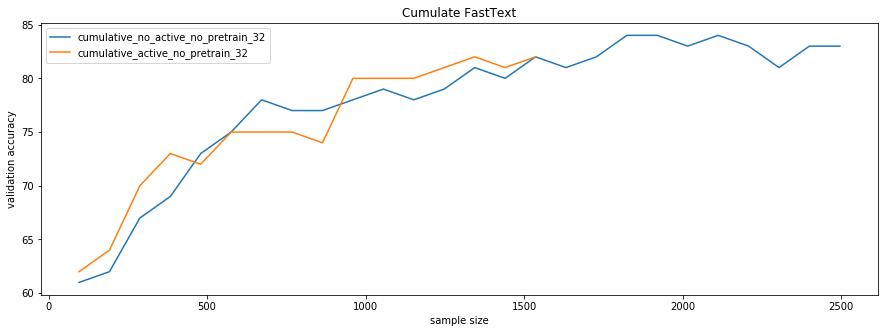

In [60]:
fig = plt.figure(figsize= (15,5))
plt.plot(32*np.arange(interval,train_size//batch_size+interval,interval),np.max(cumulate_ft[:,:,-1],1),label = "cumulative_no_active_no_pretrain_32")
plt.plot(32*np.arange(interval,batch_number+interval,interval),np.max(cumulate_al_ft[:,:,-1],1),label = "cumulative_active_no_pretrain_32")

plt.title("Cumulate FastText")
plt.xlabel("sample size")
plt.ylabel("validation accuracy")
plt.legend()

In [40]:
# FastText Cumulative
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

#model = FastText(vocab_size, emb_dim).cuda()

# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1).cuda()
# model = LSTM(vocab_size, emb_dim,100,batch_size,num_layers=1)
# cumulative_no_active_no_pretrain_32_FastText = np.array(cumulative_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size))

interval = 3
batch_number = train_size//batch_size
cumulative_no_active_no_pretrain_32_Fasttext = []
for fac in np.arange(interval,batch_number+interval,interval):
    train_fac_loader = train_loader[:fac]
    train_fac_size = fac*batch_size
    model = FastText(vocab_size, emb_dim).cuda()
    cumulative_no_active_no_pretrain_32_Fasttext.append(np.array(cumulative_train(model,train_fac_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_fac_size,batch_size)))

    

In [46]:
a["aj"] = 0
a['label'] = 9

In [51]:
if('label' in test_loader[0].keys()):
    print(1)
else:
    print(0)

1


In [50]:
test_loader[0]

{'text': {'tokens': tensor([[   133,    133,  17733,  ...,   2071,      3,     19],
          [    14,    473,     83,  ...,  13982,      4,  25358],
          [    11,    257,   1788,  ...,      0,      0,      0],
          ...,
          [     2,     38,      6,  ...,      0,      0,      0],
          [     1,   1953,      9,  ...,     22,      5,     62],
          [    11,     18,     28,  ...,      3,      1,   6985]], device='cuda:0')},
 'length': tensor([ 422,  505,  142,  342,  134,  197,  154,  150,  252,  148,
          340,  121,  139,  454,  406,  180,  164,  161,  228,  175,
          163,  165,  146,  264,  326,   95,   97,  499,  391,  202,
          625,  279], device='cuda:0'),
 'label': tensor([ 1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,
          1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  1,  0,
          1,  1,  0,  0], device='cuda:0')}

In [63]:
# FastText Probability Calibration
batch_size = 32
emb_dim =300
learning_rate = 0.001
n_iter = 20
cuda_device = 0

train_loader = batchify(train_data,vocab,batch_size,True,cuda_device)
test_loader = batchify(test_data,vocab,batch_size,True,cuda_device)

vocab_size = vocab.get_vocab_size()
train_size = len(train_data)

model = FastText(vocab_size, emb_dim).cuda()

acc,ft_model = cumulative_train(model,train_loader,test_loader,n_iter,vocab_size,emb_dim,learning_rate,train_size,batch_size)

FastText Model
No pretrained embedding
embedding weight is trainable
n_iter:  20
vocab_size 34090
emb_dim:  300
learning_rate:  0.001
batch_size:  32
train data size 2500
<generator object Module.parameters at 0x7fb5f3f1aca8>
Time:[0 seconds], batch: [0/78], Epoch: [1/20], step: [1/1562], Loss: 0.6947827339172363,Acc:51
Time:[0 seconds], batch: [1/78], Epoch: [1/20], step: [2/1562], Loss: 0.6931720972061157,Acc:50
Time:[0 seconds], batch: [2/78], Epoch: [1/20], step: [3/1562], Loss: 0.6958199739456177,Acc:50
Time:[0 seconds], batch: [3/78], Epoch: [1/20], step: [4/1562], Loss: 0.6979162096977234,Acc:50
Time:[0 seconds], batch: [4/78], Epoch: [1/20], step: [5/1562], Loss: 0.6966003179550171,Acc:51
Time:[0 seconds], batch: [5/78], Epoch: [1/20], step: [6/1562], Loss: 0.6973624229431152,Acc:52
Time:[0 seconds], batch: [6/78], Epoch: [1/20], step: [7/1562], Loss: 0.6883634328842163,Acc:54
Time:[0 seconds], batch: [7/78], Epoch: [1/20], step: [8/1562], Loss: 0.6934947967529297,Acc:55
Time:[

Time:[0 seconds], batch: [24/78], Epoch: [2/20], step: [104/1562], Loss: 0.6600788235664368,Acc:60
Time:[0 seconds], batch: [25/78], Epoch: [2/20], step: [105/1562], Loss: 0.6532779932022095,Acc:59
Time:[0 seconds], batch: [26/78], Epoch: [2/20], step: [106/1562], Loss: 0.6826589107513428,Acc:59
Time:[0 seconds], batch: [27/78], Epoch: [2/20], step: [107/1562], Loss: 0.6875099539756775,Acc:60
Time:[0 seconds], batch: [28/78], Epoch: [2/20], step: [108/1562], Loss: 0.6774609088897705,Acc:60
Time:[0 seconds], batch: [29/78], Epoch: [2/20], step: [109/1562], Loss: 0.6732639074325562,Acc:60
Time:[0 seconds], batch: [30/78], Epoch: [2/20], step: [110/1562], Loss: 0.6780784130096436,Acc:61
Time:[0 seconds], batch: [31/78], Epoch: [2/20], step: [111/1562], Loss: 0.6742123365402222,Acc:61
Time:[0 seconds], batch: [32/78], Epoch: [2/20], step: [112/1562], Loss: 0.6661652326583862,Acc:61
Time:[0 seconds], batch: [33/78], Epoch: [2/20], step: [113/1562], Loss: 0.6679040789604187,Acc:63
Time:[0 se

Time:[1 seconds], batch: [67/78], Epoch: [3/20], step: [226/1562], Loss: 0.6090778112411499,Acc:71
Time:[1 seconds], batch: [68/78], Epoch: [3/20], step: [227/1562], Loss: 0.5845662951469421,Acc:71
Time:[1 seconds], batch: [69/78], Epoch: [3/20], step: [228/1562], Loss: 0.6166354417800903,Acc:71
Time:[1 seconds], batch: [70/78], Epoch: [3/20], step: [229/1562], Loss: 0.5946826338768005,Acc:71
Time:[1 seconds], batch: [71/78], Epoch: [3/20], step: [230/1562], Loss: 0.5981146097183228,Acc:71
Time:[1 seconds], batch: [72/78], Epoch: [3/20], step: [231/1562], Loss: 0.6491131782531738,Acc:71
Time:[1 seconds], batch: [73/78], Epoch: [3/20], step: [232/1562], Loss: 0.6338704824447632,Acc:71
Time:[1 seconds], batch: [74/78], Epoch: [3/20], step: [233/1562], Loss: 0.5669363737106323,Acc:71
Time:[1 seconds], batch: [75/78], Epoch: [3/20], step: [234/1562], Loss: 0.5325906276702881,Acc:71
Time:[1 seconds], batch: [76/78], Epoch: [3/20], step: [235/1562], Loss: 0.6132837533950806,Acc:70
Time:[1 se

Time:[1 seconds], batch: [32/78], Epoch: [5/20], step: [349/1562], Loss: 0.4801681637763977,Acc:74
Time:[1 seconds], batch: [33/78], Epoch: [5/20], step: [350/1562], Loss: 0.5588557124137878,Acc:75
Time:[1 seconds], batch: [34/78], Epoch: [5/20], step: [351/1562], Loss: 0.46255287528038025,Acc:75
Time:[1 seconds], batch: [35/78], Epoch: [5/20], step: [352/1562], Loss: 0.4500291347503662,Acc:75
Time:[1 seconds], batch: [36/78], Epoch: [5/20], step: [353/1562], Loss: 0.5052273869514465,Acc:75
Time:[1 seconds], batch: [37/78], Epoch: [5/20], step: [354/1562], Loss: 0.44531118869781494,Acc:75
Time:[1 seconds], batch: [38/78], Epoch: [5/20], step: [355/1562], Loss: 0.4794699549674988,Acc:75
Time:[1 seconds], batch: [39/78], Epoch: [5/20], step: [356/1562], Loss: 0.4829431474208832,Acc:75
Time:[1 seconds], batch: [40/78], Epoch: [5/20], step: [357/1562], Loss: 0.525220513343811,Acc:75
Time:[1 seconds], batch: [41/78], Epoch: [5/20], step: [358/1562], Loss: 0.4744541645050049,Acc:75
Time:[1 s

Time:[2 seconds], batch: [75/78], Epoch: [6/20], step: [471/1562], Loss: 0.3162132501602173,Acc:78
Time:[2 seconds], batch: [76/78], Epoch: [6/20], step: [472/1562], Loss: 0.439859002828598,Acc:78
Time:[2 seconds], batch: [77/78], Epoch: [6/20], step: [473/1562], Loss: 0.3727266490459442,Acc:78
Time:[2 seconds], batch: [78/78], Epoch: [6/20], step: [474/1562], Loss: 0.5420858860015869,Acc:78
Time:[2 seconds], batch: [0/78], Epoch: [7/20], step: [475/1562], Loss: 0.39248716831207275,Acc:78
Time:[2 seconds], batch: [1/78], Epoch: [7/20], step: [476/1562], Loss: 0.43842923641204834,Acc:78
Time:[2 seconds], batch: [2/78], Epoch: [7/20], step: [477/1562], Loss: 0.37551891803741455,Acc:78
Time:[2 seconds], batch: [3/78], Epoch: [7/20], step: [478/1562], Loss: 0.37974920868873596,Acc:78
Time:[2 seconds], batch: [4/78], Epoch: [7/20], step: [479/1562], Loss: 0.34766635298728943,Acc:78
Time:[2 seconds], batch: [5/78], Epoch: [7/20], step: [480/1562], Loss: 0.3981245458126068,Acc:78
Time:[2 seco

Time:[2 seconds], batch: [40/78], Epoch: [8/20], step: [594/1562], Loss: 0.3942188024520874,Acc:80
Time:[2 seconds], batch: [41/78], Epoch: [8/20], step: [595/1562], Loss: 0.2972501814365387,Acc:80
Time:[2 seconds], batch: [42/78], Epoch: [8/20], step: [596/1562], Loss: 0.24820184707641602,Acc:80
Time:[2 seconds], batch: [43/78], Epoch: [8/20], step: [597/1562], Loss: 0.2605125904083252,Acc:80
Time:[3 seconds], batch: [44/78], Epoch: [8/20], step: [598/1562], Loss: 0.3251486122608185,Acc:80
Time:[3 seconds], batch: [45/78], Epoch: [8/20], step: [599/1562], Loss: 0.31966379284858704,Acc:80
Time:[3 seconds], batch: [46/78], Epoch: [8/20], step: [600/1562], Loss: 0.26955920457839966,Acc:80
Time:[3 seconds], batch: [47/78], Epoch: [8/20], step: [601/1562], Loss: 0.26439446210861206,Acc:80
Time:[3 seconds], batch: [48/78], Epoch: [8/20], step: [602/1562], Loss: 0.2513619065284729,Acc:80
Time:[3 seconds], batch: [49/78], Epoch: [8/20], step: [603/1562], Loss: 0.2833743095397949,Acc:80
Time:[

Time:[3 seconds], batch: [44/78], Epoch: [9/20], step: [677/1562], Loss: 0.2773272395133972,Acc:81
Time:[3 seconds], batch: [45/78], Epoch: [9/20], step: [678/1562], Loss: 0.27292895317077637,Acc:81
Time:[3 seconds], batch: [46/78], Epoch: [9/20], step: [679/1562], Loss: 0.22458791732788086,Acc:81
Time:[3 seconds], batch: [47/78], Epoch: [9/20], step: [680/1562], Loss: 0.21937128901481628,Acc:81
Time:[3 seconds], batch: [48/78], Epoch: [9/20], step: [681/1562], Loss: 0.20798669755458832,Acc:81
Time:[3 seconds], batch: [49/78], Epoch: [9/20], step: [682/1562], Loss: 0.2352904975414276,Acc:81
Time:[3 seconds], batch: [50/78], Epoch: [9/20], step: [683/1562], Loss: 0.2598611116409302,Acc:81
Time:[3 seconds], batch: [51/78], Epoch: [9/20], step: [684/1562], Loss: 0.2517443001270294,Acc:82
Time:[3 seconds], batch: [52/78], Epoch: [9/20], step: [685/1562], Loss: 0.23375609517097473,Acc:82
Time:[3 seconds], batch: [53/78], Epoch: [9/20], step: [686/1562], Loss: 0.2664661407470703,Acc:82
Time:

Time:[4 seconds], batch: [7/78], Epoch: [11/20], step: [798/1562], Loss: 0.15561231970787048,Acc:82
Time:[4 seconds], batch: [8/78], Epoch: [11/20], step: [799/1562], Loss: 0.14661574363708496,Acc:82
Time:[4 seconds], batch: [9/78], Epoch: [11/20], step: [800/1562], Loss: 0.20589274168014526,Acc:82
Time:[4 seconds], batch: [10/78], Epoch: [11/20], step: [801/1562], Loss: 0.1795094907283783,Acc:82
Time:[4 seconds], batch: [11/78], Epoch: [11/20], step: [802/1562], Loss: 0.17878851294517517,Acc:83
Time:[4 seconds], batch: [12/78], Epoch: [11/20], step: [803/1562], Loss: 0.17947503924369812,Acc:82
Time:[4 seconds], batch: [13/78], Epoch: [11/20], step: [804/1562], Loss: 0.2115284502506256,Acc:82
Time:[4 seconds], batch: [14/78], Epoch: [11/20], step: [805/1562], Loss: 0.18519967794418335,Acc:82
Time:[4 seconds], batch: [15/78], Epoch: [11/20], step: [806/1562], Loss: 0.2264477163553238,Acc:82
Time:[4 seconds], batch: [16/78], Epoch: [11/20], step: [807/1562], Loss: 0.18717403709888458,Acc

Time:[4 seconds], batch: [50/78], Epoch: [12/20], step: [920/1562], Loss: 0.16113850474357605,Acc:84
Time:[4 seconds], batch: [51/78], Epoch: [12/20], step: [921/1562], Loss: 0.14423179626464844,Acc:84
Time:[4 seconds], batch: [52/78], Epoch: [12/20], step: [922/1562], Loss: 0.1410953253507614,Acc:84
Time:[4 seconds], batch: [53/78], Epoch: [12/20], step: [923/1562], Loss: 0.15508554875850677,Acc:84
Time:[4 seconds], batch: [54/78], Epoch: [12/20], step: [924/1562], Loss: 0.23438885807991028,Acc:84
Time:[4 seconds], batch: [55/78], Epoch: [12/20], step: [925/1562], Loss: 0.14943501353263855,Acc:84
Time:[4 seconds], batch: [56/78], Epoch: [12/20], step: [926/1562], Loss: 0.14167506992816925,Acc:84
Time:[4 seconds], batch: [57/78], Epoch: [12/20], step: [927/1562], Loss: 0.1441774219274521,Acc:84
Time:[4 seconds], batch: [58/78], Epoch: [12/20], step: [928/1562], Loss: 0.1348879635334015,Acc:84
Time:[4 seconds], batch: [59/78], Epoch: [12/20], step: [929/1562], Loss: 0.1852419674396515,A

Time:[5 seconds], batch: [14/78], Epoch: [14/20], step: [1042/1562], Loss: 0.11769226938486099,Acc:84
Time:[5 seconds], batch: [15/78], Epoch: [14/20], step: [1043/1562], Loss: 0.138522207736969,Acc:84
Time:[5 seconds], batch: [16/78], Epoch: [14/20], step: [1044/1562], Loss: 0.11696703732013702,Acc:84
Time:[5 seconds], batch: [17/78], Epoch: [14/20], step: [1045/1562], Loss: 0.08931989222764969,Acc:84
Time:[5 seconds], batch: [18/78], Epoch: [14/20], step: [1046/1562], Loss: 0.10902413725852966,Acc:84
Time:[5 seconds], batch: [19/78], Epoch: [14/20], step: [1047/1562], Loss: 0.1228216290473938,Acc:83
Time:[5 seconds], batch: [20/78], Epoch: [14/20], step: [1048/1562], Loss: 0.12009092420339584,Acc:83
Time:[5 seconds], batch: [21/78], Epoch: [14/20], step: [1049/1562], Loss: 0.08930090069770813,Acc:83
Time:[5 seconds], batch: [22/78], Epoch: [14/20], step: [1050/1562], Loss: 0.09835149347782135,Acc:83
Time:[5 seconds], batch: [23/78], Epoch: [14/20], step: [1051/1562], Loss: 0.09707178

Time:[5 seconds], batch: [16/78], Epoch: [15/20], step: [1123/1562], Loss: 0.09992803633213043,Acc:85
Time:[5 seconds], batch: [17/78], Epoch: [15/20], step: [1124/1562], Loss: 0.07649359107017517,Acc:84
Time:[5 seconds], batch: [18/78], Epoch: [15/20], step: [1125/1562], Loss: 0.09624999016523361,Acc:84
Time:[5 seconds], batch: [19/78], Epoch: [15/20], step: [1126/1562], Loss: 0.10677766799926758,Acc:85
Time:[5 seconds], batch: [20/78], Epoch: [15/20], step: [1127/1562], Loss: 0.10674643516540527,Acc:85
Time:[5 seconds], batch: [21/78], Epoch: [15/20], step: [1128/1562], Loss: 0.07613687962293625,Acc:85
Time:[5 seconds], batch: [22/78], Epoch: [15/20], step: [1129/1562], Loss: 0.08201351016759872,Acc:84
Time:[5 seconds], batch: [23/78], Epoch: [15/20], step: [1130/1562], Loss: 0.08375927060842514,Acc:84
Time:[5 seconds], batch: [24/78], Epoch: [15/20], step: [1131/1562], Loss: 0.1652543991804123,Acc:85
Time:[5 seconds], batch: [25/78], Epoch: [15/20], step: [1132/1562], Loss: 0.100376

Time:[6 seconds], batch: [18/78], Epoch: [16/20], step: [1204/1562], Loss: 0.0852455198764801,Acc:85
Time:[6 seconds], batch: [19/78], Epoch: [16/20], step: [1205/1562], Loss: 0.09290020912885666,Acc:85
Time:[6 seconds], batch: [20/78], Epoch: [16/20], step: [1206/1562], Loss: 0.0955614447593689,Acc:85
Time:[6 seconds], batch: [21/78], Epoch: [16/20], step: [1207/1562], Loss: 0.06526916474103928,Acc:85
Time:[6 seconds], batch: [22/78], Epoch: [16/20], step: [1208/1562], Loss: 0.06882257759571075,Acc:85
Time:[6 seconds], batch: [23/78], Epoch: [16/20], step: [1209/1562], Loss: 0.07269393652677536,Acc:85
Time:[6 seconds], batch: [24/78], Epoch: [16/20], step: [1210/1562], Loss: 0.1423666924238205,Acc:85
Time:[6 seconds], batch: [25/78], Epoch: [16/20], step: [1211/1562], Loss: 0.08801791071891785,Acc:85
Time:[6 seconds], batch: [26/78], Epoch: [16/20], step: [1212/1562], Loss: 0.10916970670223236,Acc:85
Time:[6 seconds], batch: [27/78], Epoch: [16/20], step: [1213/1562], Loss: 0.06948111

Time:[6 seconds], batch: [21/78], Epoch: [17/20], step: [1286/1562], Loss: 0.05625461786985397,Acc:85
Time:[6 seconds], batch: [22/78], Epoch: [17/20], step: [1287/1562], Loss: 0.058152493089437485,Acc:85
Time:[6 seconds], batch: [23/78], Epoch: [17/20], step: [1288/1562], Loss: 0.06341307610273361,Acc:85
Time:[6 seconds], batch: [24/78], Epoch: [17/20], step: [1289/1562], Loss: 0.12216202914714813,Acc:85
Time:[6 seconds], batch: [25/78], Epoch: [17/20], step: [1290/1562], Loss: 0.07754619419574738,Acc:85
Time:[6 seconds], batch: [26/78], Epoch: [17/20], step: [1291/1562], Loss: 0.0937977135181427,Acc:85
Time:[6 seconds], batch: [27/78], Epoch: [17/20], step: [1292/1562], Loss: 0.06029391288757324,Acc:85
Time:[6 seconds], batch: [28/78], Epoch: [17/20], step: [1293/1562], Loss: 0.06717893481254578,Acc:85
Time:[6 seconds], batch: [29/78], Epoch: [17/20], step: [1294/1562], Loss: 0.07854403555393219,Acc:85
Time:[6 seconds], batch: [30/78], Epoch: [17/20], step: [1295/1562], Loss: 0.06676

Time:[6 seconds], batch: [24/78], Epoch: [18/20], step: [1368/1562], Loss: 0.1047002524137497,Acc:85
Time:[6 seconds], batch: [25/78], Epoch: [18/20], step: [1369/1562], Loss: 0.06860469281673431,Acc:85
Time:[6 seconds], batch: [26/78], Epoch: [18/20], step: [1370/1562], Loss: 0.08100352436304092,Acc:85
Time:[6 seconds], batch: [27/78], Epoch: [18/20], step: [1371/1562], Loss: 0.0526171512901783,Acc:85
Time:[6 seconds], batch: [28/78], Epoch: [18/20], step: [1372/1562], Loss: 0.0597086139023304,Acc:85
Time:[6 seconds], batch: [29/78], Epoch: [18/20], step: [1373/1562], Loss: 0.06664759665727615,Acc:85
Time:[6 seconds], batch: [30/78], Epoch: [18/20], step: [1374/1562], Loss: 0.057523034512996674,Acc:85
Time:[6 seconds], batch: [31/78], Epoch: [18/20], step: [1375/1562], Loss: 0.07999292016029358,Acc:85
Time:[6 seconds], batch: [32/78], Epoch: [18/20], step: [1376/1562], Loss: 0.08025526255369186,Acc:85
Time:[6 seconds], batch: [33/78], Epoch: [18/20], step: [1377/1562], Loss: 0.0636221

Time:[7 seconds], batch: [30/78], Epoch: [19/20], step: [1453/1562], Loss: 0.04981498420238495,Acc:85
Time:[7 seconds], batch: [31/78], Epoch: [19/20], step: [1454/1562], Loss: 0.07220165431499481,Acc:85
Time:[7 seconds], batch: [32/78], Epoch: [19/20], step: [1455/1562], Loss: 0.07136509567499161,Acc:85
Time:[7 seconds], batch: [33/78], Epoch: [19/20], step: [1456/1562], Loss: 0.055284544825553894,Acc:85
Time:[7 seconds], batch: [34/78], Epoch: [19/20], step: [1457/1562], Loss: 0.044641394168138504,Acc:85
Time:[7 seconds], batch: [35/78], Epoch: [19/20], step: [1458/1562], Loss: 0.05277547612786293,Acc:85
Time:[7 seconds], batch: [36/78], Epoch: [19/20], step: [1459/1562], Loss: 0.0659884512424469,Acc:85
Time:[7 seconds], batch: [37/78], Epoch: [19/20], step: [1460/1562], Loss: 0.06860370188951492,Acc:85
Time:[7 seconds], batch: [38/78], Epoch: [19/20], step: [1461/1562], Loss: 0.04690205678343773,Acc:85
Time:[7 seconds], batch: [39/78], Epoch: [19/20], step: [1462/1562], Loss: 0.0593

Time:[7 seconds], batch: [32/78], Epoch: [20/20], step: [1534/1562], Loss: 0.06354571878910065,Acc:84
Time:[7 seconds], batch: [33/78], Epoch: [20/20], step: [1535/1562], Loss: 0.04840429872274399,Acc:85
Time:[7 seconds], batch: [34/78], Epoch: [20/20], step: [1536/1562], Loss: 0.03937837481498718,Acc:85
Time:[7 seconds], batch: [35/78], Epoch: [20/20], step: [1537/1562], Loss: 0.04695817083120346,Acc:85
Time:[7 seconds], batch: [36/78], Epoch: [20/20], step: [1538/1562], Loss: 0.05805611610412598,Acc:85
Time:[7 seconds], batch: [37/78], Epoch: [20/20], step: [1539/1562], Loss: 0.061927832663059235,Acc:85
Time:[7 seconds], batch: [38/78], Epoch: [20/20], step: [1540/1562], Loss: 0.041307754814624786,Acc:84
Time:[7 seconds], batch: [39/78], Epoch: [20/20], step: [1541/1562], Loss: 0.05253096669912338,Acc:84
Time:[7 seconds], batch: [40/78], Epoch: [20/20], step: [1542/1562], Loss: 0.08908674865961075,Acc:84
Time:[7 seconds], batch: [41/78], Epoch: [20/20], step: [1543/1562], Loss: 0.046

In [72]:
# predict by fasttext
prob_list = []
ft_model.eval()
for batch_idx,batch in enumerate(test_loader):
    data_batch = Variable(batch['text']['tokens'])
    labels = batch['label']
    length_batch = Variable(batch['length'])
    prob_list+= ft_model(data_batch, length_batch).tolist()
ft_model.train()

FastText(
  (embeds): Embedding(34090, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#use large test data to evaluate
rob_list = []
test_data_lg = build_instance("/data/prodigy/data/IMDB_default/IMDB_more_test.jsonl")
test_loader_lg = batchify(test_data_lg,vocab,batch_size,False,0)
ft_model.eval()
for batch_idx,batch in enumerate(test_loader_lg):
    data_batch = Variable(batch['text']['tokens'])
    labels = batch['label']
    length_batch = Variable(batch['length'])
    prob_list+= ft_model(data_batch, length_batch).tolist()
ft_model.train()

In [81]:
test_label=[]
for d in test_loader:
    test_label += d['label'].tolist()

In [84]:
prob_list

[0.8138580322265625,
 0.1273443102836609,
 0.0914730429649353,
 0.04871376231312752,
 0.016719363629817963,
 0.0006439028074964881,
 0.08659747242927551,
 0.015226076357066631,
 0.04297398403286934,
 0.1762295961380005,
 0.7916274666786194,
 0.011792348697781563,
 0.00788967777043581,
 0.8384086489677429,
 0.8164376020431519,
 0.7960138320922852,
 0.9912828207015991,
 0.0005247063818387687,
 0.07010677456855774,
 0.8736779093742371,
 0.8766034245491028,
 0.0007635992951691151,
 0.0009534613927826285,
 0.1424327790737152,
 0.7929147481918335,
 0.2278810292482376,
 0.9947540760040283,
 0.37712910771369934,
 0.6433539986610413,
 0.9993791580200195,
 0.11301278322935104,
 0.5970451235771179,
 0.02379022166132927,
 0.41221708059310913,
 0.2985133230686188,
 0.8682653903961182,
 0.9227758049964905,
 0.9581589698791504,
 0.9987767338752747,
 0.714065432548523,
 0.6030678749084473,
 0.020361732691526413,
 0.7039309740066528,
 0.9757164716720581,
 0.9279305338859558,
 0.25356540083885193,
 0.32

(array([43., 16., 10., 12.,  5.,  8.,  1.,  4.,  3.,  6.,  2.,  2.,  6.,
         2.,  3.,  3.,  3.,  4.,  3.,  3.,  0.,  0.,  2.,  1.,  1.,  2.,
         1.,  2.,  2.,  2.,  0.,  1.,  3.,  2.,  1.,  0.,  0.,  1.,  0.,
         2.,  4.,  1.,  2.,  1.,  2.,  0.,  0.,  2.,  3.,  0.,  1.,  1.,
         0.,  2.,  1.,  3.,  1.,  2.,  0.,  3.,  2.,  1.,  3.,  2.,  1.,
         1.,  1.,  1.,  3.,  1.,  7.,  3.,  2.,  1.,  0.,  0.,  6.,  2.,
         1.,  5.,  1.,  5.,  2.,  2.,  3.,  1.,  3.,  4.,  3.,  0.,  3.,
         2.,  6.,  3.,  3.,  4.,  3.,  5., 11., 22.]),
 array([3.49644324e-06, 1.00030085e-02, 2.00025205e-02, 3.00020326e-02,
        4.00015446e-02, 5.00010566e-02, 6.00005687e-02, 7.00000807e-02,
        7.99995928e-02, 8.99991048e-02, 9.99986168e-02, 1.09998129e-01,
        1.19997641e-01, 1.29997153e-01, 1.39996665e-01, 1.49996177e-01,
        1.59995689e-01, 1.69995201e-01, 1.79994713e-01, 1.89994225e-01,
        1.99993737e-01, 2.09993249e-01, 2.19992761e-01, 2.29992273e-01,
  

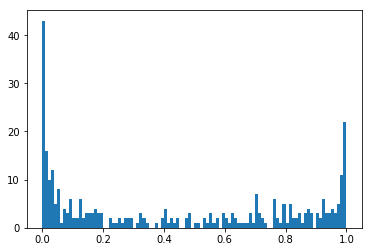

In [75]:
plt.hist(sorted(prob_list),bins=100)

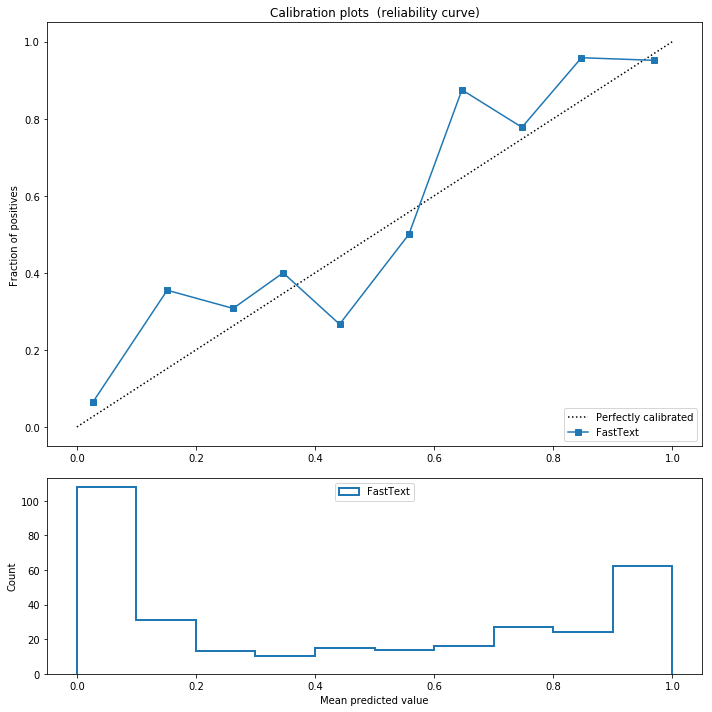

In [92]:
name = "FastText"
fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(test_label,prob_list, n_bins=10)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s" % (name))
ax2.hist(prob_list, range=(0, 1), bins=10, label=name,
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
import json
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import cytoolz
import tqdm
import scipy.sparse as sp
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.linear_model import LogisticRegression

In [94]:
def data_process(file_path,label_answer = 0):
    data = []
    labels = []
    with open(file_path, "r") as data_file:
        for line in data_file:
            line = line.strip("\n")
            if not line:
                continue
            review = json.loads(line)
            
            data.append(review['text'])
            if label_answer:
                labels.append(1 if review['meta']['label_answer'] == "POSITIVE" else 0)
            else:
                labels.append(1 if (review['label'] == "POSITIVE" and review['answer'] == "accept") or (review['label']=='NEGATIVE' and review['answer'] == 'reject') else 0)
    return data,labels
def shuffle_data(data,labels):
    trainset = list(zip(data,labels))
    random.shuffle(trainset)
    return zip(*trainset)

In [105]:
def plot_calibration_curve(est, name, est1,name1,fig_index,X_train,y_train,X_test,y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')
    #lr = linear_model.SGDClassifier(loss="log",n_jobs=-1)
    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                     (est1,name1)]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(test_label_lg,prob_list_lg, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % ("FastText"))
    ax2.hist(prob_list_lg, range=(0, 1), bins=10, label="FastText",
             histtype="step", lw=2)
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic:
	Brier: 0.127
	Precision: 0.829
	Recall: 0.840
	F1: 0.834

Logistic SGD:
	Brier: 0.178
	Precision: 0.813
	Recall: 0.816
	F1: 0.815

SVM:
	Brier: 0.209
	Precision: 0.824
	Recall: 0.810
	F1: 0.817



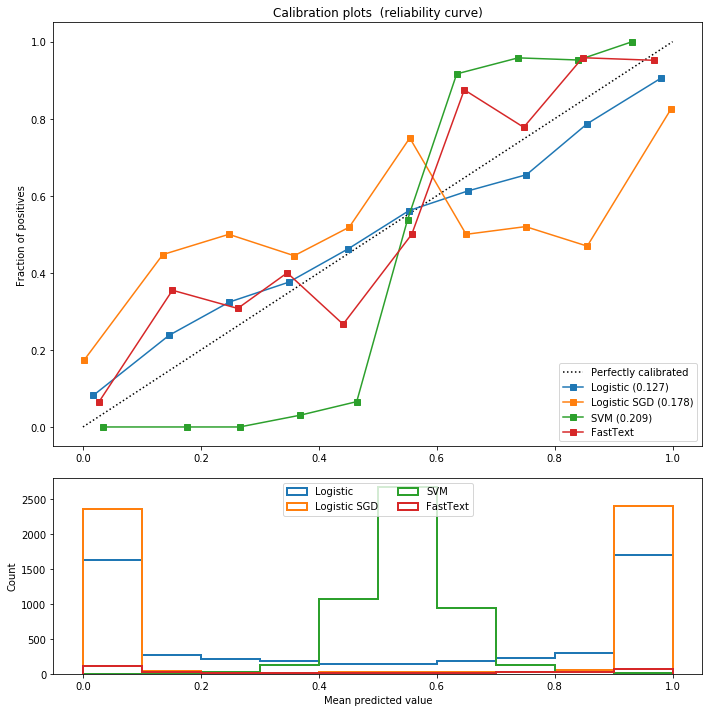

In [107]:
baseline_uni_path = "/data/prodigy/data/IMDB_default/unique_baseline.jsonl"
eval_path = "/data/prodigy/data/IMDB_default/IMDB_more_test.jsonl"
baseline_uni_data,baseline_uni_labels = data_process(baseline_uni_path,1)
eval_data,eval_labels = data_process(eval_path)
vectorizer = CountVectorizer(min_df=5,
                             max_df = 0.8)
baseline_uni_vectors = vectorizer.fit_transform(baseline_uni_data)
eval_vectors = vectorizer.transform(eval_data)
est = linear_model.SGDClassifier(loss="log",n_jobs=-1,max_iter=20)
est1 = linear_model.SGDClassifier(loss="hinge",n_jobs=-1,max_iter=20)
plot_calibration_curve(est, "Logistic SGD", est1,"SVM",1,baseline_uni_vectors,baseline_uni_labels,eval_vectors,eval_labels)

In [ ]:
plot_calibration_curve(est, "Logistic SGD", 1,baseline_uni_vectors,baseline_uni_labels,eval_vectors,eval_labels)